# Предсказание стоимости автомобиля на вторичном рынке

Многие знают про маркетплейс авито, где продаются б/у вещи, на которых есть возможность недорого купить качественную и полезную вещь. Но всегда волнует вопрос - кто и как устанавливает цену, и какие его характеристики больше всего влияют на итоговую стоимость продажи?! Вопрос становиться особо актуальным, если речь идет про дорогие товары, например про автомобили!
____
Целью проекта будет разработанная модель предсказания стоимости автомобиля на вторичном рынке.

### В ходе работы планируем выполнить следующие шаги:
1. Загрузка и подготовка данных.
2. Предобработка и исследовательский анализ данных.
3. Проверка на мультиколлинеарность, отбор финального набора обучающих признаков.
4. Выбор и обучение моделей, итоговая оценка качества предсказания лучшей модели.
5. Анализ важности ее признаков.
6. Вывод.

##### Описание полей данных
- 'year' - год производства
- 'make' - производитель
- 'model' - модель
- 'trim' - модификация
- 'body' - тип кузова
- 'transmission' - тип КПП
- 'vin' - идентификатор (вин)
- 'state' - штат регистрации
- 'condition' - состояние по шкале (1-5)
- 'odometer' - пробег в милях
- 'color' - цвет кузова
- 'interior' - цвет интерьера
- 'seller' - продавец
- 'sellingprice' - стоимость продажи
- 'saledate' - дата продажи

Источник данных: https://www.kaggle.com/competitions/used-cars-price-prediction-yap17/data

## 1. Загрузка и подготовка данных

In [1]:
# выведем необходимые библиотеки для работы

import time
import warnings
from tqdm import tqdm
from datetime import datetime


import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
import matplotlib.pyplot as plt

import phik
from phik import resources, report
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.datasets import make_regression
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor 

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

from statsmodels.stats.outliers_influence import variance_inflation_factor


warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(style="darkgrid",font_scale=1.5)
pd.set_option("display.max.columns",None)
pd.set_option("display.max.rows",None)


RANDOM_STATE = 12345


In [2]:
# выводим информацию о данных датафреймов
DATA_TRAIN = '/Users/urvanov_aleksandr/Documents/Yandex/17DS+/Мастерская/used_cars_price/train.csv'
DATA_TEST = '/Users/urvanov_aleksandr/Documents/Yandex/17DS+/Мастерская/used_cars_price/test.csv'

# df1 - датафрейм с данными для обучения модели
df1 = pd.read_csv(f'{DATA_TRAIN}', parse_dates=['saledate'], dayfirst=True)

# df2 - датафрейм с данными для тестирования модели
df2 = pd.read_csv(f'{DATA_TEST}', parse_dates=['saledate'], dayfirst=True)

# в столбце 'saledate' выведем только год продажи 
def saledate (df):
    df['saledate'] = pd.to_datetime(df['saledate'], infer_datetime_format=True, utc=True )
    df['saledate'] = df['saledate'].dt.tz_localize(None)
    df['saledate'] = pd.DatetimeIndex(df['saledate']).year
# выведем общую информацию о датафреймах    
    display(df.head(3))
    df.info()

for i in [df1, df2]:
    saledate(i)  

year    make   model    trim   body transmission                vin state  \
0  2011    Ford    Edge     SEL    suv    automatic  2fmdk3jc4bba41556    md   
1  2014    Ford  Fusion      SE  Sedan    automatic  3fa6p0h75er208976    mo   
2  2012  Nissan  Sentra  2.0 SL  sedan    automatic  3n1ab6ap4cl698412    nj   

   condition  odometer  color interior                 seller  sellingprice  \
0        4.2  111041.0  black    black     santander consumer         12500   
1        3.5   31034.0  black    black  ars/avis budget group         14500   
2        2.2   35619.0  black    black     nissan-infiniti lt          9100   

   saledate  
0      2015  
1      2015  
2      2015

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  int64  
dtypes: float64(2), int64(3), object(10)
memory usage: 50.4+ MB


year      make         model  trim   body transmission                vin  \
0  2005  Cadillac           CTS  Base  Sedan    automatic  1g6dp567450124779   
1  2014       GMC  Savana Cargo  2500    Van          NaN  1gtw7fca7e1902207   
2  2013    Nissan        Murano     S    SUV    automatic  jn8az1mw6dw303497   

  state  condition  odometer   color interior                  seller  \
0    ca        2.7  116970.0  silver    black  lexus of stevens creek   
1    pa        4.4    6286.0   white     gray                  u-haul   
2    oh        4.6   11831.0    gray    black      nissan-infiniti lt   

   saledate  
0      2015  
1      2015  
2      2015

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110060 entries, 0 to 110059
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110060 non-null  int64  
 1   make          107999 non-null  object 
 2   model         107981 non-null  object 
 3   trim          107946 non-null  object 
 4   body          107466 non-null  object 
 5   transmission  97048 non-null   object 
 6   vin           110060 non-null  object 
 7   state         110060 non-null  object 
 8   condition     107681 non-null  float64
 9   odometer      110041 non-null  float64
 10  color         109902 non-null  object 
 11  interior      109902 non-null  object 
 12  seller        110060 non-null  object 
 13  saledate      110060 non-null  int64  
dtypes: float64(2), int64(2), object(10)
memory usage: 11.8+ MB


In [3]:
# приведем значения строчных столбцов к нижнему регистру
def str_low (df):
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].str.lower()
    display(df.head(1))
    
for i in [df1, df2]:
    str_low(i)    
    

year  make model trim body transmission                vin state  \
0  2011  ford  edge  sel  suv    automatic  2fmdk3jc4bba41556    md   

   condition  odometer  color interior              seller  sellingprice  \
0        4.2  111041.0  black    black  santander consumer         12500   

   saledate  
0      2015

year      make model  trim   body transmission                vin state  \
0  2005  cadillac   cts  base  sedan    automatic  1g6dp567450124779    ca   

   condition  odometer   color interior                  seller  saledate  
0        2.7  116970.0  silver    black  lexus of stevens creek      2015

In [4]:
# выведем число уникальных значений в каждом признаке
for i in df1:
    print(f'{i}_({df1[i].nunique()})', end='')

year_(34)make_(62)model_(839)trim_(1850)body_(45)transmission_(2)vin_(440236)state_(38)condition_(41)odometer_(159364)color_(20)interior_(17)seller_(13025)sellingprice_(1735)saledate_(2)

In [5]:
# проверяем количество полных явных строк-дубликатов
df1.duplicated().sum()

0

In [6]:
# проверяем количество дубликатов по vin 
df1['vin'].duplicated().sum()

0

Создадим новые признаки 'количество лет в собственности', 'модель'. Удалим столбцы с годом покупки и продажи, для упрощения модели будем использовать 'количество лет в собственности'. Также согласно источникам из интернета цена не зависит от продавца, цвета салона и года продажи. И будет логичнее соединить марку, модель и тип кузова в один столбец.

In [7]:
def usage (df):
    df['usage'] = df['saledate'] - df['year']
    df = df.drop(columns=['saledate', 'year', 'seller', 'interior'])
    
for i in [df1, df2]:
    usage(i)


In [8]:
def model(df):
    df['model'] = + df['make'] + ' ' + df['model'] + ' ' + df['body']
    df = df.drop(columns=['make', 'body'])
    
for i in [df1, df2]:
    model(i)    

In [9]:
# наводим порядок в столбцах
df1 = df1.reindex(
    columns=['vin','model','trim','transmission', 'color', 'state', 'usage','odometer', 'condition',
             'sellingprice'])
df2 = df2.reindex(
    columns=['vin','model','trim','transmission', 'color', 'state', 'usage','odometer', 'condition'])

display(df1.head(3))
display(df2.head(3))


vin                model    trim transmission  color state  \
0  2fmdk3jc4bba41556        ford edge suv     sel    automatic  black    md   
1  3fa6p0h75er208976    ford fusion sedan      se    automatic  black    mo   
2  3n1ab6ap4cl698412  nissan sentra sedan  2.0 sl    automatic  black    nj   

   usage  odometer  condition  sellingprice  
0      4  111041.0        4.2         12500  
1      1   31034.0        3.5         14500  
2      3   35619.0        2.2          9100

vin                 model  trim transmission   color state  \
0  1g6dp567450124779    cadillac cts sedan  base    automatic  silver    ca   
1  1gtw7fca7e1902207  gmc savana cargo van  2500          NaN   white    pa   
2  jn8az1mw6dw303497     nissan murano suv     s    automatic    gray    oh   

   usage  odometer  condition  
0     10  116970.0        2.7  
1      1    6286.0        4.4  
2      2   11831.0        4.6

Оцениваем число и долю пропусков в датафреймах.

In [10]:
df_na = pd.DataFrame(df1.isna().sum(), columns=['count']).join(
        pd.DataFrame(df1.isna().mean(), columns=['share'])).join(
        pd.DataFrame(df2.isna().sum(), columns=['count_test']).join(
        pd.DataFrame(df2.isna().mean(), columns=['share_test'])))
   
df_na.style.format(
    {'share':'{:.2f}', 'share_test':'{:.2f}', 'count':'{:.2f}', 'count_test':'{:.2f}'}).background_gradient()    
      

#### Вывод

Открыли и изучили датафреймы. Привели признаки к порядку, дубликаты не были выявлены.
Много пропусков, будем последовательно исправлять ситуацию.

## 2. Предобработка и исследовательский анализ данных

### Признак 'usage'

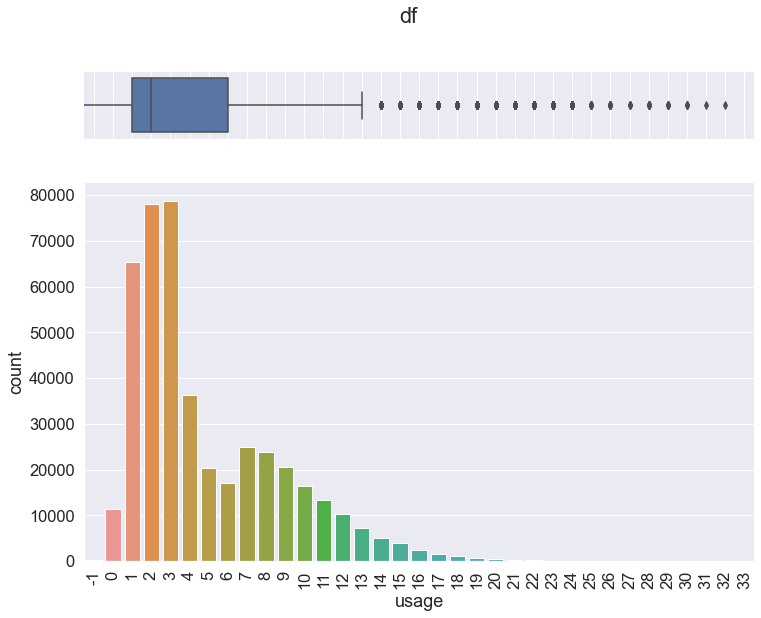

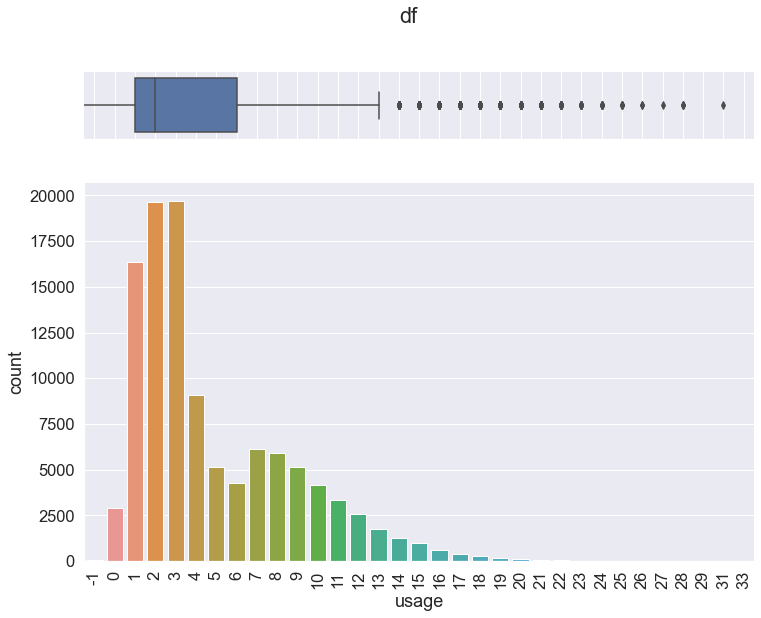

In [11]:
# выводим распределение по годам собственности в обучающей  и тестовой выборке
def own(df):
    f, (ax_1, ax_2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(12,9)) 
    sns.boxplot(x=df['usage'], ax=ax_1) 
    sns.countplot(x=df[ 'usage'], ax=ax_2)
    ax_1.set(yticks=[], xlabel=None)
    sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2) 
    ax_2.tick_params(axis= 'x', labelrotation=90); f.suptitle('df'); plt.show()
                                                                                                             
for i in [df1, df2]:
    own(i)                                                                                                                                                                                                                      
                                                                                                           

In [12]:
def own_2 (df):
    print(df.query('usage <= 0').shape[0])
    display(df.query('usage <= 0').describe())

for i in [df1, df2]:
    own_2(i) 
    

11577


usage       odometer     condition   sellingprice
count  11577.000000   11576.000000  11280.000000   11577.000000
mean      -0.014339   14041.725380      4.140523   23966.452794
std        0.118888    9509.345251      0.927315   13309.593231
min       -1.000000       1.000000      1.000000    1100.000000
25%        0.000000    7556.750000      4.000000   15400.000000
50%        0.000000   12665.500000      4.400000   20400.000000
75%        0.000000   18391.000000      4.800000   29600.000000
max        0.000000  100449.000000      5.000000  173000.000000

2931


usage      odometer    condition
count  2931.000000   2931.000000  2861.000000
mean     -0.011941  14087.502900     4.147466
std       0.108640   9613.362679     0.922018
min      -1.000000      1.000000     1.000000
25%       0.000000   7383.000000     4.000000
50%       0.000000  12809.000000     4.400000
75%       0.000000  18501.500000     4.800000
max       0.000000  78489.000000     5.000000

Выявили аномалии срока владения 0 и -1, допустим что это опечатка, прибавим +1 и +2 соответвенно. По пробегу автомобили с аномальным сроком владения соответствуют новым авто. 

In [13]:
for d in (df1, df2):
    d.loc[d['usage']<= 0, 'usage'] = 1
 

### Признак 'odometer'

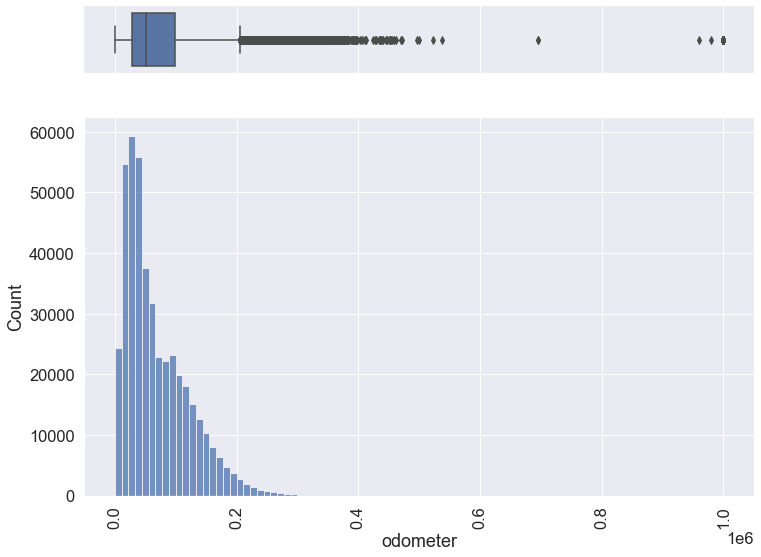

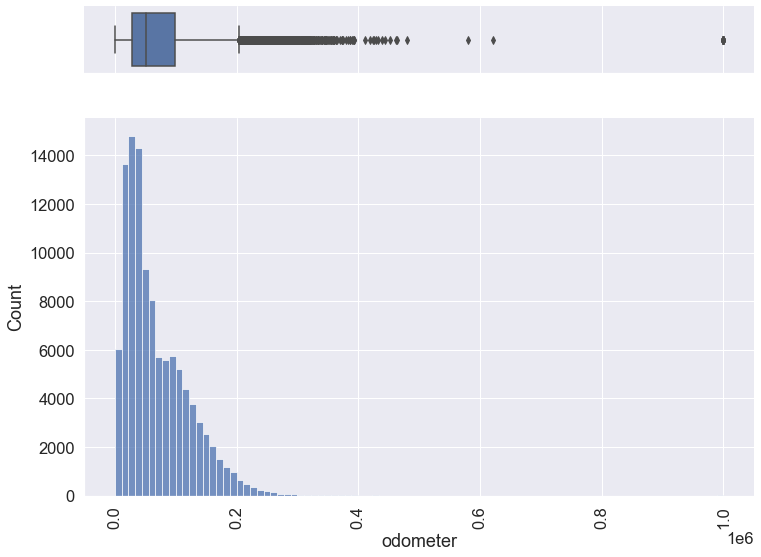

In [14]:
# выводим распределение по пробегу в обучающей  и тестовой выборке
def odometer(df):
    f, (ax_1, ax_2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(12,9)) 
    sns.boxplot(x=df['odometer'], ax=ax_1) 
    sns.histplot(x=df['odometer'], ax=ax_2, bins=90)
    ax_1.set(yticks=[], xlabel=None)
    sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2) 
    ax_2.tick_params(axis= 'x', labelrotation=90)
                                                                                                             
for i in [df1, df2]:
    odometer(i)  
    

In [15]:
def odometer_2 (df):
    print(df.query('odometer > 0.4*10**6').shape[0])
    display(df.query('odometer > 0.4*10**6').describe())

for i in [df1, df2]:
    odometer_2(i) 

92


usage       odometer  condition  sellingprice
count  92.000000      92.000000  87.000000     92.000000
mean    9.326087  794487.728261   1.821839   2327.989130
std     4.693013  265448.696003   0.707177   2626.183256
min     1.000000  402934.000000   1.000000    100.000000
25%     6.000000  455263.250000   1.000000    700.000000
50%     9.000000  999999.000000   1.900000   1500.000000
75%    12.000000  999999.000000   2.000000   3000.000000
max    22.000000  999999.000000   4.700000  14800.000000

31


usage       odometer  condition
count  31.000000      31.000000  30.000000
mean    8.709677  757616.096774   1.780000
std     4.677560  274553.927520   0.749437
min     1.000000  411053.000000   1.000000
25%     5.500000  447327.500000   1.000000
50%     8.000000  999999.000000   1.900000
75%    12.500000  999999.000000   2.150000
max    19.000000  999999.000000   3.500000

По пробегу вопросов нет, выглядит правдоподобно, авто с пробегом больше 400 тыс. миль не так много. Проверим обьекты с пробегом менее 10 миль и сроком в собственности более года.

In [16]:
def odometer_3 (df):
    display(df.query('odometer < 10 & usage > 1' ).describe())

for i in [df1, df2]:
    odometer_3(i) 


usage     odometer   condition  sellingprice
count  1024.000000  1024.000000  953.000000   1024.000000
mean     11.150391     1.012695    1.948898   2207.218750
std       4.288569     0.218488    0.741507   3360.307735
min       2.000000     1.000000    1.000000      1.000000
25%       8.000000     1.000000    1.000000    450.000000
50%      11.000000     1.000000    2.000000   1050.000000
75%      14.000000     1.000000    2.100000   2600.000000
max      25.000000     7.000000    5.000000  37000.000000

usage    odometer   condition
count  247.000000  247.000000  224.000000
mean    10.967611    1.048583    2.008482
std      4.210778    0.515677    0.727900
min      2.000000    1.000000    1.000000
25%      8.000000    1.000000    1.900000
50%     11.000000    1.000000    2.000000
75%     14.000000    1.000000    2.125000
max     24.000000    8.000000    4.800000

Более 1000 объектов в обучающей и 247 в тестовой. Судя по медиане у данных объектов плохое техническое состояние и большой срок службы. Заполним данные ячейки с пробегом медианными значениями, стратифицированными по сроку службы:

In [17]:
for i in df1['usage'].unique():
    df1.loc[(df1['odometer'] < 10) & (df1['usage'] > 1) & (df1 ['usage'] == i), 'odometer'] = \
    df1.loc[~((df1['odometer'] < 10) & (df1['usage'] > 1)) & (df1 ['usage'] == i), 'odometer'].median()
               
               

Обьектов с пропусками 69 шт. (0.02%) удаляем:

In [18]:
df1 = df1.dropna(subset=['odometer']).reset_index(drop=True)

В тестовой выборке заполним аномальные значения и пропуски медианой из учебной выборки:

In [19]:
for i in df2['usage'].unique():
    df2.loc[(df2['odometer'] < 10) & (df2['usage'] > 1) & (df2 ['usage'] == i), 'odometer'] = \
    df1.loc[~((df1['odometer'] < 10) & (df1['usage'] > 1)) & (df1 ['usage'] == i), 'odometer'].median()
    df2['odometer'] = df2['odometer'].fillna(df1['odometer'].median())
    

In [20]:
# приведем столбец 'odometer' к типу 'int'
df1['odometer'] = df1['odometer'].astype(int)
df2['odometer'] = df2['odometer'].astype(int)


### Признак 'condition'

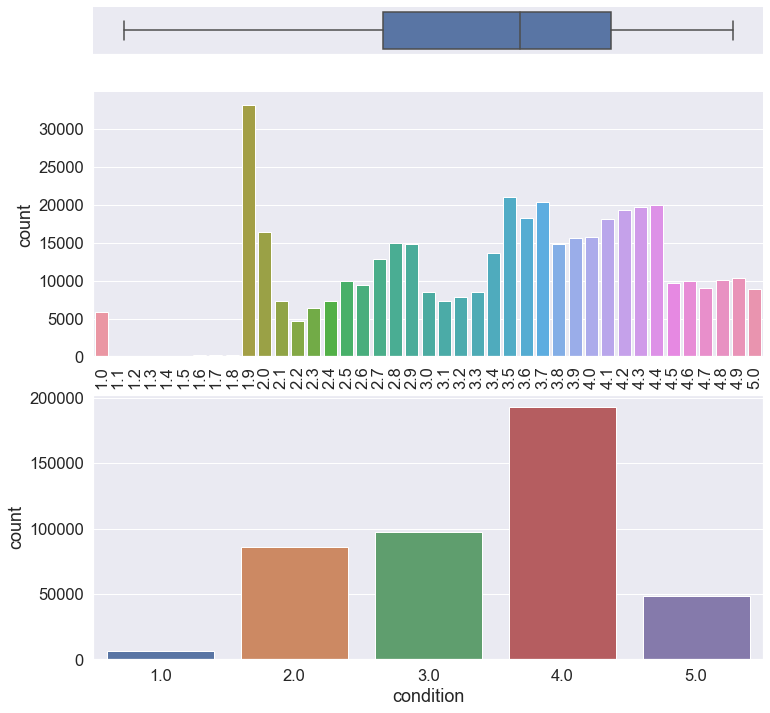

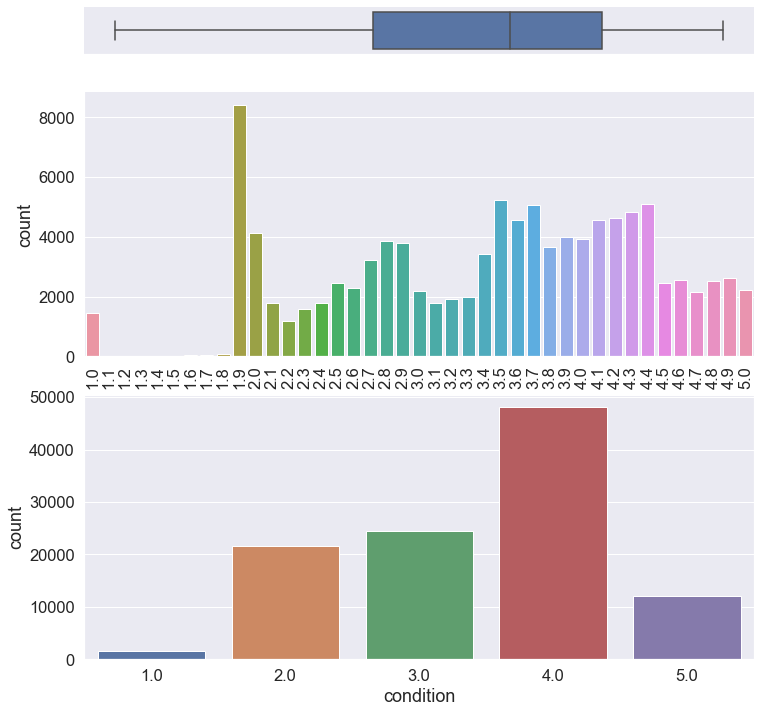

In [21]:
# выводим распределение по техническому состоянию в обучающей  и тестовой выборке
def condition(df):
    f, (ax_1, ax_2, ax_3) = plt.subplots(3, gridspec_kw={"height_ratios": (.15, .85, 0.85)}, figsize=(12,12)) 
    sns.boxplot(x=df['condition'], ax=ax_1) 
    sns.countplot(x=df[ 'condition'], ax=ax_2)
    sns.countplot(x=df[ 'condition'].round(), ax=ax_3)
    ax_1.set(yticks=[], xticks=[], xlabel=None); ax_2.set(xlabel=None)
    sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2) 
    ax_2.tick_params(axis= 'x', labelrotation=90)
                                                                                                             
for i in [df1, df2]:
    condition(i)                                                                                                                                                                                                                      
                    

Распределение логичное, выбросы не обнаружены. Пропуски в количестве 9405 шт. (2%) на обучающей выборке и 2379 шт. (2%) на тестовой заполняем медианнымии значениями. Пропуски на тестовой выборке заполняем медианой из обучающей.

In [22]:
for d in (df1, df2):
    d['condition'] = d['condition'].fillna(df1['condition'].median())
    

### Признак 'sellingprice'

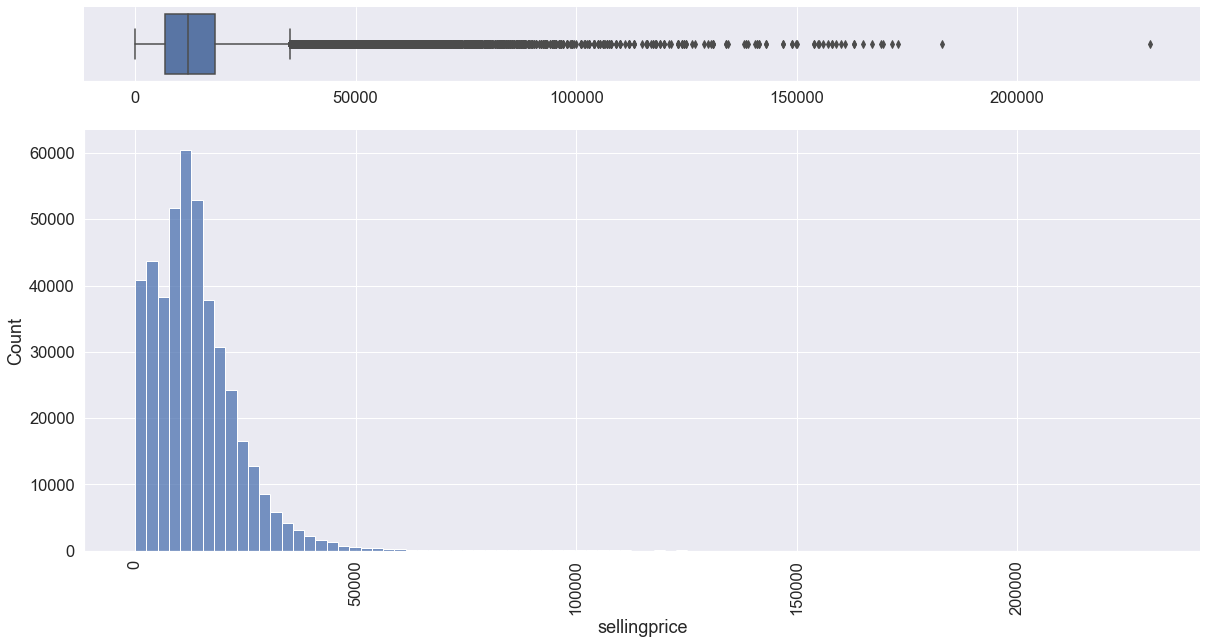

In [23]:
# выводим распределение по стоимости автомобиля в обучающей выборке
f,(ax_1, ax_2) = plt.subplots(2, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(20,10)) 
sns.boxplot(x=df1['sellingprice'], ax=ax_1) 
sns.histplot(x=df1['sellingprice'], ax=ax_2, bins=90)
ax_1.set(yticks=[], xlabel=None)
sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2) 
ax_2.tick_params(axis= 'x', labelrotation=90)
                                                                                                             

In [24]:
# выведем автомобили дороже 100 тыс.
df1.query('sellingprice > 100000')['model'].value_counts()

mercedes-benz g-class suv                      17
land rover range rover suv                     15
rolls-royce ghost sedan                        14
ferrari california convertible                 13
bentley continental gt coupe                    8
bentley continental gtc convertible             8
mercedes-benz s-class sedan                     8
bmw i8 coupe                                    7
audi r8 coupe                                   5
bmw m6 convertible                              5
audi rs 7 sedan                                 5
lamborghini gallardo convertible                4
audi r8 convertible                             3
mercedes-benz sls amg coupe                     3
porsche panamera sedan                          2
porsche cayenne suv                             2
bmw m6 gran coupe sedan                         2
ferrari f430 coupe                              1
aston martin rapide sedan                       1
ferrari 458 italia coupe                        1


In [25]:
# выводим самые дорогие авто
df1.sort_values(by='sellingprice', ascending=False).head()

vin                        model      trim transmission  \
391944  1fmcu9j98eua23833              ford escape suv  titanium    automatic   
423235  zff67nfa1b0178698     ferrari 458 italia coupe      base    automatic   
359053  wddug7kb2fa102347  mercedes-benz s-class sedan   s65 amg    automatic   
26083   sca664s52dux52152      rolls-royce ghost sedan      base    automatic   
291637  sca664s58cux50727      rolls-royce ghost sedan      base    automatic   

        color state  usage  odometer  condition  sellingprice  
391944  green    mo      1     27802        4.3        230000  
423235    red    fl      4     12116        4.6        183000  
359053  white    ca      1      5277        4.1        173000  
26083   white    fl      2      7852        4.2        171500  
291637  black    fl      3     14316        4.5        169500

Новый Ford Escape Titanium стоит от $37000, исправим:

In [26]:
df1.loc[391944, 'sellingprice'] /= 7

Остальные стоимости премиальных марок соответствует действительности.

In [27]:
# выводим самые дешевые авто
df1.sort_values(by='sellingprice').head()

vin                        model  trim transmission  \
137940  wdbuf70j73a269529  mercedes-benz e-class sedan  e500    automatic   
51975   1b4hr48n52f205682            dodge durango suv   slt    automatic   
413352  4a3aj56g1ve148491      mitsubishi galant sedan    es    automatic   
355848  3g5da03l36s512932         buick rendezvous suv    cx    automatic   
18762   1fafp55222a271061            ford taurus sedan   ses          NaN   

         color state  usage  odometer  condition  sellingprice  
137940   black    ga     12    138247        2.1           1.0  
51975   silver    pr     13    145161        1.9         100.0  
413352    gray    ca     18    226034        1.0         100.0  
355848  silver    ms      9    256040        1.0         100.0  
18762   silver    pa     13    132230        1.9         100.0

In [28]:
# удалим авто стоимостью 1$
df1 = df1.query('sellingprice > 1').reset_index(drop=True)

Оставил минимальную стоимость авто в 100$.

### Признак 'model'

In [29]:
# убираем неявные дубликаты
for d in (df1, df2):
    d.loc[d['model']=='dodge tk', 'model']                      = 'dodge'
    d.loc[d['model']=='dot' , 'model']                          = 'dodge'
    d.loc[d['model']=='dodge canada', 'model']                  = 'dodge'
    d.loc[d['model']=='dodge mexico', 'model']                  = 'dodge'
    d.loc[d['model']=='ford truck', 'model']                    = 'ford'
    d.loc[d['model']=='ford tk', 'model']                       = 'ford'
    d.loc[d['model']=='gmc truck', 'model']                     = 'gmc'
    d.loc[d['model']=='landrover', 'model']                     = 'land rover'
    d.loc[d['model']=='mazda tk','model']                       = 'mazda'
    d.loc[d['model']=='mercedes-b', 'model']                    = 'mercedes'
    d.loc[d['model']=='mercedes-benz', 'model']                 = 'mercedes'
    d.loc[d['model']=='daimler ag (sprinter)', 'model']         = 'mercedes'
    d.loc[d['model']=='daimlerchrysler ag/daimler ag', 'model'] = 'mercedes'
    d.loc[d['model']=='mercedes-benz (sprinter)', 'model']      = 'mercedes'
    d.loc[d['model']=='w','model']                              = 'volkswagen'
    d.loc[d['model']=='volkswagen commercial vehicles', 'model']= 'volkswagen'
    d.loc[d['model']=='am', 'model']                            = 'hummer'
    d.loc[d['model']=='bmw m', 'model']                         = 'bmw'
    d.loc[d['model']=='cami', 'model']                          = 'chevrolet'
    d.loc[d['model']=='chevrolet canada', 'model']              = 'chevrolet'
    d.loc[d['model']=='chevrolet mexico', 'model']              = 'chevrolet'
    d.loc[d['model']=='chevrolet usa', 'model']                 = 'chevrolet'
    d.loc[d['model']=='chev truck', 'model']                    = 'chevrolet'
    d.loc[d['model']=='chrysler canada', 'model']               = 'chrysler'
    d.loc[d['model']=='porsche car', 'model']                   = 'porsche'
    d.loc[d['model']=='porsche suv' , 'model']                  = 'porsche'
    d.loc[d['model']=='hyundai tk', 'model']                    = 'hyundai'
    d.loc[d['model']=='lexus canada', 'model']                  = 'lexus'

Пропуски в признаках 'model' и 'trim' около 2%, восстановить нет возможности, заполним 'unknown', чтобы не удалять:

In [30]:
for d in (df1, df2):
    d['model'].fillna('unknown', inplace=True)
    d['trim'].fillna('unknown', inplace=True)

### Признак 'state'

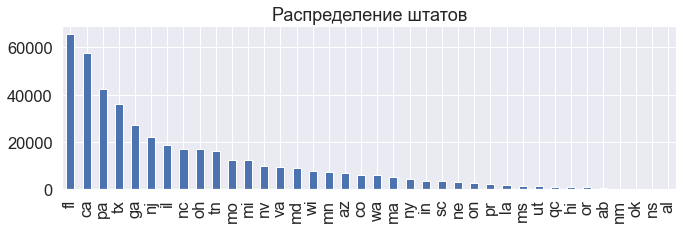

In [31]:
df1['state'].value_counts().plot(kind='bar',figsize=(11,3), title='Распределение штатов');
plt.show()

Дубликатов и пропусков нет. Топ штатов, где совершаются регистрации: Флорида, Калифорния, Пенсильвания.

### Признак 'color'

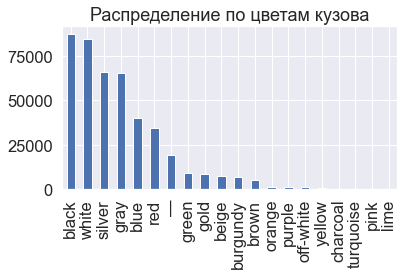

In [32]:
df1['color'].value_counts().plot(kind='bar', figsize= (6,3), title= 'Распределение по цветам кузова');
plt. show()




In [33]:
# переименовываем неизвестное значение "-" в 'unknown'
for d in (df1, df2):
    d.loc[d['color'] == "—", 'color'] = 'unknown'

Пропусков менее 1%, заполним также 'unknown'

In [34]:
for d in (df1, df2):
    d['color'].fillna('unknown', inplace=True)

### Признак 'transmission'

В признаке 12% пропусков. Заполним пропуски 'automatic', так как механическая коробка передач у 3% автомобилей:

In [35]:
for d in (df1, df2):
    d['transmission'].fillna('automatic',inplace=True)

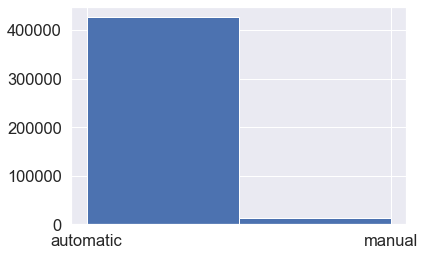

In [36]:
df1['transmission'].hist(bins=2)
plt.show()


In [37]:
# заменим для обучения модели значение automatic на 1, manual - на 0:
for d in (df1, df2):
    d.loc[(d.transmission == 'automatic'), 'transmission'] = 1   
    d.loc[(d.transmission == 'manual'), 'transmission'] = 0
    d.transmission = d.transmission.astype('int8')

Для уменьшения занимаемого обьёма памяти изменим тип данных в количественных признаках.

In [38]:
for d in (df1, df2):
    d['usage'] = d['usage'].astype('int16')
    d['odometer'] = d['odometer'].astype('int32')
df1['sellingprice'] = df1['sellingprice'].astype('int32')


In [39]:
def final (df):
    df.info()
    df.isna().sum()
    display(df.head(3))   
    
for i in [df1, df2]:
    final(i) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440166 entries, 0 to 440165
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           440166 non-null  object 
 1   model         440166 non-null  object 
 2   trim          440166 non-null  object 
 3   transmission  440166 non-null  int8   
 4   color         440166 non-null  object 
 5   state         440166 non-null  object 
 6   usage         440166 non-null  int16  
 7   odometer      440166 non-null  int32  
 8   condition     440166 non-null  float64
 9   sellingprice  440166 non-null  int32  
dtypes: float64(1), int16(1), int32(2), int8(1), object(5)
memory usage: 24.8+ MB


vin                model    trim  transmission  color state  \
0  2fmdk3jc4bba41556        ford edge suv     sel             1  black    md   
1  3fa6p0h75er208976    ford fusion sedan      se             1  black    mo   
2  3n1ab6ap4cl698412  nissan sentra sedan  2.0 sl             1  black    nj   

   usage  odometer  condition  sellingprice  
0      4    111041        4.2         12500  
1      1     31034        3.5         14500  
2      3     35619        2.2          9100

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110060 entries, 0 to 110059
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           110060 non-null  object 
 1   model         110060 non-null  object 
 2   trim          110060 non-null  object 
 3   transmission  110060 non-null  int8   
 4   color         110060 non-null  object 
 5   state         110060 non-null  object 
 6   usage         110060 non-null  int16  
 7   odometer      110060 non-null  int32  
 8   condition     110060 non-null  float64
dtypes: float64(1), int16(1), int32(1), int8(1), object(5)
memory usage: 5.8+ MB


vin                 model  trim  transmission   color state  \
0  1g6dp567450124779    cadillac cts sedan  base             1  silver    ca   
1  1gtw7fca7e1902207  gmc savana cargo van  2500             1   white    pa   
2  jn8az1mw6dw303497     nissan murano suv     s             1    gray    oh   

   usage  odometer  condition  
0     10    116970        2.7  
1      1      6286        4.4  
2      2     11831        4.6

Данные подготовлены к исследовательскому анализу, данные привидены к единому формату. Провели проверку данных на дубликаты, выявлены пропуски в данных. Для чистоты исследования данные с пропусками были заменены. 

In [40]:
# Построим матрицу корреляций phic со стоимостью авто и категориальными переменными.
cols_to_keep = ["sellingprice", "trim", "transmission", "color", "state", "usage", "odometer", "condition" ]     
df_phic = df1[cols_to_keep]
phik_overview = df_phic.phik_matrix()
phik_overview.round(2).head(1)


interval columns not set, guessing: ['sellingprice', 'transmission', 'usage', 'odometer', 'condition']


sellingprice  trim  transmission  color  state  usage  odometer  \
sellingprice           1.0  0.82          0.04   0.18   0.18   0.37      0.24   

              condition  
sellingprice        0.4

Стоимость больше всего коррелирует с количеством лет в использовании, техническим состоянием и пробегом. Менее всего влияет на стоимость тип трансмиссии, так как с автоматической коробкой передач 97%. 

In [41]:
col = ["sellingprice", "color", "state", "usage", "odometer", "condition"]

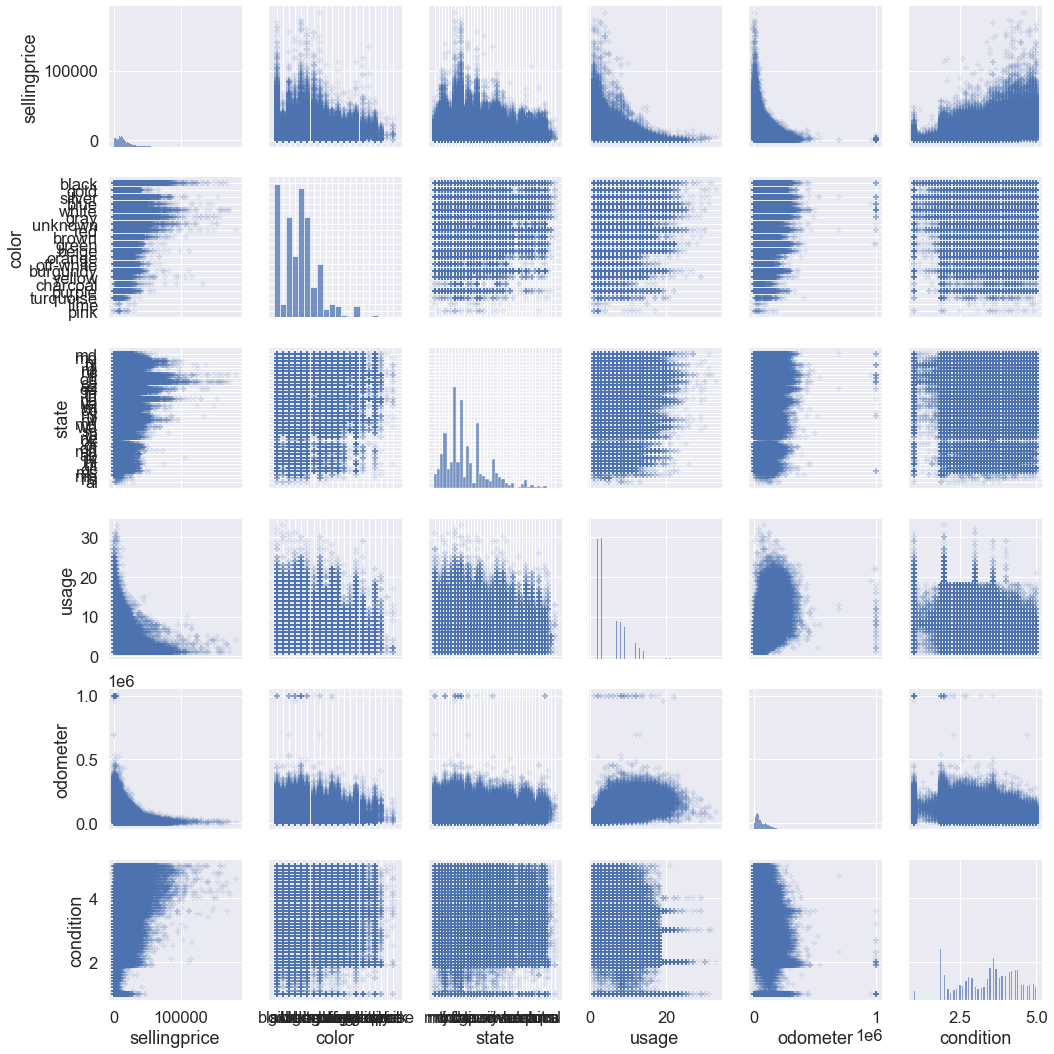

In [42]:
# выведем диаграмму рассеяния 
sns.pairplot(df1, vars=col, plot_kws=dict(alpha=0.1, marker="+", linewidth=2)); 
plt.show()


In [43]:
# посмотрим значения ключевых метрик для имеющихся данных
df1.describe().T

count          mean           std    min      25%      50%  \
transmission  440166.0      0.968859      0.173698    0.0      1.0      1.0   
usage         440166.0      4.888217      3.924004    1.0      2.0      3.0   
odometer      440166.0  68639.112932  53538.929623    1.0  28445.0  52381.0   
condition     440166.0      3.428837      0.940139    1.0      2.7      3.6   
sellingprice  440166.0  13593.155253   9745.739002  100.0   6900.0  12100.0   

                  75%       max  
transmission      1.0       1.0  
usage             7.0      33.0  
odometer      99648.0  999999.0  
condition         4.2       5.0  
sellingprice  18200.0  183000.0

In [44]:
df1["sellingprice"].agg(
    ["min","mean","median","max","std"]).to_frame().T


min          mean   median       max          std
sellingprice  100.0  13593.155253  12100.0  183000.0  9745.739002

transmission  usage  odometer  condition  sellingprice
usage               -0.088  1.000     0.782     -0.535        -0.582
odometer            -0.033  0.782     1.000     -0.533        -0.590
condition            0.030 -0.535    -0.533      1.000         0.530
sellingprice         0.046 -0.582    -0.590      0.530         1.000

transmission  usage  odometer  condition
transmission         1.000 -0.085    -0.028      0.026
usage               -0.085  1.000     0.774     -0.530
odometer            -0.028  0.774     1.000     -0.527
condition            0.026 -0.530    -0.527      1.000

Text(0.5, 106.5, 'Признаки')

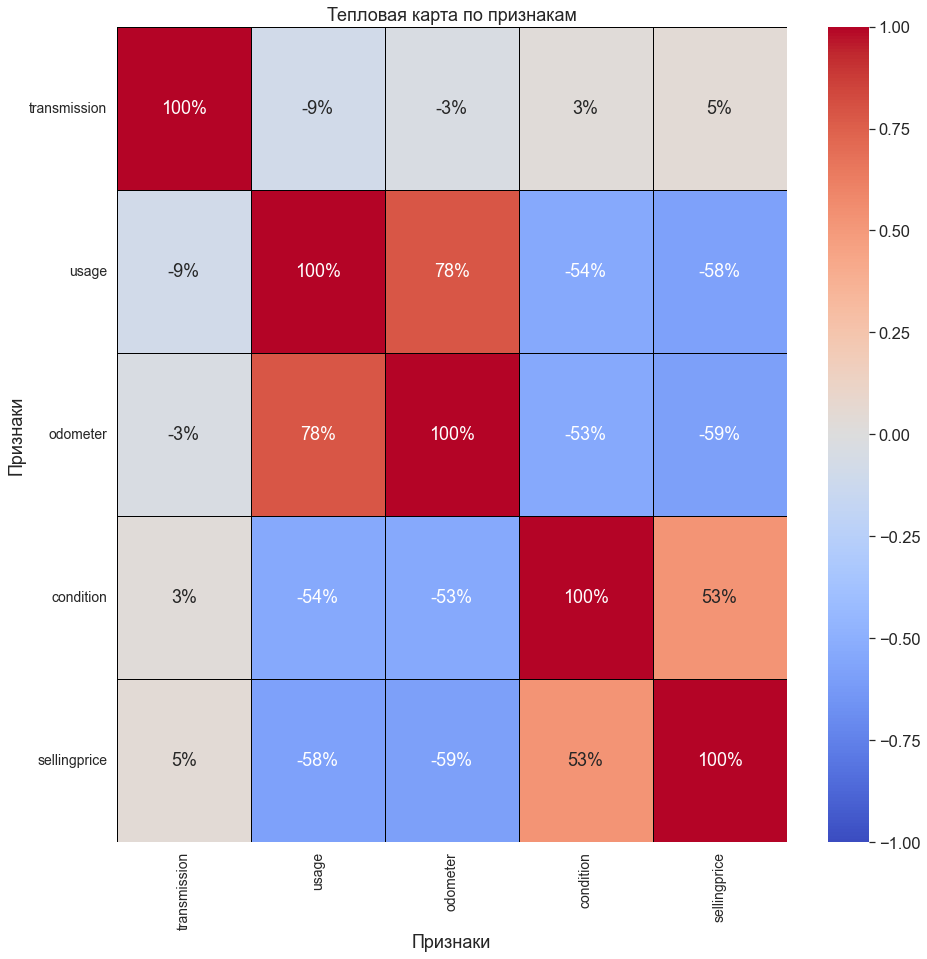

In [45]:
# выведем матрицу корреляций коэффициента Пирсона
[display(data_all.corr().round(3).tail(4)) for data_all in [df1, df2]]

plt.figure(figsize=(15, 15))
sns.heatmap(df1.corr(), annot = True, fmt='.0%', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=1, linecolor='black')
plt.title('Тепловая карта по признакам')
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14, rotation=360)
plt.ylabel('Признаки')
plt.xlabel('Признаки')



## Вывод

Если смотреть корреляцию Пирсона, то цена авто пропорциональна состоянию и обратно пропорционально пробегу и годам использования, что логично.

##  3. Проверка на мультиколлинеарность, отбор финального набора обучающих признаков.

In [46]:
# проверим на мультиколлинеарность количественные признаки
train = df1[df1.select_dtypes(include=['int8','int16','int32','float']).columns]
test = df2[df2.select_dtypes(include=['int8','int16','int32','float']).columns]

In [47]:
# функция для проверки на мультиколлинеарность
def calc_VIF(x):
  vif= pd.DataFrame()
  vif['variables']=x.columns
  vif["VIF"]=[variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
  return(vif)


Наш набор данных очень большой с большим количеством функций, допустимо ограничение VIF в 10. Для небольших наборов данных требуется более консервативный подход, при котором может потребоваться снизить пороговое значение VIF до 5.

In [48]:
# мультиколлинеарность на обучающих данных
calc_VIF(train)

variables        VIF
0  transmission  16.394533
1         usage   6.611583
2      odometer   7.216228
3     condition  14.822365
4  sellingprice   5.049108

In [49]:
# мультиколлинеарность на тестовых данных
calc_VIF(test)

variables        VIF
0  transmission  15.655085
1         usage   6.281681
2      odometer   6.728784
3     condition  11.392454

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>
    
Класс! Интересный ход с проверкой `variance_inflation_factor`!</div>


In [50]:
df1.head(1)

vin          model trim  transmission  color state  usage  \
0  2fmdk3jc4bba41556  ford edge suv  sel             1  black    md      4   

   odometer  condition  sellingprice  
0    111041        4.2         12500

## Вывод

Выбранные признаки в пределах ограничений. Выбранные признаки подойдут для построения модели.

## 4. Выбор и обучение моделей, итоговая оценка качества предсказания лучшей модели.

In [51]:
# выделяем целевой признак и признаки:
target = df1["sellingprice"]
features = df1[['model', 'trim', 'transmission', 'color', 'state',
               'usage', 'odometer', 'condition']]
features_test = df2[['model', 'trim', 'transmission', 'color', 'state',
               'usage', 'odometer', 'condition']]

In [52]:
# выделяем 75% данных для обучающей выборки, остальные данные для валидационной
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size = 0.25, random_state = RANDOM_STATE)

Кодируем категориальные признаки обучающей выборки

In [53]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

features_train_ord = features_train[['model', 'trim', 'color', 'state']]
features_train_ord = pd.DataFrame(encoder.fit_transform(features_train_ord),
                                 columns=features_train_ord.columns,
                                 index=features_train_ord.index)

In [54]:
features_train = features_train.drop(columns=['model', 'trim', 'color', 'state'])

In [55]:
features_train = pd.merge(
    features_train, features_train_ord, left_index=True, right_index=True)

Кодируем категориальные признаки валидационной выборки

In [56]:
features_valid_ord = features_valid[['model', 'trim', 'color', 'state']]
features_valid_ord = pd.DataFrame(encoder.transform(features_valid_ord),
                                 columns=features_valid_ord.columns,
                                 index=features_valid_ord.index)

In [57]:
features_valid = features_valid.drop(columns=['model', 'trim', 'color', 'state'])

In [58]:
features_valid = pd.merge(
    features_valid, features_valid_ord, left_index=True, right_index=True)


Кодируем категориальные признаки тестовой выборки

In [59]:
features_test_ord = features_test[['model', 'trim', 'color', 'state']]
features_test_ord = pd.DataFrame(encoder.transform(features_test_ord),
                                 columns=features_test_ord.columns,
                                 index=features_test_ord.index)

In [60]:
features_test = features_test.drop(columns=['model', 'trim', 'color', 'state'])

In [61]:
features_test = pd.merge(features_test, features_test_ord, left_index=True, right_index=True)


In [62]:
print('Кол-во строк и столбцов в обучающей выборке:', features_train.shape)
print('Кол-во строк и столбцов в валидационной выборке:', features_valid.shape)
print('Кол-во строк и столбцов в тестовой выборке:', features_test.shape)

Кол-во строк и столбцов в обучающей выборке: (330124, 8)
Кол-во строк и столбцов в валидационной выборке: (110042, 8)
Кол-во строк и столбцов в тестовой выборке: (110060, 8)


In [63]:
# масштабируем данные 
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_train)

print('Кол-во строк и столбцов в обучающей выборке:', features_train.shape)
print('Кол-во строк и столбцов в валидационной выборке:', features_valid.shape)

Кол-во строк и столбцов в обучающей выборке: (330124, 8)
Кол-во строк и столбцов в валидационной выборке: (330124, 8)


________

Модель DecisionTreeRegressor

In [64]:
# подбираем гиперпарамаметры для модели дерева решений
param = {'max_depth': range (5,105,10)}
grid_search_dr = GridSearchCV(
    DecisionTreeRegressor(
        random_state=RANDOM_STATE), param, verbose=1, cv=3, scoring = 'neg_mean_absolute_percentage_error')


In [65]:
%%time

# инициализируем модель дерева решений
grid_search_dr.fit(features_train, target_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: user 31.7 s, sys: 309 ms, total: 32 s
Wall time: 32 s


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=12345),
             param_grid={'max_depth': range(5, 105, 10)},
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [66]:
# выводим модель дерева решений с лучшими гиперпараметрами
grid_search_dr.best_estimator_


DecisionTreeRegressor(max_depth=25, random_state=12345)

In [67]:
# MAPE для лучшей модели
grid_search_dr_score = (grid_search_dr.best_score_*-1)
print(grid_search_dr_score)

0.2831452871111486


Модель RandomForestRegressor

In [68]:
# подбираем гиперпарамаметры для модели случайного леса
param = {'max_depth': range(5,30,5),
         'n_estimators':range(1,16,3),
          'min_samples_leaf': range (1,8)}
grid_search_rfr = GridSearchCV(
     RandomForestRegressor(
         random_state=RANDOM_STATE), param, verbose=1, cv=3, scoring = 'neg_mean_absolute_percentage_error')


In [69]:
%%time

# инициализируем модель случайного леса
grid_search_rfr.fit(features_train, target_train)

Fitting 3 folds for each of 175 candidates, totalling 525 fits
CPU times: user 26min 22s, sys: 4.17 s, total: 26min 26s
Wall time: 26min 27s


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': range(5, 30, 5),
                         'min_samples_leaf': range(1, 8),
                         'n_estimators': range(1, 16, 3)},
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [70]:
# выводим модель случайного леса с лучшими гиперпараметрами
grid_search_rfr.best_estimator_


RandomForestRegressor(max_depth=25, min_samples_leaf=2, n_estimators=13,
                      random_state=12345)

In [71]:
# MAPE для лучшей модели
grid_search_rfr_score = (grid_search_rfr.best_score_*-1)
print(grid_search_rfr_score)

0.23552921168924243


_____

Модель CatBoostRegressor

In [72]:
# подбираем гиперпарамаметры для модели CatBoostRegressor
param = {'max_depth': range(1,101,10),
         'iterations':range(10, 1010, 50)}
grid_search_cbr = GridSearchCV(
     CatBoostRegressor(
         random_state=RANDOM_STATE), param, verbose=1, cv=3, scoring = 'neg_mean_absolute_percentage_error')


In [73]:
%%time

# инициализируем модель CatBoostRegressor
grid_search_cbr.fit(features_train, target_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Learning rate set to 0.5
0:	learn: 8551.7584983	total: 65.8ms	remaining: 592ms
1:	learn: 8058.1649001	total: 70.8ms	remaining: 283ms
2:	learn: 7748.8246991	total: 74.9ms	remaining: 175ms
3:	learn: 7553.2429811	total: 78.6ms	remaining: 118ms
4:	learn: 7415.9032542	total: 82.8ms	remaining: 82.8ms
5:	learn: 7337.2224516	total: 87.2ms	remaining: 58.1ms
6:	learn: 7275.6924104	total: 91.7ms	remaining: 39.3ms
7:	learn: 7220.7129294	total: 96.2ms	remaining: 24.1ms
8:	learn: 7178.7222407	total: 100ms	remaining: 11.2ms
9:	learn: 7136.3090828	total: 105ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 8531.8949908	total: 4.41ms	remaining: 39.7ms
1:	learn: 8035.5020380	total: 8.37ms	remaining: 33.5ms
2:	learn: 7725.4197047	total: 12.9ms	remaining: 30.1ms
3:	learn: 7530.5874741	total: 17.3ms	remaining: 26ms
4:	learn: 7392.0348649	total: 21.4ms	remaining: 21.4ms
5:	learn: 7312.3175370	total: 25.6ms	remaining: 17.1ms
6:	learn: 7253.390

43:	learn: 6691.3034202	total: 187ms	remaining: 68.1ms
44:	learn: 6685.6817850	total: 191ms	remaining: 63.7ms
45:	learn: 6676.3724657	total: 196ms	remaining: 59.5ms
46:	learn: 6670.3306912	total: 200ms	remaining: 55.4ms
47:	learn: 6663.8225345	total: 205ms	remaining: 51.2ms
48:	learn: 6658.5654440	total: 209ms	remaining: 46.9ms
49:	learn: 6653.3831670	total: 213ms	remaining: 42.7ms
50:	learn: 6648.0129327	total: 218ms	remaining: 38.4ms
51:	learn: 6642.0471309	total: 222ms	remaining: 34.1ms
52:	learn: 6635.3209749	total: 226ms	remaining: 29.9ms
53:	learn: 6630.0081246	total: 230ms	remaining: 25.6ms
54:	learn: 6624.6120584	total: 235ms	remaining: 21.3ms
55:	learn: 6619.8314632	total: 239ms	remaining: 17ms
56:	learn: 6615.1986558	total: 243ms	remaining: 12.8ms
57:	learn: 6610.6508071	total: 247ms	remaining: 8.51ms
58:	learn: 6606.4305782	total: 251ms	remaining: 4.25ms
59:	learn: 6602.2204138	total: 255ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 8582.1862566	total: 4.56ms	remainin

21:	learn: 4075.1118994	total: 416ms	remaining: 718ms
22:	learn: 4004.7639467	total: 435ms	remaining: 699ms
23:	learn: 3984.1951089	total: 454ms	remaining: 681ms
24:	learn: 3912.3477411	total: 473ms	remaining: 662ms
25:	learn: 3857.5920150	total: 491ms	remaining: 642ms
26:	learn: 3840.8804364	total: 510ms	remaining: 623ms
27:	learn: 3803.3463999	total: 529ms	remaining: 605ms
28:	learn: 3780.1386644	total: 548ms	remaining: 586ms
29:	learn: 3749.3709820	total: 567ms	remaining: 567ms
30:	learn: 3722.0267238	total: 585ms	remaining: 547ms
31:	learn: 3691.5238441	total: 603ms	remaining: 528ms
32:	learn: 3657.8761129	total: 622ms	remaining: 509ms
33:	learn: 3610.6501968	total: 642ms	remaining: 491ms
34:	learn: 3571.5542639	total: 662ms	remaining: 473ms
35:	learn: 3542.2142830	total: 680ms	remaining: 453ms
36:	learn: 3517.2784192	total: 698ms	remaining: 434ms
37:	learn: 3480.9266222	total: 717ms	remaining: 415ms
38:	learn: 3434.9216537	total: 735ms	remaining: 396ms
39:	learn: 3401.4727324	tota

90:	learn: 6513.6809910	total: 386ms	remaining: 80.5ms
91:	learn: 6510.9452691	total: 390ms	remaining: 76.3ms
92:	learn: 6506.8296489	total: 394ms	remaining: 72ms
93:	learn: 6504.0288650	total: 398ms	remaining: 67.8ms
94:	learn: 6501.1223315	total: 402ms	remaining: 63.5ms
95:	learn: 6498.0950545	total: 407ms	remaining: 59.3ms
96:	learn: 6495.1977368	total: 411ms	remaining: 55.1ms
97:	learn: 6492.2094984	total: 415ms	remaining: 50.8ms
98:	learn: 6489.2009064	total: 419ms	remaining: 46.6ms
99:	learn: 6486.5066330	total: 424ms	remaining: 42.4ms
100:	learn: 6482.8302317	total: 428ms	remaining: 38.1ms
101:	learn: 6480.2348791	total: 432ms	remaining: 33.9ms
102:	learn: 6477.3130026	total: 436ms	remaining: 29.6ms
103:	learn: 6474.9453723	total: 440ms	remaining: 25.4ms
104:	learn: 6471.4332482	total: 444ms	remaining: 21.2ms
105:	learn: 6468.8162252	total: 449ms	remaining: 16.9ms
106:	learn: 6466.0226574	total: 453ms	remaining: 12.7ms
107:	learn: 6463.4978619	total: 457ms	remaining: 8.47ms
108:

44:	learn: 6740.7904702	total: 187ms	remaining: 270ms
45:	learn: 6735.1690509	total: 191ms	remaining: 266ms
46:	learn: 6728.7288988	total: 195ms	remaining: 262ms
47:	learn: 6723.1005186	total: 199ms	remaining: 258ms
48:	learn: 6717.4793807	total: 204ms	remaining: 254ms
49:	learn: 6712.8480127	total: 208ms	remaining: 249ms
50:	learn: 6707.3000990	total: 212ms	remaining: 245ms
51:	learn: 6702.7705656	total: 216ms	remaining: 241ms
52:	learn: 6696.8776201	total: 220ms	remaining: 236ms
53:	learn: 6692.5061194	total: 224ms	remaining: 232ms
54:	learn: 6688.0468507	total: 228ms	remaining: 228ms
55:	learn: 6681.9544920	total: 233ms	remaining: 224ms
56:	learn: 6677.3755507	total: 237ms	remaining: 220ms
57:	learn: 6673.1854499	total: 241ms	remaining: 216ms
58:	learn: 6669.0043775	total: 245ms	remaining: 212ms
59:	learn: 6665.6626254	total: 249ms	remaining: 208ms
60:	learn: 6659.6301273	total: 253ms	remaining: 204ms
61:	learn: 6655.6063486	total: 257ms	remaining: 199ms
62:	learn: 6651.6153543	tota

87:	learn: 2743.8302748	total: 1.66s	remaining: 415ms
88:	learn: 2733.6870735	total: 1.68s	remaining: 396ms
89:	learn: 2726.3488761	total: 1.7s	remaining: 377ms
90:	learn: 2713.9263175	total: 1.72s	remaining: 358ms
91:	learn: 2704.9846764	total: 1.73s	remaining: 339ms
92:	learn: 2699.2921264	total: 1.75s	remaining: 320ms
93:	learn: 2688.8380936	total: 1.77s	remaining: 302ms
94:	learn: 2679.7245747	total: 1.79s	remaining: 283ms
95:	learn: 2674.8229190	total: 1.81s	remaining: 264ms
96:	learn: 2664.4792622	total: 1.83s	remaining: 245ms
97:	learn: 2661.4860802	total: 1.85s	remaining: 226ms
98:	learn: 2655.1609717	total: 1.87s	remaining: 207ms
99:	learn: 2645.3715339	total: 1.88s	remaining: 188ms
100:	learn: 2632.6736757	total: 1.9s	remaining: 170ms
101:	learn: 2626.7631020	total: 1.92s	remaining: 151ms
102:	learn: 2616.6985818	total: 1.94s	remaining: 132ms
103:	learn: 2612.7826370	total: 1.96s	remaining: 113ms
104:	learn: 2607.7919609	total: 1.98s	remaining: 94.2ms
105:	learn: 2593.8616927

20:	learn: 4009.3840833	total: 411ms	remaining: 1.74s
21:	learn: 3974.4006986	total: 435ms	remaining: 1.74s
22:	learn: 3928.5517479	total: 457ms	remaining: 1.73s
23:	learn: 3876.4176813	total: 479ms	remaining: 1.72s
24:	learn: 3848.2878873	total: 504ms	remaining: 1.72s
25:	learn: 3830.3684117	total: 528ms	remaining: 1.71s
26:	learn: 3809.0217374	total: 553ms	remaining: 1.7s
27:	learn: 3757.3158494	total: 576ms	remaining: 1.69s
28:	learn: 3718.0161314	total: 604ms	remaining: 1.69s
29:	learn: 3645.3918916	total: 627ms	remaining: 1.67s
30:	learn: 3613.7567081	total: 653ms	remaining: 1.66s
31:	learn: 3582.2365859	total: 675ms	remaining: 1.64s
32:	learn: 3563.7093892	total: 699ms	remaining: 1.63s
33:	learn: 3534.9587911	total: 726ms	remaining: 1.62s
34:	learn: 3515.9741697	total: 754ms	remaining: 1.61s
35:	learn: 3505.9494429	total: 781ms	remaining: 1.6s
36:	learn: 3475.7492507	total: 806ms	remaining: 1.59s
37:	learn: 3457.8332183	total: 828ms	remaining: 1.57s
38:	learn: 3427.3112069	total:

89:	learn: 6527.4909290	total: 381ms	remaining: 296ms
90:	learn: 6524.7465412	total: 385ms	remaining: 292ms
91:	learn: 6521.8678547	total: 390ms	remaining: 288ms
92:	learn: 6518.6578070	total: 394ms	remaining: 284ms
93:	learn: 6515.5639226	total: 398ms	remaining: 279ms
94:	learn: 6513.0976008	total: 402ms	remaining: 275ms
95:	learn: 6509.7612474	total: 406ms	remaining: 271ms
96:	learn: 6507.5256818	total: 411ms	remaining: 267ms
97:	learn: 6505.2539601	total: 415ms	remaining: 262ms
98:	learn: 6502.2283549	total: 419ms	remaining: 258ms
99:	learn: 6499.6802172	total: 424ms	remaining: 254ms
100:	learn: 6496.3093915	total: 428ms	remaining: 250ms
101:	learn: 6493.6600373	total: 432ms	remaining: 246ms
102:	learn: 6491.2048607	total: 436ms	remaining: 241ms
103:	learn: 6488.1471864	total: 441ms	remaining: 237ms
104:	learn: 6485.6469283	total: 446ms	remaining: 233ms
105:	learn: 6483.2813702	total: 450ms	remaining: 229ms
106:	learn: 6480.1996786	total: 454ms	remaining: 225ms
107:	learn: 6477.6209

91:	learn: 6490.5824291	total: 385ms	remaining: 285ms
92:	learn: 6487.7771528	total: 389ms	remaining: 280ms
93:	learn: 6485.0291172	total: 393ms	remaining: 276ms
94:	learn: 6482.0146994	total: 398ms	remaining: 272ms
95:	learn: 6479.2761689	total: 402ms	remaining: 268ms
96:	learn: 6476.6123503	total: 406ms	remaining: 264ms
97:	learn: 6473.8020714	total: 410ms	remaining: 259ms
98:	learn: 6470.8581693	total: 414ms	remaining: 255ms
99:	learn: 6468.1034608	total: 418ms	remaining: 251ms
100:	learn: 6465.7159479	total: 423ms	remaining: 247ms
101:	learn: 6463.3162967	total: 427ms	remaining: 243ms
102:	learn: 6460.4295741	total: 431ms	remaining: 239ms
103:	learn: 6458.0037130	total: 436ms	remaining: 235ms
104:	learn: 6455.5471561	total: 440ms	remaining: 230ms
105:	learn: 6452.9788807	total: 444ms	remaining: 226ms
106:	learn: 6450.4353140	total: 448ms	remaining: 222ms
107:	learn: 6447.7908818	total: 452ms	remaining: 218ms
108:	learn: 6445.0695459	total: 457ms	remaining: 214ms
109:	learn: 6442.61

91:	learn: 6551.1498675	total: 386ms	remaining: 285ms
92:	learn: 6548.4246877	total: 390ms	remaining: 281ms
93:	learn: 6545.9080613	total: 394ms	remaining: 277ms
94:	learn: 6543.1195584	total: 398ms	remaining: 272ms
95:	learn: 6540.5770941	total: 402ms	remaining: 268ms
96:	learn: 6537.7926177	total: 406ms	remaining: 264ms
97:	learn: 6535.0919040	total: 410ms	remaining: 260ms
98:	learn: 6532.7436468	total: 415ms	remaining: 256ms
99:	learn: 6530.0419427	total: 419ms	remaining: 251ms
100:	learn: 6526.7276644	total: 423ms	remaining: 247ms
101:	learn: 6524.5539124	total: 427ms	remaining: 243ms
102:	learn: 6521.9656889	total: 431ms	remaining: 239ms
103:	learn: 6519.5282292	total: 435ms	remaining: 234ms
104:	learn: 6517.2304833	total: 439ms	remaining: 230ms
105:	learn: 6514.7323886	total: 444ms	remaining: 226ms
106:	learn: 6512.4484815	total: 448ms	remaining: 222ms
107:	learn: 6510.1370755	total: 452ms	remaining: 218ms
108:	learn: 6507.9342063	total: 456ms	remaining: 213ms
109:	learn: 6505.74

87:	learn: 2826.8411903	total: 1.66s	remaining: 1.35s
88:	learn: 2820.5209407	total: 1.68s	remaining: 1.34s
89:	learn: 2813.8227571	total: 1.69s	remaining: 1.32s
90:	learn: 2809.8627425	total: 1.71s	remaining: 1.3s
91:	learn: 2800.1063153	total: 1.73s	remaining: 1.28s
92:	learn: 2793.3540959	total: 1.75s	remaining: 1.26s
93:	learn: 2781.8710037	total: 1.77s	remaining: 1.24s
94:	learn: 2767.1940477	total: 1.79s	remaining: 1.22s
95:	learn: 2755.9414511	total: 1.8s	remaining: 1.2s
96:	learn: 2747.3602866	total: 1.82s	remaining: 1.18s
97:	learn: 2741.0713816	total: 1.84s	remaining: 1.17s
98:	learn: 2731.0378389	total: 1.86s	remaining: 1.15s
99:	learn: 2724.7712513	total: 1.88s	remaining: 1.13s
100:	learn: 2714.9691736	total: 1.9s	remaining: 1.11s
101:	learn: 2703.6907765	total: 1.92s	remaining: 1.09s
102:	learn: 2699.6170220	total: 1.94s	remaining: 1.07s
103:	learn: 2695.6968475	total: 1.95s	remaining: 1.05s
104:	learn: 2691.0473438	total: 1.97s	remaining: 1.03s
105:	learn: 2685.3168260	to

87:	learn: 2761.9723920	total: 1.65s	remaining: 1.35s
88:	learn: 2756.0555463	total: 1.67s	remaining: 1.33s
89:	learn: 2746.8584887	total: 1.69s	remaining: 1.31s
90:	learn: 2737.2678994	total: 1.71s	remaining: 1.3s
91:	learn: 2726.2509892	total: 1.73s	remaining: 1.28s
92:	learn: 2711.8063581	total: 1.75s	remaining: 1.26s
93:	learn: 2704.0950577	total: 1.76s	remaining: 1.24s
94:	learn: 2693.2674169	total: 1.78s	remaining: 1.22s
95:	learn: 2685.7558333	total: 1.8s	remaining: 1.2s
96:	learn: 2677.1541004	total: 1.82s	remaining: 1.18s
97:	learn: 2666.8751824	total: 1.84s	remaining: 1.17s
98:	learn: 2662.7051198	total: 1.86s	remaining: 1.15s
99:	learn: 2659.4385940	total: 1.88s	remaining: 1.13s
100:	learn: 2653.7886394	total: 1.9s	remaining: 1.11s
101:	learn: 2648.1892762	total: 1.92s	remaining: 1.09s
102:	learn: 2640.2666430	total: 1.94s	remaining: 1.07s
103:	learn: 2636.5136738	total: 1.96s	remaining: 1.05s
104:	learn: 2627.7049601	total: 1.98s	remaining: 1.03s
105:	learn: 2618.4995385	to

87:	learn: 2842.7323880	total: 1.66s	remaining: 1.36s
88:	learn: 2829.6871998	total: 1.68s	remaining: 1.34s
89:	learn: 2813.8061801	total: 1.7s	remaining: 1.32s
90:	learn: 2806.6316334	total: 1.72s	remaining: 1.3s
91:	learn: 2801.0060910	total: 1.74s	remaining: 1.28s
92:	learn: 2795.9423206	total: 1.76s	remaining: 1.27s
93:	learn: 2790.2669002	total: 1.78s	remaining: 1.25s
94:	learn: 2782.5569286	total: 1.8s	remaining: 1.23s
95:	learn: 2775.8240470	total: 1.82s	remaining: 1.21s
96:	learn: 2761.2227670	total: 1.84s	remaining: 1.19s
97:	learn: 2753.7849354	total: 1.85s	remaining: 1.17s
98:	learn: 2749.4857363	total: 1.87s	remaining: 1.15s
99:	learn: 2745.6462324	total: 1.89s	remaining: 1.14s
100:	learn: 2739.9983043	total: 1.91s	remaining: 1.12s
101:	learn: 2733.3762434	total: 1.94s	remaining: 1.1s
102:	learn: 2722.9123574	total: 1.95s	remaining: 1.08s
103:	learn: 2714.9754904	total: 1.97s	remaining: 1.06s
104:	learn: 2705.7886957	total: 1.99s	remaining: 1.04s
105:	learn: 2696.2749601	to

90:	learn: 6559.3341922	total: 384ms	remaining: 502ms
91:	learn: 6556.3314558	total: 388ms	remaining: 497ms
92:	learn: 6553.8313266	total: 392ms	remaining: 493ms
93:	learn: 6551.4145736	total: 396ms	remaining: 489ms
94:	learn: 6548.3472016	total: 400ms	remaining: 484ms
95:	learn: 6545.8096322	total: 404ms	remaining: 480ms
96:	learn: 6543.4463619	total: 408ms	remaining: 476ms
97:	learn: 6540.7894950	total: 413ms	remaining: 472ms
98:	learn: 6538.2827390	total: 417ms	remaining: 467ms
99:	learn: 6535.1756037	total: 421ms	remaining: 463ms
100:	learn: 6532.7768619	total: 425ms	remaining: 459ms
101:	learn: 6530.3179913	total: 429ms	remaining: 454ms
102:	learn: 6527.8174156	total: 433ms	remaining: 450ms
103:	learn: 6525.3195761	total: 437ms	remaining: 445ms
104:	learn: 6523.1271939	total: 441ms	remaining: 441ms
105:	learn: 6520.9174348	total: 445ms	remaining: 436ms
106:	learn: 6518.8102967	total: 449ms	remaining: 432ms
107:	learn: 6516.6861759	total: 453ms	remaining: 428ms
108:	learn: 6514.014

43:	learn: 6728.1802049	total: 190ms	remaining: 715ms
44:	learn: 6722.0534887	total: 194ms	remaining: 711ms
45:	learn: 6715.7271778	total: 198ms	remaining: 706ms
46:	learn: 6709.4954262	total: 202ms	remaining: 701ms
47:	learn: 6703.7014242	total: 207ms	remaining: 697ms
48:	learn: 6697.7902327	total: 211ms	remaining: 692ms
49:	learn: 6692.1668875	total: 215ms	remaining: 687ms
50:	learn: 6686.8067495	total: 219ms	remaining: 684ms
51:	learn: 6681.6372669	total: 224ms	remaining: 680ms
52:	learn: 6676.6540847	total: 228ms	remaining: 675ms
53:	learn: 6670.8335155	total: 232ms	remaining: 669ms
54:	learn: 6665.3598033	total: 236ms	remaining: 664ms
55:	learn: 6660.4493017	total: 240ms	remaining: 660ms
56:	learn: 6655.4680229	total: 244ms	remaining: 655ms
57:	learn: 6650.6773149	total: 249ms	remaining: 652ms
58:	learn: 6646.3182943	total: 254ms	remaining: 649ms
59:	learn: 6641.2866611	total: 258ms	remaining: 646ms
60:	learn: 6635.7831295	total: 263ms	remaining: 641ms
61:	learn: 6631.1792015	tota

Learning rate set to 0.341463
0:	learn: 8889.4904334	total: 4.4ms	remaining: 920ms
1:	learn: 8388.4694416	total: 8.78ms	remaining: 913ms
2:	learn: 8058.7618479	total: 13.2ms	remaining: 909ms
3:	learn: 7835.0931597	total: 17.5ms	remaining: 904ms
4:	learn: 7695.0586087	total: 22ms	remaining: 903ms
5:	learn: 7588.7187163	total: 26.3ms	remaining: 893ms
6:	learn: 7482.2969599	total: 30.4ms	remaining: 883ms
7:	learn: 7405.6895728	total: 34.6ms	remaining: 874ms
8:	learn: 7345.2092687	total: 38.9ms	remaining: 868ms
9:	learn: 7298.5043777	total: 43.2ms	remaining: 863ms
10:	learn: 7252.0669901	total: 47.2ms	remaining: 854ms
11:	learn: 7213.9486007	total: 51.6ms	remaining: 851ms
12:	learn: 7180.0076223	total: 55.8ms	remaining: 845ms
13:	learn: 7152.5036977	total: 59.9ms	remaining: 838ms
14:	learn: 7127.9455610	total: 64.4ms	remaining: 837ms
15:	learn: 7103.7814913	total: 68.5ms	remaining: 831ms
16:	learn: 7082.8953145	total: 72.9ms	remaining: 828ms
17:	learn: 7065.9480599	total: 77.3ms	remaining:

179:	learn: 6417.3986672	total: 777ms	remaining: 129ms
180:	learn: 6415.8314295	total: 781ms	remaining: 125ms
181:	learn: 6414.2095174	total: 785ms	remaining: 121ms
182:	learn: 6412.6729022	total: 789ms	remaining: 116ms
183:	learn: 6410.9839967	total: 794ms	remaining: 112ms
184:	learn: 6409.3851194	total: 798ms	remaining: 108ms
185:	learn: 6407.9070171	total: 802ms	remaining: 104ms
186:	learn: 6406.5358963	total: 806ms	remaining: 99.2ms
187:	learn: 6405.1896126	total: 810ms	remaining: 94.8ms
188:	learn: 6403.8146113	total: 814ms	remaining: 90.5ms
189:	learn: 6402.5282313	total: 818ms	remaining: 86.2ms
190:	learn: 6401.2688443	total: 822ms	remaining: 81.8ms
191:	learn: 6400.0725902	total: 827ms	remaining: 77.5ms
192:	learn: 6398.7723583	total: 831ms	remaining: 73.2ms
193:	learn: 6397.1630129	total: 835ms	remaining: 68.9ms
194:	learn: 6395.8088637	total: 839ms	remaining: 64.5ms
195:	learn: 6394.1887282	total: 844ms	remaining: 60.3ms
196:	learn: 6392.8576358	total: 848ms	remaining: 55.9ms

128:	learn: 2659.5028887	total: 2.5s	remaining: 1.57s
129:	learn: 2652.9430752	total: 2.52s	remaining: 1.55s
130:	learn: 2648.9447113	total: 2.54s	remaining: 1.53s
131:	learn: 2643.6516107	total: 2.56s	remaining: 1.51s
132:	learn: 2637.7007909	total: 2.58s	remaining: 1.49s
133:	learn: 2628.8527219	total: 2.6s	remaining: 1.47s
134:	learn: 2623.8596807	total: 2.62s	remaining: 1.45s
135:	learn: 2619.8315462	total: 2.63s	remaining: 1.43s
136:	learn: 2616.4364874	total: 2.65s	remaining: 1.41s
137:	learn: 2611.6034155	total: 2.67s	remaining: 1.39s
138:	learn: 2608.4255705	total: 2.69s	remaining: 1.38s
139:	learn: 2605.3853420	total: 2.71s	remaining: 1.35s
140:	learn: 2597.5686351	total: 2.73s	remaining: 1.34s
141:	learn: 2592.5045157	total: 2.75s	remaining: 1.32s
142:	learn: 2588.3555325	total: 2.77s	remaining: 1.3s
143:	learn: 2584.8758800	total: 2.79s	remaining: 1.28s
144:	learn: 2578.8841435	total: 2.81s	remaining: 1.26s
145:	learn: 2574.0827023	total: 2.82s	remaining: 1.24s
146:	learn: 2

76:	learn: 3058.6924672	total: 1.48s	remaining: 2.56s
77:	learn: 3048.7983952	total: 1.5s	remaining: 2.54s
78:	learn: 3042.8607515	total: 1.52s	remaining: 2.52s
79:	learn: 3026.7284036	total: 1.54s	remaining: 2.5s
80:	learn: 3007.2136427	total: 1.56s	remaining: 2.48s
81:	learn: 3000.2508764	total: 1.58s	remaining: 2.46s
82:	learn: 2990.0742080	total: 1.59s	remaining: 2.44s
83:	learn: 2986.0628762	total: 1.61s	remaining: 2.42s
84:	learn: 2977.9371280	total: 1.63s	remaining: 2.4s
85:	learn: 2971.7200907	total: 1.65s	remaining: 2.38s
86:	learn: 2962.3790808	total: 1.67s	remaining: 2.36s
87:	learn: 2956.3388199	total: 1.69s	remaining: 2.34s
88:	learn: 2949.7836382	total: 1.71s	remaining: 2.32s
89:	learn: 2943.1917052	total: 1.73s	remaining: 2.3s
90:	learn: 2924.6240210	total: 1.75s	remaining: 2.28s
91:	learn: 2919.0674769	total: 1.76s	remaining: 2.26s
92:	learn: 2914.5478474	total: 1.78s	remaining: 2.25s
93:	learn: 2897.8000880	total: 1.8s	remaining: 2.23s
94:	learn: 2886.1761450	total: 1.

21:	learn: 4433.0261488	total: 425ms	remaining: 3.63s
22:	learn: 4389.1875109	total: 444ms	remaining: 3.61s
23:	learn: 4367.1422712	total: 464ms	remaining: 3.59s
24:	learn: 4296.3494780	total: 482ms	remaining: 3.57s
25:	learn: 4259.0587514	total: 501ms	remaining: 3.55s
26:	learn: 4221.3068699	total: 520ms	remaining: 3.52s
27:	learn: 4174.4753987	total: 538ms	remaining: 3.5s
28:	learn: 4152.0000737	total: 558ms	remaining: 3.48s
29:	learn: 4121.5013565	total: 578ms	remaining: 3.46s
30:	learn: 4061.0980030	total: 596ms	remaining: 3.44s
31:	learn: 4011.6695635	total: 615ms	remaining: 3.42s
32:	learn: 3971.9108436	total: 632ms	remaining: 3.39s
33:	learn: 3952.4207757	total: 652ms	remaining: 3.38s
34:	learn: 3929.3995462	total: 672ms	remaining: 3.36s
35:	learn: 3892.5624240	total: 691ms	remaining: 3.34s
36:	learn: 3872.3451509	total: 709ms	remaining: 3.32s
37:	learn: 3855.2812759	total: 728ms	remaining: 3.29s
38:	learn: 3837.6415866	total: 746ms	remaining: 3.27s
39:	learn: 3814.2543100	total

175:	learn: 2470.8472988	total: 3.33s	remaining: 644ms
176:	learn: 2468.3346144	total: 3.35s	remaining: 625ms
177:	learn: 2466.6853726	total: 3.37s	remaining: 606ms
178:	learn: 2463.8890127	total: 3.39s	remaining: 587ms
179:	learn: 2457.5500185	total: 3.41s	remaining: 568ms
180:	learn: 2455.4313155	total: 3.43s	remaining: 549ms
181:	learn: 2453.0505608	total: 3.45s	remaining: 530ms
182:	learn: 2449.5541066	total: 3.47s	remaining: 511ms
183:	learn: 2445.1536879	total: 3.48s	remaining: 492ms
184:	learn: 2440.2141863	total: 3.5s	remaining: 473ms
185:	learn: 2434.2715540	total: 3.52s	remaining: 455ms
186:	learn: 2430.6086550	total: 3.54s	remaining: 436ms
187:	learn: 2425.1280123	total: 3.56s	remaining: 417ms
188:	learn: 2420.7961231	total: 3.58s	remaining: 398ms
189:	learn: 2416.4921257	total: 3.6s	remaining: 379ms
190:	learn: 2415.0588744	total: 3.62s	remaining: 360ms
191:	learn: 2410.8694130	total: 3.63s	remaining: 341ms
192:	learn: 2406.7252271	total: 3.65s	remaining: 322ms
193:	learn: 

137:	learn: 6489.6009089	total: 579ms	remaining: 512ms
138:	learn: 6487.6618610	total: 583ms	remaining: 507ms
139:	learn: 6485.8653922	total: 587ms	remaining: 503ms
140:	learn: 6483.7828165	total: 592ms	remaining: 499ms
141:	learn: 6482.0913353	total: 596ms	remaining: 496ms
142:	learn: 6480.2962249	total: 601ms	remaining: 492ms
143:	learn: 6478.6470712	total: 605ms	remaining: 488ms
144:	learn: 6477.0429085	total: 610ms	remaining: 484ms
145:	learn: 6475.4865532	total: 614ms	remaining: 480ms
146:	learn: 6473.8466264	total: 618ms	remaining: 475ms
147:	learn: 6471.9193562	total: 622ms	remaining: 471ms
148:	learn: 6470.2519964	total: 627ms	remaining: 467ms
149:	learn: 6468.3628570	total: 631ms	remaining: 463ms
150:	learn: 6466.7952706	total: 635ms	remaining: 458ms
151:	learn: 6465.3116609	total: 639ms	remaining: 454ms
152:	learn: 6463.6109200	total: 643ms	remaining: 450ms
153:	learn: 6461.8083889	total: 647ms	remaining: 446ms
154:	learn: 6460.1872686	total: 651ms	remaining: 441ms
155:	learn

43:	learn: 6776.7418318	total: 186ms	remaining: 913ms
44:	learn: 6770.7583131	total: 191ms	remaining: 910ms
45:	learn: 6764.5786178	total: 195ms	remaining: 906ms
46:	learn: 6759.2284588	total: 199ms	remaining: 904ms
47:	learn: 6753.5649015	total: 204ms	remaining: 901ms
48:	learn: 6745.4067495	total: 208ms	remaining: 897ms
49:	learn: 6739.6085386	total: 213ms	remaining: 893ms
50:	learn: 6733.9539081	total: 217ms	remaining: 887ms
51:	learn: 6726.9286447	total: 221ms	remaining: 884ms
52:	learn: 6721.4958954	total: 225ms	remaining: 879ms
53:	learn: 6715.4992929	total: 230ms	remaining: 876ms
54:	learn: 6710.4418887	total: 234ms	remaining: 872ms
55:	learn: 6705.1393637	total: 238ms	remaining: 867ms
56:	learn: 6699.5701987	total: 242ms	remaining: 862ms
57:	learn: 6694.8776652	total: 246ms	remaining: 858ms
58:	learn: 6690.2774933	total: 250ms	remaining: 853ms
59:	learn: 6685.8324941	total: 255ms	remaining: 848ms
60:	learn: 6680.3148839	total: 259ms	remaining: 844ms
61:	learn: 6675.9061960	tota

231:	learn: 6323.2925707	total: 973ms	remaining: 117ms
232:	learn: 6322.0797969	total: 977ms	remaining: 113ms
233:	learn: 6321.0440596	total: 982ms	remaining: 109ms
234:	learn: 6319.9794185	total: 986ms	remaining: 105ms
235:	learn: 6318.9358823	total: 994ms	remaining: 101ms
236:	learn: 6317.9332186	total: 999ms	remaining: 96.9ms
237:	learn: 6316.6272970	total: 1s	remaining: 92.8ms
238:	learn: 6315.5989469	total: 1.01s	remaining: 88.5ms
239:	learn: 6314.3038074	total: 1.01s	remaining: 84.3ms
240:	learn: 6313.2651762	total: 1.01s	remaining: 80.1ms
241:	learn: 6311.9522287	total: 1.02s	remaining: 75.9ms
242:	learn: 6310.8724566	total: 1.02s	remaining: 71.7ms
243:	learn: 6309.6616066	total: 1.03s	remaining: 67.4ms
244:	learn: 6308.5779701	total: 1.03s	remaining: 63.2ms
245:	learn: 6307.4363345	total: 1.04s	remaining: 59ms
246:	learn: 6306.3717539	total: 1.04s	remaining: 54.8ms
247:	learn: 6305.1968098	total: 1.04s	remaining: 50.6ms
248:	learn: 6304.0853229	total: 1.05s	remaining: 46.4ms
24

138:	learn: 6519.9624767	total: 584ms	remaining: 509ms
139:	learn: 6518.1361335	total: 588ms	remaining: 504ms
140:	learn: 6516.4196016	total: 593ms	remaining: 500ms
141:	learn: 6514.7386816	total: 597ms	remaining: 497ms
142:	learn: 6513.0655659	total: 602ms	remaining: 492ms
143:	learn: 6511.3217927	total: 606ms	remaining: 488ms
144:	learn: 6509.6710319	total: 610ms	remaining: 483ms
145:	learn: 6508.0340616	total: 614ms	remaining: 479ms
146:	learn: 6506.4826956	total: 618ms	remaining: 475ms
147:	learn: 6504.9320924	total: 622ms	remaining: 471ms
148:	learn: 6502.7177613	total: 626ms	remaining: 467ms
149:	learn: 6501.1714170	total: 631ms	remaining: 462ms
150:	learn: 6499.3265051	total: 635ms	remaining: 458ms
151:	learn: 6497.8593414	total: 639ms	remaining: 454ms
152:	learn: 6495.9808221	total: 643ms	remaining: 450ms
153:	learn: 6494.2848598	total: 648ms	remaining: 446ms
154:	learn: 6492.5674879	total: 652ms	remaining: 441ms
155:	learn: 6490.9701375	total: 656ms	remaining: 437ms
156:	learn

32:	learn: 4138.1509397	total: 617ms	remaining: 4.24s
33:	learn: 4092.2249946	total: 636ms	remaining: 4.23s
34:	learn: 4045.7540275	total: 655ms	remaining: 4.21s
35:	learn: 4013.2455856	total: 673ms	remaining: 4.19s
36:	learn: 3985.3513194	total: 693ms	remaining: 4.18s
37:	learn: 3972.8516834	total: 712ms	remaining: 4.16s
38:	learn: 3941.8953496	total: 730ms	remaining: 4.14s
39:	learn: 3911.7593802	total: 749ms	remaining: 4.12s
40:	learn: 3899.8981801	total: 768ms	remaining: 4.1s
41:	learn: 3886.6859367	total: 787ms	remaining: 4.08s
42:	learn: 3871.9481316	total: 806ms	remaining: 4.07s
43:	learn: 3852.1747571	total: 824ms	remaining: 4.04s
44:	learn: 3810.1050069	total: 844ms	remaining: 4.03s
45:	learn: 3769.5169490	total: 863ms	remaining: 4.01s
46:	learn: 3753.7952127	total: 882ms	remaining: 4s
47:	learn: 3745.8350337	total: 901ms	remaining: 3.98s
48:	learn: 3715.0273537	total: 920ms	remaining: 3.96s
49:	learn: 3698.8784042	total: 938ms	remaining: 3.94s
50:	learn: 3672.7344205	total: 9

186:	learn: 2506.0305697	total: 3.53s	remaining: 1.38s
187:	learn: 2502.9889878	total: 3.55s	remaining: 1.36s
188:	learn: 2498.7645635	total: 3.57s	remaining: 1.34s
189:	learn: 2494.0115292	total: 3.59s	remaining: 1.32s
190:	learn: 2489.8560549	total: 3.61s	remaining: 1.3s
191:	learn: 2486.3668953	total: 3.63s	remaining: 1.28s
192:	learn: 2483.5857735	total: 3.65s	remaining: 1.26s
193:	learn: 2480.6860872	total: 3.67s	remaining: 1.25s
194:	learn: 2478.1902130	total: 3.68s	remaining: 1.23s
195:	learn: 2475.1394270	total: 3.7s	remaining: 1.21s
196:	learn: 2472.0816102	total: 3.72s	remaining: 1.19s
197:	learn: 2468.6207354	total: 3.74s	remaining: 1.17s
198:	learn: 2465.6554900	total: 3.76s	remaining: 1.15s
199:	learn: 2461.7578851	total: 3.78s	remaining: 1.13s
200:	learn: 2459.6750716	total: 3.8s	remaining: 1.11s
201:	learn: 2457.5746868	total: 3.82s	remaining: 1.09s
202:	learn: 2454.8003361	total: 3.84s	remaining: 1.08s
203:	learn: 2452.5375547	total: 3.86s	remaining: 1.06s
204:	learn: 2

87:	learn: 3088.1660801	total: 1.65s	remaining: 3.23s
88:	learn: 3082.1258454	total: 1.67s	remaining: 3.21s
89:	learn: 3071.6401045	total: 1.69s	remaining: 3.2s
90:	learn: 3062.6028112	total: 1.71s	remaining: 3.18s
91:	learn: 3056.0531114	total: 1.74s	remaining: 3.17s
92:	learn: 3037.2144348	total: 1.75s	remaining: 3.15s
93:	learn: 3024.5102624	total: 1.77s	remaining: 3.13s
94:	learn: 3015.7406526	total: 1.79s	remaining: 3.12s
95:	learn: 3001.3817923	total: 1.81s	remaining: 3.1s
96:	learn: 2992.3869644	total: 1.83s	remaining: 3.08s
97:	learn: 2976.3509490	total: 1.85s	remaining: 3.06s
98:	learn: 2972.6519044	total: 1.87s	remaining: 3.04s
99:	learn: 2964.5423744	total: 1.89s	remaining: 3.02s
100:	learn: 2957.1973844	total: 1.91s	remaining: 3s
101:	learn: 2947.2825351	total: 1.93s	remaining: 2.99s
102:	learn: 2935.7982665	total: 1.95s	remaining: 2.97s
103:	learn: 2929.2360724	total: 1.96s	remaining: 2.95s
104:	learn: 2926.4398979	total: 1.98s	remaining: 2.93s
105:	learn: 2915.9304939	tot

241:	learn: 2313.4201434	total: 4.58s	remaining: 341ms
242:	learn: 2310.6650012	total: 4.6s	remaining: 322ms
243:	learn: 2307.2748004	total: 4.62s	remaining: 303ms
244:	learn: 2305.3848837	total: 4.64s	remaining: 284ms
245:	learn: 2302.9414113	total: 4.66s	remaining: 265ms
246:	learn: 2301.1760156	total: 4.67s	remaining: 246ms
247:	learn: 2298.2982921	total: 4.69s	remaining: 227ms
248:	learn: 2297.0112206	total: 4.71s	remaining: 208ms
249:	learn: 2293.6885984	total: 4.73s	remaining: 189ms
250:	learn: 2292.3773642	total: 4.75s	remaining: 170ms
251:	learn: 2289.6155274	total: 4.76s	remaining: 151ms
252:	learn: 2287.7868279	total: 4.78s	remaining: 132ms
253:	learn: 2284.7660382	total: 4.8s	remaining: 113ms
254:	learn: 2282.0395437	total: 4.82s	remaining: 94.5ms
255:	learn: 2279.9466050	total: 4.84s	remaining: 75.6ms
256:	learn: 2278.1593414	total: 4.85s	remaining: 56.7ms
257:	learn: 2273.9206210	total: 4.87s	remaining: 37.8ms
258:	learn: 2270.7879003	total: 4.89s	remaining: 18.9ms
259:	le

142:	learn: 2749.9931762	total: 2.69s	remaining: 2.21s
143:	learn: 2744.9078475	total: 2.71s	remaining: 2.19s
144:	learn: 2738.4738946	total: 2.73s	remaining: 2.17s
145:	learn: 2729.6671574	total: 2.75s	remaining: 2.15s
146:	learn: 2722.6827101	total: 2.77s	remaining: 2.13s
147:	learn: 2712.9428263	total: 2.79s	remaining: 2.11s
148:	learn: 2708.9902021	total: 2.81s	remaining: 2.09s
149:	learn: 2704.7964949	total: 2.83s	remaining: 2.07s
150:	learn: 2700.5564173	total: 2.85s	remaining: 2.06s
151:	learn: 2692.8746054	total: 2.87s	remaining: 2.04s
152:	learn: 2689.7541212	total: 2.88s	remaining: 2.02s
153:	learn: 2681.9256923	total: 2.9s	remaining: 2s
154:	learn: 2676.5546708	total: 2.92s	remaining: 1.98s
155:	learn: 2673.3887246	total: 2.94s	remaining: 1.96s
156:	learn: 2669.4449412	total: 2.96s	remaining: 1.94s
157:	learn: 2662.4741734	total: 2.98s	remaining: 1.92s
158:	learn: 2659.1522189	total: 3s	remaining: 1.9s
159:	learn: 2656.4991741	total: 3.02s	remaining: 1.88s
160:	learn: 2654.1

42:	learn: 6844.9013596	total: 186ms	remaining: 1.16s
43:	learn: 6839.0888086	total: 191ms	remaining: 1.15s
44:	learn: 6832.8902750	total: 195ms	remaining: 1.15s
45:	learn: 6826.4526777	total: 200ms	remaining: 1.15s
46:	learn: 6819.6341841	total: 204ms	remaining: 1.14s
47:	learn: 6813.2872141	total: 209ms	remaining: 1.14s
48:	learn: 6807.5959118	total: 214ms	remaining: 1.14s
49:	learn: 6801.1321702	total: 218ms	remaining: 1.13s
50:	learn: 6795.1379342	total: 222ms	remaining: 1.13s
51:	learn: 6789.6351179	total: 226ms	remaining: 1.12s
52:	learn: 6784.5148667	total: 231ms	remaining: 1.12s
53:	learn: 6778.5464998	total: 235ms	remaining: 1.11s
54:	learn: 6773.1711123	total: 239ms	remaining: 1.11s
55:	learn: 6767.8034149	total: 244ms	remaining: 1.11s
56:	learn: 6762.7788584	total: 249ms	remaining: 1.1s
57:	learn: 6757.8264566	total: 253ms	remaining: 1.1s
58:	learn: 6752.5666801	total: 257ms	remaining: 1.09s
59:	learn: 6748.1893043	total: 262ms	remaining: 1.09s
60:	learn: 6742.7237806	total:

218:	learn: 6402.9575145	total: 963ms	remaining: 400ms
219:	learn: 6401.5827609	total: 968ms	remaining: 396ms
220:	learn: 6400.4716568	total: 973ms	remaining: 392ms
221:	learn: 6399.1422357	total: 978ms	remaining: 388ms
222:	learn: 6398.0213948	total: 982ms	remaining: 383ms
223:	learn: 6396.9578254	total: 986ms	remaining: 379ms
224:	learn: 6395.8597585	total: 990ms	remaining: 374ms
225:	learn: 6394.7035179	total: 994ms	remaining: 370ms
226:	learn: 6393.6381814	total: 999ms	remaining: 365ms
227:	learn: 6392.4221516	total: 1s	remaining: 361ms
228:	learn: 6391.3448967	total: 1.01s	remaining: 357ms
229:	learn: 6390.1922697	total: 1.01s	remaining: 352ms
230:	learn: 6389.1372065	total: 1.02s	remaining: 348ms
231:	learn: 6387.8187247	total: 1.02s	remaining: 343ms
232:	learn: 6386.6883836	total: 1.02s	remaining: 339ms
233:	learn: 6385.4464591	total: 1.03s	remaining: 334ms
234:	learn: 6384.3172952	total: 1.03s	remaining: 330ms
235:	learn: 6383.1316833	total: 1.04s	remaining: 325ms
236:	learn: 6

88:	learn: 6610.3211585	total: 383ms	remaining: 950ms
89:	learn: 6607.3172951	total: 387ms	remaining: 945ms
90:	learn: 6604.4296732	total: 391ms	remaining: 941ms
91:	learn: 6601.7166048	total: 395ms	remaining: 936ms
92:	learn: 6598.5409521	total: 399ms	remaining: 932ms
93:	learn: 6595.5796473	total: 404ms	remaining: 928ms
94:	learn: 6592.9228441	total: 408ms	remaining: 923ms
95:	learn: 6589.9173238	total: 412ms	remaining: 919ms
96:	learn: 6587.1224378	total: 416ms	remaining: 914ms
97:	learn: 6584.4295695	total: 421ms	remaining: 910ms
98:	learn: 6581.6944189	total: 425ms	remaining: 906ms
99:	learn: 6579.2069740	total: 429ms	remaining: 901ms
100:	learn: 6576.2568560	total: 434ms	remaining: 898ms
101:	learn: 6573.7059753	total: 439ms	remaining: 895ms
102:	learn: 6571.0699781	total: 443ms	remaining: 890ms
103:	learn: 6568.5486732	total: 447ms	remaining: 885ms
104:	learn: 6565.9806710	total: 451ms	remaining: 881ms
105:	learn: 6563.3878217	total: 455ms	remaining: 876ms
106:	learn: 6560.84150

272:	learn: 6314.8626715	total: 1.17s	remaining: 158ms
273:	learn: 6313.9277416	total: 1.17s	remaining: 154ms
274:	learn: 6312.9377133	total: 1.18s	remaining: 150ms
275:	learn: 6311.8657837	total: 1.18s	remaining: 145ms
276:	learn: 6310.8806773	total: 1.18s	remaining: 141ms
277:	learn: 6309.8551094	total: 1.19s	remaining: 137ms
278:	learn: 6308.9498079	total: 1.19s	remaining: 133ms
279:	learn: 6308.0036332	total: 1.2s	remaining: 128ms
280:	learn: 6307.0451240	total: 1.2s	remaining: 124ms
281:	learn: 6306.1040762	total: 1.21s	remaining: 120ms
282:	learn: 6305.2204951	total: 1.21s	remaining: 116ms
283:	learn: 6304.0966667	total: 1.22s	remaining: 111ms
284:	learn: 6303.2429866	total: 1.22s	remaining: 107ms
285:	learn: 6302.3617377	total: 1.23s	remaining: 103ms
286:	learn: 6301.2802936	total: 1.23s	remaining: 98.7ms
287:	learn: 6300.3945684	total: 1.24s	remaining: 94.4ms
288:	learn: 6299.3435404	total: 1.24s	remaining: 90.1ms
289:	learn: 6298.4417203	total: 1.24s	remaining: 85.8ms
290:	lea

138:	learn: 6556.3238699	total: 577ms	remaining: 709ms
139:	learn: 6554.4535331	total: 581ms	remaining: 705ms
140:	learn: 6552.6445525	total: 585ms	remaining: 701ms
141:	learn: 6550.9386217	total: 589ms	remaining: 697ms
142:	learn: 6549.2469010	total: 594ms	remaining: 694ms
143:	learn: 6547.3365025	total: 598ms	remaining: 690ms
144:	learn: 6545.7143592	total: 603ms	remaining: 686ms
145:	learn: 6544.1229574	total: 607ms	remaining: 682ms
146:	learn: 6542.4016679	total: 611ms	remaining: 678ms
147:	learn: 6540.5102681	total: 615ms	remaining: 674ms
148:	learn: 6538.8443976	total: 619ms	remaining: 669ms
149:	learn: 6537.1033323	total: 624ms	remaining: 665ms
150:	learn: 6535.5220853	total: 628ms	remaining: 661ms
151:	learn: 6533.5596624	total: 632ms	remaining: 657ms
152:	learn: 6531.9660336	total: 636ms	remaining: 653ms
153:	learn: 6530.2523018	total: 640ms	remaining: 649ms
154:	learn: 6528.6830100	total: 645ms	remaining: 645ms
155:	learn: 6527.1594042	total: 649ms	remaining: 641ms
156:	learn

Learning rate set to 0.248789
0:	learn: 8576.2579922	total: 18.5ms	remaining: 5.71s
1:	learn: 7728.0867088	total: 36.2ms	remaining: 5.58s
2:	learn: 7183.4155721	total: 54.7ms	remaining: 5.6s
3:	learn: 6727.5770952	total: 72.3ms	remaining: 5.53s
4:	learn: 6428.6957881	total: 90.7ms	remaining: 5.53s
5:	learn: 6209.7694447	total: 109ms	remaining: 5.5s
6:	learn: 5963.0717641	total: 127ms	remaining: 5.48s
7:	learn: 5815.5473458	total: 145ms	remaining: 5.46s
8:	learn: 5655.5223818	total: 163ms	remaining: 5.45s
9:	learn: 5551.3526021	total: 181ms	remaining: 5.43s
10:	learn: 5458.7999144	total: 199ms	remaining: 5.41s
11:	learn: 5373.0002894	total: 217ms	remaining: 5.4s
12:	learn: 5312.9260071	total: 237ms	remaining: 5.41s
13:	learn: 5184.6801562	total: 255ms	remaining: 5.4s
14:	learn: 5147.2839512	total: 275ms	remaining: 5.41s
15:	learn: 5105.7276195	total: 294ms	remaining: 5.4s
16:	learn: 5022.0011309	total: 312ms	remaining: 5.38s
17:	learn: 4942.9681005	total: 331ms	remaining: 5.37s
18:	lear

153:	learn: 2766.2562575	total: 2.92s	remaining: 2.96s
154:	learn: 2759.7872656	total: 2.94s	remaining: 2.94s
155:	learn: 2754.9251712	total: 2.96s	remaining: 2.92s
156:	learn: 2749.1322970	total: 2.98s	remaining: 2.9s
157:	learn: 2745.6511102	total: 3s	remaining: 2.88s
158:	learn: 2741.1176627	total: 3.02s	remaining: 2.87s
159:	learn: 2736.5763530	total: 3.04s	remaining: 2.85s
160:	learn: 2731.2450009	total: 3.06s	remaining: 2.83s
161:	learn: 2725.8974689	total: 3.07s	remaining: 2.81s
162:	learn: 2714.2080167	total: 3.09s	remaining: 2.79s
163:	learn: 2707.6919656	total: 3.11s	remaining: 2.77s
164:	learn: 2705.9935215	total: 3.13s	remaining: 2.75s
165:	learn: 2702.9936887	total: 3.15s	remaining: 2.73s
166:	learn: 2699.7181053	total: 3.17s	remaining: 2.71s
167:	learn: 2690.8233331	total: 3.19s	remaining: 2.69s
168:	learn: 2687.2812586	total: 3.21s	remaining: 2.67s
169:	learn: 2682.1914124	total: 3.22s	remaining: 2.65s
170:	learn: 2674.0345076	total: 3.24s	remaining: 2.64s
171:	learn: 26

307:	learn: 2281.4062893	total: 5.87s	remaining: 38.1ms
308:	learn: 2278.2305124	total: 5.89s	remaining: 19.1ms
309:	learn: 2277.0981349	total: 5.91s	remaining: 0us
Learning rate set to 0.248789
0:	learn: 8579.0940623	total: 18.7ms	remaining: 5.77s
1:	learn: 7734.7293118	total: 37.2ms	remaining: 5.74s
2:	learn: 7212.1720797	total: 56.7ms	remaining: 5.8s
3:	learn: 6791.9850221	total: 75.2ms	remaining: 5.76s
4:	learn: 6499.4918723	total: 93.7ms	remaining: 5.71s
5:	learn: 6282.5965509	total: 113ms	remaining: 5.72s
6:	learn: 6035.2905390	total: 132ms	remaining: 5.72s
7:	learn: 5846.9690119	total: 151ms	remaining: 5.71s
8:	learn: 5779.5151005	total: 171ms	remaining: 5.71s
9:	learn: 5678.9952958	total: 189ms	remaining: 5.68s
10:	learn: 5590.4997016	total: 209ms	remaining: 5.69s
11:	learn: 5501.5971360	total: 230ms	remaining: 5.71s
12:	learn: 5370.0080427	total: 249ms	remaining: 5.68s
13:	learn: 5241.6929365	total: 268ms	remaining: 5.67s
14:	learn: 5160.5148537	total: 288ms	remaining: 5.66s
1

153:	learn: 2727.9207102	total: 3s	remaining: 3.04s
154:	learn: 2720.9959533	total: 3.02s	remaining: 3.02s
155:	learn: 2713.7905130	total: 3.04s	remaining: 3s
156:	learn: 2710.3973515	total: 3.06s	remaining: 2.98s
157:	learn: 2706.3688463	total: 3.08s	remaining: 2.96s
158:	learn: 2701.9025959	total: 3.1s	remaining: 2.95s
159:	learn: 2693.8705896	total: 3.12s	remaining: 2.93s
160:	learn: 2687.7652137	total: 3.14s	remaining: 2.91s
161:	learn: 2676.7574315	total: 3.16s	remaining: 2.89s
162:	learn: 2669.4701289	total: 3.18s	remaining: 2.87s
163:	learn: 2666.6882974	total: 3.2s	remaining: 2.85s
164:	learn: 2663.7064146	total: 3.22s	remaining: 2.83s
165:	learn: 2660.4659887	total: 3.24s	remaining: 2.81s
166:	learn: 2654.5224571	total: 3.26s	remaining: 2.79s
167:	learn: 2648.5748005	total: 3.27s	remaining: 2.77s
168:	learn: 2644.6305669	total: 3.29s	remaining: 2.75s
169:	learn: 2639.5233066	total: 3.31s	remaining: 2.73s
170:	learn: 2637.0085160	total: 3.33s	remaining: 2.71s
171:	learn: 2633.9

308:	learn: 2232.9371369	total: 5.93s	remaining: 19.2ms
309:	learn: 2230.3659455	total: 5.95s	remaining: 0us
Learning rate set to 0.248789
0:	learn: 8617.8742492	total: 17.5ms	remaining: 5.4s
1:	learn: 7833.4016235	total: 35.9ms	remaining: 5.53s
2:	learn: 7240.1884128	total: 53.9ms	remaining: 5.51s
3:	learn: 6846.9975155	total: 71.4ms	remaining: 5.46s
4:	learn: 6531.6109872	total: 89.4ms	remaining: 5.46s
5:	learn: 6316.0514884	total: 107ms	remaining: 5.41s
6:	learn: 6117.0802960	total: 124ms	remaining: 5.37s
7:	learn: 5967.9743248	total: 141ms	remaining: 5.31s
8:	learn: 5788.1123371	total: 158ms	remaining: 5.29s
9:	learn: 5611.9728190	total: 175ms	remaining: 5.26s
10:	learn: 5517.9774082	total: 193ms	remaining: 5.25s
11:	learn: 5451.1302130	total: 212ms	remaining: 5.27s
12:	learn: 5324.5084497	total: 230ms	remaining: 5.25s
13:	learn: 5225.7278748	total: 248ms	remaining: 5.24s
14:	learn: 5138.8685579	total: 266ms	remaining: 5.24s
15:	learn: 5043.9213144	total: 284ms	remaining: 5.21s
16:

153:	learn: 2777.4450983	total: 2.92s	remaining: 2.96s
154:	learn: 2774.1086480	total: 2.94s	remaining: 2.94s
155:	learn: 2769.8973114	total: 2.96s	remaining: 2.92s
156:	learn: 2767.8374746	total: 2.98s	remaining: 2.9s
157:	learn: 2761.0429578	total: 3s	remaining: 2.89s
158:	learn: 2755.0323181	total: 3.02s	remaining: 2.87s
159:	learn: 2746.8132964	total: 3.04s	remaining: 2.85s
160:	learn: 2737.5662771	total: 3.05s	remaining: 2.83s
161:	learn: 2734.0186589	total: 3.07s	remaining: 2.81s
162:	learn: 2725.6513246	total: 3.09s	remaining: 2.79s
163:	learn: 2721.5785001	total: 3.11s	remaining: 2.77s
164:	learn: 2713.0788047	total: 3.13s	remaining: 2.75s
165:	learn: 2707.9568156	total: 3.15s	remaining: 2.73s
166:	learn: 2703.4487623	total: 3.17s	remaining: 2.71s
167:	learn: 2700.4251852	total: 3.19s	remaining: 2.7s
168:	learn: 2696.9327278	total: 3.21s	remaining: 2.68s
169:	learn: 2692.0299798	total: 3.23s	remaining: 2.66s
170:	learn: 2688.5937132	total: 3.25s	remaining: 2.64s
171:	learn: 268

306:	learn: 2295.7702812	total: 5.85s	remaining: 57.2ms
307:	learn: 2294.4059552	total: 5.87s	remaining: 38.1ms
308:	learn: 2292.3946040	total: 5.89s	remaining: 19.1ms
309:	learn: 2289.5910766	total: 5.91s	remaining: 0us
Learning rate set to 0.22031
0:	learn: 9146.1385492	total: 4.81ms	remaining: 1.73s
1:	learn: 8721.0977282	total: 9.21ms	remaining: 1.65s
2:	learn: 8404.6192966	total: 13.7ms	remaining: 1.64s
3:	learn: 8163.3373284	total: 17.7ms	remaining: 1.58s
4:	learn: 7981.0110631	total: 22.3ms	remaining: 1.58s
5:	learn: 7845.2213628	total: 26.6ms	remaining: 1.57s
6:	learn: 7732.0945299	total: 30.8ms	remaining: 1.55s
7:	learn: 7638.3332723	total: 35.1ms	remaining: 1.55s
8:	learn: 7564.8146817	total: 39.4ms	remaining: 1.54s
9:	learn: 7493.3250221	total: 43.7ms	remaining: 1.53s
10:	learn: 7434.4324145	total: 48ms	remaining: 1.52s
11:	learn: 7385.4367167	total: 52.3ms	remaining: 1.52s
12:	learn: 7338.5045560	total: 56.5ms	remaining: 1.51s
13:	learn: 7298.0199396	total: 61ms	remaining: 

181:	learn: 6480.9122458	total: 774ms	remaining: 757ms
182:	learn: 6479.4689817	total: 778ms	remaining: 752ms
183:	learn: 6478.1583669	total: 782ms	remaining: 748ms
184:	learn: 6476.6577081	total: 787ms	remaining: 744ms
185:	learn: 6475.3027794	total: 792ms	remaining: 740ms
186:	learn: 6473.9047019	total: 796ms	remaining: 736ms
187:	learn: 6472.5847534	total: 800ms	remaining: 732ms
188:	learn: 6471.2831264	total: 804ms	remaining: 728ms
189:	learn: 6469.9601342	total: 809ms	remaining: 724ms
190:	learn: 6468.6359715	total: 813ms	remaining: 719ms
191:	learn: 6467.3415417	total: 817ms	remaining: 715ms
192:	learn: 6466.1227509	total: 821ms	remaining: 710ms
193:	learn: 6464.7726714	total: 825ms	remaining: 706ms
194:	learn: 6463.3282824	total: 830ms	remaining: 702ms
195:	learn: 6461.9856891	total: 834ms	remaining: 698ms
196:	learn: 6460.6718825	total: 838ms	remaining: 694ms
197:	learn: 6459.4795586	total: 842ms	remaining: 689ms
198:	learn: 6458.2377696	total: 847ms	remaining: 685ms
199:	learn

Learning rate set to 0.22031
0:	learn: 9126.0866179	total: 4.62ms	remaining: 1.66s
1:	learn: 8697.9859335	total: 8.93ms	remaining: 1.6s
2:	learn: 8382.0832989	total: 13.3ms	remaining: 1.58s
3:	learn: 8139.9894389	total: 17.5ms	remaining: 1.56s
4:	learn: 7959.3164379	total: 22.1ms	remaining: 1.57s
5:	learn: 7823.9915911	total: 26.5ms	remaining: 1.56s
6:	learn: 7709.8005389	total: 30.7ms	remaining: 1.55s
7:	learn: 7615.7938731	total: 34.9ms	remaining: 1.54s
8:	learn: 7541.1325497	total: 39ms	remaining: 1.52s
9:	learn: 7468.1536221	total: 43.3ms	remaining: 1.52s
10:	learn: 7408.8981745	total: 47.4ms	remaining: 1.5s
11:	learn: 7363.1739249	total: 51.7ms	remaining: 1.5s
12:	learn: 7317.8439841	total: 55.9ms	remaining: 1.49s
13:	learn: 7276.4731554	total: 60ms	remaining: 1.48s
14:	learn: 7243.3186652	total: 64.3ms	remaining: 1.48s
15:	learn: 7212.8874208	total: 68.2ms	remaining: 1.47s
16:	learn: 7182.9597639	total: 72.6ms	remaining: 1.46s
17:	learn: 7153.5359881	total: 76.8ms	remaining: 1.46

185:	learn: 6445.6515780	total: 778ms	remaining: 728ms
186:	learn: 6444.2650881	total: 782ms	remaining: 724ms
187:	learn: 6442.9178755	total: 786ms	remaining: 719ms
188:	learn: 6441.4474297	total: 791ms	remaining: 716ms
189:	learn: 6440.0771079	total: 796ms	remaining: 712ms
190:	learn: 6438.5789148	total: 800ms	remaining: 708ms
191:	learn: 6437.2810792	total: 804ms	remaining: 704ms
192:	learn: 6435.8321120	total: 808ms	remaining: 699ms
193:	learn: 6434.4993081	total: 813ms	remaining: 695ms
194:	learn: 6433.0625767	total: 817ms	remaining: 691ms
195:	learn: 6431.8076117	total: 821ms	remaining: 687ms
196:	learn: 6430.5073108	total: 825ms	remaining: 682ms
197:	learn: 6429.2747426	total: 829ms	remaining: 678ms
198:	learn: 6428.0571618	total: 833ms	remaining: 674ms
199:	learn: 6426.8168595	total: 838ms	remaining: 670ms
200:	learn: 6425.4192918	total: 842ms	remaining: 666ms
201:	learn: 6424.1059078	total: 846ms	remaining: 662ms
202:	learn: 6422.6990505	total: 850ms	remaining: 658ms
203:	learn

Learning rate set to 0.22031
0:	learn: 9171.5091421	total: 4.32ms	remaining: 1.55s
1:	learn: 8747.2627853	total: 8.7ms	remaining: 1.56s
2:	learn: 8433.7917429	total: 13.2ms	remaining: 1.56s
3:	learn: 8194.8110858	total: 17.5ms	remaining: 1.56s
4:	learn: 8015.3539143	total: 22.1ms	remaining: 1.57s
5:	learn: 7880.4100948	total: 26.4ms	remaining: 1.56s
6:	learn: 7765.1503255	total: 30.6ms	remaining: 1.54s
7:	learn: 7673.0254129	total: 35.3ms	remaining: 1.55s
8:	learn: 7600.7805153	total: 39.3ms	remaining: 1.53s
9:	learn: 7529.4107973	total: 43.7ms	remaining: 1.53s
10:	learn: 7471.3089708	total: 48ms	remaining: 1.52s
11:	learn: 7420.3348901	total: 52.3ms	remaining: 1.52s
12:	learn: 7374.8755705	total: 56.5ms	remaining: 1.51s
13:	learn: 7335.0424474	total: 60.7ms	remaining: 1.5s
14:	learn: 7303.3521180	total: 64.8ms	remaining: 1.49s
15:	learn: 7273.3495796	total: 69.2ms	remaining: 1.49s
16:	learn: 7246.4563567	total: 73.4ms	remaining: 1.48s
17:	learn: 7217.3172282	total: 77.5ms	remaining: 1

181:	learn: 6516.4935695	total: 769ms	remaining: 752ms
182:	learn: 6515.0446760	total: 773ms	remaining: 748ms
183:	learn: 6513.6264754	total: 777ms	remaining: 743ms
184:	learn: 6512.1507637	total: 781ms	remaining: 739ms
185:	learn: 6510.8707807	total: 786ms	remaining: 735ms
186:	learn: 6509.4238077	total: 790ms	remaining: 731ms
187:	learn: 6508.1110796	total: 795ms	remaining: 727ms
188:	learn: 6506.6905346	total: 799ms	remaining: 723ms
189:	learn: 6505.4782821	total: 803ms	remaining: 718ms
190:	learn: 6504.2511228	total: 807ms	remaining: 714ms
191:	learn: 6502.9242724	total: 811ms	remaining: 710ms
192:	learn: 6501.7558117	total: 815ms	remaining: 706ms
193:	learn: 6500.6034176	total: 820ms	remaining: 701ms
194:	learn: 6499.4357777	total: 824ms	remaining: 697ms
195:	learn: 6498.0378243	total: 828ms	remaining: 693ms
196:	learn: 6496.8757495	total: 833ms	remaining: 689ms
197:	learn: 6495.6452252	total: 837ms	remaining: 685ms
198:	learn: 6494.4622302	total: 841ms	remaining: 680ms
199:	learn

Learning rate set to 0.22031
0:	learn: 8701.6056450	total: 19.7ms	remaining: 7.06s
1:	learn: 7964.0271928	total: 38.5ms	remaining: 6.88s
2:	learn: 7431.0112473	total: 56.4ms	remaining: 6.71s
3:	learn: 6995.2413533	total: 74.5ms	remaining: 6.63s
4:	learn: 6698.3884162	total: 92.5ms	remaining: 6.56s
5:	learn: 6426.3612070	total: 111ms	remaining: 6.52s
6:	learn: 6201.6396951	total: 128ms	remaining: 6.45s
7:	learn: 6025.1952131	total: 146ms	remaining: 6.42s
8:	learn: 5845.0520721	total: 164ms	remaining: 6.4s
9:	learn: 5713.4144944	total: 183ms	remaining: 6.39s
10:	learn: 5607.8808328	total: 201ms	remaining: 6.37s
11:	learn: 5535.4024797	total: 221ms	remaining: 6.41s
12:	learn: 5472.5791956	total: 240ms	remaining: 6.4s
13:	learn: 5396.5594653	total: 259ms	remaining: 6.41s
14:	learn: 5352.7746964	total: 278ms	remaining: 6.38s
15:	learn: 5296.6035027	total: 297ms	remaining: 6.38s
16:	learn: 5193.1599124	total: 315ms	remaining: 6.36s
17:	learn: 5086.6109234	total: 333ms	remaining: 6.33s
18:	le

153:	learn: 2863.9735488	total: 2.92s	remaining: 3.9s
154:	learn: 2855.2785627	total: 2.93s	remaining: 3.88s
155:	learn: 2851.0096863	total: 2.95s	remaining: 3.86s
156:	learn: 2849.5153048	total: 2.97s	remaining: 3.85s
157:	learn: 2842.6743389	total: 2.99s	remaining: 3.83s
158:	learn: 2834.0388904	total: 3.01s	remaining: 3.81s
159:	learn: 2827.1021814	total: 3.03s	remaining: 3.79s
160:	learn: 2822.5883361	total: 3.05s	remaining: 3.77s
161:	learn: 2818.3136766	total: 3.07s	remaining: 3.75s
162:	learn: 2813.3016027	total: 3.09s	remaining: 3.73s
163:	learn: 2810.7393902	total: 3.11s	remaining: 3.71s
164:	learn: 2807.1739489	total: 3.13s	remaining: 3.69s
165:	learn: 2799.3364036	total: 3.15s	remaining: 3.67s
166:	learn: 2795.1870359	total: 3.16s	remaining: 3.66s
167:	learn: 2789.8178334	total: 3.18s	remaining: 3.64s
168:	learn: 2784.8731775	total: 3.2s	remaining: 3.62s
169:	learn: 2780.6769509	total: 3.22s	remaining: 3.6s
170:	learn: 2777.5856414	total: 3.24s	remaining: 3.58s
171:	learn: 2

307:	learn: 2341.7201380	total: 5.85s	remaining: 987ms
308:	learn: 2340.3726582	total: 5.87s	remaining: 969ms
309:	learn: 2335.9082455	total: 5.89s	remaining: 950ms
310:	learn: 2333.6790457	total: 5.91s	remaining: 930ms
311:	learn: 2330.6448707	total: 5.92s	remaining: 911ms
312:	learn: 2328.9959948	total: 5.94s	remaining: 892ms
313:	learn: 2327.0042636	total: 5.96s	remaining: 873ms
314:	learn: 2324.5079988	total: 5.98s	remaining: 854ms
315:	learn: 2323.4882753	total: 6s	remaining: 835ms
316:	learn: 2321.3811025	total: 6.02s	remaining: 816ms
317:	learn: 2319.7391290	total: 6.04s	remaining: 797ms
318:	learn: 2318.2044450	total: 6.05s	remaining: 778ms
319:	learn: 2316.7573696	total: 6.07s	remaining: 759ms
320:	learn: 2313.9543614	total: 6.09s	remaining: 740ms
321:	learn: 2312.4092303	total: 6.11s	remaining: 721ms
322:	learn: 2309.9138426	total: 6.13s	remaining: 702ms
323:	learn: 2308.1392958	total: 6.15s	remaining: 683ms
324:	learn: 2305.6791333	total: 6.17s	remaining: 665ms
325:	learn: 2

99:	learn: 3228.2755137	total: 1.87s	remaining: 4.87s
100:	learn: 3222.2285080	total: 1.89s	remaining: 4.85s
101:	learn: 3200.3058011	total: 1.91s	remaining: 4.83s
102:	learn: 3188.4020785	total: 1.93s	remaining: 4.81s
103:	learn: 3168.9165136	total: 1.95s	remaining: 4.79s
104:	learn: 3162.1290085	total: 1.97s	remaining: 4.77s
105:	learn: 3149.0280297	total: 1.98s	remaining: 4.75s
106:	learn: 3141.0701935	total: 2s	remaining: 4.74s
107:	learn: 3126.7439037	total: 2.02s	remaining: 4.72s
108:	learn: 3117.1865376	total: 2.04s	remaining: 4.7s
109:	learn: 3109.0767972	total: 2.06s	remaining: 4.68s
110:	learn: 3101.9155544	total: 2.08s	remaining: 4.66s
111:	learn: 3092.7485130	total: 2.1s	remaining: 4.64s
112:	learn: 3085.6268201	total: 2.12s	remaining: 4.63s
113:	learn: 3081.7223732	total: 2.13s	remaining: 4.61s
114:	learn: 3075.7733563	total: 2.15s	remaining: 4.59s
115:	learn: 3067.0387662	total: 2.17s	remaining: 4.57s
116:	learn: 3058.2005078	total: 2.19s	remaining: 4.55s
117:	learn: 3052

249:	learn: 2453.9188720	total: 4.79s	remaining: 2.11s
250:	learn: 2451.7208801	total: 4.81s	remaining: 2.09s
251:	learn: 2447.8873250	total: 4.83s	remaining: 2.07s
252:	learn: 2443.0471479	total: 4.85s	remaining: 2.05s
253:	learn: 2441.7730033	total: 4.87s	remaining: 2.03s
254:	learn: 2439.6140990	total: 4.89s	remaining: 2.01s
255:	learn: 2438.3695108	total: 4.91s	remaining: 1.99s
256:	learn: 2435.5440458	total: 4.93s	remaining: 1.97s
257:	learn: 2432.0149690	total: 4.95s	remaining: 1.96s
258:	learn: 2429.4628508	total: 4.97s	remaining: 1.94s
259:	learn: 2427.4530732	total: 4.99s	remaining: 1.92s
260:	learn: 2425.8928408	total: 5s	remaining: 1.9s
261:	learn: 2423.2882190	total: 5.03s	remaining: 1.88s
262:	learn: 2422.0387399	total: 5.04s	remaining: 1.86s
263:	learn: 2421.0211383	total: 5.06s	remaining: 1.84s
264:	learn: 2418.4991004	total: 5.08s	remaining: 1.82s
265:	learn: 2415.9199115	total: 5.1s	remaining: 1.8s
266:	learn: 2413.9870163	total: 5.12s	remaining: 1.78s
267:	learn: 2411

43:	learn: 4060.6225806	total: 830ms	remaining: 5.96s
44:	learn: 4042.2489777	total: 848ms	remaining: 5.94s
45:	learn: 4034.8325578	total: 868ms	remaining: 5.93s
46:	learn: 4014.7733375	total: 887ms	remaining: 5.91s
47:	learn: 3999.7111723	total: 905ms	remaining: 5.88s
48:	learn: 3977.3716159	total: 925ms	remaining: 5.87s
49:	learn: 3972.1538690	total: 944ms	remaining: 5.85s
50:	learn: 3943.3749117	total: 964ms	remaining: 5.84s
51:	learn: 3926.6689922	total: 982ms	remaining: 5.82s
52:	learn: 3912.6265317	total: 1s	remaining: 5.8s
53:	learn: 3890.2606033	total: 1.02s	remaining: 5.77s
54:	learn: 3880.9178277	total: 1.04s	remaining: 5.75s
55:	learn: 3861.5447911	total: 1.06s	remaining: 5.74s
56:	learn: 3845.8614994	total: 1.08s	remaining: 5.72s
57:	learn: 3825.2688570	total: 1.09s	remaining: 5.7s
58:	learn: 3796.0062103	total: 1.11s	remaining: 5.68s
59:	learn: 3773.8447961	total: 1.13s	remaining: 5.66s
60:	learn: 3765.7842288	total: 1.15s	remaining: 5.65s
61:	learn: 3753.6363300	total: 1.

196:	learn: 2658.3336996	total: 3.75s	remaining: 3.1s
197:	learn: 2654.4573432	total: 3.76s	remaining: 3.08s
198:	learn: 2651.6305635	total: 3.78s	remaining: 3.06s
199:	learn: 2648.3235718	total: 3.8s	remaining: 3.04s
200:	learn: 2644.0270525	total: 3.82s	remaining: 3.02s
201:	learn: 2641.5524819	total: 3.84s	remaining: 3s
202:	learn: 2634.7498977	total: 3.86s	remaining: 2.98s
203:	learn: 2629.7495053	total: 3.88s	remaining: 2.96s
204:	learn: 2624.2783119	total: 3.9s	remaining: 2.94s
205:	learn: 2618.0447496	total: 3.92s	remaining: 2.93s
206:	learn: 2612.2742525	total: 3.93s	remaining: 2.91s
207:	learn: 2610.5894405	total: 3.95s	remaining: 2.89s
208:	learn: 2608.0711234	total: 3.97s	remaining: 2.87s
209:	learn: 2605.3476054	total: 3.99s	remaining: 2.85s
210:	learn: 2603.9046987	total: 4.01s	remaining: 2.83s
211:	learn: 2601.2157472	total: 4.03s	remaining: 2.81s
212:	learn: 2598.0100578	total: 4.05s	remaining: 2.79s
213:	learn: 2592.3317370	total: 4.07s	remaining: 2.77s
214:	learn: 2588

350:	learn: 2270.4038115	total: 6.67s	remaining: 171ms
351:	learn: 2268.8714837	total: 6.69s	remaining: 152ms
352:	learn: 2266.7958989	total: 6.71s	remaining: 133ms
353:	learn: 2263.1736357	total: 6.72s	remaining: 114ms
354:	learn: 2262.2194711	total: 6.74s	remaining: 95ms
355:	learn: 2260.6177812	total: 6.76s	remaining: 76ms
356:	learn: 2258.8821426	total: 6.78s	remaining: 57ms
357:	learn: 2257.0061082	total: 6.8s	remaining: 38ms
358:	learn: 2255.7873942	total: 6.82s	remaining: 19ms
359:	learn: 2253.1210185	total: 6.84s	remaining: 0us
Learning rate set to 0.198205
0:	learn: 9202.1350415	total: 4.37ms	remaining: 1.79s
1:	learn: 8802.0028396	total: 8.36ms	remaining: 1.71s
2:	learn: 8494.8425405	total: 12.5ms	remaining: 1.69s
3:	learn: 8262.0442226	total: 17.4ms	remaining: 1.76s
4:	learn: 8076.1095448	total: 22.1ms	remaining: 1.79s
5:	learn: 7931.5706415	total: 26.6ms	remaining: 1.79s
6:	learn: 7814.1471117	total: 31.6ms	remaining: 1.82s
7:	learn: 7715.9838174	total: 35.9ms	remaining: 1.

181:	learn: 6510.1433421	total: 773ms	remaining: 968ms
182:	learn: 6508.6731523	total: 777ms	remaining: 964ms
183:	learn: 6507.3104765	total: 781ms	remaining: 959ms
184:	learn: 6505.9240740	total: 785ms	remaining: 955ms
185:	learn: 6504.5920546	total: 790ms	remaining: 951ms
186:	learn: 6503.2843598	total: 794ms	remaining: 946ms
187:	learn: 6501.9547188	total: 797ms	remaining: 942ms
188:	learn: 6500.4846621	total: 802ms	remaining: 938ms
189:	learn: 6499.2249650	total: 806ms	remaining: 933ms
190:	learn: 6497.8228159	total: 810ms	remaining: 929ms
191:	learn: 6496.5106807	total: 815ms	remaining: 925ms
192:	learn: 6495.2098966	total: 819ms	remaining: 920ms
193:	learn: 6493.9890976	total: 823ms	remaining: 916ms
194:	learn: 6492.4892035	total: 827ms	remaining: 912ms
195:	learn: 6491.2792163	total: 831ms	remaining: 908ms
196:	learn: 6489.9002724	total: 836ms	remaining: 904ms
197:	learn: 6488.6947249	total: 840ms	remaining: 899ms
198:	learn: 6487.4625734	total: 844ms	remaining: 895ms
199:	learn

368:	learn: 6323.9739776	total: 1.55s	remaining: 173ms
369:	learn: 6323.1857036	total: 1.56s	remaining: 169ms
370:	learn: 6322.4310843	total: 1.56s	remaining: 164ms
371:	learn: 6321.7366111	total: 1.57s	remaining: 160ms
372:	learn: 6320.9169027	total: 1.57s	remaining: 156ms
373:	learn: 6320.1850817	total: 1.58s	remaining: 152ms
374:	learn: 6319.3962594	total: 1.58s	remaining: 147ms
375:	learn: 6318.6607942	total: 1.58s	remaining: 143ms
376:	learn: 6317.9335780	total: 1.59s	remaining: 139ms
377:	learn: 6317.1845097	total: 1.59s	remaining: 135ms
378:	learn: 6316.4599542	total: 1.6s	remaining: 131ms
379:	learn: 6315.7382190	total: 1.6s	remaining: 126ms
380:	learn: 6315.0490223	total: 1.6s	remaining: 122ms
381:	learn: 6314.3189177	total: 1.61s	remaining: 118ms
382:	learn: 6313.6023715	total: 1.61s	remaining: 114ms
383:	learn: 6312.8924472	total: 1.62s	remaining: 110ms
384:	learn: 6312.1627542	total: 1.62s	remaining: 105ms
385:	learn: 6311.4802858	total: 1.63s	remaining: 101ms
386:	learn: 6

117:	learn: 6594.4287556	total: 579ms	remaining: 1.43s
118:	learn: 6592.3063869	total: 583ms	remaining: 1.43s
119:	learn: 6590.2136857	total: 588ms	remaining: 1.42s
120:	learn: 6588.0298746	total: 592ms	remaining: 1.41s
121:	learn: 6585.9947895	total: 596ms	remaining: 1.41s
122:	learn: 6583.9708637	total: 601ms	remaining: 1.4s
123:	learn: 6581.7967267	total: 605ms	remaining: 1.39s
124:	learn: 6579.5486731	total: 609ms	remaining: 1.39s
125:	learn: 6577.4551472	total: 613ms	remaining: 1.38s
126:	learn: 6575.3305928	total: 617ms	remaining: 1.38s
127:	learn: 6573.2903719	total: 621ms	remaining: 1.37s
128:	learn: 6571.1759805	total: 625ms	remaining: 1.36s
129:	learn: 6569.1871820	total: 629ms	remaining: 1.35s
130:	learn: 6567.1330338	total: 634ms	remaining: 1.35s
131:	learn: 6564.9977689	total: 638ms	remaining: 1.34s
132:	learn: 6562.9820145	total: 642ms	remaining: 1.34s
133:	learn: 6560.4355808	total: 646ms	remaining: 1.33s
134:	learn: 6558.4910007	total: 650ms	remaining: 1.32s
135:	learn:

305:	learn: 6342.2433559	total: 1.36s	remaining: 463ms
306:	learn: 6341.4452712	total: 1.36s	remaining: 458ms
307:	learn: 6340.6378725	total: 1.37s	remaining: 454ms
308:	learn: 6339.8406558	total: 1.37s	remaining: 449ms
309:	learn: 6338.8856557	total: 1.38s	remaining: 445ms
310:	learn: 6338.0967155	total: 1.38s	remaining: 440ms
311:	learn: 6337.2127586	total: 1.39s	remaining: 436ms
312:	learn: 6336.3766274	total: 1.39s	remaining: 431ms
313:	learn: 6335.4174272	total: 1.4s	remaining: 427ms
314:	learn: 6334.6296147	total: 1.4s	remaining: 422ms
315:	learn: 6333.7661946	total: 1.4s	remaining: 418ms
316:	learn: 6332.9287958	total: 1.41s	remaining: 413ms
317:	learn: 6332.1052381	total: 1.41s	remaining: 408ms
318:	learn: 6331.3122678	total: 1.42s	remaining: 404ms
319:	learn: 6330.4493929	total: 1.42s	remaining: 399ms
320:	learn: 6329.6391527	total: 1.42s	remaining: 395ms
321:	learn: 6328.8016681	total: 1.43s	remaining: 390ms
322:	learn: 6328.0022737	total: 1.43s	remaining: 386ms
323:	learn: 6

79:	learn: 6774.1220193	total: 383ms	remaining: 1.58s
80:	learn: 6770.5191501	total: 392ms	remaining: 1.59s
81:	learn: 6767.0011762	total: 397ms	remaining: 1.59s
82:	learn: 6763.2610647	total: 401ms	remaining: 1.58s
83:	learn: 6759.7171084	total: 408ms	remaining: 1.58s
84:	learn: 6756.2670231	total: 413ms	remaining: 1.58s
85:	learn: 6752.9128277	total: 418ms	remaining: 1.58s
86:	learn: 6749.5557085	total: 424ms	remaining: 1.57s
87:	learn: 6746.2754752	total: 431ms	remaining: 1.58s
88:	learn: 6742.7000971	total: 437ms	remaining: 1.58s
89:	learn: 6739.3791103	total: 442ms	remaining: 1.57s
90:	learn: 6736.0949199	total: 447ms	remaining: 1.57s
91:	learn: 6732.8642458	total: 452ms	remaining: 1.56s
92:	learn: 6729.8377317	total: 457ms	remaining: 1.56s
93:	learn: 6726.7103108	total: 462ms	remaining: 1.55s
94:	learn: 6723.6974930	total: 467ms	remaining: 1.55s
95:	learn: 6720.7194366	total: 472ms	remaining: 1.54s
96:	learn: 6717.3757973	total: 476ms	remaining: 1.54s
97:	learn: 6714.4770806	tota

249:	learn: 6468.3273419	total: 1.17s	remaining: 746ms
250:	learn: 6467.3546248	total: 1.17s	remaining: 742ms
251:	learn: 6466.3758248	total: 1.17s	remaining: 737ms
252:	learn: 6465.4281941	total: 1.18s	remaining: 731ms
253:	learn: 6464.5278563	total: 1.18s	remaining: 727ms
254:	learn: 6463.4120329	total: 1.19s	remaining: 722ms
255:	learn: 6462.4349427	total: 1.19s	remaining: 717ms
256:	learn: 6461.3079255	total: 1.2s	remaining: 712ms
257:	learn: 6460.2752299	total: 1.2s	remaining: 707ms
258:	learn: 6459.2433652	total: 1.2s	remaining: 702ms
259:	learn: 6458.2740603	total: 1.21s	remaining: 697ms
260:	learn: 6457.3065894	total: 1.21s	remaining: 692ms
261:	learn: 6456.3680806	total: 1.22s	remaining: 687ms
262:	learn: 6455.4242659	total: 1.22s	remaining: 682ms
263:	learn: 6454.5024331	total: 1.22s	remaining: 677ms
264:	learn: 6453.5885513	total: 1.23s	remaining: 673ms
265:	learn: 6452.4763705	total: 1.23s	remaining: 668ms
266:	learn: 6451.5284934	total: 1.24s	remaining: 663ms
267:	learn: 6

Learning rate set to 0.198205
0:	learn: 8800.8015078	total: 18.6ms	remaining: 7.61s
1:	learn: 8105.6954047	total: 36ms	remaining: 7.33s
2:	learn: 7547.7956669	total: 54.7ms	remaining: 7.42s
3:	learn: 7171.0001727	total: 73.3ms	remaining: 7.44s
4:	learn: 6837.4722197	total: 91.9ms	remaining: 7.45s
5:	learn: 6560.5372054	total: 111ms	remaining: 7.45s
6:	learn: 6343.3130583	total: 129ms	remaining: 7.44s
7:	learn: 6190.9139914	total: 147ms	remaining: 7.39s
8:	learn: 6067.8499023	total: 166ms	remaining: 7.38s
9:	learn: 5974.0891035	total: 184ms	remaining: 7.35s
10:	learn: 5859.9104896	total: 202ms	remaining: 7.33s
11:	learn: 5775.9250664	total: 221ms	remaining: 7.34s
12:	learn: 5643.8150825	total: 240ms	remaining: 7.33s
13:	learn: 5529.5670090	total: 259ms	remaining: 7.33s
14:	learn: 5466.7416286	total: 278ms	remaining: 7.31s
15:	learn: 5409.4662534	total: 296ms	remaining: 7.29s
16:	learn: 5349.7977248	total: 314ms	remaining: 7.27s
17:	learn: 5274.8190184	total: 333ms	remaining: 7.26s
18:	l

153:	learn: 2939.7856902	total: 2.91s	remaining: 4.83s
154:	learn: 2928.7289345	total: 2.92s	remaining: 4.81s
155:	learn: 2918.8779776	total: 2.94s	remaining: 4.79s
156:	learn: 2913.4910167	total: 2.96s	remaining: 4.78s
157:	learn: 2909.5937938	total: 2.98s	remaining: 4.76s
158:	learn: 2905.5984193	total: 3s	remaining: 4.74s
159:	learn: 2899.2755834	total: 3.02s	remaining: 4.72s
160:	learn: 2895.8258428	total: 3.04s	remaining: 4.7s
161:	learn: 2889.5047449	total: 3.06s	remaining: 4.68s
162:	learn: 2886.2162015	total: 3.08s	remaining: 4.66s
163:	learn: 2880.4411817	total: 3.09s	remaining: 4.64s
164:	learn: 2876.6668185	total: 3.11s	remaining: 4.62s
165:	learn: 2870.9899855	total: 3.13s	remaining: 4.6s
166:	learn: 2867.1744436	total: 3.15s	remaining: 4.59s
167:	learn: 2860.2922001	total: 3.17s	remaining: 4.57s
168:	learn: 2854.0937371	total: 3.19s	remaining: 4.55s
169:	learn: 2848.8081499	total: 3.21s	remaining: 4.53s
170:	learn: 2845.0877291	total: 3.23s	remaining: 4.51s
171:	learn: 284

306:	learn: 2408.7710084	total: 5.82s	remaining: 1.95s
307:	learn: 2407.6375935	total: 5.84s	remaining: 1.93s
308:	learn: 2404.8619158	total: 5.86s	remaining: 1.91s
309:	learn: 2402.6344298	total: 5.88s	remaining: 1.9s
310:	learn: 2400.2818433	total: 5.89s	remaining: 1.88s
311:	learn: 2397.8988400	total: 5.91s	remaining: 1.86s
312:	learn: 2394.8571210	total: 5.93s	remaining: 1.84s
313:	learn: 2392.8292023	total: 5.95s	remaining: 1.82s
314:	learn: 2391.1827571	total: 5.97s	remaining: 1.8s
315:	learn: 2389.7139720	total: 5.99s	remaining: 1.78s
316:	learn: 2388.6091905	total: 6.01s	remaining: 1.76s
317:	learn: 2385.4303736	total: 6.03s	remaining: 1.74s
318:	learn: 2383.2899772	total: 6.05s	remaining: 1.73s
319:	learn: 2381.9020793	total: 6.07s	remaining: 1.71s
320:	learn: 2381.0498012	total: 6.08s	remaining: 1.69s
321:	learn: 2378.6245377	total: 6.1s	remaining: 1.67s
322:	learn: 2376.7541945	total: 6.12s	remaining: 1.65s
323:	learn: 2374.1573568	total: 6.14s	remaining: 1.63s
324:	learn: 2

55:	learn: 3928.2102520	total: 1.06s	remaining: 6.68s
56:	learn: 3894.1116666	total: 1.07s	remaining: 6.66s
57:	learn: 3880.4137552	total: 1.09s	remaining: 6.64s
58:	learn: 3869.8936184	total: 1.11s	remaining: 6.62s
59:	learn: 3843.2165123	total: 1.13s	remaining: 6.6s
60:	learn: 3833.2534158	total: 1.15s	remaining: 6.58s
61:	learn: 3804.4611363	total: 1.17s	remaining: 6.56s
62:	learn: 3789.3846155	total: 1.19s	remaining: 6.54s
63:	learn: 3774.3518334	total: 1.21s	remaining: 6.52s
64:	learn: 3749.7363317	total: 1.23s	remaining: 6.5s
65:	learn: 3728.4387810	total: 1.24s	remaining: 6.49s
66:	learn: 3714.4334150	total: 1.26s	remaining: 6.47s
67:	learn: 3705.5062300	total: 1.28s	remaining: 6.45s
68:	learn: 3686.1926938	total: 1.3s	remaining: 6.43s
69:	learn: 3665.1668934	total: 1.32s	remaining: 6.41s
70:	learn: 3644.2292018	total: 1.34s	remaining: 6.39s
71:	learn: 3633.0518557	total: 1.36s	remaining: 6.38s
72:	learn: 3625.5913937	total: 1.38s	remaining: 6.36s
73:	learn: 3615.3084061	total: 

209:	learn: 2627.0971616	total: 3.98s	remaining: 3.79s
210:	learn: 2623.9539627	total: 4s	remaining: 3.77s
211:	learn: 2621.4339714	total: 4.01s	remaining: 3.75s
212:	learn: 2619.0932991	total: 4.03s	remaining: 3.73s
213:	learn: 2615.1385953	total: 4.05s	remaining: 3.71s
214:	learn: 2612.8279889	total: 4.07s	remaining: 3.69s
215:	learn: 2608.8523383	total: 4.09s	remaining: 3.67s
216:	learn: 2606.5884866	total: 4.11s	remaining: 3.66s
217:	learn: 2602.9084741	total: 4.13s	remaining: 3.64s
218:	learn: 2599.1878088	total: 4.15s	remaining: 3.62s
219:	learn: 2594.6955285	total: 4.17s	remaining: 3.6s
220:	learn: 2592.5690102	total: 4.19s	remaining: 3.58s
221:	learn: 2590.5206161	total: 4.21s	remaining: 3.56s
222:	learn: 2587.8660464	total: 4.22s	remaining: 3.54s
223:	learn: 2585.6150869	total: 4.24s	remaining: 3.52s
224:	learn: 2582.2612924	total: 4.26s	remaining: 3.5s
225:	learn: 2580.5173716	total: 4.28s	remaining: 3.48s
226:	learn: 2575.6414928	total: 4.3s	remaining: 3.47s
227:	learn: 2570

363:	learn: 2276.7212111	total: 6.9s	remaining: 872ms
364:	learn: 2274.9358162	total: 6.92s	remaining: 853ms
365:	learn: 2271.9089022	total: 6.93s	remaining: 834ms
366:	learn: 2270.2531404	total: 6.95s	remaining: 815ms
367:	learn: 2268.8662988	total: 6.97s	remaining: 796ms
368:	learn: 2267.3136055	total: 6.99s	remaining: 777ms
369:	learn: 2265.9053105	total: 7.01s	remaining: 758ms
370:	learn: 2263.8207695	total: 7.03s	remaining: 739ms
371:	learn: 2262.2071846	total: 7.05s	remaining: 720ms
372:	learn: 2260.2887915	total: 7.07s	remaining: 701ms
373:	learn: 2258.7263126	total: 7.08s	remaining: 682ms
374:	learn: 2256.4737584	total: 7.1s	remaining: 663ms
375:	learn: 2254.9975511	total: 7.12s	remaining: 644ms
376:	learn: 2254.0036009	total: 7.14s	remaining: 625ms
377:	learn: 2252.5250450	total: 7.16s	remaining: 606ms
378:	learn: 2251.6832780	total: 7.18s	remaining: 587ms
379:	learn: 2250.3763024	total: 7.2s	remaining: 568ms
380:	learn: 2249.1473019	total: 7.22s	remaining: 550ms
381:	learn: 2

110:	learn: 3263.7510352	total: 2.26s	remaining: 6.09s
111:	learn: 3250.1647398	total: 2.28s	remaining: 6.07s
112:	learn: 3242.4873740	total: 2.3s	remaining: 6.05s
113:	learn: 3236.7524087	total: 2.32s	remaining: 6.03s
114:	learn: 3228.9374710	total: 2.34s	remaining: 6.01s
115:	learn: 3220.8141960	total: 2.36s	remaining: 5.99s
116:	learn: 3210.5089435	total: 2.38s	remaining: 5.97s
117:	learn: 3202.1147320	total: 2.4s	remaining: 5.95s
118:	learn: 3195.3324245	total: 2.42s	remaining: 5.92s
119:	learn: 3189.4292795	total: 2.44s	remaining: 5.9s
120:	learn: 3182.2404618	total: 2.46s	remaining: 5.88s
121:	learn: 3171.5809230	total: 2.48s	remaining: 5.86s
122:	learn: 3166.6080998	total: 2.5s	remaining: 5.84s
123:	learn: 3157.9037993	total: 2.52s	remaining: 5.82s
124:	learn: 3154.9522476	total: 2.54s	remaining: 5.8s
125:	learn: 3149.1735959	total: 2.56s	remaining: 5.78s
126:	learn: 3144.6631633	total: 2.58s	remaining: 5.76s
127:	learn: 3137.5806051	total: 2.6s	remaining: 5.73s
128:	learn: 3131

268:	learn: 2519.1896056	total: 5.4s	remaining: 2.83s
269:	learn: 2517.7173451	total: 5.42s	remaining: 2.81s
270:	learn: 2515.1652545	total: 5.44s	remaining: 2.79s
271:	learn: 2513.0706413	total: 5.46s	remaining: 2.77s
272:	learn: 2511.4347307	total: 5.48s	remaining: 2.75s
273:	learn: 2507.6419476	total: 5.5s	remaining: 2.73s
274:	learn: 2505.1922594	total: 5.52s	remaining: 2.71s
275:	learn: 2499.8761490	total: 5.54s	remaining: 2.69s
276:	learn: 2497.4488332	total: 5.56s	remaining: 2.67s
277:	learn: 2495.0184282	total: 5.58s	remaining: 2.65s
278:	learn: 2494.2616717	total: 5.6s	remaining: 2.63s
279:	learn: 2492.3451598	total: 5.62s	remaining: 2.61s
280:	learn: 2490.6074526	total: 5.63s	remaining: 2.59s
281:	learn: 2488.7277574	total: 5.65s	remaining: 2.57s
282:	learn: 2485.8834569	total: 5.67s	remaining: 2.54s
283:	learn: 2481.4132639	total: 5.69s	remaining: 2.52s
284:	learn: 2479.2579837	total: 5.71s	remaining: 2.51s
285:	learn: 2477.2925749	total: 5.73s	remaining: 2.48s
286:	learn: 2

43:	learn: 6933.7169844	total: 186ms	remaining: 1.76s
44:	learn: 6926.9077280	total: 191ms	remaining: 1.76s
45:	learn: 6920.5655410	total: 195ms	remaining: 1.76s
46:	learn: 6914.5003210	total: 200ms	remaining: 1.75s
47:	learn: 6908.4519290	total: 204ms	remaining: 1.75s
48:	learn: 6902.2684285	total: 208ms	remaining: 1.74s
49:	learn: 6896.0631458	total: 212ms	remaining: 1.74s
50:	learn: 6890.6011895	total: 216ms	remaining: 1.73s
51:	learn: 6885.7324319	total: 220ms	remaining: 1.73s
52:	learn: 6880.1957006	total: 224ms	remaining: 1.72s
53:	learn: 6875.5833705	total: 229ms	remaining: 1.72s
54:	learn: 6870.7936456	total: 233ms	remaining: 1.71s
55:	learn: 6865.4587913	total: 237ms	remaining: 1.71s
56:	learn: 6860.4802398	total: 241ms	remaining: 1.71s
57:	learn: 6855.7975031	total: 246ms	remaining: 1.7s
58:	learn: 6850.7774828	total: 250ms	remaining: 1.7s
59:	learn: 6845.8657192	total: 254ms	remaining: 1.69s
60:	learn: 6840.6206492	total: 258ms	remaining: 1.69s
61:	learn: 6836.3647087	total:

227:	learn: 6475.6878795	total: 970ms	remaining: 987ms
228:	learn: 6474.5450747	total: 975ms	remaining: 983ms
229:	learn: 6473.4475139	total: 979ms	remaining: 979ms
230:	learn: 6472.3388028	total: 983ms	remaining: 975ms
231:	learn: 6471.2706004	total: 987ms	remaining: 970ms
232:	learn: 6470.1247079	total: 992ms	remaining: 966ms
233:	learn: 6469.0771576	total: 996ms	remaining: 962ms
234:	learn: 6468.0683329	total: 1000ms	remaining: 957ms
235:	learn: 6466.7944042	total: 1s	remaining: 953ms
236:	learn: 6465.7924167	total: 1.01s	remaining: 949ms
237:	learn: 6464.6754551	total: 1.01s	remaining: 945ms
238:	learn: 6463.6453946	total: 1.02s	remaining: 940ms
239:	learn: 6462.5321917	total: 1.02s	remaining: 936ms
240:	learn: 6461.4923544	total: 1.02s	remaining: 932ms
241:	learn: 6460.3574520	total: 1.03s	remaining: 928ms
242:	learn: 6459.3320337	total: 1.03s	remaining: 923ms
243:	learn: 6458.2493564	total: 1.04s	remaining: 919ms
244:	learn: 6457.1803140	total: 1.04s	remaining: 915ms
245:	learn: 

411:	learn: 6318.8896885	total: 1.75s	remaining: 204ms
412:	learn: 6318.2289455	total: 1.76s	remaining: 200ms
413:	learn: 6317.5249370	total: 1.76s	remaining: 196ms
414:	learn: 6316.8683406	total: 1.77s	remaining: 192ms
415:	learn: 6316.1846817	total: 1.77s	remaining: 187ms
416:	learn: 6315.5390917	total: 1.77s	remaining: 183ms
417:	learn: 6314.8036870	total: 1.78s	remaining: 179ms
418:	learn: 6314.1346967	total: 1.78s	remaining: 175ms
419:	learn: 6313.4858820	total: 1.79s	remaining: 170ms
420:	learn: 6312.7693367	total: 1.79s	remaining: 166ms
421:	learn: 6312.1179452	total: 1.8s	remaining: 162ms
422:	learn: 6311.4633154	total: 1.8s	remaining: 158ms
423:	learn: 6310.8060087	total: 1.8s	remaining: 153ms
424:	learn: 6310.1202402	total: 1.81s	remaining: 149ms
425:	learn: 6309.4695709	total: 1.81s	remaining: 145ms
426:	learn: 6308.8017755	total: 1.82s	remaining: 140ms
427:	learn: 6308.1595325	total: 1.82s	remaining: 136ms
428:	learn: 6307.5077456	total: 1.82s	remaining: 132ms
429:	learn: 6

123:	learn: 6611.3007997	total: 579ms	remaining: 1.57s
124:	learn: 6609.2331548	total: 585ms	remaining: 1.57s
125:	learn: 6607.1624488	total: 589ms	remaining: 1.56s
126:	learn: 6605.1077026	total: 593ms	remaining: 1.55s
127:	learn: 6602.7145262	total: 598ms	remaining: 1.55s
128:	learn: 6600.7190526	total: 603ms	remaining: 1.55s
129:	learn: 6598.7738157	total: 607ms	remaining: 1.54s
130:	learn: 6596.6337047	total: 612ms	remaining: 1.53s
131:	learn: 6594.7371486	total: 617ms	remaining: 1.53s
132:	learn: 6592.8197261	total: 621ms	remaining: 1.53s
133:	learn: 6590.9102219	total: 625ms	remaining: 1.52s
134:	learn: 6588.5129295	total: 630ms	remaining: 1.52s
135:	learn: 6586.5990370	total: 635ms	remaining: 1.51s
136:	learn: 6584.4581152	total: 639ms	remaining: 1.51s
137:	learn: 6582.5290861	total: 644ms	remaining: 1.5s
138:	learn: 6580.6831390	total: 648ms	remaining: 1.5s
139:	learn: 6578.5561771	total: 653ms	remaining: 1.49s
140:	learn: 6576.7395105	total: 657ms	remaining: 1.49s
141:	learn: 

289:	learn: 6385.7210440	total: 1.35s	remaining: 793ms
290:	learn: 6384.7619497	total: 1.36s	remaining: 788ms
291:	learn: 6383.9057094	total: 1.36s	remaining: 784ms
292:	learn: 6382.9942955	total: 1.37s	remaining: 779ms
293:	learn: 6382.1410901	total: 1.37s	remaining: 774ms
294:	learn: 6381.3112183	total: 1.38s	remaining: 770ms
295:	learn: 6380.4144198	total: 1.38s	remaining: 766ms
296:	learn: 6379.5626277	total: 1.39s	remaining: 761ms
297:	learn: 6378.6201223	total: 1.39s	remaining: 756ms
298:	learn: 6377.7391168	total: 1.4s	remaining: 751ms
299:	learn: 6376.8150756	total: 1.4s	remaining: 746ms
300:	learn: 6375.9365640	total: 1.4s	remaining: 741ms
301:	learn: 6375.0739529	total: 1.41s	remaining: 737ms
302:	learn: 6374.2498031	total: 1.41s	remaining: 732ms
303:	learn: 6373.3640173	total: 1.42s	remaining: 727ms
304:	learn: 6372.4906477	total: 1.42s	remaining: 722ms
305:	learn: 6371.6417156	total: 1.43s	remaining: 718ms
306:	learn: 6370.8048715	total: 1.43s	remaining: 713ms
307:	learn: 6

Learning rate set to 0.180504
0:	learn: 9272.3997897	total: 3.81ms	remaining: 1.75s
1:	learn: 8895.6147925	total: 7.59ms	remaining: 1.74s
2:	learn: 8599.3379698	total: 11.8ms	remaining: 1.8s
3:	learn: 8377.2003324	total: 16.1ms	remaining: 1.83s
4:	learn: 8190.7632469	total: 20.4ms	remaining: 1.85s
5:	learn: 8043.2682137	total: 24.8ms	remaining: 1.88s
6:	learn: 7922.2636677	total: 29.3ms	remaining: 1.9s
7:	learn: 7816.4814322	total: 33.8ms	remaining: 1.91s
8:	learn: 7733.0595345	total: 37.9ms	remaining: 1.9s
9:	learn: 7661.3412400	total: 42.2ms	remaining: 1.9s
10:	learn: 7601.9935055	total: 46.7ms	remaining: 1.91s
11:	learn: 7541.9313234	total: 51.2ms	remaining: 1.91s
12:	learn: 7495.0077956	total: 55.5ms	remaining: 1.91s
13:	learn: 7453.7587033	total: 59.7ms	remaining: 1.9s
14:	learn: 7414.6713215	total: 64.3ms	remaining: 1.91s
15:	learn: 7379.8051582	total: 68.6ms	remaining: 1.9s
16:	learn: 7347.5543304	total: 72.9ms	remaining: 1.9s
17:	learn: 7319.7970502	total: 77.2ms	remaining: 1.9

178:	learn: 6573.6220566	total: 775ms	remaining: 1.22s
179:	learn: 6572.2444979	total: 779ms	remaining: 1.21s
180:	learn: 6570.8354634	total: 783ms	remaining: 1.21s
181:	learn: 6569.3329909	total: 787ms	remaining: 1.2s
182:	learn: 6567.8447750	total: 791ms	remaining: 1.2s
183:	learn: 6566.3907266	total: 795ms	remaining: 1.19s
184:	learn: 6564.9412995	total: 800ms	remaining: 1.19s
185:	learn: 6563.5090682	total: 804ms	remaining: 1.18s
186:	learn: 6562.0413792	total: 809ms	remaining: 1.18s
187:	learn: 6560.6661211	total: 813ms	remaining: 1.18s
188:	learn: 6559.3262023	total: 817ms	remaining: 1.17s
189:	learn: 6558.0027654	total: 821ms	remaining: 1.17s
190:	learn: 6556.6911373	total: 826ms	remaining: 1.16s
191:	learn: 6555.3768644	total: 830ms	remaining: 1.16s
192:	learn: 6553.9899610	total: 834ms	remaining: 1.15s
193:	learn: 6552.4988089	total: 838ms	remaining: 1.15s
194:	learn: 6551.1493049	total: 843ms	remaining: 1.15s
195:	learn: 6549.7385777	total: 847ms	remaining: 1.14s
196:	learn: 

363:	learn: 6389.7262602	total: 1.56s	remaining: 411ms
364:	learn: 6388.9988197	total: 1.56s	remaining: 407ms
365:	learn: 6388.1629026	total: 1.57s	remaining: 403ms
366:	learn: 6387.4001493	total: 1.57s	remaining: 398ms
367:	learn: 6386.6409695	total: 1.58s	remaining: 394ms
368:	learn: 6385.8673930	total: 1.58s	remaining: 390ms
369:	learn: 6385.1313067	total: 1.58s	remaining: 386ms
370:	learn: 6384.3905703	total: 1.59s	remaining: 381ms
371:	learn: 6383.6792178	total: 1.59s	remaining: 377ms
372:	learn: 6382.9462176	total: 1.6s	remaining: 373ms
373:	learn: 6382.2473946	total: 1.6s	remaining: 369ms
374:	learn: 6381.5636399	total: 1.61s	remaining: 364ms
375:	learn: 6380.8708704	total: 1.61s	remaining: 360ms
376:	learn: 6380.0358841	total: 1.62s	remaining: 356ms
377:	learn: 6379.3534284	total: 1.62s	remaining: 352ms
378:	learn: 6378.5361549	total: 1.62s	remaining: 347ms
379:	learn: 6377.8597345	total: 1.63s	remaining: 343ms
380:	learn: 6377.0972708	total: 1.63s	remaining: 339ms
381:	learn: 

54:	learn: 4061.9402081	total: 1.03s	remaining: 7.58s
55:	learn: 4052.9375594	total: 1.05s	remaining: 7.57s
56:	learn: 4033.3550787	total: 1.07s	remaining: 7.55s
57:	learn: 4021.9502381	total: 1.08s	remaining: 7.52s
58:	learn: 4006.1807035	total: 1.1s	remaining: 7.51s
59:	learn: 3987.7760680	total: 1.12s	remaining: 7.48s
60:	learn: 3967.0860166	total: 1.14s	remaining: 7.46s
61:	learn: 3956.7630578	total: 1.16s	remaining: 7.44s
62:	learn: 3946.1391129	total: 1.18s	remaining: 7.43s
63:	learn: 3915.4590008	total: 1.2s	remaining: 7.41s
64:	learn: 3905.1729403	total: 1.22s	remaining: 7.39s
65:	learn: 3885.8253290	total: 1.24s	remaining: 7.38s
66:	learn: 3869.0803424	total: 1.25s	remaining: 7.36s
67:	learn: 3854.5905362	total: 1.27s	remaining: 7.34s
68:	learn: 3841.1987458	total: 1.29s	remaining: 7.32s
69:	learn: 3826.6565301	total: 1.31s	remaining: 7.3s
70:	learn: 3800.8042051	total: 1.33s	remaining: 7.29s
71:	learn: 3784.5627549	total: 1.35s	remaining: 7.27s
72:	learn: 3763.2138211	total: 

213:	learn: 2736.3335333	total: 4.19s	remaining: 4.81s
214:	learn: 2733.4064492	total: 4.21s	remaining: 4.79s
215:	learn: 2730.8331343	total: 4.22s	remaining: 4.77s
216:	learn: 2727.7468777	total: 4.25s	remaining: 4.75s
217:	learn: 2725.7769189	total: 4.26s	remaining: 4.73s
218:	learn: 2721.9909215	total: 4.28s	remaining: 4.71s
219:	learn: 2718.8750847	total: 4.3s	remaining: 4.69s
220:	learn: 2714.8141702	total: 4.32s	remaining: 4.67s
221:	learn: 2710.6792584	total: 4.34s	remaining: 4.65s
222:	learn: 2709.0561565	total: 4.36s	remaining: 4.63s
223:	learn: 2701.2351817	total: 4.38s	remaining: 4.61s
224:	learn: 2698.3410553	total: 4.4s	remaining: 4.59s
225:	learn: 2696.7846711	total: 4.42s	remaining: 4.58s
226:	learn: 2693.8919300	total: 4.44s	remaining: 4.55s
227:	learn: 2691.4111083	total: 4.46s	remaining: 4.54s
228:	learn: 2687.9497384	total: 4.47s	remaining: 4.51s
229:	learn: 2686.0984475	total: 4.49s	remaining: 4.49s
230:	learn: 2681.6142190	total: 4.51s	remaining: 4.47s
231:	learn: 

366:	learn: 2343.0506430	total: 7.11s	remaining: 1.8s
367:	learn: 2342.3505570	total: 7.13s	remaining: 1.78s
368:	learn: 2340.5394507	total: 7.15s	remaining: 1.76s
369:	learn: 2338.1860090	total: 7.17s	remaining: 1.74s
370:	learn: 2337.1561578	total: 7.18s	remaining: 1.72s
371:	learn: 2335.3998938	total: 7.2s	remaining: 1.7s
372:	learn: 2333.6430539	total: 7.22s	remaining: 1.68s
373:	learn: 2331.5563937	total: 7.24s	remaining: 1.67s
374:	learn: 2330.1203674	total: 7.26s	remaining: 1.65s
375:	learn: 2327.9334031	total: 7.28s	remaining: 1.63s
376:	learn: 2327.1798360	total: 7.3s	remaining: 1.61s
377:	learn: 2325.4443649	total: 7.32s	remaining: 1.59s
378:	learn: 2324.0149085	total: 7.34s	remaining: 1.57s
379:	learn: 2321.4837721	total: 7.36s	remaining: 1.55s
380:	learn: 2319.7093839	total: 7.37s	remaining: 1.53s
381:	learn: 2317.8018020	total: 7.39s	remaining: 1.51s
382:	learn: 2316.7723009	total: 7.41s	remaining: 1.49s
383:	learn: 2315.5709041	total: 7.43s	remaining: 1.47s
384:	learn: 23

65:	learn: 3881.4525469	total: 1.24s	remaining: 7.43s
66:	learn: 3872.7008268	total: 1.26s	remaining: 7.41s
67:	learn: 3844.6369728	total: 1.28s	remaining: 7.39s
68:	learn: 3833.8357849	total: 1.3s	remaining: 7.37s
69:	learn: 3814.0508225	total: 1.32s	remaining: 7.35s
70:	learn: 3805.0997438	total: 1.34s	remaining: 7.33s
71:	learn: 3781.0682922	total: 1.35s	remaining: 7.31s
72:	learn: 3766.3595819	total: 1.37s	remaining: 7.29s
73:	learn: 3753.0915885	total: 1.39s	remaining: 7.26s
74:	learn: 3746.5656445	total: 1.41s	remaining: 7.25s
75:	learn: 3725.9513658	total: 1.43s	remaining: 7.23s
76:	learn: 3718.2749789	total: 1.45s	remaining: 7.21s
77:	learn: 3705.2992866	total: 1.47s	remaining: 7.18s
78:	learn: 3691.1868652	total: 1.49s	remaining: 7.16s
79:	learn: 3675.4897853	total: 1.5s	remaining: 7.14s
80:	learn: 3659.3630345	total: 1.52s	remaining: 7.13s
81:	learn: 3652.6808272	total: 1.54s	remaining: 7.11s
82:	learn: 3642.4557413	total: 1.56s	remaining: 7.09s
83:	learn: 3636.7324853	total:

220:	learn: 2674.9125079	total: 4.15s	remaining: 4.49s
221:	learn: 2671.4649207	total: 4.17s	remaining: 4.47s
222:	learn: 2669.2724382	total: 4.19s	remaining: 4.45s
223:	learn: 2667.1249515	total: 4.21s	remaining: 4.43s
224:	learn: 2664.7511486	total: 4.22s	remaining: 4.41s
225:	learn: 2656.3567765	total: 4.24s	remaining: 4.39s
226:	learn: 2653.9399565	total: 4.26s	remaining: 4.38s
227:	learn: 2652.7162113	total: 4.28s	remaining: 4.36s
228:	learn: 2649.6415220	total: 4.3s	remaining: 4.34s
229:	learn: 2646.5686497	total: 4.32s	remaining: 4.32s
230:	learn: 2644.5332329	total: 4.34s	remaining: 4.3s
231:	learn: 2639.4780094	total: 4.36s	remaining: 4.28s
232:	learn: 2634.0471069	total: 4.37s	remaining: 4.26s
233:	learn: 2632.0154901	total: 4.39s	remaining: 4.24s
234:	learn: 2626.4060510	total: 4.41s	remaining: 4.22s
235:	learn: 2620.3978047	total: 4.43s	remaining: 4.2s
236:	learn: 2617.4809764	total: 4.45s	remaining: 4.18s
237:	learn: 2614.5235109	total: 4.47s	remaining: 4.17s
238:	learn: 2

374:	learn: 2310.1264837	total: 7.06s	remaining: 1.6s
375:	learn: 2308.1342735	total: 7.08s	remaining: 1.58s
376:	learn: 2306.6167287	total: 7.1s	remaining: 1.56s
377:	learn: 2305.3765176	total: 7.12s	remaining: 1.54s
378:	learn: 2303.2503641	total: 7.14s	remaining: 1.52s
379:	learn: 2301.8402002	total: 7.16s	remaining: 1.51s
380:	learn: 2300.2975124	total: 7.17s	remaining: 1.49s
381:	learn: 2297.3215199	total: 7.19s	remaining: 1.47s
382:	learn: 2295.1117730	total: 7.21s	remaining: 1.45s
383:	learn: 2293.2229690	total: 7.23s	remaining: 1.43s
384:	learn: 2291.9364783	total: 7.25s	remaining: 1.41s
385:	learn: 2290.5249199	total: 7.27s	remaining: 1.39s
386:	learn: 2288.6563319	total: 7.29s	remaining: 1.37s
387:	learn: 2287.1405064	total: 7.3s	remaining: 1.35s
388:	learn: 2284.7818299	total: 7.32s	remaining: 1.34s
389:	learn: 2283.6215392	total: 7.34s	remaining: 1.32s
390:	learn: 2281.5336892	total: 7.36s	remaining: 1.3s
391:	learn: 2280.4432457	total: 7.38s	remaining: 1.28s
392:	learn: 22

65:	learn: 3890.0642156	total: 1.25s	remaining: 7.47s
66:	learn: 3861.2889428	total: 1.27s	remaining: 7.46s
67:	learn: 3848.3536755	total: 1.29s	remaining: 7.44s
68:	learn: 3827.4904778	total: 1.31s	remaining: 7.42s
69:	learn: 3818.0200071	total: 1.33s	remaining: 7.4s
70:	learn: 3804.2464582	total: 1.35s	remaining: 7.38s
71:	learn: 3793.3669654	total: 1.37s	remaining: 7.37s
72:	learn: 3779.7595903	total: 1.39s	remaining: 7.34s
73:	learn: 3766.8321231	total: 1.4s	remaining: 7.32s
74:	learn: 3749.0203624	total: 1.42s	remaining: 7.3s
75:	learn: 3736.3392975	total: 1.44s	remaining: 7.28s
76:	learn: 3711.9129869	total: 1.46s	remaining: 7.26s
77:	learn: 3693.2498576	total: 1.48s	remaining: 7.24s
78:	learn: 3682.0866295	total: 1.5s	remaining: 7.22s
79:	learn: 3666.0125871	total: 1.52s	remaining: 7.2s
80:	learn: 3655.4957156	total: 1.53s	remaining: 7.18s
81:	learn: 3648.4539911	total: 1.55s	remaining: 7.16s
82:	learn: 3642.5246968	total: 1.57s	remaining: 7.14s
83:	learn: 3633.0532050	total: 1.

217:	learn: 2759.3439996	total: 4.16s	remaining: 4.62s
218:	learn: 2752.0927764	total: 4.18s	remaining: 4.59s
219:	learn: 2747.2408737	total: 4.19s	remaining: 4.58s
220:	learn: 2743.9695169	total: 4.21s	remaining: 4.56s
221:	learn: 2741.0363032	total: 4.23s	remaining: 4.54s
222:	learn: 2736.7857080	total: 4.25s	remaining: 4.52s
223:	learn: 2733.9544918	total: 4.27s	remaining: 4.5s
224:	learn: 2731.5944616	total: 4.29s	remaining: 4.48s
225:	learn: 2729.3559793	total: 4.31s	remaining: 4.46s
226:	learn: 2726.6508061	total: 4.33s	remaining: 4.44s
227:	learn: 2722.6244313	total: 4.34s	remaining: 4.42s
228:	learn: 2720.3510680	total: 4.36s	remaining: 4.4s
229:	learn: 2716.8408060	total: 4.38s	remaining: 4.38s
230:	learn: 2711.5549786	total: 4.4s	remaining: 4.36s
231:	learn: 2709.2292796	total: 4.42s	remaining: 4.34s
232:	learn: 2704.7980658	total: 4.44s	remaining: 4.32s
233:	learn: 2701.7719292	total: 4.46s	remaining: 4.3s
234:	learn: 2699.1327500	total: 4.48s	remaining: 4.29s
235:	learn: 26

371:	learn: 2356.5468168	total: 7.06s	remaining: 1.67s
372:	learn: 2354.4090373	total: 7.08s	remaining: 1.65s
373:	learn: 2352.1334094	total: 7.1s	remaining: 1.63s
374:	learn: 2348.2789353	total: 7.11s	remaining: 1.61s
375:	learn: 2346.6283636	total: 7.13s	remaining: 1.59s
376:	learn: 2345.5849958	total: 7.15s	remaining: 1.57s
377:	learn: 2344.4002177	total: 7.17s	remaining: 1.55s
378:	learn: 2339.9198965	total: 7.19s	remaining: 1.54s
379:	learn: 2338.7628374	total: 7.21s	remaining: 1.52s
380:	learn: 2337.0052623	total: 7.23s	remaining: 1.5s
381:	learn: 2334.4535519	total: 7.25s	remaining: 1.48s
382:	learn: 2332.8153973	total: 7.26s	remaining: 1.46s
383:	learn: 2331.6625432	total: 7.28s	remaining: 1.44s
384:	learn: 2329.4580270	total: 7.3s	remaining: 1.42s
385:	learn: 2328.2512395	total: 7.32s	remaining: 1.4s
386:	learn: 2326.3981122	total: 7.34s	remaining: 1.38s
387:	learn: 2323.2345631	total: 7.36s	remaining: 1.36s
388:	learn: 2321.6053019	total: 7.38s	remaining: 1.35s
389:	learn: 23

68:	learn: 6828.8496498	total: 386ms	remaining: 2.47s
69:	learn: 6824.5110844	total: 393ms	remaining: 2.47s
70:	learn: 6820.4257973	total: 398ms	remaining: 2.46s
71:	learn: 6816.4680888	total: 404ms	remaining: 2.45s
72:	learn: 6812.6327887	total: 410ms	remaining: 2.45s
73:	learn: 6807.9709317	total: 414ms	remaining: 2.44s
74:	learn: 6803.9279749	total: 421ms	remaining: 2.44s
75:	learn: 6800.1721777	total: 428ms	remaining: 2.45s
76:	learn: 6795.8302807	total: 434ms	remaining: 2.44s
77:	learn: 6792.3203299	total: 440ms	remaining: 2.43s
78:	learn: 6788.9975118	total: 446ms	remaining: 2.44s
79:	learn: 6785.3966087	total: 453ms	remaining: 2.44s
80:	learn: 6781.3389039	total: 461ms	remaining: 2.44s
81:	learn: 6777.8726741	total: 467ms	remaining: 2.44s
82:	learn: 6774.1163822	total: 473ms	remaining: 2.43s
83:	learn: 6770.7678426	total: 478ms	remaining: 2.42s
84:	learn: 6767.4234814	total: 483ms	remaining: 2.42s
85:	learn: 6764.2073082	total: 488ms	remaining: 2.41s
86:	learn: 6761.0913349	tota

223:	learn: 6502.1371982	total: 1.16s	remaining: 1.48s
224:	learn: 6501.0547495	total: 1.17s	remaining: 1.48s
225:	learn: 6499.9262941	total: 1.17s	remaining: 1.47s
226:	learn: 6498.8165828	total: 1.18s	remaining: 1.47s
227:	learn: 6497.5899798	total: 1.18s	remaining: 1.46s
228:	learn: 6496.5232227	total: 1.19s	remaining: 1.46s
229:	learn: 6495.4889197	total: 1.19s	remaining: 1.45s
230:	learn: 6494.4071511	total: 1.2s	remaining: 1.45s
231:	learn: 6493.2948668	total: 1.2s	remaining: 1.44s
232:	learn: 6492.2753447	total: 1.21s	remaining: 1.44s
233:	learn: 6491.2480915	total: 1.21s	remaining: 1.43s
234:	learn: 6490.0788482	total: 1.22s	remaining: 1.43s
235:	learn: 6489.0090028	total: 1.22s	remaining: 1.42s
236:	learn: 6488.0329663	total: 1.23s	remaining: 1.41s
237:	learn: 6486.7745283	total: 1.23s	remaining: 1.41s
238:	learn: 6485.7560598	total: 1.24s	remaining: 1.4s
239:	learn: 6484.7146666	total: 1.24s	remaining: 1.4s
240:	learn: 6483.7169460	total: 1.24s	remaining: 1.39s
241:	learn: 64

397:	learn: 6352.7467493	total: 1.94s	remaining: 545ms
398:	learn: 6352.0771459	total: 1.94s	remaining: 540ms
399:	learn: 6351.4140475	total: 1.94s	remaining: 535ms
400:	learn: 6350.7029864	total: 1.95s	remaining: 529ms
401:	learn: 6350.0656780	total: 1.95s	remaining: 524ms
402:	learn: 6349.3731339	total: 1.96s	remaining: 519ms
403:	learn: 6348.7151704	total: 1.96s	remaining: 514ms
404:	learn: 6347.9338723	total: 1.96s	remaining: 509ms
405:	learn: 6347.2764326	total: 1.97s	remaining: 504ms
406:	learn: 6346.5582742	total: 1.97s	remaining: 499ms
407:	learn: 6345.9257744	total: 1.98s	remaining: 494ms
408:	learn: 6345.2027026	total: 1.98s	remaining: 489ms
409:	learn: 6344.5285832	total: 1.99s	remaining: 484ms
410:	learn: 6343.8631780	total: 1.99s	remaining: 479ms
411:	learn: 6343.1990600	total: 1.99s	remaining: 474ms
412:	learn: 6342.5539805	total: 2s	remaining: 469ms
413:	learn: 6341.8529694	total: 2s	remaining: 464ms
414:	learn: 6341.2224692	total: 2.01s	remaining: 459ms
415:	learn: 6340

43:	learn: 6935.2212161	total: 186ms	remaining: 1.97s
44:	learn: 6927.7180380	total: 191ms	remaining: 1.97s
45:	learn: 6920.8108350	total: 195ms	remaining: 1.97s
46:	learn: 6914.4032509	total: 199ms	remaining: 1.96s
47:	learn: 6907.8579353	total: 203ms	remaining: 1.96s
48:	learn: 6901.5865767	total: 207ms	remaining: 1.95s
49:	learn: 6895.8787433	total: 212ms	remaining: 1.95s
50:	learn: 6890.3680542	total: 216ms	remaining: 1.94s
51:	learn: 6885.1806390	total: 220ms	remaining: 1.93s
52:	learn: 6878.9521496	total: 224ms	remaining: 1.93s
53:	learn: 6873.9743282	total: 228ms	remaining: 1.92s
54:	learn: 6868.4499054	total: 232ms	remaining: 1.92s
55:	learn: 6863.3914970	total: 236ms	remaining: 1.91s
56:	learn: 6858.5108867	total: 240ms	remaining: 1.91s
57:	learn: 6853.4806686	total: 244ms	remaining: 1.9s
58:	learn: 6848.5509664	total: 248ms	remaining: 1.9s
59:	learn: 6844.1863934	total: 252ms	remaining: 1.89s
60:	learn: 6839.8047575	total: 257ms	remaining: 1.89s
61:	learn: 6835.0441320	total:

229:	learn: 6465.6788117	total: 966ms	remaining: 1.18s
230:	learn: 6464.5593038	total: 970ms	remaining: 1.17s
231:	learn: 6463.3901311	total: 975ms	remaining: 1.17s
232:	learn: 6462.2673284	total: 979ms	remaining: 1.16s
233:	learn: 6461.1199168	total: 983ms	remaining: 1.16s
234:	learn: 6459.9545703	total: 987ms	remaining: 1.16s
235:	learn: 6458.8460580	total: 992ms	remaining: 1.15s
236:	learn: 6457.7311765	total: 996ms	remaining: 1.15s
237:	learn: 6456.6618387	total: 1000ms	remaining: 1.14s
238:	learn: 6455.5939458	total: 1s	remaining: 1.14s
239:	learn: 6454.5493632	total: 1.01s	remaining: 1.13s
240:	learn: 6453.4300315	total: 1.01s	remaining: 1.13s
241:	learn: 6452.3772605	total: 1.02s	remaining: 1.13s
242:	learn: 6451.2486559	total: 1.02s	remaining: 1.12s
243:	learn: 6450.1482809	total: 1.02s	remaining: 1.12s
244:	learn: 6449.0500805	total: 1.03s	remaining: 1.11s
245:	learn: 6447.9559462	total: 1.03s	remaining: 1.11s
246:	learn: 6446.9121392	total: 1.04s	remaining: 1.1s
247:	learn: 6

415:	learn: 6310.6764580	total: 1.75s	remaining: 395ms
416:	learn: 6310.0381974	total: 1.75s	remaining: 391ms
417:	learn: 6309.3894223	total: 1.76s	remaining: 387ms
418:	learn: 6308.7600179	total: 1.76s	remaining: 382ms
419:	learn: 6308.1249602	total: 1.76s	remaining: 378ms
420:	learn: 6307.5050243	total: 1.77s	remaining: 374ms
421:	learn: 6306.8827888	total: 1.77s	remaining: 370ms
422:	learn: 6306.2726906	total: 1.78s	remaining: 366ms
423:	learn: 6305.6625977	total: 1.78s	remaining: 361ms
424:	learn: 6305.0437689	total: 1.79s	remaining: 357ms
425:	learn: 6304.4273984	total: 1.79s	remaining: 353ms
426:	learn: 6303.7758048	total: 1.79s	remaining: 349ms
427:	learn: 6303.1508685	total: 1.8s	remaining: 345ms
428:	learn: 6302.4790651	total: 1.8s	remaining: 340ms
429:	learn: 6301.8701241	total: 1.81s	remaining: 336ms
430:	learn: 6301.2315695	total: 1.81s	remaining: 332ms
431:	learn: 6300.5820997	total: 1.81s	remaining: 328ms
432:	learn: 6299.9253719	total: 1.82s	remaining: 324ms
433:	learn: 

91:	learn: 6781.3836848	total: 385ms	remaining: 1.75s
92:	learn: 6778.3332985	total: 389ms	remaining: 1.75s
93:	learn: 6775.1841859	total: 394ms	remaining: 1.74s
94:	learn: 6772.1545858	total: 398ms	remaining: 1.74s
95:	learn: 6769.0743487	total: 402ms	remaining: 1.73s
96:	learn: 6765.9845916	total: 406ms	remaining: 1.73s
97:	learn: 6762.9791113	total: 410ms	remaining: 1.72s
98:	learn: 6760.0808896	total: 414ms	remaining: 1.72s
99:	learn: 6757.1844344	total: 419ms	remaining: 1.72s
100:	learn: 6754.0318477	total: 423ms	remaining: 1.71s
101:	learn: 6751.3497860	total: 427ms	remaining: 1.71s
102:	learn: 6748.1083467	total: 431ms	remaining: 1.7s
103:	learn: 6745.3827525	total: 435ms	remaining: 1.7s
104:	learn: 6742.3888698	total: 440ms	remaining: 1.7s
105:	learn: 6739.7943923	total: 444ms	remaining: 1.69s
106:	learn: 6736.8980064	total: 448ms	remaining: 1.69s
107:	learn: 6734.3319390	total: 452ms	remaining: 1.68s
108:	learn: 6731.5384316	total: 457ms	remaining: 1.68s
109:	learn: 6729.06891

279:	learn: 6479.4817533	total: 1.17s	remaining: 961ms
280:	learn: 6478.5860556	total: 1.17s	remaining: 957ms
281:	learn: 6477.7184412	total: 1.18s	remaining: 953ms
282:	learn: 6476.8156183	total: 1.18s	remaining: 948ms
283:	learn: 6475.9112834	total: 1.19s	remaining: 944ms
284:	learn: 6475.0412901	total: 1.19s	remaining: 940ms
285:	learn: 6474.1024298	total: 1.19s	remaining: 936ms
286:	learn: 6473.2488576	total: 1.2s	remaining: 932ms
287:	learn: 6472.3561192	total: 1.2s	remaining: 928ms
288:	learn: 6471.5453201	total: 1.21s	remaining: 923ms
289:	learn: 6470.5891291	total: 1.21s	remaining: 919ms
290:	learn: 6469.7766270	total: 1.22s	remaining: 915ms
291:	learn: 6468.9359534	total: 1.22s	remaining: 911ms
292:	learn: 6468.1143944	total: 1.22s	remaining: 906ms
293:	learn: 6467.2387263	total: 1.23s	remaining: 902ms
294:	learn: 6466.4383732	total: 1.23s	remaining: 898ms
295:	learn: 6465.5669750	total: 1.24s	remaining: 893ms
296:	learn: 6464.7770560	total: 1.24s	remaining: 889ms
297:	learn: 

468:	learn: 6343.0821626	total: 1.96s	remaining: 171ms
469:	learn: 6342.4478535	total: 1.96s	remaining: 167ms
470:	learn: 6341.8643346	total: 1.96s	remaining: 163ms
471:	learn: 6341.2781353	total: 1.97s	remaining: 159ms
472:	learn: 6340.6872090	total: 1.97s	remaining: 154ms
473:	learn: 6340.1188964	total: 1.98s	remaining: 150ms
474:	learn: 6339.5111444	total: 1.98s	remaining: 146ms
475:	learn: 6338.9007761	total: 1.99s	remaining: 142ms
476:	learn: 6338.3120052	total: 1.99s	remaining: 138ms
477:	learn: 6337.7282585	total: 1.99s	remaining: 133ms
478:	learn: 6337.1684931	total: 2s	remaining: 129ms
479:	learn: 6336.5661861	total: 2s	remaining: 125ms
480:	learn: 6335.9956419	total: 2.01s	remaining: 121ms
481:	learn: 6335.4430649	total: 2.01s	remaining: 117ms
482:	learn: 6334.8776685	total: 2.01s	remaining: 113ms
483:	learn: 6334.3101176	total: 2.02s	remaining: 108ms
484:	learn: 6333.7371647	total: 2.02s	remaining: 104ms
485:	learn: 6333.1686666	total: 2.03s	remaining: 100ms
486:	learn: 6332

109:	learn: 3451.9484191	total: 2.09s	remaining: 7.59s
110:	learn: 3445.5594033	total: 2.1s	remaining: 7.57s
111:	learn: 3437.6080315	total: 2.12s	remaining: 7.55s
112:	learn: 3428.7111417	total: 2.14s	remaining: 7.53s
113:	learn: 3424.6301095	total: 2.16s	remaining: 7.51s
114:	learn: 3419.1504086	total: 2.18s	remaining: 7.49s
115:	learn: 3409.4277771	total: 2.2s	remaining: 7.47s
116:	learn: 3404.6439646	total: 2.22s	remaining: 7.45s
117:	learn: 3392.2009235	total: 2.23s	remaining: 7.43s
118:	learn: 3380.2449439	total: 2.25s	remaining: 7.41s
119:	learn: 3366.8414228	total: 2.27s	remaining: 7.38s
120:	learn: 3360.2255937	total: 2.29s	remaining: 7.36s
121:	learn: 3354.4661705	total: 2.31s	remaining: 7.35s
122:	learn: 3335.1753424	total: 2.33s	remaining: 7.33s
123:	learn: 3330.4628823	total: 2.35s	remaining: 7.3s
124:	learn: 3322.5303177	total: 2.36s	remaining: 7.28s
125:	learn: 3313.2591100	total: 2.38s	remaining: 7.26s
126:	learn: 3305.4426599	total: 2.4s	remaining: 7.25s
127:	learn: 32

263:	learn: 2644.4644573	total: 4.99s	remaining: 4.65s
264:	learn: 2642.9587630	total: 5.01s	remaining: 4.63s
265:	learn: 2637.4607358	total: 5.03s	remaining: 4.61s
266:	learn: 2634.6857844	total: 5.05s	remaining: 4.59s
267:	learn: 2632.2555311	total: 5.07s	remaining: 4.58s
268:	learn: 2629.6324207	total: 5.09s	remaining: 4.56s
269:	learn: 2627.4322699	total: 5.11s	remaining: 4.54s
270:	learn: 2623.4139934	total: 5.13s	remaining: 4.52s
271:	learn: 2622.1132149	total: 5.14s	remaining: 4.5s
272:	learn: 2620.5938719	total: 5.16s	remaining: 4.48s
273:	learn: 2619.2162415	total: 5.18s	remaining: 4.46s
274:	learn: 2616.7267311	total: 5.2s	remaining: 4.45s
275:	learn: 2613.6278538	total: 5.22s	remaining: 4.42s
276:	learn: 2611.4118570	total: 5.24s	remaining: 4.41s
277:	learn: 2609.4102225	total: 5.26s	remaining: 4.39s
278:	learn: 2605.1576874	total: 5.28s	remaining: 4.37s
279:	learn: 2602.5701630	total: 5.31s	remaining: 4.36s
280:	learn: 2600.0809196	total: 5.33s	remaining: 4.34s
281:	learn: 

417:	learn: 2322.7789862	total: 7.91s	remaining: 1.74s
418:	learn: 2321.7275557	total: 7.93s	remaining: 1.72s
419:	learn: 2320.6482774	total: 7.95s	remaining: 1.7s
420:	learn: 2319.3485019	total: 7.97s	remaining: 1.68s
421:	learn: 2318.5622430	total: 7.99s	remaining: 1.67s
422:	learn: 2315.6650226	total: 8.01s	remaining: 1.65s
423:	learn: 2313.7504426	total: 8.02s	remaining: 1.63s
424:	learn: 2312.0192700	total: 8.04s	remaining: 1.61s
425:	learn: 2310.5594660	total: 8.06s	remaining: 1.59s
426:	learn: 2309.2511688	total: 8.08s	remaining: 1.57s
427:	learn: 2306.1898682	total: 8.1s	remaining: 1.55s
428:	learn: 2305.0683448	total: 8.12s	remaining: 1.53s
429:	learn: 2304.2664060	total: 8.14s	remaining: 1.51s
430:	learn: 2303.0033253	total: 8.16s	remaining: 1.5s
431:	learn: 2302.3256710	total: 8.18s	remaining: 1.48s
432:	learn: 2301.2011812	total: 8.2s	remaining: 1.46s
433:	learn: 2299.0994357	total: 8.21s	remaining: 1.44s
434:	learn: 2298.2689005	total: 8.23s	remaining: 1.42s
435:	learn: 22

65:	learn: 3952.1341403	total: 1.23s	remaining: 8.3s
66:	learn: 3931.0860050	total: 1.25s	remaining: 8.29s
67:	learn: 3922.3062400	total: 1.27s	remaining: 8.27s
68:	learn: 3907.4304524	total: 1.29s	remaining: 8.25s
69:	learn: 3894.4080505	total: 1.31s	remaining: 8.23s
70:	learn: 3882.2159685	total: 1.33s	remaining: 8.21s
71:	learn: 3869.3585162	total: 1.35s	remaining: 8.2s
72:	learn: 3855.0996122	total: 1.37s	remaining: 8.18s
73:	learn: 3846.3854676	total: 1.39s	remaining: 8.16s
74:	learn: 3827.3379494	total: 1.41s	remaining: 8.15s
75:	learn: 3807.5947539	total: 1.42s	remaining: 8.13s
76:	learn: 3779.8482759	total: 1.44s	remaining: 8.11s
77:	learn: 3769.1345748	total: 1.46s	remaining: 8.09s
78:	learn: 3760.2606631	total: 1.48s	remaining: 8.07s
79:	learn: 3754.4406344	total: 1.5s	remaining: 8.06s
80:	learn: 3741.8622058	total: 1.52s	remaining: 8.04s
81:	learn: 3732.6332188	total: 1.54s	remaining: 8.02s
82:	learn: 3715.8354510	total: 1.55s	remaining: 8s
83:	learn: 3692.3345714	total: 1.5

219:	learn: 2742.7613047	total: 4.13s	remaining: 5.45s
220:	learn: 2740.7199288	total: 4.15s	remaining: 5.43s
221:	learn: 2738.8169888	total: 4.17s	remaining: 5.41s
222:	learn: 2735.4140716	total: 4.19s	remaining: 5.39s
223:	learn: 2731.5834114	total: 4.21s	remaining: 5.37s
224:	learn: 2728.2417794	total: 4.23s	remaining: 5.36s
225:	learn: 2725.7973582	total: 4.25s	remaining: 5.34s
226:	learn: 2723.5405200	total: 4.26s	remaining: 5.32s
227:	learn: 2721.5574770	total: 4.29s	remaining: 5.3s
228:	learn: 2719.5338402	total: 4.3s	remaining: 5.28s
229:	learn: 2716.2032911	total: 4.32s	remaining: 5.26s
230:	learn: 2713.9506906	total: 4.34s	remaining: 5.25s
231:	learn: 2708.5574445	total: 4.36s	remaining: 5.23s
232:	learn: 2704.5692054	total: 4.38s	remaining: 5.21s
233:	learn: 2701.6435775	total: 4.4s	remaining: 5.19s
234:	learn: 2697.8017570	total: 4.42s	remaining: 5.17s
235:	learn: 2694.2986091	total: 4.44s	remaining: 5.15s
236:	learn: 2692.2535091	total: 4.46s	remaining: 5.13s
237:	learn: 2

373:	learn: 2351.1660006	total: 7.05s	remaining: 2.56s
374:	learn: 2349.1386209	total: 7.07s	remaining: 2.54s
375:	learn: 2347.8952299	total: 7.08s	remaining: 2.52s
376:	learn: 2344.7947028	total: 7.1s	remaining: 2.51s
377:	learn: 2343.6362212	total: 7.12s	remaining: 2.49s
378:	learn: 2342.3325401	total: 7.14s	remaining: 2.47s
379:	learn: 2340.4449173	total: 7.16s	remaining: 2.45s
380:	learn: 2339.0555181	total: 7.18s	remaining: 2.43s
381:	learn: 2337.5369242	total: 7.2s	remaining: 2.41s
382:	learn: 2336.3915677	total: 7.22s	remaining: 2.39s
383:	learn: 2335.1241787	total: 7.24s	remaining: 2.38s
384:	learn: 2332.2306878	total: 7.26s	remaining: 2.36s
385:	learn: 2329.9547296	total: 7.28s	remaining: 2.34s
386:	learn: 2327.5022742	total: 7.3s	remaining: 2.32s
387:	learn: 2325.2304409	total: 7.32s	remaining: 2.3s
388:	learn: 2323.9977129	total: 7.34s	remaining: 2.28s
389:	learn: 2322.9229740	total: 7.36s	remaining: 2.26s
390:	learn: 2322.1638302	total: 7.38s	remaining: 2.25s
391:	learn: 23

21:	learn: 5193.2880341	total: 413ms	remaining: 9.17s
22:	learn: 5131.0983151	total: 432ms	remaining: 9.15s
23:	learn: 5096.7673811	total: 452ms	remaining: 9.16s
24:	learn: 5047.0502420	total: 472ms	remaining: 9.16s
25:	learn: 5014.0416790	total: 492ms	remaining: 9.16s
26:	learn: 4957.9801863	total: 511ms	remaining: 9.14s
27:	learn: 4889.2733383	total: 530ms	remaining: 9.13s
28:	learn: 4842.4153459	total: 550ms	remaining: 9.13s
29:	learn: 4807.5275382	total: 581ms	remaining: 9.3s
30:	learn: 4770.9138799	total: 600ms	remaining: 9.28s
31:	learn: 4735.8369671	total: 620ms	remaining: 9.27s
32:	learn: 4706.9504895	total: 640ms	remaining: 9.24s
33:	learn: 4675.8577358	total: 659ms	remaining: 9.22s
34:	learn: 4640.1236489	total: 679ms	remaining: 9.21s
35:	learn: 4613.8395705	total: 698ms	remaining: 9.19s
36:	learn: 4597.1930614	total: 718ms	remaining: 9.18s
37:	learn: 4584.2063435	total: 737ms	remaining: 9.16s
38:	learn: 4559.4165638	total: 757ms	remaining: 9.15s
39:	learn: 4536.1130645	total

180:	learn: 2971.5262334	total: 3.54s	remaining: 6.43s
181:	learn: 2968.7207592	total: 3.56s	remaining: 6.41s
182:	learn: 2961.8820319	total: 3.58s	remaining: 6.39s
183:	learn: 2959.4887584	total: 3.6s	remaining: 6.37s
184:	learn: 2954.6100024	total: 3.61s	remaining: 6.35s
185:	learn: 2948.8317532	total: 3.63s	remaining: 6.33s
186:	learn: 2943.9798950	total: 3.65s	remaining: 6.31s
187:	learn: 2941.6102796	total: 3.67s	remaining: 6.29s
188:	learn: 2935.0695383	total: 3.69s	remaining: 6.27s
189:	learn: 2930.9359116	total: 3.71s	remaining: 6.25s
190:	learn: 2928.5393165	total: 3.73s	remaining: 6.23s
191:	learn: 2922.2212352	total: 3.75s	remaining: 6.21s
192:	learn: 2918.1455463	total: 3.77s	remaining: 6.19s
193:	learn: 2910.0919482	total: 3.79s	remaining: 6.17s
194:	learn: 2906.2986179	total: 3.8s	remaining: 6.15s
195:	learn: 2898.8426747	total: 3.82s	remaining: 6.13s
196:	learn: 2894.8165573	total: 3.84s	remaining: 6.11s
197:	learn: 2890.6846718	total: 3.86s	remaining: 6.08s
198:	learn: 

334:	learn: 2479.3600766	total: 6.48s	remaining: 3.38s
335:	learn: 2476.7975827	total: 6.5s	remaining: 3.37s
336:	learn: 2474.5221557	total: 6.52s	remaining: 3.35s
337:	learn: 2470.8535380	total: 6.54s	remaining: 3.33s
338:	learn: 2469.0386556	total: 6.56s	remaining: 3.31s
339:	learn: 2467.0840418	total: 6.58s	remaining: 3.29s
340:	learn: 2464.5587898	total: 6.59s	remaining: 3.27s
341:	learn: 2463.3444100	total: 6.61s	remaining: 3.25s
342:	learn: 2461.4990216	total: 6.63s	remaining: 3.23s
343:	learn: 2458.9729352	total: 6.65s	remaining: 3.21s
344:	learn: 2456.6752703	total: 6.67s	remaining: 3.19s
345:	learn: 2454.8168240	total: 6.69s	remaining: 3.17s
346:	learn: 2451.5699255	total: 6.71s	remaining: 3.15s
347:	learn: 2450.1215831	total: 6.73s	remaining: 3.13s
348:	learn: 2448.0017298	total: 6.75s	remaining: 3.11s
349:	learn: 2445.7535818	total: 6.77s	remaining: 3.09s
350:	learn: 2443.9594715	total: 6.79s	remaining: 3.07s
351:	learn: 2442.4583286	total: 6.81s	remaining: 3.06s
352:	learn:

488:	learn: 2240.4765353	total: 9.45s	remaining: 406ms
489:	learn: 2239.5818166	total: 9.47s	remaining: 386ms
490:	learn: 2237.6692630	total: 9.49s	remaining: 367ms
491:	learn: 2236.2948962	total: 9.5s	remaining: 348ms
492:	learn: 2234.5383500	total: 9.52s	remaining: 328ms
493:	learn: 2233.6438760	total: 9.54s	remaining: 309ms
494:	learn: 2233.1902502	total: 9.56s	remaining: 290ms
495:	learn: 2232.5001219	total: 9.58s	remaining: 270ms
496:	learn: 2231.6840889	total: 9.6s	remaining: 251ms
497:	learn: 2230.4983286	total: 9.62s	remaining: 232ms
498:	learn: 2229.0984488	total: 9.64s	remaining: 212ms
499:	learn: 2227.5746336	total: 9.66s	remaining: 193ms
500:	learn: 2225.6423953	total: 9.68s	remaining: 174ms
501:	learn: 2224.7005353	total: 9.7s	remaining: 155ms
502:	learn: 2223.7611090	total: 9.71s	remaining: 135ms
503:	learn: 2221.9040555	total: 9.73s	remaining: 116ms
504:	learn: 2221.0301835	total: 9.75s	remaining: 96.6ms
505:	learn: 2220.1675710	total: 9.77s	remaining: 77.3ms
506:	learn:

135:	learn: 6654.6544979	total: 576ms	remaining: 1.79s
136:	learn: 6652.6738789	total: 580ms	remaining: 1.79s
137:	learn: 6650.2391076	total: 584ms	remaining: 1.79s
138:	learn: 6648.3042666	total: 589ms	remaining: 1.78s
139:	learn: 6646.0577829	total: 594ms	remaining: 1.78s
140:	learn: 6644.1914787	total: 598ms	remaining: 1.78s
141:	learn: 6642.2813847	total: 602ms	remaining: 1.77s
142:	learn: 6640.4032747	total: 607ms	remaining: 1.77s
143:	learn: 6638.3207154	total: 611ms	remaining: 1.76s
144:	learn: 6636.5102907	total: 615ms	remaining: 1.76s
145:	learn: 6634.7326530	total: 619ms	remaining: 1.76s
146:	learn: 6632.9536206	total: 624ms	remaining: 1.75s
147:	learn: 6631.0067893	total: 628ms	remaining: 1.75s
148:	learn: 6629.2399670	total: 632ms	remaining: 1.74s
149:	learn: 6627.3652295	total: 636ms	remaining: 1.74s
150:	learn: 6625.5757418	total: 640ms	remaining: 1.73s
151:	learn: 6623.5376959	total: 645ms	remaining: 1.73s
152:	learn: 6621.8084691	total: 649ms	remaining: 1.73s
153:	learn

320:	learn: 6427.8547849	total: 1.36s	remaining: 1.01s
321:	learn: 6427.0981850	total: 1.36s	remaining: 1s
322:	learn: 6426.2627972	total: 1.36s	remaining: 1s
323:	learn: 6425.4717124	total: 1.37s	remaining: 998ms
324:	learn: 6424.6581689	total: 1.37s	remaining: 994ms
325:	learn: 6423.8570918	total: 1.38s	remaining: 990ms
326:	learn: 6423.0747592	total: 1.38s	remaining: 985ms
327:	learn: 6422.2893191	total: 1.39s	remaining: 981ms
328:	learn: 6421.4840524	total: 1.39s	remaining: 977ms
329:	learn: 6420.7179776	total: 1.4s	remaining: 973ms
330:	learn: 6419.9546142	total: 1.4s	remaining: 968ms
331:	learn: 6419.1228177	total: 1.4s	remaining: 964ms
332:	learn: 6418.3924643	total: 1.41s	remaining: 960ms
333:	learn: 6417.6419025	total: 1.41s	remaining: 956ms
334:	learn: 6416.9285355	total: 1.42s	remaining: 951ms
335:	learn: 6416.0510097	total: 1.42s	remaining: 947ms
336:	learn: 6415.3347097	total: 1.43s	remaining: 943ms
337:	learn: 6414.5158834	total: 1.43s	remaining: 939ms
338:	learn: 6413.78

505:	learn: 6305.0751835	total: 2.14s	remaining: 228ms
506:	learn: 6304.5029309	total: 2.14s	remaining: 224ms
507:	learn: 6303.9726435	total: 2.15s	remaining: 220ms
508:	learn: 6303.3482299	total: 2.15s	remaining: 216ms
509:	learn: 6302.8037913	total: 2.16s	remaining: 211ms
510:	learn: 6302.2137554	total: 2.16s	remaining: 207ms
511:	learn: 6301.6813931	total: 2.17s	remaining: 203ms
512:	learn: 6301.1189247	total: 2.17s	remaining: 199ms
513:	learn: 6300.5807043	total: 2.17s	remaining: 195ms
514:	learn: 6299.9914224	total: 2.18s	remaining: 190ms
515:	learn: 6299.4593449	total: 2.18s	remaining: 186ms
516:	learn: 6298.9073701	total: 2.19s	remaining: 182ms
517:	learn: 6298.4033303	total: 2.19s	remaining: 178ms
518:	learn: 6297.8071881	total: 2.19s	remaining: 173ms
519:	learn: 6297.3178023	total: 2.2s	remaining: 169ms
520:	learn: 6296.7641640	total: 2.2s	remaining: 165ms
521:	learn: 6296.2635230	total: 2.21s	remaining: 161ms
522:	learn: 6295.7226757	total: 2.21s	remaining: 156ms
523:	learn: 

137:	learn: 6622.1163691	total: 579ms	remaining: 1.77s
138:	learn: 6620.1067496	total: 583ms	remaining: 1.77s
139:	learn: 6618.1102307	total: 587ms	remaining: 1.76s
140:	learn: 6616.1520686	total: 592ms	remaining: 1.76s
141:	learn: 6614.1141545	total: 596ms	remaining: 1.75s
142:	learn: 6612.1138268	total: 601ms	remaining: 1.75s
143:	learn: 6610.2332186	total: 605ms	remaining: 1.75s
144:	learn: 6608.3555406	total: 609ms	remaining: 1.74s
145:	learn: 6606.4063525	total: 614ms	remaining: 1.74s
146:	learn: 6604.6299188	total: 618ms	remaining: 1.74s
147:	learn: 6602.8199280	total: 622ms	remaining: 1.73s
148:	learn: 6601.0309774	total: 626ms	remaining: 1.73s
149:	learn: 6599.1755717	total: 631ms	remaining: 1.72s
150:	learn: 6597.4410108	total: 635ms	remaining: 1.72s
151:	learn: 6595.7005664	total: 639ms	remaining: 1.71s
152:	learn: 6593.8641913	total: 643ms	remaining: 1.71s
153:	learn: 6592.1263873	total: 647ms	remaining: 1.71s
154:	learn: 6590.3139510	total: 651ms	remaining: 1.7s
155:	learn:

323:	learn: 6394.8054662	total: 1.36s	remaining: 990ms
324:	learn: 6393.9694151	total: 1.36s	remaining: 986ms
325:	learn: 6393.1898206	total: 1.37s	remaining: 981ms
326:	learn: 6392.3596670	total: 1.37s	remaining: 977ms
327:	learn: 6391.5773635	total: 1.38s	remaining: 973ms
328:	learn: 6390.7232797	total: 1.38s	remaining: 969ms
329:	learn: 6389.9577917	total: 1.38s	remaining: 965ms
330:	learn: 6389.1445990	total: 1.39s	remaining: 961ms
331:	learn: 6388.3786273	total: 1.39s	remaining: 957ms
332:	learn: 6387.6291587	total: 1.4s	remaining: 953ms
333:	learn: 6386.8010898	total: 1.4s	remaining: 949ms
334:	learn: 6386.0669097	total: 1.41s	remaining: 945ms
335:	learn: 6385.2817526	total: 1.41s	remaining: 940ms
336:	learn: 6384.5506313	total: 1.41s	remaining: 936ms
337:	learn: 6383.7556748	total: 1.42s	remaining: 932ms
338:	learn: 6383.0067624	total: 1.42s	remaining: 928ms
339:	learn: 6382.2708347	total: 1.43s	remaining: 923ms
340:	learn: 6381.5077852	total: 1.43s	remaining: 919ms
341:	learn: 

512:	learn: 6273.6084415	total: 2.14s	remaining: 196ms
513:	learn: 6273.0853762	total: 2.15s	remaining: 192ms
514:	learn: 6272.5387761	total: 2.15s	remaining: 188ms
515:	learn: 6272.0203121	total: 2.16s	remaining: 184ms
516:	learn: 6271.4782749	total: 2.16s	remaining: 180ms
517:	learn: 6270.9528128	total: 2.17s	remaining: 176ms
518:	learn: 6270.4147094	total: 2.18s	remaining: 172ms
519:	learn: 6269.9048574	total: 2.18s	remaining: 168ms
520:	learn: 6269.3791105	total: 2.19s	remaining: 164ms
521:	learn: 6268.9013596	total: 2.19s	remaining: 160ms
522:	learn: 6268.3727629	total: 2.19s	remaining: 155ms
523:	learn: 6267.7977376	total: 2.2s	remaining: 151ms
524:	learn: 6267.2730991	total: 2.2s	remaining: 147ms
525:	learn: 6266.7742681	total: 2.21s	remaining: 143ms
526:	learn: 6266.2492941	total: 2.21s	remaining: 139ms
527:	learn: 6265.7232747	total: 2.22s	remaining: 134ms
528:	learn: 6265.2011472	total: 2.22s	remaining: 130ms
529:	learn: 6264.6434458	total: 2.22s	remaining: 126ms
530:	learn: 

136:	learn: 6687.9341473	total: 579ms	remaining: 1.79s
137:	learn: 6685.9603886	total: 584ms	remaining: 1.78s
138:	learn: 6683.9236198	total: 588ms	remaining: 1.78s
139:	learn: 6681.9703224	total: 593ms	remaining: 1.78s
140:	learn: 6680.0240753	total: 597ms	remaining: 1.77s
141:	learn: 6678.0981547	total: 602ms	remaining: 1.77s
142:	learn: 6675.7490037	total: 606ms	remaining: 1.77s
143:	learn: 6673.8451519	total: 610ms	remaining: 1.76s
144:	learn: 6671.9536104	total: 614ms	remaining: 1.76s
145:	learn: 6670.0210053	total: 619ms	remaining: 1.75s
146:	learn: 6668.0619806	total: 623ms	remaining: 1.75s
147:	learn: 6666.2669930	total: 627ms	remaining: 1.75s
148:	learn: 6664.4639336	total: 631ms	remaining: 1.74s
149:	learn: 6662.3770830	total: 636ms	remaining: 1.74s
150:	learn: 6660.6524450	total: 639ms	remaining: 1.73s
151:	learn: 6658.8966209	total: 644ms	remaining: 1.73s
152:	learn: 6657.1178345	total: 648ms	remaining: 1.72s
153:	learn: 6655.3540178	total: 652ms	remaining: 1.72s
154:	learn

323:	learn: 6460.8009818	total: 1.36s	remaining: 993ms
324:	learn: 6460.0499690	total: 1.37s	remaining: 989ms
325:	learn: 6459.2542864	total: 1.37s	remaining: 985ms
326:	learn: 6458.4573705	total: 1.38s	remaining: 981ms
327:	learn: 6457.6904265	total: 1.38s	remaining: 977ms
328:	learn: 6456.9112972	total: 1.39s	remaining: 973ms
329:	learn: 6456.1284391	total: 1.39s	remaining: 968ms
330:	learn: 6455.3391513	total: 1.39s	remaining: 964ms
331:	learn: 6454.5691855	total: 1.4s	remaining: 960ms
332:	learn: 6453.8086325	total: 1.4s	remaining: 956ms
333:	learn: 6453.0296250	total: 1.41s	remaining: 952ms
334:	learn: 6452.2365388	total: 1.41s	remaining: 947ms
335:	learn: 6451.4953383	total: 1.41s	remaining: 943ms
336:	learn: 6450.7913350	total: 1.42s	remaining: 939ms
337:	learn: 6450.0270706	total: 1.42s	remaining: 935ms
338:	learn: 6449.3101311	total: 1.43s	remaining: 930ms
339:	learn: 6448.5406366	total: 1.43s	remaining: 926ms
340:	learn: 6447.7865958	total: 1.44s	remaining: 922ms
341:	learn: 

511:	learn: 6338.4428026	total: 2.15s	remaining: 202ms
512:	learn: 6337.9067484	total: 2.15s	remaining: 197ms
513:	learn: 6337.4039589	total: 2.16s	remaining: 193ms
514:	learn: 6336.8830958	total: 2.16s	remaining: 189ms
515:	learn: 6336.3167321	total: 2.17s	remaining: 185ms
516:	learn: 6335.7831656	total: 2.17s	remaining: 181ms
517:	learn: 6335.2301877	total: 2.18s	remaining: 176ms
518:	learn: 6334.7248661	total: 2.18s	remaining: 172ms
519:	learn: 6334.1947068	total: 2.18s	remaining: 168ms
520:	learn: 6333.6115020	total: 2.19s	remaining: 164ms
521:	learn: 6333.0740078	total: 2.19s	remaining: 160ms
522:	learn: 6332.5440585	total: 2.2s	remaining: 155ms
523:	learn: 6332.0006720	total: 2.2s	remaining: 151ms
524:	learn: 6331.4792262	total: 2.2s	remaining: 147ms
525:	learn: 6330.9416530	total: 2.21s	remaining: 143ms
526:	learn: 6330.3860987	total: 2.21s	remaining: 139ms
527:	learn: 6329.8378064	total: 2.22s	remaining: 134ms
528:	learn: 6329.3125342	total: 2.22s	remaining: 130ms
529:	learn: 6

102:	learn: 3552.5285138	total: 3.54s	remaining: 15.7s
103:	learn: 3542.7190170	total: 3.56s	remaining: 15.6s
104:	learn: 3534.3677406	total: 3.58s	remaining: 15.5s
105:	learn: 3523.3550638	total: 3.6s	remaining: 15.4s
106:	learn: 3501.1978423	total: 3.62s	remaining: 15.3s
107:	learn: 3492.8073621	total: 3.63s	remaining: 15.2s
108:	learn: 3486.0433805	total: 3.65s	remaining: 15.1s
109:	learn: 3472.7839944	total: 3.67s	remaining: 15s
110:	learn: 3459.0704615	total: 3.69s	remaining: 14.9s
111:	learn: 3448.8400011	total: 3.7s	remaining: 14.8s
112:	learn: 3439.1097146	total: 3.72s	remaining: 14.7s
113:	learn: 3434.4660692	total: 3.74s	remaining: 14.6s
114:	learn: 3426.7741200	total: 3.76s	remaining: 14.5s
115:	learn: 3418.0521908	total: 3.78s	remaining: 14.5s
116:	learn: 3403.1617111	total: 3.79s	remaining: 14.4s
117:	learn: 3392.8597108	total: 3.81s	remaining: 14.3s
118:	learn: 3382.1258760	total: 3.83s	remaining: 14.2s
119:	learn: 3375.6745489	total: 3.85s	remaining: 14.1s
120:	learn: 33

258:	learn: 2686.0178676	total: 6.46s	remaining: 7.5s
259:	learn: 2682.6745746	total: 6.49s	remaining: 7.48s
260:	learn: 2677.1657772	total: 6.5s	remaining: 7.45s
261:	learn: 2674.6586168	total: 6.52s	remaining: 7.42s
262:	learn: 2672.5681219	total: 6.54s	remaining: 7.39s
263:	learn: 2670.0480675	total: 6.56s	remaining: 7.35s
264:	learn: 2664.1509130	total: 6.58s	remaining: 7.32s
265:	learn: 2661.4644539	total: 6.6s	remaining: 7.29s
266:	learn: 2659.6605454	total: 6.62s	remaining: 7.26s
267:	learn: 2656.8920849	total: 6.63s	remaining: 7.23s
268:	learn: 2654.7672424	total: 6.65s	remaining: 7.2s
269:	learn: 2652.0903612	total: 6.67s	remaining: 7.17s
270:	learn: 2649.9711770	total: 6.69s	remaining: 7.14s
271:	learn: 2648.0733138	total: 6.71s	remaining: 7.11s
272:	learn: 2645.9408581	total: 6.73s	remaining: 7.08s
273:	learn: 2643.2833300	total: 6.75s	remaining: 7.04s
274:	learn: 2641.2488127	total: 6.77s	remaining: 7.01s
275:	learn: 2638.7002934	total: 6.79s	remaining: 6.99s
276:	learn: 26

412:	learn: 2351.8404174	total: 9.39s	remaining: 3.34s
413:	learn: 2350.0407167	total: 9.41s	remaining: 3.32s
414:	learn: 2348.1106736	total: 9.43s	remaining: 3.29s
415:	learn: 2347.3369014	total: 9.45s	remaining: 3.27s
416:	learn: 2346.1730776	total: 9.47s	remaining: 3.25s
417:	learn: 2343.4296357	total: 9.49s	remaining: 3.22s
418:	learn: 2340.8549572	total: 9.51s	remaining: 3.2s
419:	learn: 2337.5758871	total: 9.53s	remaining: 3.17s
420:	learn: 2335.2095471	total: 9.55s	remaining: 3.15s
421:	learn: 2333.7188327	total: 9.56s	remaining: 3.13s
422:	learn: 2331.9255184	total: 9.58s	remaining: 3.1s
423:	learn: 2330.0472380	total: 9.6s	remaining: 3.08s
424:	learn: 2328.9739028	total: 9.62s	remaining: 3.06s
425:	learn: 2327.7590159	total: 9.64s	remaining: 3.03s
426:	learn: 2326.9217134	total: 9.66s	remaining: 3.01s
427:	learn: 2325.8819070	total: 9.68s	remaining: 2.98s
428:	learn: 2325.0188627	total: 9.7s	remaining: 2.96s
429:	learn: 2323.3618023	total: 9.72s	remaining: 2.94s
430:	learn: 23

10:	learn: 6081.6713625	total: 200ms	remaining: 9.99s
11:	learn: 5979.5123802	total: 220ms	remaining: 10s
12:	learn: 5881.5309464	total: 239ms	remaining: 10s
13:	learn: 5790.4034532	total: 257ms	remaining: 10s
14:	learn: 5706.4560495	total: 275ms	remaining: 10s
15:	learn: 5620.1645497	total: 295ms	remaining: 10s
16:	learn: 5575.8279619	total: 313ms	remaining: 10s
17:	learn: 5512.3656551	total: 333ms	remaining: 10s
18:	learn: 5470.6981857	total: 352ms	remaining: 10s
19:	learn: 5395.2297029	total: 370ms	remaining: 10s
20:	learn: 5345.1246645	total: 389ms	remaining: 9.98s
21:	learn: 5263.7558980	total: 408ms	remaining: 9.97s
22:	learn: 5231.5076131	total: 426ms	remaining: 9.96s
23:	learn: 5200.0428685	total: 446ms	remaining: 9.95s
24:	learn: 5155.6961085	total: 464ms	remaining: 9.93s
25:	learn: 5099.9356275	total: 483ms	remaining: 9.92s
26:	learn: 5066.9506960	total: 502ms	remaining: 9.92s
27:	learn: 5012.4856376	total: 521ms	remaining: 9.9s
28:	learn: 4964.0943321	total: 540ms	remaining:

164:	learn: 3097.0822592	total: 3.12s	remaining: 7.47s
165:	learn: 3091.3061593	total: 3.14s	remaining: 7.45s
166:	learn: 3082.8243343	total: 3.16s	remaining: 7.43s
167:	learn: 3078.2527814	total: 3.18s	remaining: 7.41s
168:	learn: 3072.0325522	total: 3.2s	remaining: 7.4s
169:	learn: 3066.2265440	total: 3.22s	remaining: 7.38s
170:	learn: 3060.5869758	total: 3.23s	remaining: 7.36s
171:	learn: 3057.2658011	total: 3.25s	remaining: 7.34s
172:	learn: 3044.1957466	total: 3.27s	remaining: 7.32s
173:	learn: 3036.9737319	total: 3.29s	remaining: 7.3s
174:	learn: 3029.7490876	total: 3.31s	remaining: 7.28s
175:	learn: 3026.4287950	total: 3.33s	remaining: 7.27s
176:	learn: 3022.1049946	total: 3.35s	remaining: 7.25s
177:	learn: 3020.3955749	total: 3.37s	remaining: 7.24s
178:	learn: 3018.2306686	total: 3.39s	remaining: 7.22s
179:	learn: 3013.2817422	total: 3.41s	remaining: 7.21s
180:	learn: 3008.4267818	total: 3.43s	remaining: 7.19s
181:	learn: 3001.2293046	total: 3.45s	remaining: 7.17s
182:	learn: 2

318:	learn: 2519.7673402	total: 6.04s	remaining: 4.57s
319:	learn: 2518.1777498	total: 6.07s	remaining: 4.55s
320:	learn: 2515.3553596	total: 6.08s	remaining: 4.53s
321:	learn: 2511.2873637	total: 6.1s	remaining: 4.51s
322:	learn: 2509.7751871	total: 6.12s	remaining: 4.49s
323:	learn: 2508.1875686	total: 6.14s	remaining: 4.47s
324:	learn: 2506.8105786	total: 6.16s	remaining: 4.46s
325:	learn: 2504.1752376	total: 6.18s	remaining: 4.44s
326:	learn: 2501.9965369	total: 6.2s	remaining: 4.42s
327:	learn: 2500.1909126	total: 6.22s	remaining: 4.4s
328:	learn: 2498.0080861	total: 6.24s	remaining: 4.38s
329:	learn: 2495.8230945	total: 6.26s	remaining: 4.36s
330:	learn: 2492.5292830	total: 6.28s	remaining: 4.34s
331:	learn: 2490.9462730	total: 6.29s	remaining: 4.32s
332:	learn: 2489.7421847	total: 6.31s	remaining: 4.3s
333:	learn: 2487.8633311	total: 6.33s	remaining: 4.28s
334:	learn: 2486.4123116	total: 6.35s	remaining: 4.27s
335:	learn: 2485.0057779	total: 6.37s	remaining: 4.25s
336:	learn: 24

473:	learn: 2249.7816463	total: 8.99s	remaining: 1.63s
474:	learn: 2247.6053494	total: 9.01s	remaining: 1.61s
475:	learn: 2246.1318531	total: 9.03s	remaining: 1.59s
476:	learn: 2244.3725653	total: 9.05s	remaining: 1.57s
477:	learn: 2243.1282783	total: 9.06s	remaining: 1.55s
478:	learn: 2242.0166606	total: 9.09s	remaining: 1.54s
479:	learn: 2240.8077758	total: 9.1s	remaining: 1.52s
480:	learn: 2240.1407243	total: 9.12s	remaining: 1.5s
481:	learn: 2239.3329438	total: 9.14s	remaining: 1.48s
482:	learn: 2237.4678483	total: 9.16s	remaining: 1.46s
483:	learn: 2235.8812120	total: 9.18s	remaining: 1.44s
484:	learn: 2233.7384150	total: 9.2s	remaining: 1.42s
485:	learn: 2233.0556556	total: 9.22s	remaining: 1.4s
486:	learn: 2232.1546562	total: 9.24s	remaining: 1.38s
487:	learn: 2230.5724193	total: 9.26s	remaining: 1.36s
488:	learn: 2228.9546570	total: 9.27s	remaining: 1.35s
489:	learn: 2227.8391052	total: 9.29s	remaining: 1.33s
490:	learn: 2226.4693803	total: 9.31s	remaining: 1.31s
491:	learn: 22

65:	learn: 4068.0600250	total: 1.24s	remaining: 9.29s
66:	learn: 4050.3609819	total: 1.26s	remaining: 9.28s
67:	learn: 4038.8500038	total: 1.28s	remaining: 9.25s
68:	learn: 4017.0156818	total: 1.3s	remaining: 9.24s
69:	learn: 4000.7778883	total: 1.31s	remaining: 9.21s
70:	learn: 3986.0957376	total: 1.33s	remaining: 9.19s
71:	learn: 3973.2945504	total: 1.35s	remaining: 9.18s
72:	learn: 3961.1625849	total: 1.37s	remaining: 9.16s
73:	learn: 3952.2072170	total: 1.39s	remaining: 9.14s
74:	learn: 3940.9821606	total: 1.41s	remaining: 9.13s
75:	learn: 3925.0618868	total: 1.43s	remaining: 9.11s
76:	learn: 3908.7220998	total: 1.45s	remaining: 9.09s
77:	learn: 3897.0078904	total: 1.47s	remaining: 9.07s
78:	learn: 3883.3373457	total: 1.49s	remaining: 9.06s
79:	learn: 3874.2971153	total: 1.5s	remaining: 9.04s
80:	learn: 3863.1644967	total: 1.52s	remaining: 9.02s
81:	learn: 3856.2472040	total: 1.54s	remaining: 9s
82:	learn: 3842.6963735	total: 1.56s	remaining: 8.98s
83:	learn: 3836.2124042	total: 1.

219:	learn: 2871.4247690	total: 4.16s	remaining: 6.42s
220:	learn: 2868.6211037	total: 4.18s	remaining: 6.41s
221:	learn: 2864.8028804	total: 4.2s	remaining: 6.39s
222:	learn: 2857.6896919	total: 4.21s	remaining: 6.37s
223:	learn: 2854.6142678	total: 4.23s	remaining: 6.35s
224:	learn: 2848.8333701	total: 4.25s	remaining: 6.33s
225:	learn: 2846.7267683	total: 4.27s	remaining: 6.31s
226:	learn: 2843.2929993	total: 4.29s	remaining: 6.29s
227:	learn: 2840.2701597	total: 4.31s	remaining: 6.28s
228:	learn: 2833.8459759	total: 4.33s	remaining: 6.26s
229:	learn: 2829.4985619	total: 4.35s	remaining: 6.24s
230:	learn: 2825.4749611	total: 4.37s	remaining: 6.22s
231:	learn: 2822.4262338	total: 4.39s	remaining: 6.2s
232:	learn: 2820.1453464	total: 4.41s	remaining: 6.18s
233:	learn: 2813.9587494	total: 4.42s	remaining: 6.16s
234:	learn: 2809.6895304	total: 4.44s	remaining: 6.14s
235:	learn: 2806.3341973	total: 4.46s	remaining: 6.13s
236:	learn: 2801.0660437	total: 4.48s	remaining: 6.11s
237:	learn: 

373:	learn: 2452.4799233	total: 7.08s	remaining: 3.52s
374:	learn: 2449.9970943	total: 7.1s	remaining: 3.5s
375:	learn: 2447.4789346	total: 7.12s	remaining: 3.48s
376:	learn: 2446.0255438	total: 7.14s	remaining: 3.47s
377:	learn: 2444.2188764	total: 7.16s	remaining: 3.45s
378:	learn: 2441.2206254	total: 7.18s	remaining: 3.43s
379:	learn: 2438.6226846	total: 7.2s	remaining: 3.41s
380:	learn: 2437.1999608	total: 7.22s	remaining: 3.39s
381:	learn: 2435.2863968	total: 7.24s	remaining: 3.37s
382:	learn: 2433.8796674	total: 7.25s	remaining: 3.35s
383:	learn: 2432.5800083	total: 7.27s	remaining: 3.33s
384:	learn: 2429.4919029	total: 7.29s	remaining: 3.31s
385:	learn: 2428.2086472	total: 7.31s	remaining: 3.29s
386:	learn: 2426.1546266	total: 7.33s	remaining: 3.28s
387:	learn: 2423.3228675	total: 7.35s	remaining: 3.26s
388:	learn: 2421.6411390	total: 7.37s	remaining: 3.24s
389:	learn: 2420.3232868	total: 7.39s	remaining: 3.22s
390:	learn: 2418.8603957	total: 7.41s	remaining: 3.2s
391:	learn: 24

527:	learn: 2230.3308328	total: 10s	remaining: 608ms
528:	learn: 2229.4729976	total: 10s	remaining: 589ms
529:	learn: 2227.5179794	total: 10.1s	remaining: 570ms
530:	learn: 2226.6751398	total: 10.1s	remaining: 551ms
531:	learn: 2225.5829603	total: 10.1s	remaining: 532ms
532:	learn: 2224.3090076	total: 10.1s	remaining: 513ms
533:	learn: 2222.9259103	total: 10.1s	remaining: 494ms
534:	learn: 2222.0093175	total: 10.2s	remaining: 475ms
535:	learn: 2221.2085320	total: 10.2s	remaining: 456ms
536:	learn: 2220.1716825	total: 10.2s	remaining: 437ms
537:	learn: 2219.1261391	total: 10.2s	remaining: 418ms
538:	learn: 2218.1077934	total: 10.2s	remaining: 399ms
539:	learn: 2217.4410923	total: 10.3s	remaining: 380ms
540:	learn: 2216.4073572	total: 10.3s	remaining: 361ms
541:	learn: 2215.7084135	total: 10.3s	remaining: 342ms
542:	learn: 2214.1583157	total: 10.3s	remaining: 323ms
543:	learn: 2213.2791195	total: 10.3s	remaining: 304ms
544:	learn: 2211.7454983	total: 10.3s	remaining: 285ms
545:	learn: 22

136:	learn: 6673.9495078	total: 581ms	remaining: 2.01s
137:	learn: 6671.9496412	total: 585ms	remaining: 2s
138:	learn: 6669.6846403	total: 590ms	remaining: 2s
139:	learn: 6667.7301636	total: 594ms	remaining: 2s
140:	learn: 6665.8165041	total: 599ms	remaining: 1.99s
141:	learn: 6663.7253825	total: 603ms	remaining: 1.99s
142:	learn: 6661.8279710	total: 607ms	remaining: 1.98s
143:	learn: 6659.9240229	total: 611ms	remaining: 1.98s
144:	learn: 6658.0352098	total: 615ms	remaining: 1.97s
145:	learn: 6656.0379669	total: 620ms	remaining: 1.97s
146:	learn: 6654.1709798	total: 624ms	remaining: 1.97s
147:	learn: 6652.3203305	total: 628ms	remaining: 1.96s
148:	learn: 6650.4630151	total: 633ms	remaining: 1.96s
149:	learn: 6648.6296228	total: 637ms	remaining: 1.95s
150:	learn: 6646.8107626	total: 641ms	remaining: 1.95s
151:	learn: 6644.8760789	total: 645ms	remaining: 1.94s
152:	learn: 6643.0918396	total: 649ms	remaining: 1.94s
153:	learn: 6641.3516921	total: 654ms	remaining: 1.94s
154:	learn: 6639.41

320:	learn: 6448.7651587	total: 1.36s	remaining: 1.22s
321:	learn: 6447.9369278	total: 1.36s	remaining: 1.22s
322:	learn: 6447.1257498	total: 1.37s	remaining: 1.21s
323:	learn: 6446.3110119	total: 1.37s	remaining: 1.21s
324:	learn: 6445.4896593	total: 1.38s	remaining: 1.21s
325:	learn: 6444.7014768	total: 1.38s	remaining: 1.2s
326:	learn: 6443.9055226	total: 1.38s	remaining: 1.2s
327:	learn: 6443.0837346	total: 1.39s	remaining: 1.19s
328:	learn: 6442.3190339	total: 1.39s	remaining: 1.19s
329:	learn: 6441.5299962	total: 1.4s	remaining: 1.19s
330:	learn: 6440.7817848	total: 1.4s	remaining: 1.18s
331:	learn: 6439.9482437	total: 1.41s	remaining: 1.18s
332:	learn: 6439.2120527	total: 1.41s	remaining: 1.17s
333:	learn: 6438.4840486	total: 1.41s	remaining: 1.17s
334:	learn: 6437.6743549	total: 1.42s	remaining: 1.16s
335:	learn: 6436.9082395	total: 1.42s	remaining: 1.16s
336:	learn: 6436.1312410	total: 1.43s	remaining: 1.16s
337:	learn: 6435.3939127	total: 1.43s	remaining: 1.15s
338:	learn: 64

504:	learn: 6328.5379520	total: 2.13s	remaining: 444ms
505:	learn: 6327.9965745	total: 2.14s	remaining: 440ms
506:	learn: 6327.4794587	total: 2.14s	remaining: 435ms
507:	learn: 6326.9283999	total: 2.15s	remaining: 431ms
508:	learn: 6326.4272847	total: 2.15s	remaining: 427ms
509:	learn: 6325.7940851	total: 2.16s	remaining: 423ms
510:	learn: 6325.2828467	total: 2.16s	remaining: 419ms
511:	learn: 6324.6756418	total: 2.17s	remaining: 414ms
512:	learn: 6324.1588974	total: 2.17s	remaining: 410ms
513:	learn: 6323.5727253	total: 2.17s	remaining: 406ms
514:	learn: 6323.0429261	total: 2.18s	remaining: 402ms
515:	learn: 6322.4589958	total: 2.18s	remaining: 398ms
516:	learn: 6321.9293449	total: 2.19s	remaining: 393ms
517:	learn: 6321.3610059	total: 2.19s	remaining: 389ms
518:	learn: 6320.8335211	total: 2.19s	remaining: 385ms
519:	learn: 6320.2786739	total: 2.2s	remaining: 381ms
520:	learn: 6319.7548221	total: 2.2s	remaining: 376ms
521:	learn: 6319.2119083	total: 2.21s	remaining: 372ms
522:	learn: 

43:	learn: 6979.8109508	total: 185ms	remaining: 2.38s
44:	learn: 6972.6034031	total: 189ms	remaining: 2.37s
45:	learn: 6965.8772489	total: 193ms	remaining: 2.37s
46:	learn: 6958.7007827	total: 198ms	remaining: 2.38s
47:	learn: 6952.1022774	total: 203ms	remaining: 2.38s
48:	learn: 6945.9957430	total: 208ms	remaining: 2.38s
49:	learn: 6939.5373744	total: 212ms	remaining: 2.38s
50:	learn: 6933.1728410	total: 216ms	remaining: 2.37s
51:	learn: 6927.5526666	total: 221ms	remaining: 2.37s
52:	learn: 6921.5513361	total: 225ms	remaining: 2.37s
53:	learn: 6916.1276446	total: 229ms	remaining: 2.36s
54:	learn: 6910.4640283	total: 233ms	remaining: 2.35s
55:	learn: 6905.3473963	total: 238ms	remaining: 2.35s
56:	learn: 6899.9047945	total: 242ms	remaining: 2.34s
57:	learn: 6894.8670377	total: 246ms	remaining: 2.34s
58:	learn: 6890.0362383	total: 250ms	remaining: 2.34s
59:	learn: 6885.1779313	total: 255ms	remaining: 2.33s
60:	learn: 6879.9136979	total: 259ms	remaining: 2.33s
61:	learn: 6874.6922862	tota

225:	learn: 6509.3797982	total: 965ms	remaining: 1.64s
226:	learn: 6508.2966699	total: 969ms	remaining: 1.63s
227:	learn: 6507.2110424	total: 973ms	remaining: 1.63s
228:	learn: 6505.9826862	total: 978ms	remaining: 1.63s
229:	learn: 6504.8161071	total: 982ms	remaining: 1.62s
230:	learn: 6503.6391998	total: 987ms	remaining: 1.62s
231:	learn: 6502.4743650	total: 991ms	remaining: 1.61s
232:	learn: 6501.3592976	total: 995ms	remaining: 1.61s
233:	learn: 6500.2231223	total: 1000ms	remaining: 1.61s
234:	learn: 6499.0050962	total: 1s	remaining: 1.6s
235:	learn: 6497.9375041	total: 1.01s	remaining: 1.6s
236:	learn: 6496.6584895	total: 1.01s	remaining: 1.59s
237:	learn: 6495.5551965	total: 1.02s	remaining: 1.59s
238:	learn: 6494.4155267	total: 1.02s	remaining: 1.58s
239:	learn: 6493.3058826	total: 1.02s	remaining: 1.58s
240:	learn: 6492.2163686	total: 1.03s	remaining: 1.58s
241:	learn: 6491.0432908	total: 1.03s	remaining: 1.57s
242:	learn: 6489.9869845	total: 1.04s	remaining: 1.57s
243:	learn: 64

409:	learn: 6353.3929741	total: 1.74s	remaining: 851ms
410:	learn: 6352.7202701	total: 1.75s	remaining: 847ms
411:	learn: 6352.1215302	total: 1.75s	remaining: 842ms
412:	learn: 6351.4534618	total: 1.76s	remaining: 838ms
413:	learn: 6350.8415206	total: 1.76s	remaining: 834ms
414:	learn: 6350.2520077	total: 1.77s	remaining: 830ms
415:	learn: 6349.6770664	total: 1.77s	remaining: 826ms
416:	learn: 6349.0295578	total: 1.77s	remaining: 822ms
417:	learn: 6348.4481884	total: 1.78s	remaining: 817ms
418:	learn: 6347.8503498	total: 1.78s	remaining: 813ms
419:	learn: 6347.2332521	total: 1.79s	remaining: 809ms
420:	learn: 6346.5971273	total: 1.79s	remaining: 805ms
421:	learn: 6345.9953064	total: 1.8s	remaining: 800ms
422:	learn: 6345.3794462	total: 1.8s	remaining: 796ms
423:	learn: 6344.7515537	total: 1.8s	remaining: 792ms
424:	learn: 6344.0861434	total: 1.81s	remaining: 788ms
425:	learn: 6343.4733082	total: 1.81s	remaining: 783ms
426:	learn: 6342.8355070	total: 1.82s	remaining: 779ms
427:	learn: 6

595:	learn: 6252.8862279	total: 2.53s	remaining: 59.4ms
596:	learn: 6252.4351229	total: 2.53s	remaining: 55.1ms
597:	learn: 6251.9787636	total: 2.54s	remaining: 50.9ms
598:	learn: 6251.5426405	total: 2.54s	remaining: 46.7ms
599:	learn: 6251.0648982	total: 2.55s	remaining: 42.4ms
600:	learn: 6250.6395777	total: 2.55s	remaining: 38.2ms
601:	learn: 6250.2106928	total: 2.56s	remaining: 34ms
602:	learn: 6249.7369808	total: 2.56s	remaining: 29.7ms
603:	learn: 6249.2703621	total: 2.56s	remaining: 25.5ms
604:	learn: 6248.7775447	total: 2.57s	remaining: 21.2ms
605:	learn: 6248.3132606	total: 2.57s	remaining: 17ms
606:	learn: 6247.8438875	total: 2.58s	remaining: 12.7ms
607:	learn: 6247.3733165	total: 2.58s	remaining: 8.49ms
608:	learn: 6246.9043516	total: 2.58s	remaining: 4.24ms
609:	learn: 6246.4518129	total: 2.59s	remaining: 0us
Learning rate set to 0.143494
0:	learn: 9369.6644621	total: 3.99ms	remaining: 2.43s
1:	learn: 9047.9405468	total: 7.78ms	remaining: 2.37s
2:	learn: 8780.8215541	total:

136:	learn: 6709.6329410	total: 578ms	remaining: 1.99s
137:	learn: 6707.5475654	total: 582ms	remaining: 1.99s
138:	learn: 6705.5513764	total: 587ms	remaining: 1.99s
139:	learn: 6703.5421212	total: 592ms	remaining: 1.99s
140:	learn: 6701.5676669	total: 596ms	remaining: 1.98s
141:	learn: 6699.4040849	total: 600ms	remaining: 1.98s
142:	learn: 6697.4688837	total: 604ms	remaining: 1.97s
143:	learn: 6695.5570833	total: 609ms	remaining: 1.97s
144:	learn: 6693.6292842	total: 613ms	remaining: 1.96s
145:	learn: 6691.7847600	total: 616ms	remaining: 1.96s
146:	learn: 6689.8458051	total: 621ms	remaining: 1.95s
147:	learn: 6687.8055183	total: 625ms	remaining: 1.95s
148:	learn: 6685.9461708	total: 629ms	remaining: 1.95s
149:	learn: 6684.0234851	total: 633ms	remaining: 1.94s
150:	learn: 6682.1965571	total: 638ms	remaining: 1.94s
151:	learn: 6680.1581277	total: 642ms	remaining: 1.93s
152:	learn: 6678.3450409	total: 646ms	remaining: 1.93s
153:	learn: 6676.4271453	total: 650ms	remaining: 1.93s
154:	learn

323:	learn: 6479.9503895	total: 1.36s	remaining: 1.2s
324:	learn: 6479.1218546	total: 1.37s	remaining: 1.2s
325:	learn: 6478.3421430	total: 1.37s	remaining: 1.19s
326:	learn: 6477.5468009	total: 1.37s	remaining: 1.19s
327:	learn: 6476.7500225	total: 1.38s	remaining: 1.19s
328:	learn: 6475.9549416	total: 1.38s	remaining: 1.18s
329:	learn: 6475.1873512	total: 1.39s	remaining: 1.18s
330:	learn: 6474.4754007	total: 1.39s	remaining: 1.17s
331:	learn: 6473.6829952	total: 1.4s	remaining: 1.17s
332:	learn: 6472.9755950	total: 1.4s	remaining: 1.17s
333:	learn: 6472.1850581	total: 1.41s	remaining: 1.16s
334:	learn: 6471.4405421	total: 1.41s	remaining: 1.16s
335:	learn: 6470.6388505	total: 1.41s	remaining: 1.15s
336:	learn: 6469.8729015	total: 1.42s	remaining: 1.15s
337:	learn: 6469.0912109	total: 1.42s	remaining: 1.14s
338:	learn: 6468.3263894	total: 1.43s	remaining: 1.14s
339:	learn: 6467.5955779	total: 1.43s	remaining: 1.14s
340:	learn: 6466.8035825	total: 1.43s	remaining: 1.13s
341:	learn: 64

511:	learn: 6359.2289153	total: 2.15s	remaining: 411ms
512:	learn: 6358.6788454	total: 2.15s	remaining: 407ms
513:	learn: 6358.1611774	total: 2.16s	remaining: 403ms
514:	learn: 6357.6509570	total: 2.16s	remaining: 399ms
515:	learn: 6357.1250657	total: 2.17s	remaining: 395ms
516:	learn: 6356.5941908	total: 2.17s	remaining: 390ms
517:	learn: 6356.0341015	total: 2.17s	remaining: 386ms
518:	learn: 6355.5160127	total: 2.18s	remaining: 382ms
519:	learn: 6354.9786236	total: 2.18s	remaining: 378ms
520:	learn: 6354.4543177	total: 2.19s	remaining: 374ms
521:	learn: 6353.8604535	total: 2.19s	remaining: 369ms
522:	learn: 6353.3343774	total: 2.19s	remaining: 365ms
523:	learn: 6352.7583039	total: 2.2s	remaining: 361ms
524:	learn: 6352.2330114	total: 2.2s	remaining: 357ms
525:	learn: 6351.6720738	total: 2.21s	remaining: 353ms
526:	learn: 6351.1494339	total: 2.21s	remaining: 348ms
527:	learn: 6350.6016725	total: 2.22s	remaining: 344ms
528:	learn: 6350.0830397	total: 2.22s	remaining: 340ms
529:	learn: 

54:	learn: 4353.8531306	total: 1.04s	remaining: 10.5s
55:	learn: 4334.4737093	total: 1.06s	remaining: 10.5s
56:	learn: 4303.5090302	total: 1.08s	remaining: 10.5s
57:	learn: 4281.0316888	total: 1.1s	remaining: 10.4s
58:	learn: 4255.9607977	total: 1.11s	remaining: 10.4s
59:	learn: 4237.0820410	total: 1.13s	remaining: 10.4s
60:	learn: 4215.4479363	total: 1.15s	remaining: 10.4s
61:	learn: 4199.4815500	total: 1.17s	remaining: 10.4s
62:	learn: 4189.9994586	total: 1.19s	remaining: 10.3s
63:	learn: 4179.7890850	total: 1.21s	remaining: 10.3s
64:	learn: 4165.5893900	total: 1.23s	remaining: 10.3s
65:	learn: 4142.7136698	total: 1.25s	remaining: 10.3s
66:	learn: 4125.2408486	total: 1.27s	remaining: 10.3s
67:	learn: 4111.7958358	total: 1.29s	remaining: 10.3s
68:	learn: 4088.5144594	total: 1.3s	remaining: 10.2s
69:	learn: 4073.7765812	total: 1.32s	remaining: 10.2s
70:	learn: 4065.1174352	total: 1.34s	remaining: 10.2s
71:	learn: 4044.1009771	total: 1.36s	remaining: 10.2s
72:	learn: 4032.8075422	total:

209:	learn: 2969.2898137	total: 3.95s	remaining: 7.53s
210:	learn: 2966.7942568	total: 3.98s	remaining: 7.53s
211:	learn: 2961.7494667	total: 4s	remaining: 7.51s
212:	learn: 2956.6204985	total: 4.02s	remaining: 7.49s
213:	learn: 2949.6493339	total: 4.04s	remaining: 7.47s
214:	learn: 2947.1513486	total: 4.06s	remaining: 7.46s
215:	learn: 2943.2512964	total: 4.08s	remaining: 7.44s
216:	learn: 2940.5484057	total: 4.1s	remaining: 7.42s
217:	learn: 2936.2115916	total: 4.12s	remaining: 7.4s
218:	learn: 2933.3711320	total: 4.14s	remaining: 7.38s
219:	learn: 2927.7249303	total: 4.16s	remaining: 7.37s
220:	learn: 2925.2892696	total: 4.18s	remaining: 7.35s
221:	learn: 2921.3657978	total: 4.19s	remaining: 7.33s
222:	learn: 2917.1175269	total: 4.21s	remaining: 7.31s
223:	learn: 2914.9514908	total: 4.23s	remaining: 7.29s
224:	learn: 2913.3008426	total: 4.25s	remaining: 7.28s
225:	learn: 2910.4105440	total: 4.27s	remaining: 7.26s
226:	learn: 2902.1406641	total: 4.29s	remaining: 7.24s
227:	learn: 289

362:	learn: 2506.2499395	total: 6.86s	remaining: 4.67s
363:	learn: 2503.9651528	total: 6.88s	remaining: 4.65s
364:	learn: 2503.1969687	total: 6.9s	remaining: 4.63s
365:	learn: 2501.5897344	total: 6.92s	remaining: 4.61s
366:	learn: 2500.1592063	total: 6.94s	remaining: 4.6s
367:	learn: 2498.2227856	total: 6.96s	remaining: 4.58s
368:	learn: 2496.6161587	total: 6.98s	remaining: 4.56s
369:	learn: 2494.4926464	total: 7s	remaining: 4.54s
370:	learn: 2492.6413418	total: 7.02s	remaining: 4.52s
371:	learn: 2489.2844387	total: 7.04s	remaining: 4.5s
372:	learn: 2487.6792509	total: 7.05s	remaining: 4.48s
373:	learn: 2485.7038580	total: 7.07s	remaining: 4.46s
374:	learn: 2484.3017184	total: 7.09s	remaining: 4.45s
375:	learn: 2482.9569811	total: 7.11s	remaining: 4.43s
376:	learn: 2481.4102485	total: 7.13s	remaining: 4.41s
377:	learn: 2479.6655218	total: 7.15s	remaining: 4.39s
378:	learn: 2476.7852951	total: 7.18s	remaining: 4.38s
379:	learn: 2475.3577066	total: 7.21s	remaining: 4.37s
380:	learn: 2473

514:	learn: 2273.9560088	total: 9.8s	remaining: 1.81s
515:	learn: 2273.3314598	total: 9.82s	remaining: 1.79s
516:	learn: 2272.5172608	total: 9.84s	remaining: 1.77s
517:	learn: 2271.2634870	total: 9.86s	remaining: 1.75s
518:	learn: 2269.7538592	total: 9.88s	remaining: 1.73s
519:	learn: 2268.6081814	total: 9.89s	remaining: 1.71s
520:	learn: 2267.9750405	total: 9.91s	remaining: 1.69s
521:	learn: 2266.4308964	total: 9.93s	remaining: 1.67s
522:	learn: 2265.1409767	total: 9.95s	remaining: 1.66s
523:	learn: 2263.6759494	total: 9.97s	remaining: 1.64s
524:	learn: 2262.9701189	total: 9.99s	remaining: 1.62s
525:	learn: 2261.6936985	total: 10s	remaining: 1.6s
526:	learn: 2260.5503987	total: 10s	remaining: 1.58s
527:	learn: 2259.1594833	total: 10s	remaining: 1.56s
528:	learn: 2258.4984169	total: 10.1s	remaining: 1.54s
529:	learn: 2257.2189709	total: 10.1s	remaining: 1.52s
530:	learn: 2255.0133563	total: 10.1s	remaining: 1.5s
531:	learn: 2254.3502942	total: 10.1s	remaining: 1.48s
532:	learn: 2252.31

54:	learn: 4272.6300423	total: 1.03s	remaining: 10.4s
55:	learn: 4257.0132717	total: 1.05s	remaining: 10.4s
56:	learn: 4234.8219070	total: 1.07s	remaining: 10.4s
57:	learn: 4223.2053311	total: 1.08s	remaining: 10.3s
58:	learn: 4202.7842812	total: 1.1s	remaining: 10.3s
59:	learn: 4171.2131168	total: 1.12s	remaining: 10.3s
60:	learn: 4160.9281649	total: 1.14s	remaining: 10.3s
61:	learn: 4151.1361534	total: 1.16s	remaining: 10.3s
62:	learn: 4143.7644082	total: 1.18s	remaining: 10.2s
63:	learn: 4135.9117438	total: 1.2s	remaining: 10.2s
64:	learn: 4125.5925392	total: 1.22s	remaining: 10.2s
65:	learn: 4103.4994241	total: 1.23s	remaining: 10.2s
66:	learn: 4090.2092905	total: 1.25s	remaining: 10.2s
67:	learn: 4077.1846333	total: 1.27s	remaining: 10.1s
68:	learn: 4059.0733196	total: 1.29s	remaining: 10.1s
69:	learn: 4044.2756286	total: 1.31s	remaining: 10.1s
70:	learn: 4029.1600290	total: 1.33s	remaining: 10.1s
71:	learn: 4013.8651551	total: 1.35s	remaining: 10.1s
72:	learn: 4001.3475027	total:

209:	learn: 2934.9165644	total: 3.93s	remaining: 7.48s
210:	learn: 2931.1517580	total: 3.94s	remaining: 7.46s
211:	learn: 2927.9923584	total: 3.96s	remaining: 7.44s
212:	learn: 2925.1658340	total: 3.98s	remaining: 7.42s
213:	learn: 2922.9266205	total: 4s	remaining: 7.4s
214:	learn: 2916.5768213	total: 4.02s	remaining: 7.38s
215:	learn: 2913.2140173	total: 4.04s	remaining: 7.36s
216:	learn: 2907.9092614	total: 4.05s	remaining: 7.34s
217:	learn: 2905.0057380	total: 4.07s	remaining: 7.32s
218:	learn: 2902.6003844	total: 4.09s	remaining: 7.3s
219:	learn: 2896.1806561	total: 4.11s	remaining: 7.28s
220:	learn: 2887.9644192	total: 4.13s	remaining: 7.26s
221:	learn: 2882.6223673	total: 4.14s	remaining: 7.24s
222:	learn: 2878.2188972	total: 4.16s	remaining: 7.22s
223:	learn: 2873.9743243	total: 4.18s	remaining: 7.21s
224:	learn: 2868.2884641	total: 4.2s	remaining: 7.18s
225:	learn: 2865.6192568	total: 4.22s	remaining: 7.17s
226:	learn: 2862.2068616	total: 4.24s	remaining: 7.15s
227:	learn: 2857

363:	learn: 2466.6071928	total: 6.82s	remaining: 4.61s
364:	learn: 2463.9163480	total: 6.84s	remaining: 4.59s
365:	learn: 2462.7391180	total: 6.86s	remaining: 4.58s
366:	learn: 2461.8102281	total: 6.88s	remaining: 4.56s
367:	learn: 2459.6630597	total: 6.9s	remaining: 4.54s
368:	learn: 2458.2525299	total: 6.92s	remaining: 4.52s
369:	learn: 2457.0753727	total: 6.94s	remaining: 4.5s
370:	learn: 2455.5368738	total: 6.96s	remaining: 4.48s
371:	learn: 2453.7656009	total: 6.98s	remaining: 4.46s
372:	learn: 2452.3906889	total: 7s	remaining: 4.45s
373:	learn: 2450.0577321	total: 7.01s	remaining: 4.43s
374:	learn: 2448.7080508	total: 7.03s	remaining: 4.41s
375:	learn: 2446.2511765	total: 7.05s	remaining: 4.39s
376:	learn: 2443.7049336	total: 7.07s	remaining: 4.37s
377:	learn: 2442.4530634	total: 7.09s	remaining: 4.35s
378:	learn: 2440.4456931	total: 7.11s	remaining: 4.33s
379:	learn: 2437.4512284	total: 7.13s	remaining: 4.32s
380:	learn: 2436.0830075	total: 7.15s	remaining: 4.3s
381:	learn: 2435

517:	learn: 2231.9976059	total: 9.74s	remaining: 1.73s
518:	learn: 2231.1459240	total: 9.76s	remaining: 1.71s
519:	learn: 2230.3319765	total: 9.78s	remaining: 1.69s
520:	learn: 2229.4892563	total: 9.8s	remaining: 1.67s
521:	learn: 2227.5620878	total: 9.82s	remaining: 1.66s
522:	learn: 2226.1655859	total: 9.84s	remaining: 1.64s
523:	learn: 2225.3689297	total: 9.86s	remaining: 1.62s
524:	learn: 2224.9086365	total: 9.88s	remaining: 1.6s
525:	learn: 2223.6521991	total: 9.9s	remaining: 1.58s
526:	learn: 2222.6033249	total: 9.92s	remaining: 1.56s
527:	learn: 2221.9060876	total: 9.94s	remaining: 1.54s
528:	learn: 2221.0041828	total: 9.95s	remaining: 1.52s
529:	learn: 2220.1435468	total: 9.97s	remaining: 1.5s
530:	learn: 2218.8983614	total: 9.99s	remaining: 1.49s
531:	learn: 2217.1768209	total: 10s	remaining: 1.47s
532:	learn: 2215.6117641	total: 10s	remaining: 1.45s
533:	learn: 2213.9483411	total: 10s	remaining: 1.43s
534:	learn: 2213.2898568	total: 10.1s	remaining: 1.41s
535:	learn: 2212.022

64:	learn: 4141.5960779	total: 1.24s	remaining: 10.4s
65:	learn: 4131.9796668	total: 1.26s	remaining: 10.4s
66:	learn: 4102.8600518	total: 1.27s	remaining: 10.3s
67:	learn: 4083.0057466	total: 1.29s	remaining: 10.3s
68:	learn: 4064.7860459	total: 1.31s	remaining: 10.3s
69:	learn: 4048.4727641	total: 1.33s	remaining: 10.3s
70:	learn: 4040.5137657	total: 1.35s	remaining: 10.2s
71:	learn: 4029.0788364	total: 1.37s	remaining: 10.2s
72:	learn: 4009.9036492	total: 1.39s	remaining: 10.2s
73:	learn: 3999.2607330	total: 1.4s	remaining: 10.2s
74:	learn: 3978.3131382	total: 1.42s	remaining: 10.1s
75:	learn: 3963.9002117	total: 1.44s	remaining: 10.1s
76:	learn: 3946.7396185	total: 1.46s	remaining: 10.1s
77:	learn: 3931.0715988	total: 1.48s	remaining: 10.1s
78:	learn: 3920.3298135	total: 1.5s	remaining: 10.1s
79:	learn: 3905.5766931	total: 1.52s	remaining: 10.1s
80:	learn: 3895.7390920	total: 1.53s	remaining: 10s
81:	learn: 3891.1427089	total: 1.55s	remaining: 10s
82:	learn: 3878.4308068	total: 1.5

218:	learn: 2931.1927831	total: 4.16s	remaining: 7.42s
219:	learn: 2926.7655434	total: 4.17s	remaining: 7.4s
220:	learn: 2919.5039589	total: 4.19s	remaining: 7.38s
221:	learn: 2915.0206373	total: 4.21s	remaining: 7.36s
222:	learn: 2911.8781735	total: 4.23s	remaining: 7.34s
223:	learn: 2909.3389302	total: 4.25s	remaining: 7.32s
224:	learn: 2907.6369953	total: 4.26s	remaining: 7.3s
225:	learn: 2905.5135414	total: 4.28s	remaining: 7.28s
226:	learn: 2902.5903265	total: 4.3s	remaining: 7.26s
227:	learn: 2894.9265296	total: 4.32s	remaining: 7.24s
228:	learn: 2892.3503633	total: 4.34s	remaining: 7.22s
229:	learn: 2888.5819795	total: 4.36s	remaining: 7.2s
230:	learn: 2885.1952632	total: 4.38s	remaining: 7.18s
231:	learn: 2882.8300281	total: 4.4s	remaining: 7.16s
232:	learn: 2880.6204133	total: 4.42s	remaining: 7.14s
233:	learn: 2872.3908789	total: 4.43s	remaining: 7.12s
234:	learn: 2868.7613685	total: 4.45s	remaining: 7.11s
235:	learn: 2866.7167541	total: 4.47s	remaining: 7.09s
236:	learn: 286

372:	learn: 2511.5815927	total: 7.04s	remaining: 4.47s
373:	learn: 2510.2894558	total: 7.06s	remaining: 4.45s
374:	learn: 2508.2401515	total: 7.08s	remaining: 4.43s
375:	learn: 2506.7854566	total: 7.09s	remaining: 4.42s
376:	learn: 2504.0859591	total: 7.11s	remaining: 4.4s
377:	learn: 2502.4982144	total: 7.13s	remaining: 4.38s
378:	learn: 2501.4822812	total: 7.15s	remaining: 4.36s
379:	learn: 2499.2314463	total: 7.17s	remaining: 4.34s
380:	learn: 2497.2754066	total: 7.19s	remaining: 4.32s
381:	learn: 2494.6923766	total: 7.21s	remaining: 4.3s
382:	learn: 2493.0885118	total: 7.23s	remaining: 4.28s
383:	learn: 2491.0063438	total: 7.25s	remaining: 4.26s
384:	learn: 2489.6460924	total: 7.27s	remaining: 4.25s
385:	learn: 2488.3829226	total: 7.29s	remaining: 4.23s
386:	learn: 2485.9638333	total: 7.3s	remaining: 4.21s
387:	learn: 2484.8772642	total: 7.32s	remaining: 4.19s
388:	learn: 2483.3997100	total: 7.34s	remaining: 4.17s
389:	learn: 2482.1582361	total: 7.36s	remaining: 4.15s
390:	learn: 2

526:	learn: 2281.3638250	total: 9.96s	remaining: 1.57s
527:	learn: 2280.3812252	total: 9.98s	remaining: 1.55s
528:	learn: 2278.5974795	total: 10s	remaining: 1.53s
529:	learn: 2277.4519058	total: 10s	remaining: 1.51s
530:	learn: 2276.4834811	total: 10s	remaining: 1.49s
531:	learn: 2274.3488104	total: 10.1s	remaining: 1.47s
532:	learn: 2273.2642729	total: 10.1s	remaining: 1.46s
533:	learn: 2272.1057821	total: 10.1s	remaining: 1.44s
534:	learn: 2271.3148085	total: 10.1s	remaining: 1.42s
535:	learn: 2270.1378118	total: 10.1s	remaining: 1.4s
536:	learn: 2269.1647478	total: 10.1s	remaining: 1.38s
537:	learn: 2268.2333841	total: 10.2s	remaining: 1.36s
538:	learn: 2265.7767042	total: 10.2s	remaining: 1.34s
539:	learn: 2264.8034198	total: 10.2s	remaining: 1.32s
540:	learn: 2264.3345468	total: 10.2s	remaining: 1.3s
541:	learn: 2263.3073031	total: 10.2s	remaining: 1.28s
542:	learn: 2261.1806388	total: 10.3s	remaining: 1.26s
543:	learn: 2260.4266902	total: 10.3s	remaining: 1.25s
544:	learn: 2258.6

88:	learn: 6819.2554186	total: 382ms	remaining: 2.45s
89:	learn: 6815.7394327	total: 386ms	remaining: 2.44s
90:	learn: 6812.6178496	total: 390ms	remaining: 2.44s
91:	learn: 6809.3003647	total: 394ms	remaining: 2.43s
92:	learn: 6806.3145419	total: 399ms	remaining: 2.43s
93:	learn: 6803.2936360	total: 403ms	remaining: 2.43s
94:	learn: 6799.8336300	total: 407ms	remaining: 2.42s
95:	learn: 6796.8453373	total: 412ms	remaining: 2.42s
96:	learn: 6793.6794606	total: 417ms	remaining: 2.42s
97:	learn: 6790.8521424	total: 421ms	remaining: 2.41s
98:	learn: 6787.9391817	total: 425ms	remaining: 2.41s
99:	learn: 6785.1579266	total: 429ms	remaining: 2.4s
100:	learn: 6782.3562117	total: 434ms	remaining: 2.4s
101:	learn: 6779.3672691	total: 438ms	remaining: 2.4s
102:	learn: 6776.6789931	total: 442ms	remaining: 2.39s
103:	learn: 6773.4958899	total: 446ms	remaining: 2.39s
104:	learn: 6770.8526800	total: 451ms	remaining: 2.38s
105:	learn: 6767.8710241	total: 455ms	remaining: 2.38s
106:	learn: 6765.2664165	

274:	learn: 6505.9250099	total: 1.16s	remaining: 1.63s
275:	learn: 6504.9799744	total: 1.17s	remaining: 1.63s
276:	learn: 6504.0643823	total: 1.17s	remaining: 1.62s
277:	learn: 6503.1716257	total: 1.18s	remaining: 1.62s
278:	learn: 6502.2282114	total: 1.18s	remaining: 1.61s
279:	learn: 6501.2448562	total: 1.19s	remaining: 1.61s
280:	learn: 6500.3491766	total: 1.19s	remaining: 1.6s
281:	learn: 6499.4579834	total: 1.19s	remaining: 1.6s
282:	learn: 6498.5898429	total: 1.2s	remaining: 1.6s
283:	learn: 6497.6826764	total: 1.2s	remaining: 1.59s
284:	learn: 6496.8236820	total: 1.21s	remaining: 1.59s
285:	learn: 6495.8651176	total: 1.21s	remaining: 1.58s
286:	learn: 6495.0306700	total: 1.22s	remaining: 1.58s
287:	learn: 6494.0795594	total: 1.22s	remaining: 1.57s
288:	learn: 6493.2404004	total: 1.22s	remaining: 1.57s
289:	learn: 6492.3855175	total: 1.23s	remaining: 1.57s
290:	learn: 6491.4929154	total: 1.23s	remaining: 1.56s
291:	learn: 6490.5905868	total: 1.24s	remaining: 1.56s
292:	learn: 648

458:	learn: 6373.4786544	total: 1.94s	remaining: 849ms
459:	learn: 6372.8843591	total: 1.94s	remaining: 845ms
460:	learn: 6372.3029456	total: 1.95s	remaining: 841ms
461:	learn: 6371.7123704	total: 1.95s	remaining: 837ms
462:	learn: 6371.1265323	total: 1.96s	remaining: 833ms
463:	learn: 6370.5592251	total: 1.96s	remaining: 829ms
464:	learn: 6369.9682102	total: 1.97s	remaining: 824ms
465:	learn: 6369.4052158	total: 1.97s	remaining: 820ms
466:	learn: 6368.8254125	total: 1.97s	remaining: 816ms
467:	learn: 6368.2473576	total: 1.98s	remaining: 812ms
468:	learn: 6367.6687893	total: 1.98s	remaining: 807ms
469:	learn: 6367.0978844	total: 1.99s	remaining: 803ms
470:	learn: 6366.4857188	total: 1.99s	remaining: 799ms
471:	learn: 6365.9206619	total: 1.99s	remaining: 795ms
472:	learn: 6365.3452405	total: 2s	remaining: 790ms
473:	learn: 6364.7816649	total: 2s	remaining: 786ms
474:	learn: 6364.1970654	total: 2.01s	remaining: 782ms
475:	learn: 6363.6445837	total: 2.01s	remaining: 778ms
476:	learn: 6363

644:	learn: 6278.7121305	total: 2.72s	remaining: 63.3ms
645:	learn: 6278.2711518	total: 2.73s	remaining: 59.1ms
646:	learn: 6277.8214787	total: 2.73s	remaining: 54.9ms
647:	learn: 6277.3619609	total: 2.73s	remaining: 50.6ms
648:	learn: 6276.9168871	total: 2.74s	remaining: 46.4ms
649:	learn: 6276.4651929	total: 2.74s	remaining: 42.2ms
650:	learn: 6276.0250662	total: 2.75s	remaining: 38ms
651:	learn: 6275.5804949	total: 2.75s	remaining: 33.8ms
652:	learn: 6275.1097726	total: 2.76s	remaining: 29.6ms
653:	learn: 6274.6508944	total: 2.76s	remaining: 25.3ms
654:	learn: 6274.2380503	total: 2.77s	remaining: 21.1ms
655:	learn: 6273.8023789	total: 2.77s	remaining: 16.9ms
656:	learn: 6273.3674756	total: 2.77s	remaining: 12.7ms
657:	learn: 6272.9341437	total: 2.78s	remaining: 8.44ms
658:	learn: 6272.4469733	total: 2.78s	remaining: 4.22ms
659:	learn: 6272.0005699	total: 2.79s	remaining: 0us
Learning rate set to 0.134592
0:	learn: 9349.8243844	total: 4.62ms	remaining: 3.04s
1:	learn: 9040.2673247	to

137:	learn: 6663.2029435	total: 582ms	remaining: 2.2s
138:	learn: 6661.2627751	total: 586ms	remaining: 2.19s
139:	learn: 6659.3040597	total: 590ms	remaining: 2.19s
140:	learn: 6657.0202609	total: 595ms	remaining: 2.19s
141:	learn: 6655.1030431	total: 599ms	remaining: 2.19s
142:	learn: 6653.0324913	total: 604ms	remaining: 2.18s
143:	learn: 6651.1372594	total: 608ms	remaining: 2.18s
144:	learn: 6649.2131002	total: 612ms	remaining: 2.17s
145:	learn: 6647.0531144	total: 616ms	remaining: 2.17s
146:	learn: 6645.1537513	total: 620ms	remaining: 2.16s
147:	learn: 6643.0502400	total: 624ms	remaining: 2.16s
148:	learn: 6641.1968776	total: 628ms	remaining: 2.15s
149:	learn: 6639.3313912	total: 632ms	remaining: 2.15s
150:	learn: 6637.3847681	total: 636ms	remaining: 2.14s
151:	learn: 6635.5210414	total: 640ms	remaining: 2.14s
152:	learn: 6633.6692396	total: 644ms	remaining: 2.13s
153:	learn: 6631.8993969	total: 649ms	remaining: 2.13s
154:	learn: 6630.0669340	total: 653ms	remaining: 2.13s
155:	learn:

323:	learn: 6431.4784794	total: 1.37s	remaining: 1.42s
324:	learn: 6430.6683221	total: 1.37s	remaining: 1.41s
325:	learn: 6429.8440743	total: 1.37s	remaining: 1.41s
326:	learn: 6429.0400369	total: 1.38s	remaining: 1.4s
327:	learn: 6428.2090230	total: 1.38s	remaining: 1.4s
328:	learn: 6427.3801720	total: 1.39s	remaining: 1.4s
329:	learn: 6426.5861936	total: 1.39s	remaining: 1.39s
330:	learn: 6425.7999486	total: 1.4s	remaining: 1.39s
331:	learn: 6425.0236169	total: 1.4s	remaining: 1.38s
332:	learn: 6424.2494973	total: 1.41s	remaining: 1.38s
333:	learn: 6423.5077951	total: 1.41s	remaining: 1.38s
334:	learn: 6422.7698924	total: 1.41s	remaining: 1.37s
335:	learn: 6421.9065113	total: 1.42s	remaining: 1.37s
336:	learn: 6421.1335197	total: 1.42s	remaining: 1.36s
337:	learn: 6420.3245885	total: 1.43s	remaining: 1.36s
338:	learn: 6419.5578710	total: 1.43s	remaining: 1.35s
339:	learn: 6418.8286008	total: 1.44s	remaining: 1.35s
340:	learn: 6417.9967952	total: 1.44s	remaining: 1.35s
341:	learn: 641

513:	learn: 6311.3213580	total: 2.15s	remaining: 611ms
514:	learn: 6310.8311875	total: 2.15s	remaining: 607ms
515:	learn: 6310.2870870	total: 2.16s	remaining: 603ms
516:	learn: 6309.7967657	total: 2.16s	remaining: 598ms
517:	learn: 6309.2708502	total: 2.17s	remaining: 594ms
518:	learn: 6308.7344138	total: 2.17s	remaining: 590ms
519:	learn: 6308.2140160	total: 2.17s	remaining: 586ms
520:	learn: 6307.6866199	total: 2.18s	remaining: 582ms
521:	learn: 6307.1721137	total: 2.18s	remaining: 577ms
522:	learn: 6306.6532363	total: 2.19s	remaining: 573ms
523:	learn: 6306.1349464	total: 2.19s	remaining: 569ms
524:	learn: 6305.6353610	total: 2.2s	remaining: 565ms
525:	learn: 6305.1219778	total: 2.2s	remaining: 560ms
526:	learn: 6304.6351845	total: 2.2s	remaining: 556ms
527:	learn: 6304.1538753	total: 2.21s	remaining: 552ms
528:	learn: 6303.6591111	total: 2.21s	remaining: 548ms
529:	learn: 6303.1794663	total: 2.22s	remaining: 544ms
530:	learn: 6302.6687675	total: 2.22s	remaining: 539ms
531:	learn: 6

43:	learn: 7068.8855256	total: 187ms	remaining: 2.62s
44:	learn: 7060.4808133	total: 191ms	remaining: 2.62s
45:	learn: 7053.3326911	total: 196ms	remaining: 2.61s
46:	learn: 7046.2541311	total: 200ms	remaining: 2.61s
47:	learn: 7039.4219489	total: 205ms	remaining: 2.61s
48:	learn: 7032.7233025	total: 209ms	remaining: 2.61s
49:	learn: 7026.3336834	total: 213ms	remaining: 2.6s
50:	learn: 7020.0740514	total: 217ms	remaining: 2.6s
51:	learn: 7014.2804818	total: 222ms	remaining: 2.59s
52:	learn: 7008.4000109	total: 226ms	remaining: 2.59s
53:	learn: 7002.4579598	total: 230ms	remaining: 2.59s
54:	learn: 6996.0832520	total: 235ms	remaining: 2.58s
55:	learn: 6990.9686360	total: 239ms	remaining: 2.58s
56:	learn: 6985.3909682	total: 243ms	remaining: 2.57s
57:	learn: 6980.4422250	total: 247ms	remaining: 2.56s
58:	learn: 6975.8344929	total: 251ms	remaining: 2.56s
59:	learn: 6970.6470985	total: 256ms	remaining: 2.56s
60:	learn: 6966.0054445	total: 260ms	remaining: 2.55s
61:	learn: 6961.6356400	total:

229:	learn: 6585.9635851	total: 972ms	remaining: 1.82s
230:	learn: 6584.6661714	total: 977ms	remaining: 1.81s
231:	learn: 6583.5671961	total: 981ms	remaining: 1.81s
232:	learn: 6582.4216245	total: 985ms	remaining: 1.8s
233:	learn: 6581.2946739	total: 990ms	remaining: 1.8s
234:	learn: 6580.0970014	total: 995ms	remaining: 1.8s
235:	learn: 6578.9671056	total: 999ms	remaining: 1.79s
236:	learn: 6577.8511082	total: 1s	remaining: 1.79s
237:	learn: 6576.7556672	total: 1.01s	remaining: 1.79s
238:	learn: 6575.6340091	total: 1.01s	remaining: 1.78s
239:	learn: 6574.4720327	total: 1.01s	remaining: 1.78s
240:	learn: 6573.3684018	total: 1.02s	remaining: 1.77s
241:	learn: 6572.2984948	total: 1.02s	remaining: 1.77s
242:	learn: 6571.1392861	total: 1.03s	remaining: 1.76s
243:	learn: 6570.0327767	total: 1.03s	remaining: 1.76s
244:	learn: 6568.9844447	total: 1.04s	remaining: 1.75s
245:	learn: 6567.9002436	total: 1.04s	remaining: 1.75s
246:	learn: 6566.7940058	total: 1.04s	remaining: 1.75s
247:	learn: 6565

415:	learn: 6432.5638223	total: 1.75s	remaining: 1.03s
416:	learn: 6431.9829946	total: 1.76s	remaining: 1.02s
417:	learn: 6431.3094149	total: 1.76s	remaining: 1.02s
418:	learn: 6430.7242039	total: 1.77s	remaining: 1.02s
419:	learn: 6430.0620085	total: 1.78s	remaining: 1.02s
420:	learn: 6429.4783760	total: 1.78s	remaining: 1.01s
421:	learn: 6428.8027516	total: 1.79s	remaining: 1.01s
422:	learn: 6428.2068762	total: 1.79s	remaining: 1s
423:	learn: 6427.5530660	total: 1.8s	remaining: 1s
424:	learn: 6426.9958912	total: 1.8s	remaining: 997ms
425:	learn: 6426.4083558	total: 1.81s	remaining: 993ms
426:	learn: 6425.7679971	total: 1.81s	remaining: 989ms
427:	learn: 6425.1622351	total: 1.82s	remaining: 985ms
428:	learn: 6424.5330677	total: 1.82s	remaining: 981ms
429:	learn: 6423.9627375	total: 1.82s	remaining: 976ms
430:	learn: 6423.3164645	total: 1.83s	remaining: 972ms
431:	learn: 6422.7108134	total: 1.83s	remaining: 968ms
432:	learn: 6422.0780554	total: 1.84s	remaining: 964ms
433:	learn: 6421.4

598:	learn: 6333.2466778	total: 2.54s	remaining: 258ms
599:	learn: 6332.7872724	total: 2.54s	remaining: 254ms
600:	learn: 6332.3008588	total: 2.54s	remaining: 250ms
601:	learn: 6331.8337109	total: 2.55s	remaining: 246ms
602:	learn: 6331.3560164	total: 2.55s	remaining: 241ms
603:	learn: 6330.8935310	total: 2.56s	remaining: 237ms
604:	learn: 6330.4325387	total: 2.56s	remaining: 233ms
605:	learn: 6329.9673529	total: 2.57s	remaining: 229ms
606:	learn: 6329.4948697	total: 2.57s	remaining: 225ms
607:	learn: 6329.0279077	total: 2.58s	remaining: 220ms
608:	learn: 6328.5658131	total: 2.58s	remaining: 216ms
609:	learn: 6328.1050289	total: 2.58s	remaining: 212ms
610:	learn: 6327.6310300	total: 2.59s	remaining: 208ms
611:	learn: 6327.1882505	total: 2.59s	remaining: 203ms
612:	learn: 6326.7128952	total: 2.6s	remaining: 199ms
613:	learn: 6326.2669171	total: 2.6s	remaining: 195ms
614:	learn: 6325.7972321	total: 2.6s	remaining: 191ms
615:	learn: 6325.3327427	total: 2.61s	remaining: 186ms
616:	learn: 6

97:	learn: 3765.3329269	total: 1.86s	remaining: 10.7s
98:	learn: 3760.7684064	total: 1.88s	remaining: 10.7s
99:	learn: 3749.7523919	total: 1.9s	remaining: 10.6s
100:	learn: 3744.0186508	total: 1.92s	remaining: 10.6s
101:	learn: 3737.8310907	total: 1.94s	remaining: 10.6s
102:	learn: 3732.5875940	total: 1.96s	remaining: 10.6s
103:	learn: 3716.3967760	total: 1.97s	remaining: 10.6s
104:	learn: 3697.4131906	total: 1.99s	remaining: 10.5s
105:	learn: 3686.9518583	total: 2.01s	remaining: 10.5s
106:	learn: 3682.9057215	total: 2.03s	remaining: 10.5s
107:	learn: 3674.4869082	total: 2.05s	remaining: 10.5s
108:	learn: 3667.0470304	total: 2.07s	remaining: 10.5s
109:	learn: 3661.6510775	total: 2.09s	remaining: 10.4s
110:	learn: 3651.2487532	total: 2.11s	remaining: 10.4s
111:	learn: 3640.0430392	total: 2.13s	remaining: 10.4s
112:	learn: 3631.0084441	total: 2.15s	remaining: 10.4s
113:	learn: 3625.4801472	total: 2.16s	remaining: 10.4s
114:	learn: 3615.7576161	total: 2.18s	remaining: 10.3s
115:	learn: 36

251:	learn: 2841.3152098	total: 4.79s	remaining: 7.75s
252:	learn: 2838.9269572	total: 4.8s	remaining: 7.73s
253:	learn: 2835.0158358	total: 4.82s	remaining: 7.71s
254:	learn: 2833.2671734	total: 4.84s	remaining: 7.69s
255:	learn: 2831.1334714	total: 4.86s	remaining: 7.67s
256:	learn: 2828.6076592	total: 4.88s	remaining: 7.66s
257:	learn: 2826.8903140	total: 4.9s	remaining: 7.64s
258:	learn: 2819.0383929	total: 4.92s	remaining: 7.62s
259:	learn: 2817.2714710	total: 4.94s	remaining: 7.6s
260:	learn: 2814.0640459	total: 4.96s	remaining: 7.58s
261:	learn: 2810.9930947	total: 4.98s	remaining: 7.56s
262:	learn: 2809.0046405	total: 5s	remaining: 7.54s
263:	learn: 2805.8919482	total: 5.01s	remaining: 7.52s
264:	learn: 2804.1161606	total: 5.03s	remaining: 7.5s
265:	learn: 2800.8870350	total: 5.05s	remaining: 7.49s
266:	learn: 2797.1629293	total: 5.07s	remaining: 7.47s
267:	learn: 2794.9239753	total: 5.09s	remaining: 7.45s
268:	learn: 2790.5574735	total: 5.11s	remaining: 7.43s
269:	learn: 2786.

405:	learn: 2470.1268512	total: 7.71s	remaining: 4.82s
406:	learn: 2469.0679379	total: 7.73s	remaining: 4.8s
407:	learn: 2467.5729366	total: 7.75s	remaining: 4.78s
408:	learn: 2466.8320051	total: 7.76s	remaining: 4.76s
409:	learn: 2465.5506671	total: 7.78s	remaining: 4.75s
410:	learn: 2463.2570705	total: 7.8s	remaining: 4.73s
411:	learn: 2461.4754995	total: 7.82s	remaining: 4.71s
412:	learn: 2458.9890174	total: 7.84s	remaining: 4.69s
413:	learn: 2456.9940782	total: 7.86s	remaining: 4.67s
414:	learn: 2455.4994027	total: 7.88s	remaining: 4.65s
415:	learn: 2454.2156547	total: 7.9s	remaining: 4.63s
416:	learn: 2453.2167992	total: 7.92s	remaining: 4.61s
417:	learn: 2451.7647528	total: 7.94s	remaining: 4.59s
418:	learn: 2449.4156214	total: 7.96s	remaining: 4.58s
419:	learn: 2448.5220980	total: 7.97s	remaining: 4.56s
420:	learn: 2447.4687009	total: 7.99s	remaining: 4.54s
421:	learn: 2446.6725038	total: 8.01s	remaining: 4.52s
422:	learn: 2444.8740584	total: 8.03s	remaining: 4.5s
423:	learn: 24

559:	learn: 2260.1691226	total: 10.6s	remaining: 1.9s
560:	learn: 2259.3123522	total: 10.7s	remaining: 1.88s
561:	learn: 2258.0649289	total: 10.7s	remaining: 1.86s
562:	learn: 2256.7106980	total: 10.7s	remaining: 1.84s
563:	learn: 2254.4082198	total: 10.7s	remaining: 1.82s
564:	learn: 2253.6607920	total: 10.7s	remaining: 1.8s
565:	learn: 2252.7543894	total: 10.8s	remaining: 1.78s
566:	learn: 2251.4604304	total: 10.8s	remaining: 1.77s
567:	learn: 2250.8281368	total: 10.8s	remaining: 1.75s
568:	learn: 2250.2275899	total: 10.8s	remaining: 1.73s
569:	learn: 2249.4501507	total: 10.8s	remaining: 1.71s
570:	learn: 2248.2182281	total: 10.8s	remaining: 1.69s
571:	learn: 2246.3834168	total: 10.9s	remaining: 1.67s
572:	learn: 2245.2753139	total: 10.9s	remaining: 1.65s
573:	learn: 2243.8502239	total: 10.9s	remaining: 1.63s
574:	learn: 2243.4819438	total: 10.9s	remaining: 1.61s
575:	learn: 2242.4800012	total: 10.9s	remaining: 1.6s
576:	learn: 2241.9324598	total: 11s	remaining: 1.58s
577:	learn: 224

54:	learn: 4375.0105688	total: 1.04s	remaining: 11.5s
55:	learn: 4367.0451732	total: 1.06s	remaining: 11.4s
56:	learn: 4357.6211660	total: 1.08s	remaining: 11.4s
57:	learn: 4337.6435084	total: 1.1s	remaining: 11.4s
58:	learn: 4313.4512090	total: 1.12s	remaining: 11.4s
59:	learn: 4280.3173282	total: 1.14s	remaining: 11.4s
60:	learn: 4257.8612987	total: 1.16s	remaining: 11.3s
61:	learn: 4241.8455299	total: 1.17s	remaining: 11.3s
62:	learn: 4225.5592170	total: 1.19s	remaining: 11.3s
63:	learn: 4211.4398774	total: 1.21s	remaining: 11.3s
64:	learn: 4193.6653094	total: 1.23s	remaining: 11.3s
65:	learn: 4181.3385754	total: 1.25s	remaining: 11.2s
66:	learn: 4156.4410545	total: 1.27s	remaining: 11.2s
67:	learn: 4140.9447692	total: 1.28s	remaining: 11.2s
68:	learn: 4131.0131345	total: 1.3s	remaining: 11.2s
69:	learn: 4116.2241243	total: 1.32s	remaining: 11.2s
70:	learn: 4103.1753209	total: 1.34s	remaining: 11.2s
71:	learn: 4091.6247997	total: 1.36s	remaining: 11.1s
72:	learn: 4070.4682093	total:

210:	learn: 2970.0742995	total: 3.98s	remaining: 8.46s
211:	learn: 2964.9906177	total: 4s	remaining: 8.45s
212:	learn: 2960.4762364	total: 4.02s	remaining: 8.43s
213:	learn: 2958.1894190	total: 4.04s	remaining: 8.42s
214:	learn: 2955.5563296	total: 4.06s	remaining: 8.4s
215:	learn: 2952.4258779	total: 4.08s	remaining: 8.38s
216:	learn: 2944.5471026	total: 4.1s	remaining: 8.36s
217:	learn: 2938.6996604	total: 4.12s	remaining: 8.34s
218:	learn: 2931.3209882	total: 4.13s	remaining: 8.32s
219:	learn: 2929.7103105	total: 4.15s	remaining: 8.3s
220:	learn: 2922.9143777	total: 4.17s	remaining: 8.29s
221:	learn: 2919.9846588	total: 4.19s	remaining: 8.27s
222:	learn: 2916.5656165	total: 4.21s	remaining: 8.25s
223:	learn: 2913.8164446	total: 4.23s	remaining: 8.23s
224:	learn: 2910.0990470	total: 4.25s	remaining: 8.21s
225:	learn: 2906.5298772	total: 4.27s	remaining: 8.19s
226:	learn: 2904.1478867	total: 4.29s	remaining: 8.17s
227:	learn: 2901.7765960	total: 4.3s	remaining: 8.15s
228:	learn: 2899.

364:	learn: 2515.4355875	total: 6.91s	remaining: 5.58s
365:	learn: 2513.8527414	total: 6.93s	remaining: 5.57s
366:	learn: 2510.9197651	total: 6.95s	remaining: 5.55s
367:	learn: 2509.6035522	total: 6.97s	remaining: 5.53s
368:	learn: 2506.8218760	total: 6.99s	remaining: 5.51s
369:	learn: 2503.3040762	total: 7s	remaining: 5.49s
370:	learn: 2501.8527537	total: 7.02s	remaining: 5.47s
371:	learn: 2499.9884047	total: 7.04s	remaining: 5.45s
372:	learn: 2497.8548882	total: 7.06s	remaining: 5.43s
373:	learn: 2495.8386304	total: 7.08s	remaining: 5.41s
374:	learn: 2494.4822402	total: 7.1s	remaining: 5.39s
375:	learn: 2491.1640788	total: 7.12s	remaining: 5.37s
376:	learn: 2488.1415564	total: 7.13s	remaining: 5.36s
377:	learn: 2486.4436919	total: 7.15s	remaining: 5.34s
378:	learn: 2484.5658539	total: 7.17s	remaining: 5.32s
379:	learn: 2482.6482466	total: 7.19s	remaining: 5.3s
380:	learn: 2481.1773024	total: 7.21s	remaining: 5.28s
381:	learn: 2479.2067262	total: 7.23s	remaining: 5.26s
382:	learn: 247

517:	learn: 2276.3510646	total: 9.83s	remaining: 2.69s
518:	learn: 2275.2619651	total: 9.85s	remaining: 2.67s
519:	learn: 2274.9107858	total: 9.87s	remaining: 2.66s
520:	learn: 2272.6987104	total: 9.89s	remaining: 2.64s
521:	learn: 2271.6932932	total: 9.91s	remaining: 2.62s
522:	learn: 2270.4494639	total: 9.93s	remaining: 2.6s
523:	learn: 2269.7763177	total: 9.95s	remaining: 2.58s
524:	learn: 2268.7540164	total: 9.96s	remaining: 2.56s
525:	learn: 2267.3193122	total: 9.98s	remaining: 2.54s
526:	learn: 2266.4793704	total: 10s	remaining: 2.52s
527:	learn: 2265.0281938	total: 10s	remaining: 2.5s
528:	learn: 2263.2248117	total: 10s	remaining: 2.49s
529:	learn: 2262.6437401	total: 10.1s	remaining: 2.47s
530:	learn: 2261.4294166	total: 10.1s	remaining: 2.45s
531:	learn: 2260.7150444	total: 10.1s	remaining: 2.43s
532:	learn: 2260.0963099	total: 10.1s	remaining: 2.41s
533:	learn: 2258.9015834	total: 10.1s	remaining: 2.39s
534:	learn: 2257.0463488	total: 10.2s	remaining: 2.37s
535:	learn: 2256.2

10:	learn: 6315.0993040	total: 202ms	remaining: 11.9s
11:	learn: 6200.4502256	total: 222ms	remaining: 12s
12:	learn: 6064.1158106	total: 241ms	remaining: 12s
13:	learn: 5984.3909294	total: 260ms	remaining: 12s
14:	learn: 5916.6783700	total: 278ms	remaining: 12s
15:	learn: 5840.4399521	total: 297ms	remaining: 11.9s
16:	learn: 5766.6672811	total: 315ms	remaining: 11.9s
17:	learn: 5704.7569680	total: 334ms	remaining: 11.9s
18:	learn: 5649.3375943	total: 353ms	remaining: 11.9s
19:	learn: 5591.6522406	total: 371ms	remaining: 11.9s
20:	learn: 5536.5841675	total: 390ms	remaining: 11.9s
21:	learn: 5455.6564403	total: 408ms	remaining: 11.8s
22:	learn: 5407.6893075	total: 428ms	remaining: 11.8s
23:	learn: 5339.6790358	total: 447ms	remaining: 11.8s
24:	learn: 5301.2346307	total: 465ms	remaining: 11.8s
25:	learn: 5253.5263359	total: 484ms	remaining: 11.8s
26:	learn: 5209.3673970	total: 504ms	remaining: 11.8s
27:	learn: 5176.6486812	total: 522ms	remaining: 11.8s
28:	learn: 5160.9030314	total: 541ms

164:	learn: 3269.6554200	total: 3.12s	remaining: 9.36s
165:	learn: 3266.2736742	total: 3.14s	remaining: 9.34s
166:	learn: 3259.3328233	total: 3.16s	remaining: 9.32s
167:	learn: 3255.9285202	total: 3.18s	remaining: 9.3s
168:	learn: 3247.3115791	total: 3.19s	remaining: 9.28s
169:	learn: 3244.7463254	total: 3.21s	remaining: 9.26s
170:	learn: 3239.0490815	total: 3.23s	remaining: 9.24s
171:	learn: 3232.0414360	total: 3.25s	remaining: 9.22s
172:	learn: 3227.4142439	total: 3.27s	remaining: 9.21s
173:	learn: 3220.5468416	total: 3.29s	remaining: 9.19s
174:	learn: 3211.9750115	total: 3.31s	remaining: 9.17s
175:	learn: 3207.0754566	total: 3.33s	remaining: 9.14s
176:	learn: 3199.3853014	total: 3.35s	remaining: 9.13s
177:	learn: 3195.1299724	total: 3.36s	remaining: 9.11s
178:	learn: 3188.9326745	total: 3.38s	remaining: 9.09s
179:	learn: 3185.7536783	total: 3.4s	remaining: 9.07s
180:	learn: 3180.3999840	total: 3.42s	remaining: 9.04s
181:	learn: 3177.8959500	total: 3.44s	remaining: 9.02s
182:	learn: 

319:	learn: 2683.2896363	total: 6.04s	remaining: 6.41s
320:	learn: 2681.4272584	total: 6.05s	remaining: 6.39s
321:	learn: 2679.0766159	total: 6.07s	remaining: 6.38s
322:	learn: 2677.2746338	total: 6.09s	remaining: 6.36s
323:	learn: 2673.6486792	total: 6.11s	remaining: 6.34s
324:	learn: 2670.6842936	total: 6.13s	remaining: 6.32s
325:	learn: 2669.4291711	total: 6.15s	remaining: 6.3s
326:	learn: 2667.8697846	total: 6.17s	remaining: 6.28s
327:	learn: 2665.2997730	total: 6.19s	remaining: 6.26s
328:	learn: 2663.7213743	total: 6.21s	remaining: 6.25s
329:	learn: 2661.9867043	total: 6.23s	remaining: 6.23s
330:	learn: 2659.8655870	total: 6.25s	remaining: 6.21s
331:	learn: 2656.4606445	total: 6.27s	remaining: 6.19s
332:	learn: 2655.2466606	total: 6.29s	remaining: 6.17s
333:	learn: 2653.3651673	total: 6.3s	remaining: 6.15s
334:	learn: 2650.1669584	total: 6.32s	remaining: 6.13s
335:	learn: 2648.5414668	total: 6.34s	remaining: 6.12s
336:	learn: 2647.0956645	total: 6.36s	remaining: 6.1s
337:	learn: 2

472:	learn: 2396.9196348	total: 8.97s	remaining: 3.54s
473:	learn: 2395.8089569	total: 8.99s	remaining: 3.53s
474:	learn: 2394.8112900	total: 9s	remaining: 3.51s
475:	learn: 2393.2059108	total: 9.02s	remaining: 3.49s
476:	learn: 2392.5616117	total: 9.04s	remaining: 3.47s
477:	learn: 2390.3223920	total: 9.06s	remaining: 3.45s
478:	learn: 2389.0739104	total: 9.08s	remaining: 3.43s
479:	learn: 2387.7576454	total: 9.1s	remaining: 3.41s
480:	learn: 2386.5114160	total: 9.12s	remaining: 3.39s
481:	learn: 2385.5234165	total: 9.14s	remaining: 3.37s
482:	learn: 2384.7072712	total: 9.16s	remaining: 3.35s
483:	learn: 2382.6516926	total: 9.17s	remaining: 3.34s
484:	learn: 2380.7935381	total: 9.19s	remaining: 3.32s
485:	learn: 2380.1771838	total: 9.21s	remaining: 3.3s
486:	learn: 2377.5490434	total: 9.23s	remaining: 3.28s
487:	learn: 2376.2616525	total: 9.25s	remaining: 3.26s
488:	learn: 2372.5629199	total: 9.27s	remaining: 3.24s
489:	learn: 2371.2787307	total: 9.29s	remaining: 3.22s
490:	learn: 237

626:	learn: 2210.5483368	total: 11.9s	remaining: 626ms
627:	learn: 2209.6334176	total: 11.9s	remaining: 607ms
628:	learn: 2209.0852233	total: 11.9s	remaining: 588ms
629:	learn: 2207.6870968	total: 11.9s	remaining: 569ms
630:	learn: 2206.8135906	total: 12s	remaining: 550ms
631:	learn: 2205.9366571	total: 12s	remaining: 531ms
632:	learn: 2204.3472134	total: 12s	remaining: 512ms
633:	learn: 2203.6317993	total: 12s	remaining: 493ms
634:	learn: 2201.9488806	total: 12s	remaining: 474ms
635:	learn: 2201.0915203	total: 12.1s	remaining: 455ms
636:	learn: 2199.5584604	total: 12.1s	remaining: 436ms
637:	learn: 2198.5990339	total: 12.1s	remaining: 417ms
638:	learn: 2197.4419727	total: 12.1s	remaining: 398ms
639:	learn: 2196.4965225	total: 12.1s	remaining: 379ms
640:	learn: 2195.1691037	total: 12.2s	remaining: 360ms
641:	learn: 2194.2347725	total: 12.2s	remaining: 341ms
642:	learn: 2193.3932395	total: 12.2s	remaining: 322ms
643:	learn: 2192.8527509	total: 12.2s	remaining: 303ms
644:	learn: 2192.304

133:	learn: 6719.1867837	total: 579ms	remaining: 2.49s
134:	learn: 6717.1374241	total: 583ms	remaining: 2.48s
135:	learn: 6715.1091045	total: 587ms	remaining: 2.48s
136:	learn: 6712.8865786	total: 592ms	remaining: 2.47s
137:	learn: 6710.9261926	total: 596ms	remaining: 2.47s
138:	learn: 6708.8504675	total: 601ms	remaining: 2.47s
139:	learn: 6706.9012178	total: 605ms	remaining: 2.46s
140:	learn: 6704.6337403	total: 609ms	remaining: 2.46s
141:	learn: 6702.6588932	total: 614ms	remaining: 2.45s
142:	learn: 6700.6638878	total: 618ms	remaining: 2.45s
143:	learn: 6698.7348761	total: 622ms	remaining: 2.44s
144:	learn: 6696.8227189	total: 626ms	remaining: 2.44s
145:	learn: 6694.8221375	total: 630ms	remaining: 2.44s
146:	learn: 6692.9426552	total: 634ms	remaining: 2.43s
147:	learn: 6691.0559580	total: 639ms	remaining: 2.42s
148:	learn: 6689.1994951	total: 643ms	remaining: 2.42s
149:	learn: 6687.0424573	total: 647ms	remaining: 2.42s
150:	learn: 6685.1955942	total: 652ms	remaining: 2.41s
151:	learn

317:	learn: 6486.2328148	total: 1.35s	remaining: 1.67s
318:	learn: 6485.4145215	total: 1.36s	remaining: 1.67s
319:	learn: 6484.5756819	total: 1.36s	remaining: 1.66s
320:	learn: 6483.7794379	total: 1.37s	remaining: 1.66s
321:	learn: 6482.9702570	total: 1.37s	remaining: 1.65s
322:	learn: 6482.2064385	total: 1.38s	remaining: 1.65s
323:	learn: 6481.4474428	total: 1.38s	remaining: 1.64s
324:	learn: 6480.7019836	total: 1.38s	remaining: 1.64s
325:	learn: 6479.9740573	total: 1.39s	remaining: 1.64s
326:	learn: 6479.1647689	total: 1.39s	remaining: 1.63s
327:	learn: 6478.3779829	total: 1.4s	remaining: 1.63s
328:	learn: 6477.5783030	total: 1.4s	remaining: 1.62s
329:	learn: 6476.8116273	total: 1.41s	remaining: 1.62s
330:	learn: 6476.0375537	total: 1.41s	remaining: 1.61s
331:	learn: 6475.2612196	total: 1.41s	remaining: 1.61s
332:	learn: 6474.4454256	total: 1.42s	remaining: 1.6s
333:	learn: 6473.6904035	total: 1.42s	remaining: 1.6s
334:	learn: 6472.8972885	total: 1.43s	remaining: 1.6s
335:	learn: 647

504:	learn: 6366.3990783	total: 2.14s	remaining: 868ms
505:	learn: 6365.8627506	total: 2.14s	remaining: 864ms
506:	learn: 6365.3640701	total: 2.15s	remaining: 860ms
507:	learn: 6364.8014851	total: 2.15s	remaining: 856ms
508:	learn: 6364.3027805	total: 2.16s	remaining: 851ms
509:	learn: 6363.7186612	total: 2.16s	remaining: 847ms
510:	learn: 6363.2227102	total: 2.16s	remaining: 843ms
511:	learn: 6362.6561982	total: 2.17s	remaining: 839ms
512:	learn: 6362.1551533	total: 2.17s	remaining: 834ms
513:	learn: 6361.5898567	total: 2.18s	remaining: 830ms
514:	learn: 6361.0669564	total: 2.18s	remaining: 826ms
515:	learn: 6360.5079198	total: 2.19s	remaining: 822ms
516:	learn: 6359.9981206	total: 2.19s	remaining: 817ms
517:	learn: 6359.4443836	total: 2.19s	remaining: 813ms
518:	learn: 6358.9244482	total: 2.2s	remaining: 809ms
519:	learn: 6358.3815412	total: 2.2s	remaining: 804ms
520:	learn: 6357.8651864	total: 2.21s	remaining: 800ms
521:	learn: 6357.3325418	total: 2.21s	remaining: 796ms
522:	learn: 

692:	learn: 6277.8639463	total: 2.92s	remaining: 71.7ms
693:	learn: 6277.4440560	total: 2.93s	remaining: 67.5ms
694:	learn: 6277.0485508	total: 2.93s	remaining: 63.3ms
695:	learn: 6276.6179609	total: 2.94s	remaining: 59.1ms
696:	learn: 6276.2150523	total: 2.94s	remaining: 54.9ms
697:	learn: 6275.8022324	total: 2.95s	remaining: 50.7ms
698:	learn: 6275.3644139	total: 2.95s	remaining: 46.4ms
699:	learn: 6274.9536571	total: 2.95s	remaining: 42.2ms
700:	learn: 6274.5244555	total: 2.96s	remaining: 38ms
701:	learn: 6274.1165060	total: 2.96s	remaining: 33.8ms
702:	learn: 6273.6816681	total: 2.97s	remaining: 29.5ms
703:	learn: 6273.2626572	total: 2.97s	remaining: 25.3ms
704:	learn: 6272.8695560	total: 2.98s	remaining: 21.1ms
705:	learn: 6272.4417147	total: 2.98s	remaining: 16.9ms
706:	learn: 6272.0221340	total: 2.98s	remaining: 12.7ms
707:	learn: 6271.6005298	total: 2.99s	remaining: 8.44ms
708:	learn: 6271.1858482	total: 2.99s	remaining: 4.22ms
709:	learn: 6270.7702437	total: 3s	remaining: 0us


136:	learn: 6683.9047225	total: 577ms	remaining: 2.41s
137:	learn: 6681.7963829	total: 581ms	remaining: 2.41s
138:	learn: 6679.6870014	total: 585ms	remaining: 2.4s
139:	learn: 6677.6527799	total: 590ms	remaining: 2.4s
140:	learn: 6675.5279715	total: 595ms	remaining: 2.4s
141:	learn: 6673.5198898	total: 600ms	remaining: 2.4s
142:	learn: 6671.5485358	total: 604ms	remaining: 2.39s
143:	learn: 6669.4908565	total: 608ms	remaining: 2.39s
144:	learn: 6667.4498625	total: 612ms	remaining: 2.38s
145:	learn: 6665.5339677	total: 616ms	remaining: 2.38s
146:	learn: 6663.6633661	total: 620ms	remaining: 2.38s
147:	learn: 6661.7975889	total: 624ms	remaining: 2.37s
148:	learn: 6659.8101026	total: 629ms	remaining: 2.37s
149:	learn: 6657.9247047	total: 633ms	remaining: 2.36s
150:	learn: 6655.8939559	total: 637ms	remaining: 2.36s
151:	learn: 6654.0630615	total: 642ms	remaining: 2.35s
152:	learn: 6652.2614991	total: 646ms	remaining: 2.35s
153:	learn: 6650.3133869	total: 650ms	remaining: 2.35s
154:	learn: 66

321:	learn: 6450.8943187	total: 1.36s	remaining: 1.64s
322:	learn: 6450.0498824	total: 1.36s	remaining: 1.63s
323:	learn: 6449.2783894	total: 1.36s	remaining: 1.63s
324:	learn: 6448.4865792	total: 1.37s	remaining: 1.62s
325:	learn: 6447.7203336	total: 1.37s	remaining: 1.62s
326:	learn: 6446.9562858	total: 1.38s	remaining: 1.61s
327:	learn: 6446.1403910	total: 1.38s	remaining: 1.61s
328:	learn: 6445.3221759	total: 1.39s	remaining: 1.61s
329:	learn: 6444.5126139	total: 1.39s	remaining: 1.6s
330:	learn: 6443.7330995	total: 1.4s	remaining: 1.6s
331:	learn: 6442.9640522	total: 1.4s	remaining: 1.59s
332:	learn: 6442.2042993	total: 1.4s	remaining: 1.59s
333:	learn: 6441.4277464	total: 1.41s	remaining: 1.58s
334:	learn: 6440.6123041	total: 1.41s	remaining: 1.58s
335:	learn: 6439.8128223	total: 1.42s	remaining: 1.58s
336:	learn: 6439.0235265	total: 1.42s	remaining: 1.57s
337:	learn: 6438.2485468	total: 1.43s	remaining: 1.57s
338:	learn: 6437.4708948	total: 1.43s	remaining: 1.56s
339:	learn: 643

508:	learn: 6331.9376679	total: 2.14s	remaining: 845ms
509:	learn: 6331.4450953	total: 2.14s	remaining: 841ms
510:	learn: 6330.9208578	total: 2.15s	remaining: 837ms
511:	learn: 6330.3887894	total: 2.15s	remaining: 833ms
512:	learn: 6329.8676898	total: 2.16s	remaining: 829ms
513:	learn: 6329.3472167	total: 2.16s	remaining: 824ms
514:	learn: 6328.8281925	total: 2.17s	remaining: 820ms
515:	learn: 6328.3364948	total: 2.17s	remaining: 816ms
516:	learn: 6327.7909476	total: 2.17s	remaining: 812ms
517:	learn: 6327.3101426	total: 2.18s	remaining: 808ms
518:	learn: 6326.7871545	total: 2.18s	remaining: 803ms
519:	learn: 6326.2940628	total: 2.19s	remaining: 799ms
520:	learn: 6325.7612591	total: 2.19s	remaining: 795ms
521:	learn: 6325.2921154	total: 2.19s	remaining: 791ms
522:	learn: 6324.7884335	total: 2.2s	remaining: 787ms
523:	learn: 6324.3147675	total: 2.2s	remaining: 782ms
524:	learn: 6323.8242898	total: 2.21s	remaining: 778ms
525:	learn: 6323.2851485	total: 2.21s	remaining: 774ms
526:	learn: 

695:	learn: 6246.8967453	total: 2.92s	remaining: 58.8ms
696:	learn: 6246.4921360	total: 2.93s	remaining: 54.6ms
697:	learn: 6246.0897132	total: 2.93s	remaining: 50.4ms
698:	learn: 6245.6839479	total: 2.94s	remaining: 46.2ms
699:	learn: 6245.2937321	total: 2.94s	remaining: 42ms
700:	learn: 6244.9162980	total: 2.94s	remaining: 37.8ms
701:	learn: 6244.5414440	total: 2.95s	remaining: 33.6ms
702:	learn: 6244.1347480	total: 2.95s	remaining: 29.4ms
703:	learn: 6243.7449390	total: 2.96s	remaining: 25.2ms
704:	learn: 6243.3626850	total: 2.96s	remaining: 21ms
705:	learn: 6242.9931707	total: 2.97s	remaining: 16.8ms
706:	learn: 6242.6145922	total: 2.97s	remaining: 12.6ms
707:	learn: 6242.2448336	total: 2.98s	remaining: 8.4ms
708:	learn: 6241.8611594	total: 2.98s	remaining: 4.2ms
709:	learn: 6241.4894608	total: 2.98s	remaining: 0us
Learning rate set to 0.126834
0:	learn: 9414.5081636	total: 4.3ms	remaining: 3.05s
1:	learn: 9121.1475545	total: 8.22ms	remaining: 2.91s
2:	learn: 8871.8070438	total: 12

136:	learn: 6747.3456362	total: 581ms	remaining: 2.43s
137:	learn: 6745.3028508	total: 586ms	remaining: 2.43s
138:	learn: 6743.1457675	total: 590ms	remaining: 2.42s
139:	learn: 6741.1762542	total: 594ms	remaining: 2.42s
140:	learn: 6738.9979245	total: 599ms	remaining: 2.42s
141:	learn: 6737.0522486	total: 604ms	remaining: 2.42s
142:	learn: 6734.9625763	total: 608ms	remaining: 2.41s
143:	learn: 6732.9871381	total: 612ms	remaining: 2.41s
144:	learn: 6731.0176821	total: 617ms	remaining: 2.4s
145:	learn: 6729.1189961	total: 621ms	remaining: 2.4s
146:	learn: 6727.1022351	total: 626ms	remaining: 2.4s
147:	learn: 6725.2939062	total: 630ms	remaining: 2.39s
148:	learn: 6723.4563612	total: 634ms	remaining: 2.39s
149:	learn: 6721.6558528	total: 638ms	remaining: 2.38s
150:	learn: 6719.7319967	total: 642ms	remaining: 2.38s
151:	learn: 6717.7200368	total: 647ms	remaining: 2.37s
152:	learn: 6715.8249606	total: 651ms	remaining: 2.37s
153:	learn: 6713.9648037	total: 655ms	remaining: 2.36s
154:	learn: 6

323:	learn: 6514.9847570	total: 1.37s	remaining: 1.63s
324:	learn: 6514.2074839	total: 1.37s	remaining: 1.62s
325:	learn: 6513.4658666	total: 1.38s	remaining: 1.62s
326:	learn: 6512.6171923	total: 1.38s	remaining: 1.62s
327:	learn: 6511.8501110	total: 1.39s	remaining: 1.61s
328:	learn: 6511.0568392	total: 1.39s	remaining: 1.61s
329:	learn: 6510.2850527	total: 1.39s	remaining: 1.6s
330:	learn: 6509.5179976	total: 1.4s	remaining: 1.6s
331:	learn: 6508.7791655	total: 1.4s	remaining: 1.6s
332:	learn: 6508.0282028	total: 1.41s	remaining: 1.59s
333:	learn: 6507.2524716	total: 1.41s	remaining: 1.59s
334:	learn: 6506.4961748	total: 1.42s	remaining: 1.58s
335:	learn: 6505.6778119	total: 1.42s	remaining: 1.58s
336:	learn: 6504.9194324	total: 1.42s	remaining: 1.57s
337:	learn: 6504.1553986	total: 1.43s	remaining: 1.57s
338:	learn: 6503.4170848	total: 1.43s	remaining: 1.57s
339:	learn: 6502.6767895	total: 1.44s	remaining: 1.56s
340:	learn: 6501.9482441	total: 1.44s	remaining: 1.56s
341:	learn: 650

509:	learn: 6398.3747632	total: 2.15s	remaining: 843ms
510:	learn: 6397.8644103	total: 2.15s	remaining: 839ms
511:	learn: 6397.3665138	total: 2.16s	remaining: 835ms
512:	learn: 6396.7773407	total: 2.16s	remaining: 830ms
513:	learn: 6396.2749113	total: 2.17s	remaining: 826ms
514:	learn: 6395.7036221	total: 2.17s	remaining: 822ms
515:	learn: 6395.1992331	total: 2.18s	remaining: 818ms
516:	learn: 6394.6430882	total: 2.18s	remaining: 814ms
517:	learn: 6394.1387165	total: 2.18s	remaining: 810ms
518:	learn: 6393.5956331	total: 2.19s	remaining: 806ms
519:	learn: 6393.0927865	total: 2.19s	remaining: 801ms
520:	learn: 6392.5493466	total: 2.2s	remaining: 797ms
521:	learn: 6392.0186503	total: 2.2s	remaining: 793ms
522:	learn: 6391.4835135	total: 2.21s	remaining: 789ms
523:	learn: 6390.9588977	total: 2.21s	remaining: 785ms
524:	learn: 6390.4316930	total: 2.21s	remaining: 780ms
525:	learn: 6389.9133041	total: 2.22s	remaining: 776ms
526:	learn: 6389.3937280	total: 2.22s	remaining: 772ms
527:	learn: 

693:	learn: 6312.8641510	total: 2.93s	remaining: 67.6ms
694:	learn: 6312.4851432	total: 2.94s	remaining: 63.4ms
695:	learn: 6312.0673767	total: 2.94s	remaining: 59.1ms
696:	learn: 6311.6849981	total: 2.94s	remaining: 54.9ms
697:	learn: 6311.2491263	total: 2.95s	remaining: 50.7ms
698:	learn: 6310.8682172	total: 2.95s	remaining: 46.5ms
699:	learn: 6310.4236064	total: 2.96s	remaining: 42.2ms
700:	learn: 6310.0341884	total: 2.96s	remaining: 38ms
701:	learn: 6309.6189999	total: 2.96s	remaining: 33.8ms
702:	learn: 6309.2199999	total: 2.97s	remaining: 29.6ms
703:	learn: 6308.8194383	total: 2.97s	remaining: 25.3ms
704:	learn: 6308.4258217	total: 2.98s	remaining: 21.1ms
705:	learn: 6308.0223859	total: 2.98s	remaining: 16.9ms
706:	learn: 6307.6223669	total: 2.98s	remaining: 12.7ms
707:	learn: 6307.2212766	total: 2.99s	remaining: 8.44ms
708:	learn: 6306.7965840	total: 2.99s	remaining: 4.22ms
709:	learn: 6306.4000591	total: 3s	remaining: 0us
Learning rate set to 0.126834
0:	learn: 9131.7443171	tot

142:	learn: 3430.0239082	total: 2.7s	remaining: 10.7s
143:	learn: 3420.5249802	total: 2.72s	remaining: 10.7s
144:	learn: 3415.9265105	total: 2.74s	remaining: 10.7s
145:	learn: 3408.7705802	total: 2.76s	remaining: 10.7s
146:	learn: 3405.1582066	total: 2.78s	remaining: 10.6s
147:	learn: 3395.9360529	total: 2.79s	remaining: 10.6s
148:	learn: 3388.6513854	total: 2.81s	remaining: 10.6s
149:	learn: 3377.6905877	total: 2.83s	remaining: 10.6s
150:	learn: 3372.8249112	total: 2.85s	remaining: 10.6s
151:	learn: 3366.8846932	total: 2.87s	remaining: 10.5s
152:	learn: 3361.8973589	total: 2.89s	remaining: 10.5s
153:	learn: 3354.9873323	total: 2.91s	remaining: 10.5s
154:	learn: 3346.2419295	total: 2.93s	remaining: 10.5s
155:	learn: 3340.1617451	total: 2.95s	remaining: 10.5s
156:	learn: 3334.7235489	total: 2.97s	remaining: 10.5s
157:	learn: 3325.9871603	total: 2.99s	remaining: 10.4s
158:	learn: 3321.7608983	total: 3.01s	remaining: 10.4s
159:	learn: 3313.0260106	total: 3.02s	remaining: 10.4s
160:	learn:

296:	learn: 2747.9746545	total: 5.63s	remaining: 7.83s
297:	learn: 2745.6166666	total: 5.65s	remaining: 7.82s
298:	learn: 2742.1694955	total: 5.67s	remaining: 7.8s
299:	learn: 2740.8455022	total: 5.69s	remaining: 7.78s
300:	learn: 2738.1097412	total: 5.71s	remaining: 7.76s
301:	learn: 2734.7062086	total: 5.73s	remaining: 7.74s
302:	learn: 2732.4867604	total: 5.75s	remaining: 7.72s
303:	learn: 2730.5929427	total: 5.77s	remaining: 7.71s
304:	learn: 2727.2977145	total: 5.79s	remaining: 7.69s
305:	learn: 2725.6106079	total: 5.81s	remaining: 7.67s
306:	learn: 2719.6417925	total: 5.83s	remaining: 7.65s
307:	learn: 2717.4138378	total: 5.84s	remaining: 7.63s
308:	learn: 2716.2375372	total: 5.86s	remaining: 7.61s
309:	learn: 2714.0663264	total: 5.88s	remaining: 7.59s
310:	learn: 2709.2830756	total: 5.9s	remaining: 7.57s
311:	learn: 2704.2941431	total: 5.92s	remaining: 7.55s
312:	learn: 2702.2084986	total: 5.94s	remaining: 7.53s
313:	learn: 2699.9937546	total: 5.96s	remaining: 7.52s
314:	learn: 

450:	learn: 2434.9734629	total: 8.56s	remaining: 4.92s
451:	learn: 2433.3327686	total: 8.59s	remaining: 4.9s
452:	learn: 2431.4341406	total: 8.61s	remaining: 4.88s
453:	learn: 2429.7517871	total: 8.63s	remaining: 4.86s
454:	learn: 2428.5077624	total: 8.64s	remaining: 4.84s
455:	learn: 2427.4578490	total: 8.66s	remaining: 4.83s
456:	learn: 2426.7662900	total: 8.68s	remaining: 4.81s
457:	learn: 2425.8121816	total: 8.7s	remaining: 4.79s
458:	learn: 2424.5974855	total: 8.72s	remaining: 4.77s
459:	learn: 2422.4988598	total: 8.74s	remaining: 4.75s
460:	learn: 2420.6352465	total: 8.76s	remaining: 4.73s
461:	learn: 2418.2027655	total: 8.78s	remaining: 4.71s
462:	learn: 2417.4524957	total: 8.8s	remaining: 4.69s
463:	learn: 2414.2519625	total: 8.81s	remaining: 4.67s
464:	learn: 2412.6154127	total: 8.83s	remaining: 4.65s
465:	learn: 2411.6887678	total: 8.85s	remaining: 4.63s
466:	learn: 2410.6640213	total: 8.87s	remaining: 4.62s
467:	learn: 2409.2872846	total: 8.89s	remaining: 4.6s
468:	learn: 24

603:	learn: 2241.7782977	total: 11.5s	remaining: 2.01s
604:	learn: 2240.0418473	total: 11.5s	remaining: 2s
605:	learn: 2238.3613965	total: 11.5s	remaining: 1.98s
606:	learn: 2236.8931275	total: 11.5s	remaining: 1.96s
607:	learn: 2236.0080514	total: 11.6s	remaining: 1.94s
608:	learn: 2235.2327677	total: 11.6s	remaining: 1.92s
609:	learn: 2234.1291003	total: 11.6s	remaining: 1.9s
610:	learn: 2233.1752748	total: 11.6s	remaining: 1.88s
611:	learn: 2231.1922437	total: 11.6s	remaining: 1.86s
612:	learn: 2230.5255871	total: 11.7s	remaining: 1.84s
613:	learn: 2229.5404201	total: 11.7s	remaining: 1.82s
614:	learn: 2228.0476494	total: 11.7s	remaining: 1.81s
615:	learn: 2227.1831557	total: 11.7s	remaining: 1.79s
616:	learn: 2225.6797836	total: 11.7s	remaining: 1.77s
617:	learn: 2224.0273033	total: 11.8s	remaining: 1.75s
618:	learn: 2223.3157274	total: 11.8s	remaining: 1.73s
619:	learn: 2222.6888655	total: 11.8s	remaining: 1.71s
620:	learn: 2221.9384839	total: 11.8s	remaining: 1.69s
621:	learn: 22

54:	learn: 4478.7673315	total: 1.03s	remaining: 12.2s
55:	learn: 4457.4506649	total: 1.05s	remaining: 12.2s
56:	learn: 4429.6287293	total: 1.07s	remaining: 12.2s
57:	learn: 4408.7648514	total: 1.08s	remaining: 12.2s
58:	learn: 4399.7901894	total: 1.1s	remaining: 12.2s
59:	learn: 4373.0186715	total: 1.12s	remaining: 12.2s
60:	learn: 4363.6090343	total: 1.14s	remaining: 12.2s
61:	learn: 4351.5373331	total: 1.16s	remaining: 12.1s
62:	learn: 4337.2144977	total: 1.18s	remaining: 12.1s
63:	learn: 4311.1341136	total: 1.2s	remaining: 12.1s
64:	learn: 4304.7051254	total: 1.22s	remaining: 12.1s
65:	learn: 4276.8116404	total: 1.24s	remaining: 12.1s
66:	learn: 4256.0607124	total: 1.25s	remaining: 12.1s
67:	learn: 4240.0420156	total: 1.27s	remaining: 12s
68:	learn: 4225.4187299	total: 1.29s	remaining: 12s
69:	learn: 4209.6906277	total: 1.31s	remaining: 12s
70:	learn: 4189.5019583	total: 1.33s	remaining: 12s
71:	learn: 4177.3161224	total: 1.35s	remaining: 12s
72:	learn: 4151.6024406	total: 1.37s	rem

208:	learn: 3041.3800651	total: 3.93s	remaining: 9.42s
209:	learn: 3038.4154767	total: 3.95s	remaining: 9.41s
210:	learn: 3035.2449242	total: 3.97s	remaining: 9.39s
211:	learn: 3032.8992881	total: 3.99s	remaining: 9.37s
212:	learn: 3029.3694622	total: 4.01s	remaining: 9.35s
213:	learn: 3024.9158367	total: 4.03s	remaining: 9.33s
214:	learn: 3022.3629752	total: 4.05s	remaining: 9.32s
215:	learn: 3016.1828332	total: 4.07s	remaining: 9.3s
216:	learn: 3010.8783819	total: 4.08s	remaining: 9.28s
217:	learn: 3006.7148292	total: 4.1s	remaining: 9.26s
218:	learn: 3004.7105448	total: 4.12s	remaining: 9.24s
219:	learn: 2997.8014462	total: 4.14s	remaining: 9.22s
220:	learn: 2991.2089435	total: 4.16s	remaining: 9.2s
221:	learn: 2987.4410498	total: 4.18s	remaining: 9.19s
222:	learn: 2983.6278901	total: 4.2s	remaining: 9.17s
223:	learn: 2980.1392110	total: 4.22s	remaining: 9.15s
224:	learn: 2977.5054902	total: 4.24s	remaining: 9.13s
225:	learn: 2970.7321779	total: 4.25s	remaining: 9.11s
226:	learn: 29

364:	learn: 2557.3809123	total: 6.88s	remaining: 6.5s
365:	learn: 2555.6381513	total: 6.9s	remaining: 6.49s
366:	learn: 2552.9109867	total: 6.92s	remaining: 6.47s
367:	learn: 2551.3768926	total: 6.94s	remaining: 6.45s
368:	learn: 2549.9742971	total: 6.96s	remaining: 6.43s
369:	learn: 2548.1106881	total: 6.97s	remaining: 6.41s
370:	learn: 2544.8750364	total: 6.99s	remaining: 6.39s
371:	learn: 2542.9123415	total: 7.01s	remaining: 6.37s
372:	learn: 2540.8507827	total: 7.04s	remaining: 6.36s
373:	learn: 2538.6044180	total: 7.06s	remaining: 6.34s
374:	learn: 2537.2825522	total: 7.08s	remaining: 6.32s
375:	learn: 2536.0778883	total: 7.09s	remaining: 6.3s
376:	learn: 2535.0751753	total: 7.11s	remaining: 6.28s
377:	learn: 2533.7424538	total: 7.13s	remaining: 6.26s
378:	learn: 2532.2155163	total: 7.15s	remaining: 6.25s
379:	learn: 2529.2086767	total: 7.17s	remaining: 6.23s
380:	learn: 2527.0736991	total: 7.19s	remaining: 6.21s
381:	learn: 2524.4733238	total: 7.21s	remaining: 6.19s
382:	learn: 2

518:	learn: 2315.6109758	total: 9.81s	remaining: 3.61s
519:	learn: 2314.6916603	total: 9.83s	remaining: 3.59s
520:	learn: 2313.9764007	total: 9.85s	remaining: 3.57s
521:	learn: 2313.1254236	total: 9.87s	remaining: 3.55s
522:	learn: 2310.8983240	total: 9.88s	remaining: 3.53s
523:	learn: 2309.8263358	total: 9.9s	remaining: 3.52s
524:	learn: 2308.0627682	total: 9.92s	remaining: 3.5s
525:	learn: 2307.0993929	total: 9.94s	remaining: 3.48s
526:	learn: 2305.9035169	total: 9.96s	remaining: 3.46s
527:	learn: 2305.2072140	total: 9.98s	remaining: 3.44s
528:	learn: 2303.6385065	total: 10s	remaining: 3.42s
529:	learn: 2302.7844166	total: 10s	remaining: 3.4s
530:	learn: 2301.7955408	total: 10s	remaining: 3.38s
531:	learn: 2300.0903513	total: 10.1s	remaining: 3.37s
532:	learn: 2298.7927183	total: 10.1s	remaining: 3.35s
533:	learn: 2297.2655923	total: 10.1s	remaining: 3.33s
534:	learn: 2296.2354219	total: 10.1s	remaining: 3.31s
535:	learn: 2295.0596594	total: 10.1s	remaining: 3.29s
536:	learn: 2293.74

672:	learn: 2162.9706844	total: 12.7s	remaining: 700ms
673:	learn: 2162.4550656	total: 12.8s	remaining: 681ms
674:	learn: 2161.3934452	total: 12.8s	remaining: 662ms
675:	learn: 2160.4872781	total: 12.8s	remaining: 643ms
676:	learn: 2159.5192847	total: 12.8s	remaining: 624ms
677:	learn: 2158.2532045	total: 12.8s	remaining: 606ms
678:	learn: 2157.6971724	total: 12.8s	remaining: 587ms
679:	learn: 2156.8980343	total: 12.9s	remaining: 568ms
680:	learn: 2156.1463439	total: 12.9s	remaining: 549ms
681:	learn: 2155.4491330	total: 12.9s	remaining: 530ms
682:	learn: 2154.8484154	total: 12.9s	remaining: 511ms
683:	learn: 2153.6902937	total: 12.9s	remaining: 492ms
684:	learn: 2152.9988664	total: 13s	remaining: 473ms
685:	learn: 2152.3660257	total: 13s	remaining: 454ms
686:	learn: 2151.7480093	total: 13s	remaining: 435ms
687:	learn: 2150.9326249	total: 13s	remaining: 416ms
688:	learn: 2150.5604886	total: 13s	remaining: 397ms
689:	learn: 2150.0086219	total: 13.1s	remaining: 378ms
690:	learn: 2149.190

119:	learn: 3646.6363346	total: 2.28s	remaining: 11.2s
120:	learn: 3630.2030706	total: 2.3s	remaining: 11.2s
121:	learn: 3621.2106591	total: 2.32s	remaining: 11.2s
122:	learn: 3608.7488206	total: 2.34s	remaining: 11.2s
123:	learn: 3603.3578353	total: 2.36s	remaining: 11.2s
124:	learn: 3594.1568762	total: 2.38s	remaining: 11.1s
125:	learn: 3585.1913471	total: 2.4s	remaining: 11.1s
126:	learn: 3576.8787859	total: 2.42s	remaining: 11.1s
127:	learn: 3569.8315612	total: 2.44s	remaining: 11.1s
128:	learn: 3564.0632333	total: 2.46s	remaining: 11.1s
129:	learn: 3558.7900316	total: 2.48s	remaining: 11s
130:	learn: 3551.4005925	total: 2.49s	remaining: 11s
131:	learn: 3541.2283241	total: 2.51s	remaining: 11s
132:	learn: 3536.4343041	total: 2.53s	remaining: 11s
133:	learn: 3527.5136461	total: 2.55s	remaining: 11s
134:	learn: 3522.7844892	total: 2.57s	remaining: 10.9s
135:	learn: 3517.4221658	total: 2.59s	remaining: 10.9s
136:	learn: 3513.1307992	total: 2.61s	remaining: 10.9s
137:	learn: 3497.80744

273:	learn: 2844.1563095	total: 5.2s	remaining: 8.27s
274:	learn: 2840.3819747	total: 5.22s	remaining: 8.26s
275:	learn: 2837.3322391	total: 5.24s	remaining: 8.24s
276:	learn: 2833.2693982	total: 5.26s	remaining: 8.22s
277:	learn: 2829.8069927	total: 5.27s	remaining: 8.2s
278:	learn: 2827.0437177	total: 5.29s	remaining: 8.18s
279:	learn: 2824.8700916	total: 5.31s	remaining: 8.16s
280:	learn: 2821.8160113	total: 5.33s	remaining: 8.14s
281:	learn: 2814.3661608	total: 5.35s	remaining: 8.12s
282:	learn: 2812.4305740	total: 5.37s	remaining: 8.1s
283:	learn: 2809.3925284	total: 5.39s	remaining: 8.08s
284:	learn: 2805.0341870	total: 5.41s	remaining: 8.06s
285:	learn: 2802.4805898	total: 5.43s	remaining: 8.04s
286:	learn: 2800.1917265	total: 5.44s	remaining: 8.02s
287:	learn: 2794.5386321	total: 5.46s	remaining: 8.01s
288:	learn: 2792.1208650	total: 5.48s	remaining: 7.99s
289:	learn: 2788.9721086	total: 5.5s	remaining: 7.97s
290:	learn: 2786.7699379	total: 5.52s	remaining: 7.95s
291:	learn: 27

427:	learn: 2497.2277604	total: 8.12s	remaining: 5.35s
428:	learn: 2495.4141591	total: 8.14s	remaining: 5.33s
429:	learn: 2493.3489193	total: 8.15s	remaining: 5.31s
430:	learn: 2492.2320404	total: 8.18s	remaining: 5.29s
431:	learn: 2488.8459519	total: 8.19s	remaining: 5.27s
432:	learn: 2487.0952891	total: 8.21s	remaining: 5.25s
433:	learn: 2484.9035232	total: 8.23s	remaining: 5.24s
434:	learn: 2483.0328323	total: 8.25s	remaining: 5.22s
435:	learn: 2481.2275642	total: 8.27s	remaining: 5.2s
436:	learn: 2479.9350858	total: 8.29s	remaining: 5.18s
437:	learn: 2478.0325194	total: 8.31s	remaining: 5.16s
438:	learn: 2476.3152531	total: 8.33s	remaining: 5.14s
439:	learn: 2475.3047910	total: 8.35s	remaining: 5.12s
440:	learn: 2474.4326572	total: 8.37s	remaining: 5.1s
441:	learn: 2472.7754541	total: 8.39s	remaining: 5.08s
442:	learn: 2471.2911875	total: 8.4s	remaining: 5.07s
443:	learn: 2470.5151475	total: 8.43s	remaining: 5.05s
444:	learn: 2469.6243323	total: 8.45s	remaining: 5.03s
445:	learn: 2

581:	learn: 2298.7236051	total: 11.1s	remaining: 2.43s
582:	learn: 2297.4249561	total: 11.1s	remaining: 2.42s
583:	learn: 2296.8341571	total: 11.1s	remaining: 2.4s
584:	learn: 2295.9274286	total: 11.1s	remaining: 2.38s
585:	learn: 2294.6615043	total: 11.1s	remaining: 2.36s
586:	learn: 2293.7650244	total: 11.2s	remaining: 2.34s
587:	learn: 2292.3797877	total: 11.2s	remaining: 2.32s
588:	learn: 2290.7727555	total: 11.2s	remaining: 2.3s
589:	learn: 2289.6311382	total: 11.2s	remaining: 2.28s
590:	learn: 2288.8883466	total: 11.2s	remaining: 2.26s
591:	learn: 2287.9117882	total: 11.3s	remaining: 2.24s
592:	learn: 2286.6635813	total: 11.3s	remaining: 2.22s
593:	learn: 2284.5643742	total: 11.3s	remaining: 2.2s
594:	learn: 2283.7840003	total: 11.3s	remaining: 2.19s
595:	learn: 2282.5284546	total: 11.3s	remaining: 2.17s
596:	learn: 2281.3948323	total: 11.3s	remaining: 2.15s
597:	learn: 2280.5278939	total: 11.4s	remaining: 2.13s
598:	learn: 2279.9229323	total: 11.4s	remaining: 2.11s
599:	learn: 2

43:	learn: 7069.4352459	total: 187ms	remaining: 3.04s
44:	learn: 7060.9944557	total: 191ms	remaining: 3.03s
45:	learn: 7053.3372611	total: 195ms	remaining: 3.03s
46:	learn: 7045.6739277	total: 199ms	remaining: 3.03s
47:	learn: 7037.6231747	total: 204ms	remaining: 3.03s
48:	learn: 7030.7831432	total: 209ms	remaining: 3.04s
49:	learn: 7023.8518641	total: 213ms	remaining: 3.03s
50:	learn: 7017.1273846	total: 218ms	remaining: 3.02s
51:	learn: 7010.4039268	total: 222ms	remaining: 3.02s
52:	learn: 7004.5805572	total: 226ms	remaining: 3.01s
53:	learn: 6998.5144751	total: 230ms	remaining: 3.01s
54:	learn: 6992.8075032	total: 234ms	remaining: 3s
55:	learn: 6987.4424079	total: 238ms	remaining: 3s
56:	learn: 6981.7322694	total: 243ms	remaining: 2.99s
57:	learn: 6976.1875685	total: 247ms	remaining: 2.99s
58:	learn: 6970.8695279	total: 251ms	remaining: 2.98s
59:	learn: 6965.8349806	total: 255ms	remaining: 2.97s
60:	learn: 6960.5679225	total: 259ms	remaining: 2.97s
61:	learn: 6955.6767003	total: 263

227:	learn: 6585.9268384	total: 964ms	remaining: 2.25s
228:	learn: 6584.8159408	total: 968ms	remaining: 2.25s
229:	learn: 6583.5723427	total: 973ms	remaining: 2.24s
230:	learn: 6582.4746510	total: 978ms	remaining: 2.24s
231:	learn: 6581.3701791	total: 983ms	remaining: 2.24s
232:	learn: 6580.2801520	total: 988ms	remaining: 2.23s
233:	learn: 6579.1356806	total: 992ms	remaining: 2.23s
234:	learn: 6578.0348483	total: 997ms	remaining: 2.23s
235:	learn: 6576.9664220	total: 1s	remaining: 2.22s
236:	learn: 6575.7488759	total: 1.01s	remaining: 2.22s
237:	learn: 6574.6726806	total: 1.01s	remaining: 2.22s
238:	learn: 6573.5404048	total: 1.01s	remaining: 2.21s
239:	learn: 6572.4216284	total: 1.02s	remaining: 2.21s
240:	learn: 6571.2679897	total: 1.02s	remaining: 2.2s
241:	learn: 6570.1461861	total: 1.03s	remaining: 2.2s
242:	learn: 6569.0413707	total: 1.03s	remaining: 2.19s
243:	learn: 6567.9656679	total: 1.04s	remaining: 2.19s
244:	learn: 6566.9074875	total: 1.04s	remaining: 2.19s
245:	learn: 656

409:	learn: 6434.4800056	total: 1.75s	remaining: 1.49s
410:	learn: 6433.8586145	total: 1.75s	remaining: 1.49s
411:	learn: 6433.2384584	total: 1.75s	remaining: 1.48s
412:	learn: 6432.6271020	total: 1.76s	remaining: 1.48s
413:	learn: 6431.9962701	total: 1.76s	remaining: 1.47s
414:	learn: 6431.4152406	total: 1.77s	remaining: 1.47s
415:	learn: 6430.7166361	total: 1.77s	remaining: 1.47s
416:	learn: 6430.1278232	total: 1.78s	remaining: 1.46s
417:	learn: 6429.5481666	total: 1.78s	remaining: 1.46s
418:	learn: 6428.9214841	total: 1.78s	remaining: 1.45s
419:	learn: 6428.3286379	total: 1.79s	remaining: 1.45s
420:	learn: 6427.7079419	total: 1.79s	remaining: 1.44s
421:	learn: 6427.1082337	total: 1.8s	remaining: 1.44s
422:	learn: 6426.4705212	total: 1.8s	remaining: 1.44s
423:	learn: 6425.8777435	total: 1.81s	remaining: 1.43s
424:	learn: 6425.2595296	total: 1.81s	remaining: 1.43s
425:	learn: 6424.6776316	total: 1.81s	remaining: 1.42s
426:	learn: 6424.0775229	total: 1.82s	remaining: 1.42s
427:	learn: 

594:	learn: 6335.2540077	total: 2.53s	remaining: 702ms
595:	learn: 6334.7948449	total: 2.54s	remaining: 698ms
596:	learn: 6334.3180180	total: 2.54s	remaining: 693ms
597:	learn: 6333.8636909	total: 2.54s	remaining: 689ms
598:	learn: 6333.3996125	total: 2.55s	remaining: 685ms
599:	learn: 6332.9568438	total: 2.55s	remaining: 681ms
600:	learn: 6332.5047677	total: 2.56s	remaining: 676ms
601:	learn: 6332.0393251	total: 2.56s	remaining: 672ms
602:	learn: 6331.5897459	total: 2.56s	remaining: 668ms
603:	learn: 6331.1546525	total: 2.57s	remaining: 664ms
604:	learn: 6330.6371494	total: 2.57s	remaining: 659ms
605:	learn: 6330.2060194	total: 2.58s	remaining: 655ms
606:	learn: 6329.7305745	total: 2.58s	remaining: 651ms
607:	learn: 6329.3063424	total: 2.58s	remaining: 646ms
608:	learn: 6328.9026769	total: 2.59s	remaining: 642ms
609:	learn: 6328.4646387	total: 2.59s	remaining: 638ms
610:	learn: 6327.9987425	total: 2.6s	remaining: 634ms
611:	learn: 6327.5629471	total: 2.6s	remaining: 629ms
612:	learn: 

Learning rate set to 0.120007
0:	learn: 9389.6465262	total: 4.24ms	remaining: 3.22s
1:	learn: 9106.0993849	total: 8.6ms	remaining: 3.26s
2:	learn: 8864.7409613	total: 12.8ms	remaining: 3.23s
3:	learn: 8666.2315481	total: 16.9ms	remaining: 3.19s
4:	learn: 8499.7368587	total: 21.1ms	remaining: 3.19s
5:	learn: 8349.8785414	total: 25.4ms	remaining: 3.19s
6:	learn: 8219.4187117	total: 29.6ms	remaining: 3.19s
7:	learn: 8109.5012547	total: 33.8ms	remaining: 3.17s
8:	learn: 8010.0674701	total: 37.8ms	remaining: 3.16s
9:	learn: 7925.6874872	total: 42.1ms	remaining: 3.16s
10:	learn: 7851.7438817	total: 46.3ms	remaining: 3.15s
11:	learn: 7784.2095052	total: 50.1ms	remaining: 3.12s
12:	learn: 7723.3693630	total: 54.2ms	remaining: 3.11s
13:	learn: 7669.2947281	total: 58.5ms	remaining: 3.12s
14:	learn: 7624.0017179	total: 62.4ms	remaining: 3.1s
15:	learn: 7581.8011955	total: 66.6ms	remaining: 3.1s
16:	learn: 7540.3687623	total: 70.6ms	remaining: 3.08s
17:	learn: 7503.5675692	total: 74.9ms	remaining:

183:	learn: 6616.3225061	total: 773ms	remaining: 2.42s
184:	learn: 6614.8443539	total: 777ms	remaining: 2.42s
185:	learn: 6613.3489112	total: 781ms	remaining: 2.41s
186:	learn: 6611.8366139	total: 786ms	remaining: 2.41s
187:	learn: 6610.3983346	total: 790ms	remaining: 2.4s
188:	learn: 6608.9489259	total: 795ms	remaining: 2.4s
189:	learn: 6607.4953024	total: 799ms	remaining: 2.4s
190:	learn: 6606.0770485	total: 803ms	remaining: 2.39s
191:	learn: 6604.6641559	total: 807ms	remaining: 2.39s
192:	learn: 6603.1861556	total: 811ms	remaining: 2.38s
193:	learn: 6601.7483247	total: 815ms	remaining: 2.38s
194:	learn: 6600.3789367	total: 819ms	remaining: 2.37s
195:	learn: 6598.9913536	total: 823ms	remaining: 2.37s
196:	learn: 6597.5661954	total: 827ms	remaining: 2.36s
197:	learn: 6596.2521196	total: 832ms	remaining: 2.36s
198:	learn: 6594.7740611	total: 836ms	remaining: 2.36s
199:	learn: 6593.4393029	total: 840ms	remaining: 2.35s
200:	learn: 6592.0894231	total: 844ms	remaining: 2.35s
201:	learn: 6

369:	learn: 6429.0979756	total: 1.55s	remaining: 1.64s
370:	learn: 6428.3995189	total: 1.56s	remaining: 1.63s
371:	learn: 6427.7228014	total: 1.56s	remaining: 1.63s
372:	learn: 6427.0147036	total: 1.57s	remaining: 1.63s
373:	learn: 6426.2808412	total: 1.57s	remaining: 1.62s
374:	learn: 6425.5901314	total: 1.58s	remaining: 1.62s
375:	learn: 6424.8797433	total: 1.58s	remaining: 1.61s
376:	learn: 6424.1789663	total: 1.58s	remaining: 1.61s
377:	learn: 6423.5106861	total: 1.59s	remaining: 1.6s
378:	learn: 6422.8640196	total: 1.59s	remaining: 1.6s
379:	learn: 6422.1390317	total: 1.6s	remaining: 1.6s
380:	learn: 6421.4704686	total: 1.6s	remaining: 1.59s
381:	learn: 6420.7617037	total: 1.6s	remaining: 1.59s
382:	learn: 6420.0822117	total: 1.61s	remaining: 1.58s
383:	learn: 6419.4305153	total: 1.61s	remaining: 1.58s
384:	learn: 6418.7723106	total: 1.62s	remaining: 1.58s
385:	learn: 6418.0787557	total: 1.62s	remaining: 1.57s
386:	learn: 6417.4036290	total: 1.63s	remaining: 1.57s
387:	learn: 6416

556:	learn: 6322.8253336	total: 2.33s	remaining: 851ms
557:	learn: 6322.3629560	total: 2.34s	remaining: 847ms
558:	learn: 6321.8794453	total: 2.34s	remaining: 843ms
559:	learn: 6321.3900390	total: 2.35s	remaining: 839ms
560:	learn: 6320.9169245	total: 2.35s	remaining: 834ms
561:	learn: 6320.4428161	total: 2.36s	remaining: 833ms
562:	learn: 6319.9874013	total: 2.37s	remaining: 829ms
563:	learn: 6319.4948512	total: 2.37s	remaining: 825ms
564:	learn: 6319.0114428	total: 2.38s	remaining: 821ms
565:	learn: 6318.5129791	total: 2.38s	remaining: 817ms
566:	learn: 6318.0620887	total: 2.39s	remaining: 813ms
567:	learn: 6317.5572203	total: 2.39s	remaining: 808ms
568:	learn: 6317.1269197	total: 2.4s	remaining: 804ms
569:	learn: 6316.6674302	total: 2.4s	remaining: 800ms
570:	learn: 6316.2237270	total: 2.4s	remaining: 796ms
571:	learn: 6315.7396713	total: 2.41s	remaining: 792ms
572:	learn: 6315.2777835	total: 2.41s	remaining: 787ms
573:	learn: 6314.8080195	total: 2.42s	remaining: 783ms
574:	learn: 6

741:	learn: 6244.6542931	total: 3.12s	remaining: 75.7ms
742:	learn: 6244.2605549	total: 3.12s	remaining: 71.5ms
743:	learn: 6243.8881733	total: 3.13s	remaining: 67.3ms
744:	learn: 6243.5025400	total: 3.13s	remaining: 63.1ms
745:	learn: 6243.1330024	total: 3.14s	remaining: 58.9ms
746:	learn: 6242.7537022	total: 3.14s	remaining: 54.7ms
747:	learn: 6242.3825389	total: 3.15s	remaining: 50.5ms
748:	learn: 6242.0160237	total: 3.15s	remaining: 46.3ms
749:	learn: 6241.6234067	total: 3.15s	remaining: 42.1ms
750:	learn: 6241.2450984	total: 3.16s	remaining: 37.8ms
751:	learn: 6240.8640165	total: 3.16s	remaining: 33.6ms
752:	learn: 6240.4898900	total: 3.17s	remaining: 29.4ms
753:	learn: 6240.0923158	total: 3.17s	remaining: 25.2ms
754:	learn: 6239.7294862	total: 3.17s	remaining: 21ms
755:	learn: 6239.3381908	total: 3.18s	remaining: 16.8ms
756:	learn: 6238.9774902	total: 3.18s	remaining: 12.6ms
757:	learn: 6238.5842573	total: 3.19s	remaining: 8.41ms
758:	learn: 6238.2051648	total: 3.19s	remaining: 4

134:	learn: 6767.8839067	total: 578ms	remaining: 2.67s
135:	learn: 6765.8134776	total: 582ms	remaining: 2.67s
136:	learn: 6763.7612885	total: 586ms	remaining: 2.67s
137:	learn: 6761.6330634	total: 591ms	remaining: 2.66s
138:	learn: 6759.5345495	total: 595ms	remaining: 2.66s
139:	learn: 6757.4317085	total: 600ms	remaining: 2.66s
140:	learn: 6755.2347185	total: 604ms	remaining: 2.65s
141:	learn: 6753.1937044	total: 609ms	remaining: 2.65s
142:	learn: 6751.1919660	total: 613ms	remaining: 2.64s
143:	learn: 6749.0585643	total: 617ms	remaining: 2.64s
144:	learn: 6747.1085556	total: 621ms	remaining: 2.63s
145:	learn: 6745.1290654	total: 625ms	remaining: 2.63s
146:	learn: 6743.1224502	total: 629ms	remaining: 2.62s
147:	learn: 6741.1947146	total: 633ms	remaining: 2.62s
148:	learn: 6739.1639553	total: 638ms	remaining: 2.62s
149:	learn: 6737.2372002	total: 642ms	remaining: 2.61s
150:	learn: 6735.3481347	total: 646ms	remaining: 2.6s
151:	learn: 6733.3912006	total: 650ms	remaining: 2.6s
152:	learn: 

320:	learn: 6530.3475981	total: 1.36s	remaining: 1.86s
321:	learn: 6529.5682383	total: 1.36s	remaining: 1.85s
322:	learn: 6528.7530527	total: 1.37s	remaining: 1.85s
323:	learn: 6527.9419210	total: 1.37s	remaining: 1.85s
324:	learn: 6527.1291602	total: 1.38s	remaining: 1.84s
325:	learn: 6526.3359114	total: 1.38s	remaining: 1.84s
326:	learn: 6525.5613900	total: 1.39s	remaining: 1.83s
327:	learn: 6524.7754930	total: 1.39s	remaining: 1.83s
328:	learn: 6524.0361640	total: 1.39s	remaining: 1.83s
329:	learn: 6523.2719114	total: 1.4s	remaining: 1.82s
330:	learn: 6522.4748348	total: 1.4s	remaining: 1.82s
331:	learn: 6521.7249007	total: 1.41s	remaining: 1.81s
332:	learn: 6520.9948268	total: 1.41s	remaining: 1.81s
333:	learn: 6520.2114560	total: 1.41s	remaining: 1.8s
334:	learn: 6519.4800360	total: 1.42s	remaining: 1.8s
335:	learn: 6518.7304244	total: 1.42s	remaining: 1.79s
336:	learn: 6517.9933866	total: 1.43s	remaining: 1.79s
337:	learn: 6517.2256329	total: 1.43s	remaining: 1.79s
338:	learn: 65

506:	learn: 6413.7575752	total: 2.15s	remaining: 1.07s
507:	learn: 6413.2398481	total: 2.15s	remaining: 1.07s
508:	learn: 6412.7216558	total: 2.16s	remaining: 1.06s
509:	learn: 6412.1904163	total: 2.16s	remaining: 1.06s
510:	learn: 6411.6817994	total: 2.17s	remaining: 1.06s
511:	learn: 6411.1650669	total: 2.17s	remaining: 1.05s
512:	learn: 6410.6553122	total: 2.18s	remaining: 1.05s
513:	learn: 6410.1431927	total: 2.18s	remaining: 1.04s
514:	learn: 6409.6218522	total: 2.19s	remaining: 1.04s
515:	learn: 6409.0953919	total: 2.19s	remaining: 1.03s
516:	learn: 6408.5636446	total: 2.19s	remaining: 1.03s
517:	learn: 6408.0532588	total: 2.2s	remaining: 1.03s
518:	learn: 6407.5578926	total: 2.2s	remaining: 1.02s
519:	learn: 6406.9913397	total: 2.21s	remaining: 1.02s
520:	learn: 6406.5160245	total: 2.21s	remaining: 1.01s
521:	learn: 6405.9881420	total: 2.21s	remaining: 1.01s
522:	learn: 6405.5084953	total: 2.22s	remaining: 1s
523:	learn: 6405.0082529	total: 2.22s	remaining: 1s
524:	learn: 6404.5

692:	learn: 6328.2780558	total: 2.93s	remaining: 283ms
693:	learn: 6327.8584527	total: 2.93s	remaining: 279ms
694:	learn: 6327.4677360	total: 2.94s	remaining: 275ms
695:	learn: 6327.0229487	total: 2.94s	remaining: 271ms
696:	learn: 6326.6307389	total: 2.95s	remaining: 266ms
697:	learn: 6326.2164823	total: 2.95s	remaining: 262ms
698:	learn: 6325.8264381	total: 2.96s	remaining: 258ms
699:	learn: 6325.4198578	total: 2.96s	remaining: 254ms
700:	learn: 6325.0325658	total: 2.96s	remaining: 250ms
701:	learn: 6324.6330005	total: 2.97s	remaining: 245ms
702:	learn: 6324.2516088	total: 2.97s	remaining: 241ms
703:	learn: 6323.8722862	total: 2.98s	remaining: 237ms
704:	learn: 6323.4419762	total: 2.98s	remaining: 233ms
705:	learn: 6323.0625018	total: 2.98s	remaining: 228ms
706:	learn: 6322.6521011	total: 2.99s	remaining: 224ms
707:	learn: 6322.2534169	total: 2.99s	remaining: 220ms
708:	learn: 6321.8490574	total: 3s	remaining: 216ms
709:	learn: 6321.4542986	total: 3s	remaining: 211ms
710:	learn: 6321

86:	learn: 4028.8078147	total: 1.65s	remaining: 12.7s
87:	learn: 4012.4233801	total: 1.67s	remaining: 12.7s
88:	learn: 4002.3273471	total: 1.69s	remaining: 12.7s
89:	learn: 3986.2114535	total: 1.7s	remaining: 12.7s
90:	learn: 3971.5984863	total: 1.72s	remaining: 12.7s
91:	learn: 3961.5936893	total: 1.74s	remaining: 12.7s
92:	learn: 3942.0791615	total: 1.76s	remaining: 12.6s
93:	learn: 3923.5988916	total: 1.78s	remaining: 12.6s
94:	learn: 3910.8893846	total: 1.8s	remaining: 12.6s
95:	learn: 3897.9340019	total: 1.82s	remaining: 12.6s
96:	learn: 3888.7542987	total: 1.84s	remaining: 12.6s
97:	learn: 3877.7336058	total: 1.85s	remaining: 12.5s
98:	learn: 3872.1111019	total: 1.87s	remaining: 12.5s
99:	learn: 3859.7501245	total: 1.89s	remaining: 12.5s
100:	learn: 3853.4993521	total: 1.91s	remaining: 12.5s
101:	learn: 3841.2530142	total: 1.93s	remaining: 12.4s
102:	learn: 3832.6632097	total: 1.95s	remaining: 12.4s
103:	learn: 3822.6743058	total: 1.97s	remaining: 12.4s
104:	learn: 3809.8661638	t

240:	learn: 2986.8734228	total: 4.56s	remaining: 9.81s
241:	learn: 2981.2099970	total: 4.58s	remaining: 9.8s
242:	learn: 2978.9894118	total: 4.59s	remaining: 9.78s
243:	learn: 2976.7423688	total: 4.62s	remaining: 9.76s
244:	learn: 2974.0981378	total: 4.63s	remaining: 9.74s
245:	learn: 2971.7594526	total: 4.65s	remaining: 9.72s
246:	learn: 2965.7284988	total: 4.67s	remaining: 9.7s
247:	learn: 2962.3723942	total: 4.69s	remaining: 9.68s
248:	learn: 2955.8677460	total: 4.71s	remaining: 9.66s
249:	learn: 2951.1666337	total: 4.73s	remaining: 9.64s
250:	learn: 2949.1600872	total: 4.75s	remaining: 9.63s
251:	learn: 2946.1642407	total: 4.76s	remaining: 9.61s
252:	learn: 2942.0491167	total: 4.79s	remaining: 9.59s
253:	learn: 2939.2701753	total: 4.8s	remaining: 9.57s
254:	learn: 2934.8113113	total: 4.82s	remaining: 9.55s
255:	learn: 2932.4223428	total: 4.84s	remaining: 9.53s
256:	learn: 2928.3200760	total: 4.86s	remaining: 9.51s
257:	learn: 2926.2887270	total: 4.88s	remaining: 9.49s
258:	learn: 2

393:	learn: 2572.7768115	total: 7.49s	remaining: 6.95s
394:	learn: 2570.7548232	total: 7.51s	remaining: 6.94s
395:	learn: 2569.6694049	total: 7.53s	remaining: 6.92s
396:	learn: 2568.7616779	total: 7.54s	remaining: 6.9s
397:	learn: 2567.6886762	total: 7.57s	remaining: 6.88s
398:	learn: 2566.1074687	total: 7.58s	remaining: 6.86s
399:	learn: 2564.5774427	total: 7.6s	remaining: 6.84s
400:	learn: 2561.1755334	total: 7.62s	remaining: 6.82s
401:	learn: 2559.7553167	total: 7.64s	remaining: 6.8s
402:	learn: 2558.4406250	total: 7.66s	remaining: 6.79s
403:	learn: 2556.2089653	total: 7.68s	remaining: 6.77s
404:	learn: 2554.6786817	total: 7.7s	remaining: 6.75s
405:	learn: 2552.7647847	total: 7.72s	remaining: 6.73s
406:	learn: 2551.3455216	total: 7.73s	remaining: 6.71s
407:	learn: 2549.8040501	total: 7.75s	remaining: 6.69s
408:	learn: 2548.3414444	total: 7.77s	remaining: 6.67s
409:	learn: 2546.9320008	total: 7.79s	remaining: 6.65s
410:	learn: 2544.7619192	total: 7.81s	remaining: 6.63s
411:	learn: 25

547:	learn: 2349.1217740	total: 10.4s	remaining: 4.03s
548:	learn: 2348.2751703	total: 10.4s	remaining: 4.01s
549:	learn: 2347.4982955	total: 10.5s	remaining: 3.99s
550:	learn: 2346.5055567	total: 10.5s	remaining: 3.97s
551:	learn: 2345.5918445	total: 10.5s	remaining: 3.96s
552:	learn: 2344.5444701	total: 10.5s	remaining: 3.94s
553:	learn: 2343.0358870	total: 10.5s	remaining: 3.92s
554:	learn: 2342.0038015	total: 10.6s	remaining: 3.9s
555:	learn: 2340.6400366	total: 10.6s	remaining: 3.88s
556:	learn: 2339.6481481	total: 10.6s	remaining: 3.86s
557:	learn: 2337.9202428	total: 10.6s	remaining: 3.84s
558:	learn: 2337.1089473	total: 10.6s	remaining: 3.82s
559:	learn: 2335.2224149	total: 10.7s	remaining: 3.8s
560:	learn: 2334.4071370	total: 10.7s	remaining: 3.79s
561:	learn: 2333.0984542	total: 10.7s	remaining: 3.77s
562:	learn: 2332.4445925	total: 10.7s	remaining: 3.75s
563:	learn: 2331.4434674	total: 10.7s	remaining: 3.73s
564:	learn: 2330.4573917	total: 10.7s	remaining: 3.71s
565:	learn: 

701:	learn: 2201.8207942	total: 13.4s	remaining: 1.1s
702:	learn: 2201.0981848	total: 13.4s	remaining: 1.08s
703:	learn: 2200.4508050	total: 13.4s	remaining: 1.07s
704:	learn: 2199.9259081	total: 13.4s	remaining: 1.05s
705:	learn: 2199.0551964	total: 13.4s	remaining: 1.03s
706:	learn: 2198.2284415	total: 13.5s	remaining: 1.01s
707:	learn: 2197.6741052	total: 13.5s	remaining: 990ms
708:	learn: 2196.3665466	total: 13.5s	remaining: 971ms
709:	learn: 2195.2539068	total: 13.5s	remaining: 952ms
710:	learn: 2194.5471750	total: 13.5s	remaining: 933ms
711:	learn: 2194.0722991	total: 13.6s	remaining: 914ms
712:	learn: 2193.0751633	total: 13.6s	remaining: 895ms
713:	learn: 2191.8002549	total: 13.6s	remaining: 876ms
714:	learn: 2191.0406597	total: 13.6s	remaining: 857ms
715:	learn: 2190.4006585	total: 13.6s	remaining: 838ms
716:	learn: 2189.4069175	total: 13.7s	remaining: 819ms
717:	learn: 2188.7353722	total: 13.7s	remaining: 800ms
718:	learn: 2187.4967218	total: 13.7s	remaining: 781ms
719:	learn:

97:	learn: 3890.8912679	total: 1.86s	remaining: 12.6s
98:	learn: 3878.5936519	total: 1.88s	remaining: 12.6s
99:	learn: 3873.9214586	total: 1.9s	remaining: 12.5s
100:	learn: 3858.6495609	total: 1.92s	remaining: 12.5s
101:	learn: 3848.6921833	total: 1.94s	remaining: 12.5s
102:	learn: 3837.1519958	total: 1.96s	remaining: 12.5s
103:	learn: 3822.5127306	total: 1.98s	remaining: 12.5s
104:	learn: 3807.8268201	total: 1.99s	remaining: 12.4s
105:	learn: 3803.4743880	total: 2.01s	remaining: 12.4s
106:	learn: 3785.8368776	total: 2.03s	remaining: 12.4s
107:	learn: 3775.9197027	total: 2.05s	remaining: 12.4s
108:	learn: 3767.0714396	total: 2.07s	remaining: 12.4s
109:	learn: 3762.1375680	total: 2.09s	remaining: 12.3s
110:	learn: 3755.8212754	total: 2.11s	remaining: 12.3s
111:	learn: 3748.2832399	total: 2.13s	remaining: 12.3s
112:	learn: 3735.7650824	total: 2.14s	remaining: 12.3s
113:	learn: 3731.2319589	total: 2.16s	remaining: 12.3s
114:	learn: 3725.1437931	total: 2.18s	remaining: 12.2s
115:	learn: 37

251:	learn: 2920.9946989	total: 4.77s	remaining: 9.62s
252:	learn: 2918.2363557	total: 4.79s	remaining: 9.61s
253:	learn: 2912.6700457	total: 4.81s	remaining: 9.58s
254:	learn: 2910.2348347	total: 4.83s	remaining: 9.56s
255:	learn: 2906.4219464	total: 4.85s	remaining: 9.55s
256:	learn: 2903.6192413	total: 4.87s	remaining: 9.54s
257:	learn: 2899.5674603	total: 4.89s	remaining: 9.52s
258:	learn: 2894.2172951	total: 4.91s	remaining: 9.5s
259:	learn: 2892.4861520	total: 4.93s	remaining: 9.48s
260:	learn: 2888.9213005	total: 4.95s	remaining: 9.46s
261:	learn: 2885.4194597	total: 4.97s	remaining: 9.44s
262:	learn: 2883.4564527	total: 4.99s	remaining: 9.42s
263:	learn: 2881.1679390	total: 5.01s	remaining: 9.41s
264:	learn: 2875.2608345	total: 5.03s	remaining: 9.39s
265:	learn: 2871.1439621	total: 5.04s	remaining: 9.37s
266:	learn: 2865.2496168	total: 5.06s	remaining: 9.35s
267:	learn: 2860.6880574	total: 5.08s	remaining: 9.33s
268:	learn: 2857.5337238	total: 5.1s	remaining: 9.31s
269:	learn: 

405:	learn: 2524.0359663	total: 7.69s	remaining: 6.71s
406:	learn: 2522.7116936	total: 7.71s	remaining: 6.69s
407:	learn: 2521.2357069	total: 7.73s	remaining: 6.67s
408:	learn: 2520.0899656	total: 7.75s	remaining: 6.65s
409:	learn: 2519.0617603	total: 7.77s	remaining: 6.63s
410:	learn: 2518.0041706	total: 7.79s	remaining: 6.62s
411:	learn: 2516.8462264	total: 7.81s	remaining: 6.6s
412:	learn: 2515.9977348	total: 7.83s	remaining: 6.58s
413:	learn: 2514.4707548	total: 7.85s	remaining: 6.56s
414:	learn: 2511.5346804	total: 7.87s	remaining: 6.54s
415:	learn: 2509.8173884	total: 7.88s	remaining: 6.52s
416:	learn: 2507.7761192	total: 7.91s	remaining: 6.5s
417:	learn: 2506.5466527	total: 7.92s	remaining: 6.48s
418:	learn: 2505.0566081	total: 7.95s	remaining: 6.47s
419:	learn: 2504.0784099	total: 7.96s	remaining: 6.45s
420:	learn: 2502.9862880	total: 7.99s	remaining: 6.43s
421:	learn: 2501.4251232	total: 8s	remaining: 6.41s
422:	learn: 2499.0782733	total: 8.02s	remaining: 6.39s
423:	learn: 249

559:	learn: 2308.2254473	total: 10.6s	remaining: 3.79s
560:	learn: 2307.0689934	total: 10.6s	remaining: 3.77s
561:	learn: 2305.6111515	total: 10.7s	remaining: 3.75s
562:	learn: 2304.7186071	total: 10.7s	remaining: 3.74s
563:	learn: 2303.7282402	total: 10.7s	remaining: 3.72s
564:	learn: 2302.2410850	total: 10.7s	remaining: 3.7s
565:	learn: 2301.4677315	total: 10.7s	remaining: 3.68s
566:	learn: 2300.4501737	total: 10.8s	remaining: 3.66s
567:	learn: 2299.5201154	total: 10.8s	remaining: 3.64s
568:	learn: 2298.9866568	total: 10.8s	remaining: 3.62s
569:	learn: 2297.3254810	total: 10.8s	remaining: 3.6s
570:	learn: 2295.9849849	total: 10.8s	remaining: 3.58s
571:	learn: 2295.1664963	total: 10.9s	remaining: 3.57s
572:	learn: 2294.3647824	total: 10.9s	remaining: 3.55s
573:	learn: 2293.5309501	total: 10.9s	remaining: 3.53s
574:	learn: 2292.5365425	total: 10.9s	remaining: 3.51s
575:	learn: 2291.2450022	total: 10.9s	remaining: 3.49s
576:	learn: 2290.0446022	total: 10.9s	remaining: 3.47s
577:	learn: 

713:	learn: 2162.0547389	total: 13.5s	remaining: 873ms
714:	learn: 2160.7727521	total: 13.6s	remaining: 854ms
715:	learn: 2160.0153693	total: 13.6s	remaining: 835ms
716:	learn: 2159.4789089	total: 13.6s	remaining: 816ms
717:	learn: 2158.8755088	total: 13.6s	remaining: 797ms
718:	learn: 2158.2523229	total: 13.6s	remaining: 778ms
719:	learn: 2157.8896087	total: 13.7s	remaining: 759ms
720:	learn: 2157.1311647	total: 13.7s	remaining: 740ms
721:	learn: 2156.6382700	total: 13.7s	remaining: 721ms
722:	learn: 2156.1494214	total: 13.7s	remaining: 702ms
723:	learn: 2155.4274713	total: 13.7s	remaining: 683ms
724:	learn: 2154.6385730	total: 13.8s	remaining: 664ms
725:	learn: 2153.9059155	total: 13.8s	remaining: 645ms
726:	learn: 2153.4886491	total: 13.8s	remaining: 626ms
727:	learn: 2152.3387719	total: 13.8s	remaining: 607ms
728:	learn: 2151.6513317	total: 13.8s	remaining: 588ms
729:	learn: 2150.4862282	total: 13.9s	remaining: 569ms
730:	learn: 2150.1655335	total: 13.9s	remaining: 550ms
731:	learn

109:	learn: 3787.1360098	total: 2.07s	remaining: 12.3s
110:	learn: 3775.8602775	total: 2.09s	remaining: 12.2s
111:	learn: 3766.0716195	total: 2.11s	remaining: 12.2s
112:	learn: 3753.5607885	total: 2.13s	remaining: 12.2s
113:	learn: 3748.5961443	total: 2.15s	remaining: 12.2s
114:	learn: 3731.7571200	total: 2.17s	remaining: 12.2s
115:	learn: 3727.6076957	total: 2.19s	remaining: 12.2s
116:	learn: 3716.1195885	total: 2.21s	remaining: 12.1s
117:	learn: 3702.5425592	total: 2.23s	remaining: 12.1s
118:	learn: 3692.7803687	total: 2.25s	remaining: 12.1s
119:	learn: 3687.0169865	total: 2.26s	remaining: 12.1s
120:	learn: 3676.4405866	total: 2.28s	remaining: 12.1s
121:	learn: 3670.6714666	total: 2.3s	remaining: 12s
122:	learn: 3659.4624200	total: 2.32s	remaining: 12s
123:	learn: 3648.1629834	total: 2.34s	remaining: 12s
124:	learn: 3640.8818234	total: 2.36s	remaining: 12s
125:	learn: 3635.4007502	total: 2.38s	remaining: 12s
126:	learn: 3628.7903646	total: 2.4s	remaining: 11.9s
127:	learn: 3624.60669

263:	learn: 2926.1194369	total: 5s	remaining: 9.38s
264:	learn: 2922.4593882	total: 5.01s	remaining: 9.37s
265:	learn: 2916.7010749	total: 5.03s	remaining: 9.35s
266:	learn: 2915.0712741	total: 5.05s	remaining: 9.33s
267:	learn: 2911.4636343	total: 5.07s	remaining: 9.31s
268:	learn: 2909.3845332	total: 5.09s	remaining: 9.29s
269:	learn: 2905.0374851	total: 5.11s	remaining: 9.27s
270:	learn: 2901.5390676	total: 5.13s	remaining: 9.25s
271:	learn: 2899.6005384	total: 5.15s	remaining: 9.23s
272:	learn: 2894.3896865	total: 5.17s	remaining: 9.21s
273:	learn: 2890.9626703	total: 5.18s	remaining: 9.2s
274:	learn: 2889.7245988	total: 5.2s	remaining: 9.18s
275:	learn: 2884.4152582	total: 5.22s	remaining: 9.16s
276:	learn: 2882.5574143	total: 5.24s	remaining: 9.14s
277:	learn: 2881.1746946	total: 5.26s	remaining: 9.12s
278:	learn: 2877.5746367	total: 5.28s	remaining: 9.1s
279:	learn: 2873.5338551	total: 5.3s	remaining: 9.08s
280:	learn: 2871.4618479	total: 5.32s	remaining: 9.06s
281:	learn: 2869.

417:	learn: 2553.7400869	total: 7.94s	remaining: 6.49s
418:	learn: 2552.4946130	total: 7.96s	remaining: 6.48s
419:	learn: 2551.6995157	total: 7.98s	remaining: 6.46s
420:	learn: 2550.2506539	total: 7.99s	remaining: 6.44s
421:	learn: 2548.3441380	total: 8.01s	remaining: 6.42s
422:	learn: 2547.1401831	total: 8.03s	remaining: 6.4s
423:	learn: 2545.5516676	total: 8.05s	remaining: 6.38s
424:	learn: 2542.0492271	total: 8.07s	remaining: 6.36s
425:	learn: 2540.0821700	total: 8.09s	remaining: 6.34s
426:	learn: 2539.1156293	total: 8.11s	remaining: 6.32s
427:	learn: 2535.1193993	total: 8.13s	remaining: 6.3s
428:	learn: 2532.5877177	total: 8.14s	remaining: 6.28s
429:	learn: 2531.4518392	total: 8.17s	remaining: 6.27s
430:	learn: 2528.9184788	total: 8.19s	remaining: 6.25s
431:	learn: 2527.6107768	total: 8.21s	remaining: 6.24s
432:	learn: 2526.7844683	total: 8.23s	remaining: 6.22s
433:	learn: 2525.2942689	total: 8.25s	remaining: 6.2s
434:	learn: 2522.4750823	total: 8.27s	remaining: 6.18s
435:	learn: 2

569:	learn: 2340.1716347	total: 10.8s	remaining: 3.61s
570:	learn: 2338.7910543	total: 10.9s	remaining: 3.6s
571:	learn: 2337.2813055	total: 10.9s	remaining: 3.58s
572:	learn: 2335.2390119	total: 10.9s	remaining: 3.56s
573:	learn: 2333.8587305	total: 10.9s	remaining: 3.54s
574:	learn: 2333.1834561	total: 10.9s	remaining: 3.52s
575:	learn: 2330.9410757	total: 11s	remaining: 3.5s
576:	learn: 2329.9526141	total: 11s	remaining: 3.48s
577:	learn: 2328.9746363	total: 11s	remaining: 3.46s
578:	learn: 2327.7163199	total: 11s	remaining: 3.44s
579:	learn: 2326.0047659	total: 11s	remaining: 3.42s
580:	learn: 2325.1463491	total: 11s	remaining: 3.4s
581:	learn: 2322.6403400	total: 11.1s	remaining: 3.38s
582:	learn: 2321.8392834	total: 11.1s	remaining: 3.36s
583:	learn: 2320.8093119	total: 11.1s	remaining: 3.34s
584:	learn: 2320.2188856	total: 11.1s	remaining: 3.32s
585:	learn: 2317.0446168	total: 11.1s	remaining: 3.31s
586:	learn: 2315.9146961	total: 11.1s	remaining: 3.29s
587:	learn: 2314.9411992	

724:	learn: 2185.3890535	total: 13.8s	remaining: 665ms
725:	learn: 2184.6785884	total: 13.8s	remaining: 646ms
726:	learn: 2183.8216036	total: 13.8s	remaining: 627ms
727:	learn: 2182.6328938	total: 13.8s	remaining: 608ms
728:	learn: 2182.2216580	total: 13.8s	remaining: 589ms
729:	learn: 2181.5336596	total: 13.9s	remaining: 570ms
730:	learn: 2181.0241821	total: 13.9s	remaining: 551ms
731:	learn: 2179.8291598	total: 13.9s	remaining: 532ms
732:	learn: 2178.7600188	total: 13.9s	remaining: 513ms
733:	learn: 2177.7270376	total: 13.9s	remaining: 494ms
734:	learn: 2177.1130381	total: 14s	remaining: 475ms
735:	learn: 2176.5013593	total: 14s	remaining: 456ms
736:	learn: 2175.7444288	total: 14s	remaining: 437ms
737:	learn: 2175.0426641	total: 14s	remaining: 418ms
738:	learn: 2174.5320889	total: 14s	remaining: 399ms
739:	learn: 2173.8206327	total: 14.1s	remaining: 380ms
740:	learn: 2172.5359414	total: 14.1s	remaining: 361ms
741:	learn: 2171.4859736	total: 14.1s	remaining: 342ms
742:	learn: 2171.057

135:	learn: 6743.8281368	total: 580ms	remaining: 2.88s
136:	learn: 6741.6984417	total: 585ms	remaining: 2.87s
137:	learn: 6739.6414420	total: 589ms	remaining: 2.87s
138:	learn: 6737.6234180	total: 594ms	remaining: 2.87s
139:	learn: 6735.6006154	total: 599ms	remaining: 2.87s
140:	learn: 6733.5595859	total: 603ms	remaining: 2.86s
141:	learn: 6731.5255127	total: 608ms	remaining: 2.86s
142:	learn: 6729.5843920	total: 612ms	remaining: 2.85s
143:	learn: 6727.6222510	total: 616ms	remaining: 2.85s
144:	learn: 6725.6663373	total: 620ms	remaining: 2.84s
145:	learn: 6723.5705373	total: 624ms	remaining: 2.84s
146:	learn: 6721.6889471	total: 629ms	remaining: 2.83s
147:	learn: 6719.5154158	total: 633ms	remaining: 2.83s
148:	learn: 6717.6847609	total: 637ms	remaining: 2.83s
149:	learn: 6715.8575134	total: 641ms	remaining: 2.82s
150:	learn: 6714.0315776	total: 645ms	remaining: 2.82s
151:	learn: 6712.2000200	total: 650ms	remaining: 2.81s
152:	learn: 6710.1455647	total: 654ms	remaining: 2.81s
153:	learn

319:	learn: 6509.4689890	total: 1.36s	remaining: 2.08s
320:	learn: 6508.6700702	total: 1.36s	remaining: 2.08s
321:	learn: 6507.7866750	total: 1.37s	remaining: 2.07s
322:	learn: 6507.0177011	total: 1.37s	remaining: 2.07s
323:	learn: 6506.2515853	total: 1.38s	remaining: 2.07s
324:	learn: 6505.4364685	total: 1.38s	remaining: 2.06s
325:	learn: 6504.6669875	total: 1.39s	remaining: 2.06s
326:	learn: 6503.8612430	total: 1.39s	remaining: 2.05s
327:	learn: 6503.0849954	total: 1.39s	remaining: 2.05s
328:	learn: 6502.2676131	total: 1.4s	remaining: 2.04s
329:	learn: 6501.5070718	total: 1.4s	remaining: 2.04s
330:	learn: 6500.6631944	total: 1.41s	remaining: 2.04s
331:	learn: 6499.9020457	total: 1.41s	remaining: 2.03s
332:	learn: 6499.1479558	total: 1.42s	remaining: 2.03s
333:	learn: 6498.3900024	total: 1.42s	remaining: 2.02s
334:	learn: 6497.6417166	total: 1.42s	remaining: 2.02s
335:	learn: 6496.8968272	total: 1.43s	remaining: 2.01s
336:	learn: 6496.1365560	total: 1.43s	remaining: 2.01s
337:	learn: 

504:	learn: 6392.1156027	total: 2.14s	remaining: 1.29s
505:	learn: 6391.5878574	total: 2.15s	remaining: 1.29s
506:	learn: 6391.0391403	total: 2.15s	remaining: 1.29s
507:	learn: 6390.5054970	total: 2.16s	remaining: 1.28s
508:	learn: 6389.9975908	total: 2.16s	remaining: 1.28s
509:	learn: 6389.4631442	total: 2.17s	remaining: 1.27s
510:	learn: 6388.9578567	total: 2.17s	remaining: 1.27s
511:	learn: 6388.4620456	total: 2.17s	remaining: 1.26s
512:	learn: 6387.9132557	total: 2.18s	remaining: 1.26s
513:	learn: 6387.4262134	total: 2.18s	remaining: 1.26s
514:	learn: 6386.8737920	total: 2.19s	remaining: 1.25s
515:	learn: 6386.3764365	total: 2.19s	remaining: 1.25s
516:	learn: 6385.8328695	total: 2.19s	remaining: 1.24s
517:	learn: 6385.3421393	total: 2.2s	remaining: 1.24s
518:	learn: 6384.7987647	total: 2.2s	remaining: 1.24s
519:	learn: 6384.2898046	total: 2.21s	remaining: 1.23s
520:	learn: 6383.7615770	total: 2.21s	remaining: 1.23s
521:	learn: 6383.2328952	total: 2.22s	remaining: 1.22s
522:	learn: 

688:	learn: 6307.1509203	total: 2.92s	remaining: 513ms
689:	learn: 6306.7422795	total: 2.93s	remaining: 509ms
690:	learn: 6306.3383352	total: 2.93s	remaining: 505ms
691:	learn: 6305.9292783	total: 2.94s	remaining: 501ms
692:	learn: 6305.4984733	total: 2.94s	remaining: 496ms
693:	learn: 6305.1114308	total: 2.94s	remaining: 492ms
694:	learn: 6304.7181496	total: 2.95s	remaining: 488ms
695:	learn: 6304.3087223	total: 2.95s	remaining: 484ms
696:	learn: 6303.9188517	total: 2.96s	remaining: 479ms
697:	learn: 6303.4783133	total: 2.96s	remaining: 475ms
698:	learn: 6303.0845747	total: 2.96s	remaining: 471ms
699:	learn: 6302.6890272	total: 2.97s	remaining: 467ms
700:	learn: 6302.2600211	total: 2.97s	remaining: 462ms
701:	learn: 6301.8597381	total: 2.98s	remaining: 458ms
702:	learn: 6301.4336220	total: 2.98s	remaining: 454ms
703:	learn: 6301.0343434	total: 2.99s	remaining: 450ms
704:	learn: 6300.6316251	total: 2.99s	remaining: 445ms
705:	learn: 6300.2337770	total: 2.99s	remaining: 441ms
706:	learn

44:	learn: 7057.9570296	total: 190ms	remaining: 3.23s
45:	learn: 7049.5157233	total: 194ms	remaining: 3.22s
46:	learn: 7040.5966407	total: 199ms	remaining: 3.23s
47:	learn: 7032.9417944	total: 203ms	remaining: 3.23s
48:	learn: 7025.9280031	total: 208ms	remaining: 3.23s
49:	learn: 7018.6960104	total: 213ms	remaining: 3.23s
50:	learn: 7011.4038663	total: 217ms	remaining: 3.23s
51:	learn: 7004.7233552	total: 221ms	remaining: 3.22s
52:	learn: 6998.0707865	total: 225ms	remaining: 3.22s
53:	learn: 6991.4765629	total: 230ms	remaining: 3.22s
54:	learn: 6985.5342875	total: 234ms	remaining: 3.21s
55:	learn: 6979.8048430	total: 239ms	remaining: 3.21s
56:	learn: 6974.0577179	total: 243ms	remaining: 3.21s
57:	learn: 6968.4051508	total: 247ms	remaining: 3.21s
58:	learn: 6962.5315565	total: 251ms	remaining: 3.2s
59:	learn: 6956.9446840	total: 256ms	remaining: 3.19s
60:	learn: 6951.9063700	total: 260ms	remaining: 3.19s
61:	learn: 6946.4843477	total: 264ms	remaining: 3.18s
62:	learn: 6941.3662123	total

230:	learn: 6566.0460575	total: 975ms	remaining: 2.44s
231:	learn: 6564.8666134	total: 979ms	remaining: 2.44s
232:	learn: 6563.7309801	total: 984ms	remaining: 2.44s
233:	learn: 6562.5862213	total: 988ms	remaining: 2.43s
234:	learn: 6561.4493226	total: 992ms	remaining: 2.43s
235:	learn: 6560.3229834	total: 997ms	remaining: 2.42s
236:	learn: 6559.0817276	total: 1s	remaining: 2.42s
237:	learn: 6557.9792633	total: 1.01s	remaining: 2.42s
238:	learn: 6556.8406266	total: 1.01s	remaining: 2.41s
239:	learn: 6555.7224941	total: 1.01s	remaining: 2.41s
240:	learn: 6554.6171298	total: 1.02s	remaining: 2.4s
241:	learn: 6553.5197051	total: 1.02s	remaining: 2.4s
242:	learn: 6552.4433610	total: 1.03s	remaining: 2.4s
243:	learn: 6551.2985316	total: 1.03s	remaining: 2.39s
244:	learn: 6550.2021038	total: 1.03s	remaining: 2.39s
245:	learn: 6549.0682505	total: 1.04s	remaining: 2.38s
246:	learn: 6547.9160067	total: 1.04s	remaining: 2.38s
247:	learn: 6546.7833580	total: 1.05s	remaining: 2.37s
248:	learn: 6545

413:	learn: 6410.0596762	total: 1.75s	remaining: 1.68s
414:	learn: 6409.4371644	total: 1.76s	remaining: 1.67s
415:	learn: 6408.8113940	total: 1.76s	remaining: 1.67s
416:	learn: 6408.1855737	total: 1.77s	remaining: 1.66s
417:	learn: 6407.5531287	total: 1.77s	remaining: 1.66s
418:	learn: 6406.9354710	total: 1.77s	remaining: 1.66s
419:	learn: 6406.3034751	total: 1.78s	remaining: 1.65s
420:	learn: 6405.6910362	total: 1.78s	remaining: 1.65s
421:	learn: 6405.0349473	total: 1.79s	remaining: 1.64s
422:	learn: 6404.4334781	total: 1.79s	remaining: 1.64s
423:	learn: 6403.7993183	total: 1.79s	remaining: 1.63s
424:	learn: 6403.2096160	total: 1.8s	remaining: 1.63s
425:	learn: 6402.5957909	total: 1.8s	remaining: 1.63s
426:	learn: 6401.9936548	total: 1.81s	remaining: 1.62s
427:	learn: 6401.3654277	total: 1.81s	remaining: 1.62s
428:	learn: 6400.7750966	total: 1.81s	remaining: 1.61s
429:	learn: 6400.1768553	total: 1.82s	remaining: 1.61s
430:	learn: 6399.5819996	total: 1.82s	remaining: 1.6s
431:	learn: 6

606:	learn: 6310.8000718	total: 2.53s	remaining: 847ms
607:	learn: 6310.3727902	total: 2.54s	remaining: 843ms
608:	learn: 6309.9192223	total: 2.54s	remaining: 839ms
609:	learn: 6309.4938602	total: 2.55s	remaining: 835ms
610:	learn: 6309.0483799	total: 2.55s	remaining: 831ms
611:	learn: 6308.6301458	total: 2.56s	remaining: 827ms
612:	learn: 6308.1745628	total: 2.56s	remaining: 823ms
613:	learn: 6307.7454122	total: 2.56s	remaining: 819ms
614:	learn: 6307.3126061	total: 2.57s	remaining: 815ms
615:	learn: 6306.8877984	total: 2.57s	remaining: 810ms
616:	learn: 6306.4606349	total: 2.58s	remaining: 806ms
617:	learn: 6306.0402625	total: 2.58s	remaining: 802ms
618:	learn: 6305.6122392	total: 2.58s	remaining: 798ms
619:	learn: 6305.1716090	total: 2.59s	remaining: 793ms
620:	learn: 6304.7470757	total: 2.59s	remaining: 789ms
621:	learn: 6304.3131717	total: 2.6s	remaining: 785ms
622:	learn: 6303.8960061	total: 2.6s	remaining: 781ms
623:	learn: 6303.4620935	total: 2.6s	remaining: 777ms
624:	learn: 6

795:	learn: 6236.7020053	total: 3.32s	remaining: 58.4ms
796:	learn: 6236.3386480	total: 3.33s	remaining: 54.2ms
797:	learn: 6235.9839660	total: 3.33s	remaining: 50.1ms
798:	learn: 6235.6281834	total: 3.33s	remaining: 45.9ms
799:	learn: 6235.2954554	total: 3.34s	remaining: 41.7ms
800:	learn: 6234.9291061	total: 3.34s	remaining: 37.6ms
801:	learn: 6234.5873535	total: 3.35s	remaining: 33.4ms
802:	learn: 6234.2301003	total: 3.35s	remaining: 29.2ms
803:	learn: 6233.8950495	total: 3.35s	remaining: 25ms
804:	learn: 6233.5353787	total: 3.36s	remaining: 20.9ms
805:	learn: 6233.1833626	total: 3.36s	remaining: 16.7ms
806:	learn: 6232.8391590	total: 3.37s	remaining: 12.5ms
807:	learn: 6232.4922632	total: 3.37s	remaining: 8.35ms
808:	learn: 6232.1535254	total: 3.38s	remaining: 4.17ms
809:	learn: 6231.8009645	total: 3.38s	remaining: 0us
Learning rate set to 0.113949
0:	learn: 9449.6335982	total: 4.34ms	remaining: 3.51s
1:	learn: 9179.7716486	total: 8.42ms	remaining: 3.4s
2:	learn: 8948.6103401	total

141:	learn: 6767.6817605	total: 581ms	remaining: 2.73s
142:	learn: 6765.7101535	total: 585ms	remaining: 2.73s
143:	learn: 6763.7901762	total: 590ms	remaining: 2.73s
144:	learn: 6761.8419812	total: 595ms	remaining: 2.73s
145:	learn: 6759.7317953	total: 599ms	remaining: 2.73s
146:	learn: 6757.8126861	total: 603ms	remaining: 2.72s
147:	learn: 6755.5701628	total: 608ms	remaining: 2.72s
148:	learn: 6753.6947920	total: 612ms	remaining: 2.71s
149:	learn: 6751.6375239	total: 617ms	remaining: 2.71s
150:	learn: 6749.7397724	total: 621ms	remaining: 2.71s
151:	learn: 6747.7744915	total: 625ms	remaining: 2.71s
152:	learn: 6745.9350935	total: 629ms	remaining: 2.7s
153:	learn: 6744.0922353	total: 633ms	remaining: 2.7s
154:	learn: 6742.0804263	total: 637ms	remaining: 2.69s
155:	learn: 6740.3248819	total: 642ms	remaining: 2.69s
156:	learn: 6738.5808961	total: 646ms	remaining: 2.69s
157:	learn: 6736.8190109	total: 650ms	remaining: 2.68s
158:	learn: 6734.9929986	total: 655ms	remaining: 2.68s
159:	learn: 

329:	learn: 6535.6182457	total: 1.37s	remaining: 1.99s
330:	learn: 6534.8366431	total: 1.37s	remaining: 1.99s
331:	learn: 6534.0512024	total: 1.38s	remaining: 1.98s
332:	learn: 6533.2781288	total: 1.38s	remaining: 1.98s
333:	learn: 6532.5019207	total: 1.39s	remaining: 1.97s
334:	learn: 6531.7622693	total: 1.39s	remaining: 1.97s
335:	learn: 6530.9985418	total: 1.39s	remaining: 1.97s
336:	learn: 6530.2146793	total: 1.4s	remaining: 1.96s
337:	learn: 6529.4697140	total: 1.4s	remaining: 1.96s
338:	learn: 6528.6423192	total: 1.41s	remaining: 1.95s
339:	learn: 6527.9075377	total: 1.41s	remaining: 1.95s
340:	learn: 6527.1099506	total: 1.41s	remaining: 1.95s
341:	learn: 6526.3818402	total: 1.42s	remaining: 1.94s
342:	learn: 6525.5936527	total: 1.42s	remaining: 1.94s
343:	learn: 6524.8726021	total: 1.43s	remaining: 1.93s
344:	learn: 6524.1519836	total: 1.43s	remaining: 1.93s
345:	learn: 6523.4412322	total: 1.44s	remaining: 1.93s
346:	learn: 6522.6938778	total: 1.44s	remaining: 1.92s
347:	learn: 

516:	learn: 6421.2817868	total: 2.15s	remaining: 1.22s
517:	learn: 6420.7670038	total: 2.16s	remaining: 1.22s
518:	learn: 6420.2810882	total: 2.16s	remaining: 1.21s
519:	learn: 6419.7611779	total: 2.17s	remaining: 1.21s
520:	learn: 6419.2330623	total: 2.17s	remaining: 1.2s
521:	learn: 6418.7226020	total: 2.18s	remaining: 1.2s
522:	learn: 6418.2239090	total: 2.19s	remaining: 1.2s
523:	learn: 6417.7256190	total: 2.19s	remaining: 1.2s
524:	learn: 6417.2323800	total: 2.2s	remaining: 1.19s
525:	learn: 6416.7400415	total: 2.2s	remaining: 1.19s
526:	learn: 6416.2522517	total: 2.21s	remaining: 1.18s
527:	learn: 6415.7657467	total: 2.21s	remaining: 1.18s
528:	learn: 6415.2853598	total: 2.21s	remaining: 1.18s
529:	learn: 6414.7333630	total: 2.22s	remaining: 1.17s
530:	learn: 6414.2433301	total: 2.22s	remaining: 1.17s
531:	learn: 6413.7103853	total: 2.23s	remaining: 1.16s
532:	learn: 6413.2282238	total: 2.23s	remaining: 1.16s
533:	learn: 6412.7029260	total: 2.23s	remaining: 1.16s
534:	learn: 6412

699:	learn: 6338.8613490	total: 2.94s	remaining: 461ms
700:	learn: 6338.4492780	total: 2.94s	remaining: 457ms
701:	learn: 6338.0617007	total: 2.94s	remaining: 453ms
702:	learn: 6337.6532000	total: 2.95s	remaining: 449ms
703:	learn: 6337.2702229	total: 2.95s	remaining: 445ms
704:	learn: 6336.8790517	total: 2.96s	remaining: 440ms
705:	learn: 6336.4723889	total: 2.96s	remaining: 436ms
706:	learn: 6336.0712375	total: 2.97s	remaining: 432ms
707:	learn: 6335.6510070	total: 2.97s	remaining: 428ms
708:	learn: 6335.2631273	total: 2.97s	remaining: 424ms
709:	learn: 6334.8792333	total: 2.98s	remaining: 420ms
710:	learn: 6334.4629895	total: 2.98s	remaining: 415ms
711:	learn: 6334.0874072	total: 2.99s	remaining: 411ms
712:	learn: 6333.7033256	total: 2.99s	remaining: 407ms
713:	learn: 6333.2878542	total: 3s	remaining: 403ms
714:	learn: 6332.8965686	total: 3s	remaining: 399ms
715:	learn: 6332.5032730	total: 3s	remaining: 394ms
716:	learn: 6332.1098627	total: 3.01s	remaining: 390ms
717:	learn: 6331.72

43:	learn: 4907.9686561	total: 833ms	remaining: 14.5s
44:	learn: 4882.2407159	total: 853ms	remaining: 14.5s
45:	learn: 4830.6291023	total: 872ms	remaining: 14.5s
46:	learn: 4811.7782278	total: 891ms	remaining: 14.5s
47:	learn: 4791.2970958	total: 911ms	remaining: 14.5s
48:	learn: 4748.4669838	total: 930ms	remaining: 14.4s
49:	learn: 4715.2397712	total: 949ms	remaining: 14.4s
50:	learn: 4688.9668180	total: 968ms	remaining: 14.4s
51:	learn: 4665.6912342	total: 988ms	remaining: 14.4s
52:	learn: 4636.6171212	total: 1.01s	remaining: 14.4s
53:	learn: 4607.0878534	total: 1.03s	remaining: 14.4s
54:	learn: 4586.5152518	total: 1.05s	remaining: 14.4s
55:	learn: 4567.6064318	total: 1.06s	remaining: 14.3s
56:	learn: 4547.0076080	total: 1.08s	remaining: 14.3s
57:	learn: 4533.8731729	total: 1.1s	remaining: 14.3s
58:	learn: 4525.0143776	total: 1.12s	remaining: 14.3s
59:	learn: 4495.2890406	total: 1.14s	remaining: 14.3s
60:	learn: 4473.6098566	total: 1.16s	remaining: 14.3s
61:	learn: 4454.9667864	total

197:	learn: 3235.1258397	total: 3.77s	remaining: 11.6s
198:	learn: 3230.4198521	total: 3.79s	remaining: 11.6s
199:	learn: 3227.0709915	total: 3.81s	remaining: 11.6s
200:	learn: 3221.0222537	total: 3.82s	remaining: 11.6s
201:	learn: 3215.0773068	total: 3.84s	remaining: 11.6s
202:	learn: 3212.4704221	total: 3.86s	remaining: 11.6s
203:	learn: 3210.3396202	total: 3.88s	remaining: 11.5s
204:	learn: 3203.1776652	total: 3.9s	remaining: 11.5s
205:	learn: 3199.2882492	total: 3.92s	remaining: 11.5s
206:	learn: 3196.2192179	total: 3.94s	remaining: 11.5s
207:	learn: 3188.3180716	total: 3.96s	remaining: 11.5s
208:	learn: 3183.2394129	total: 3.98s	remaining: 11.4s
209:	learn: 3178.6808752	total: 4s	remaining: 11.4s
210:	learn: 3167.6112117	total: 4.02s	remaining: 11.4s
211:	learn: 3163.9128438	total: 4.03s	remaining: 11.4s
212:	learn: 3160.2941017	total: 4.05s	remaining: 11.4s
213:	learn: 3157.0641396	total: 4.07s	remaining: 11.3s
214:	learn: 3153.9240531	total: 4.09s	remaining: 11.3s
215:	learn: 31

351:	learn: 2702.9475723	total: 6.71s	remaining: 8.73s
352:	learn: 2700.4393275	total: 6.73s	remaining: 8.71s
353:	learn: 2696.5122329	total: 6.75s	remaining: 8.69s
354:	learn: 2694.2968271	total: 6.77s	remaining: 8.67s
355:	learn: 2693.1842222	total: 6.79s	remaining: 8.65s
356:	learn: 2690.2380789	total: 6.8s	remaining: 8.64s
357:	learn: 2688.0331703	total: 6.83s	remaining: 8.62s
358:	learn: 2685.0377354	total: 6.84s	remaining: 8.6s
359:	learn: 2682.9644044	total: 6.86s	remaining: 8.58s
360:	learn: 2678.9762211	total: 6.88s	remaining: 8.56s
361:	learn: 2675.7963745	total: 6.9s	remaining: 8.54s
362:	learn: 2672.9016763	total: 6.92s	remaining: 8.52s
363:	learn: 2669.3185404	total: 6.94s	remaining: 8.5s
364:	learn: 2666.7918869	total: 6.96s	remaining: 8.48s
365:	learn: 2664.0922212	total: 6.98s	remaining: 8.46s
366:	learn: 2662.7321382	total: 6.99s	remaining: 8.44s
367:	learn: 2661.3119159	total: 7.01s	remaining: 8.42s
368:	learn: 2659.4819221	total: 7.03s	remaining: 8.41s
369:	learn: 26

507:	learn: 2420.1261860	total: 9.67s	remaining: 5.75s
508:	learn: 2419.2506446	total: 9.69s	remaining: 5.73s
509:	learn: 2418.1330846	total: 9.7s	remaining: 5.71s
510:	learn: 2417.4532159	total: 9.72s	remaining: 5.69s
511:	learn: 2416.7241505	total: 9.74s	remaining: 5.67s
512:	learn: 2415.7656268	total: 9.76s	remaining: 5.65s
513:	learn: 2413.5119691	total: 9.78s	remaining: 5.63s
514:	learn: 2411.1411175	total: 9.8s	remaining: 5.61s
515:	learn: 2409.7552083	total: 9.82s	remaining: 5.59s
516:	learn: 2409.0293825	total: 9.84s	remaining: 5.58s
517:	learn: 2407.9258701	total: 9.86s	remaining: 5.56s
518:	learn: 2407.2641997	total: 9.88s	remaining: 5.54s
519:	learn: 2406.5445508	total: 9.9s	remaining: 5.52s
520:	learn: 2405.0208528	total: 9.91s	remaining: 5.5s
521:	learn: 2403.7907971	total: 9.93s	remaining: 5.48s
522:	learn: 2402.8450764	total: 9.95s	remaining: 5.46s
523:	learn: 2402.0658574	total: 9.97s	remaining: 5.44s
524:	learn: 2400.1670206	total: 9.99s	remaining: 5.42s
525:	learn: 23

661:	learn: 2254.9453546	total: 12.6s	remaining: 2.82s
662:	learn: 2253.9982564	total: 12.6s	remaining: 2.8s
663:	learn: 2252.6398909	total: 12.6s	remaining: 2.78s
664:	learn: 2251.8369185	total: 12.7s	remaining: 2.76s
665:	learn: 2250.9555238	total: 12.7s	remaining: 2.74s
666:	learn: 2250.0115456	total: 12.7s	remaining: 2.72s
667:	learn: 2249.1475655	total: 12.7s	remaining: 2.7s
668:	learn: 2248.1391260	total: 12.7s	remaining: 2.69s
669:	learn: 2247.1110217	total: 12.8s	remaining: 2.67s
670:	learn: 2246.5705419	total: 12.8s	remaining: 2.65s
671:	learn: 2245.1770406	total: 12.8s	remaining: 2.63s
672:	learn: 2244.1615724	total: 12.8s	remaining: 2.61s
673:	learn: 2243.5291673	total: 12.8s	remaining: 2.59s
674:	learn: 2242.2424614	total: 12.9s	remaining: 2.57s
675:	learn: 2241.6864872	total: 12.9s	remaining: 2.55s
676:	learn: 2240.2386023	total: 12.9s	remaining: 2.53s
677:	learn: 2238.7301628	total: 12.9s	remaining: 2.51s
678:	learn: 2238.1567834	total: 12.9s	remaining: 2.5s
679:	learn: 2

10:	learn: 6526.0954737	total: 201ms	remaining: 14.6s
11:	learn: 6425.3569123	total: 221ms	remaining: 14.7s
12:	learn: 6335.9399927	total: 240ms	remaining: 14.7s
13:	learn: 6215.7425688	total: 258ms	remaining: 14.7s
14:	learn: 6141.8766012	total: 277ms	remaining: 14.7s
15:	learn: 6039.5508817	total: 296ms	remaining: 14.7s
16:	learn: 5956.4925836	total: 314ms	remaining: 14.7s
17:	learn: 5881.5129811	total: 333ms	remaining: 14.7s
18:	learn: 5821.3318721	total: 352ms	remaining: 14.6s
19:	learn: 5762.1312828	total: 370ms	remaining: 14.6s
20:	learn: 5725.1280999	total: 390ms	remaining: 14.6s
21:	learn: 5652.1685148	total: 409ms	remaining: 14.6s
22:	learn: 5590.7805198	total: 428ms	remaining: 14.7s
23:	learn: 5524.3693302	total: 447ms	remaining: 14.6s
24:	learn: 5476.4340201	total: 465ms	remaining: 14.6s
25:	learn: 5436.0705412	total: 483ms	remaining: 14.6s
26:	learn: 5378.5367705	total: 502ms	remaining: 14.6s
27:	learn: 5328.9748158	total: 521ms	remaining: 14.6s
28:	learn: 5294.5028450	tota

163:	learn: 3381.7084932	total: 3.13s	remaining: 12.3s
164:	learn: 3376.9464996	total: 3.15s	remaining: 12.3s
165:	learn: 3372.6626013	total: 3.17s	remaining: 12.3s
166:	learn: 3369.7222481	total: 3.19s	remaining: 12.3s
167:	learn: 3362.8797508	total: 3.21s	remaining: 12.3s
168:	learn: 3357.7377554	total: 3.23s	remaining: 12.2s
169:	learn: 3354.6870104	total: 3.25s	remaining: 12.2s
170:	learn: 3351.4977643	total: 3.27s	remaining: 12.2s
171:	learn: 3345.3956031	total: 3.28s	remaining: 12.2s
172:	learn: 3341.1863059	total: 3.3s	remaining: 12.2s
173:	learn: 3335.2335127	total: 3.32s	remaining: 12.1s
174:	learn: 3329.9236633	total: 3.34s	remaining: 12.1s
175:	learn: 3325.6932449	total: 3.36s	remaining: 12.1s
176:	learn: 3318.9063168	total: 3.38s	remaining: 12.1s
177:	learn: 3316.3893960	total: 3.4s	remaining: 12.1s
178:	learn: 3310.3689676	total: 3.42s	remaining: 12s
179:	learn: 3305.9455963	total: 3.44s	remaining: 12s
180:	learn: 3299.3921184	total: 3.46s	remaining: 12s
181:	learn: 3295.6

317:	learn: 2773.7828944	total: 6.06s	remaining: 9.37s
318:	learn: 2770.0070915	total: 6.08s	remaining: 9.35s
319:	learn: 2769.0198972	total: 6.09s	remaining: 9.33s
320:	learn: 2767.0425033	total: 6.11s	remaining: 9.31s
321:	learn: 2762.1752898	total: 6.13s	remaining: 9.29s
322:	learn: 2758.3611011	total: 6.15s	remaining: 9.28s
323:	learn: 2755.0642668	total: 6.17s	remaining: 9.26s
324:	learn: 2753.5039590	total: 6.19s	remaining: 9.24s
325:	learn: 2751.3851061	total: 6.21s	remaining: 9.22s
326:	learn: 2750.0859479	total: 6.23s	remaining: 9.2s
327:	learn: 2748.1254123	total: 6.25s	remaining: 9.18s
328:	learn: 2746.1656867	total: 6.26s	remaining: 9.16s
329:	learn: 2744.6802874	total: 6.29s	remaining: 9.14s
330:	learn: 2742.3867011	total: 6.3s	remaining: 9.12s
331:	learn: 2740.4802443	total: 6.32s	remaining: 9.1s
332:	learn: 2738.9255902	total: 6.34s	remaining: 9.08s
333:	learn: 2735.5862693	total: 6.36s	remaining: 9.07s
334:	learn: 2732.1850191	total: 6.38s	remaining: 9.05s
335:	learn: 2

471:	learn: 2458.7733456	total: 8.98s	remaining: 6.43s
472:	learn: 2458.0059195	total: 9s	remaining: 6.41s
473:	learn: 2456.8242062	total: 9.02s	remaining: 6.39s
474:	learn: 2455.8130399	total: 9.04s	remaining: 6.37s
475:	learn: 2454.8830915	total: 9.05s	remaining: 6.35s
476:	learn: 2453.8768228	total: 9.07s	remaining: 6.33s
477:	learn: 2452.5294678	total: 9.09s	remaining: 6.32s
478:	learn: 2450.9910401	total: 9.11s	remaining: 6.3s
479:	learn: 2449.9995637	total: 9.13s	remaining: 6.28s
480:	learn: 2448.3349747	total: 9.15s	remaining: 6.26s
481:	learn: 2446.2136872	total: 9.17s	remaining: 6.24s
482:	learn: 2444.9634410	total: 9.19s	remaining: 6.22s
483:	learn: 2444.1559220	total: 9.21s	remaining: 6.2s
484:	learn: 2442.4108517	total: 9.23s	remaining: 6.18s
485:	learn: 2441.1106355	total: 9.25s	remaining: 6.16s
486:	learn: 2439.6211834	total: 9.26s	remaining: 6.14s
487:	learn: 2439.0553659	total: 9.28s	remaining: 6.13s
488:	learn: 2436.9628028	total: 9.3s	remaining: 6.11s
489:	learn: 2436

625:	learn: 2270.7247248	total: 11.9s	remaining: 3.5s
626:	learn: 2269.5203632	total: 11.9s	remaining: 3.48s
627:	learn: 2268.4035895	total: 11.9s	remaining: 3.46s
628:	learn: 2267.7504407	total: 12s	remaining: 3.44s
629:	learn: 2266.1958866	total: 12s	remaining: 3.42s
630:	learn: 2265.5250956	total: 12s	remaining: 3.4s
631:	learn: 2264.4881208	total: 12s	remaining: 3.39s
632:	learn: 2263.5759524	total: 12s	remaining: 3.37s
633:	learn: 2262.6847167	total: 12.1s	remaining: 3.35s
634:	learn: 2261.3047679	total: 12.1s	remaining: 3.33s
635:	learn: 2260.3151416	total: 12.1s	remaining: 3.31s
636:	learn: 2258.2696432	total: 12.1s	remaining: 3.29s
637:	learn: 2256.7982937	total: 12.1s	remaining: 3.27s
638:	learn: 2254.9817003	total: 12.2s	remaining: 3.25s
639:	learn: 2254.6117467	total: 12.2s	remaining: 3.23s
640:	learn: 2253.5979123	total: 12.2s	remaining: 3.21s
641:	learn: 2252.8957097	total: 12.2s	remaining: 3.2s
642:	learn: 2251.6721019	total: 12.2s	remaining: 3.18s
643:	learn: 2249.952334

779:	learn: 2138.9406758	total: 14.8s	remaining: 571ms
780:	learn: 2138.0096072	total: 14.9s	remaining: 552ms
781:	learn: 2137.2646315	total: 14.9s	remaining: 533ms
782:	learn: 2136.8242737	total: 14.9s	remaining: 514ms
783:	learn: 2136.1930616	total: 14.9s	remaining: 495ms
784:	learn: 2135.5304615	total: 14.9s	remaining: 476ms
785:	learn: 2135.1150707	total: 15s	remaining: 457ms
786:	learn: 2134.6557742	total: 15s	remaining: 438ms
787:	learn: 2134.2042028	total: 15s	remaining: 419ms
788:	learn: 2133.7825202	total: 15s	remaining: 400ms
789:	learn: 2133.2107198	total: 15s	remaining: 381ms
790:	learn: 2132.8618723	total: 15.1s	remaining: 362ms
791:	learn: 2132.3876371	total: 15.1s	remaining: 343ms
792:	learn: 2131.6732223	total: 15.1s	remaining: 324ms
793:	learn: 2131.1653570	total: 15.1s	remaining: 305ms
794:	learn: 2130.6812017	total: 15.1s	remaining: 286ms
795:	learn: 2130.0592385	total: 15.2s	remaining: 267ms
796:	learn: 2128.8136399	total: 15.2s	remaining: 248ms
797:	learn: 2128.280

120:	learn: 3747.4578275	total: 2.3s	remaining: 13.1s
121:	learn: 3740.5248888	total: 2.32s	remaining: 13.1s
122:	learn: 3729.1220732	total: 2.34s	remaining: 13.1s
123:	learn: 3722.8042479	total: 2.36s	remaining: 13s
124:	learn: 3714.9205713	total: 2.38s	remaining: 13s
125:	learn: 3699.4400758	total: 2.39s	remaining: 13s
126:	learn: 3692.9015987	total: 2.41s	remaining: 13s
127:	learn: 3687.5868911	total: 2.43s	remaining: 13s
128:	learn: 3680.6427842	total: 2.45s	remaining: 12.9s
129:	learn: 3673.3072232	total: 2.47s	remaining: 12.9s
130:	learn: 3664.2254915	total: 2.49s	remaining: 12.9s
131:	learn: 3656.5208895	total: 2.51s	remaining: 12.9s
132:	learn: 3649.6571083	total: 2.53s	remaining: 12.9s
133:	learn: 3637.2856807	total: 2.54s	remaining: 12.8s
134:	learn: 3631.9215593	total: 2.56s	remaining: 12.8s
135:	learn: 3617.9052687	total: 2.58s	remaining: 12.8s
136:	learn: 3608.2083226	total: 2.6s	remaining: 12.8s
137:	learn: 3599.9957190	total: 2.62s	remaining: 12.8s
138:	learn: 3591.70564

274:	learn: 2944.6831095	total: 5.22s	remaining: 10.2s
275:	learn: 2943.5687233	total: 5.24s	remaining: 10.1s
276:	learn: 2940.9026493	total: 5.26s	remaining: 10.1s
277:	learn: 2935.5593630	total: 5.28s	remaining: 10.1s
278:	learn: 2930.9560266	total: 5.3s	remaining: 10.1s
279:	learn: 2927.8660907	total: 5.32s	remaining: 10.1s
280:	learn: 2925.3474500	total: 5.34s	remaining: 10s
281:	learn: 2921.6039077	total: 5.35s	remaining: 10s
282:	learn: 2918.0695006	total: 5.38s	remaining: 10s
283:	learn: 2913.7300673	total: 5.4s	remaining: 10s
284:	learn: 2907.9239418	total: 5.42s	remaining: 9.98s
285:	learn: 2905.6836377	total: 5.44s	remaining: 9.96s
286:	learn: 2902.7450763	total: 5.46s	remaining: 9.94s
287:	learn: 2900.3585709	total: 5.47s	remaining: 9.92s
288:	learn: 2898.6389588	total: 5.5s	remaining: 9.91s
289:	learn: 2895.3477364	total: 5.51s	remaining: 9.88s
290:	learn: 2891.5816620	total: 5.53s	remaining: 9.86s
291:	learn: 2888.3549277	total: 5.55s	remaining: 9.85s
292:	learn: 2885.7759

429:	learn: 2574.7598939	total: 8.16s	remaining: 7.21s
430:	learn: 2573.5337645	total: 8.18s	remaining: 7.2s
431:	learn: 2572.1793618	total: 8.2s	remaining: 7.18s
432:	learn: 2570.8706427	total: 8.22s	remaining: 7.16s
433:	learn: 2570.0185250	total: 8.24s	remaining: 7.14s
434:	learn: 2567.9836037	total: 8.26s	remaining: 7.12s
435:	learn: 2566.7603705	total: 8.28s	remaining: 7.1s
436:	learn: 2565.0893357	total: 8.3s	remaining: 7.08s
437:	learn: 2562.4943118	total: 8.31s	remaining: 7.06s
438:	learn: 2561.2110898	total: 8.33s	remaining: 7.04s
439:	learn: 2558.6428824	total: 8.35s	remaining: 7.02s
440:	learn: 2556.8425154	total: 8.37s	remaining: 7s
441:	learn: 2555.3547713	total: 8.39s	remaining: 6.99s
442:	learn: 2554.4352480	total: 8.41s	remaining: 6.97s
443:	learn: 2553.0222344	total: 8.43s	remaining: 6.95s
444:	learn: 2551.8140335	total: 8.45s	remaining: 6.93s
445:	learn: 2550.4783982	total: 8.47s	remaining: 6.91s
446:	learn: 2549.1782554	total: 8.48s	remaining: 6.89s
447:	learn: 2547.

583:	learn: 2363.3602282	total: 11.1s	remaining: 4.3s
584:	learn: 2362.3591944	total: 11.1s	remaining: 4.28s
585:	learn: 2361.1765844	total: 11.1s	remaining: 4.26s
586:	learn: 2360.0509119	total: 11.2s	remaining: 4.24s
587:	learn: 2358.0648752	total: 11.2s	remaining: 4.22s
588:	learn: 2357.1174250	total: 11.2s	remaining: 4.2s
589:	learn: 2355.9200238	total: 11.2s	remaining: 4.18s
590:	learn: 2354.2745310	total: 11.2s	remaining: 4.17s
591:	learn: 2353.1805073	total: 11.3s	remaining: 4.15s
592:	learn: 2352.4435860	total: 11.3s	remaining: 4.13s
593:	learn: 2351.1874707	total: 11.3s	remaining: 4.11s
594:	learn: 2349.4378148	total: 11.3s	remaining: 4.09s
595:	learn: 2348.7230559	total: 11.3s	remaining: 4.07s
596:	learn: 2347.9058703	total: 11.4s	remaining: 4.05s
597:	learn: 2346.7031695	total: 11.4s	remaining: 4.03s
598:	learn: 2344.9639576	total: 11.4s	remaining: 4.01s
599:	learn: 2343.9203823	total: 11.4s	remaining: 3.99s
600:	learn: 2342.4525864	total: 11.4s	remaining: 3.97s
601:	learn: 

737:	learn: 2217.5598903	total: 14s	remaining: 1.37s
738:	learn: 2215.6818426	total: 14.1s	remaining: 1.35s
739:	learn: 2214.3263578	total: 14.1s	remaining: 1.33s
740:	learn: 2213.6500855	total: 14.1s	remaining: 1.31s
741:	learn: 2212.5494463	total: 14.1s	remaining: 1.29s
742:	learn: 2211.6936843	total: 14.1s	remaining: 1.27s
743:	learn: 2210.9517414	total: 14.2s	remaining: 1.26s
744:	learn: 2210.0138298	total: 14.2s	remaining: 1.24s
745:	learn: 2209.3806188	total: 14.2s	remaining: 1.22s
746:	learn: 2208.4597886	total: 14.2s	remaining: 1.2s
747:	learn: 2207.8899988	total: 14.2s	remaining: 1.18s
748:	learn: 2206.5633004	total: 14.3s	remaining: 1.16s
749:	learn: 2205.8773166	total: 14.3s	remaining: 1.14s
750:	learn: 2205.2770126	total: 14.3s	remaining: 1.12s
751:	learn: 2204.3805445	total: 14.3s	remaining: 1.1s
752:	learn: 2203.8054482	total: 14.3s	remaining: 1.08s
753:	learn: 2203.2357342	total: 14.4s	remaining: 1.07s
754:	learn: 2201.7417535	total: 14.4s	remaining: 1.05s
755:	learn: 22

87:	learn: 6884.2475104	total: 383ms	remaining: 3.36s
88:	learn: 6881.0495191	total: 387ms	remaining: 3.35s
89:	learn: 6878.1071601	total: 392ms	remaining: 3.35s
90:	learn: 6875.1878692	total: 396ms	remaining: 3.35s
91:	learn: 6872.1510484	total: 401ms	remaining: 3.35s
92:	learn: 6869.0584809	total: 406ms	remaining: 3.35s
93:	learn: 6865.8812382	total: 410ms	remaining: 3.34s
94:	learn: 6862.8214298	total: 414ms	remaining: 3.33s
95:	learn: 6859.8937815	total: 418ms	remaining: 3.33s
96:	learn: 6856.7927591	total: 422ms	remaining: 3.32s
97:	learn: 6853.9428417	total: 426ms	remaining: 3.32s
98:	learn: 6851.2349291	total: 431ms	remaining: 3.31s
99:	learn: 6848.0893490	total: 435ms	remaining: 3.31s
100:	learn: 6845.1738854	total: 439ms	remaining: 3.3s
101:	learn: 6842.3216006	total: 443ms	remaining: 3.29s
102:	learn: 6839.6622095	total: 448ms	remaining: 3.29s
103:	learn: 6836.9959305	total: 452ms	remaining: 3.29s
104:	learn: 6834.3855650	total: 456ms	remaining: 3.28s
105:	learn: 6831.4999230

272:	learn: 6564.5000439	total: 1.16s	remaining: 2.5s
273:	learn: 6563.5332279	total: 1.17s	remaining: 2.5s
274:	learn: 6562.5283791	total: 1.17s	remaining: 2.49s
275:	learn: 6561.6117528	total: 1.18s	remaining: 2.49s
276:	learn: 6560.5801663	total: 1.18s	remaining: 2.49s
277:	learn: 6559.6661494	total: 1.19s	remaining: 2.48s
278:	learn: 6558.7481196	total: 1.19s	remaining: 2.48s
279:	learn: 6557.6973891	total: 1.2s	remaining: 2.48s
280:	learn: 6556.7862824	total: 1.2s	remaining: 2.47s
281:	learn: 6555.9156569	total: 1.2s	remaining: 2.47s
282:	learn: 6555.0165963	total: 1.21s	remaining: 2.46s
283:	learn: 6554.1153170	total: 1.21s	remaining: 2.46s
284:	learn: 6553.1310654	total: 1.22s	remaining: 2.45s
285:	learn: 6552.2367944	total: 1.22s	remaining: 2.45s
286:	learn: 6551.2388599	total: 1.23s	remaining: 2.44s
287:	learn: 6550.3432416	total: 1.23s	remaining: 2.44s
288:	learn: 6549.3717589	total: 1.23s	remaining: 2.44s
289:	learn: 6548.4825461	total: 1.24s	remaining: 2.43s
290:	learn: 654

461:	learn: 6428.0458320	total: 1.95s	remaining: 1.68s
462:	learn: 6427.4826554	total: 1.95s	remaining: 1.67s
463:	learn: 6426.9401743	total: 1.96s	remaining: 1.67s
464:	learn: 6426.3849760	total: 1.96s	remaining: 1.67s
465:	learn: 6425.8618686	total: 1.97s	remaining: 1.66s
466:	learn: 6425.3241129	total: 1.97s	remaining: 1.66s
467:	learn: 6424.7668155	total: 1.97s	remaining: 1.65s
468:	learn: 6424.2091027	total: 1.98s	remaining: 1.65s
469:	learn: 6423.6402864	total: 1.98s	remaining: 1.65s
470:	learn: 6423.0757275	total: 1.99s	remaining: 1.64s
471:	learn: 6422.5392554	total: 1.99s	remaining: 1.64s
472:	learn: 6421.9512555	total: 2s	remaining: 1.63s
473:	learn: 6421.4151245	total: 2s	remaining: 1.63s
474:	learn: 6420.8394274	total: 2s	remaining: 1.62s
475:	learn: 6420.3088617	total: 2.01s	remaining: 1.62s
476:	learn: 6419.7632952	total: 2.01s	remaining: 1.61s
477:	learn: 6419.2339386	total: 2.02s	remaining: 1.61s
478:	learn: 6418.6762893	total: 2.02s	remaining: 1.61s
479:	learn: 6418.15

647:	learn: 6337.9353623	total: 2.73s	remaining: 893ms
648:	learn: 6337.4928206	total: 2.73s	remaining: 889ms
649:	learn: 6337.0813863	total: 2.74s	remaining: 884ms
650:	learn: 6336.6413193	total: 2.74s	remaining: 880ms
651:	learn: 6336.2229475	total: 2.75s	remaining: 876ms
652:	learn: 6335.8061105	total: 2.75s	remaining: 872ms
653:	learn: 6335.3824457	total: 2.75s	remaining: 868ms
654:	learn: 6334.9700470	total: 2.76s	remaining: 864ms
655:	learn: 6334.5374086	total: 2.76s	remaining: 859ms
656:	learn: 6334.1302467	total: 2.77s	remaining: 855ms
657:	learn: 6333.7102506	total: 2.77s	remaining: 851ms
658:	learn: 6333.3082502	total: 2.78s	remaining: 847ms
659:	learn: 6332.9189862	total: 2.78s	remaining: 843ms
660:	learn: 6332.4856188	total: 2.78s	remaining: 838ms
661:	learn: 6332.0725273	total: 2.79s	remaining: 834ms
662:	learn: 6331.6412248	total: 2.79s	remaining: 830ms
663:	learn: 6331.2203095	total: 2.8s	remaining: 826ms
664:	learn: 6330.7945954	total: 2.8s	remaining: 821ms
665:	learn: 

826:	learn: 6269.0331050	total: 3.52s	remaining: 140ms
827:	learn: 6268.6816303	total: 3.52s	remaining: 136ms
828:	learn: 6268.3186577	total: 3.53s	remaining: 132ms
829:	learn: 6267.9696709	total: 3.53s	remaining: 128ms
830:	learn: 6267.6119284	total: 3.54s	remaining: 123ms
831:	learn: 6267.2654347	total: 3.54s	remaining: 119ms
832:	learn: 6266.8996314	total: 3.54s	remaining: 115ms
833:	learn: 6266.5548138	total: 3.55s	remaining: 111ms
834:	learn: 6266.1950315	total: 3.55s	remaining: 106ms
835:	learn: 6265.8524229	total: 3.56s	remaining: 102ms
836:	learn: 6265.4924146	total: 3.56s	remaining: 97.9ms
837:	learn: 6265.1506376	total: 3.56s	remaining: 93.6ms
838:	learn: 6264.7932755	total: 3.57s	remaining: 89.3ms
839:	learn: 6264.4553219	total: 3.57s	remaining: 85.1ms
840:	learn: 6264.1074548	total: 3.58s	remaining: 80.8ms
841:	learn: 6263.7624164	total: 3.58s	remaining: 76.6ms
842:	learn: 6263.4157359	total: 3.58s	remaining: 72.3ms
843:	learn: 6263.0793069	total: 3.59s	remaining: 68.1ms
84

139:	learn: 6722.0449987	total: 582ms	remaining: 2.99s
140:	learn: 6719.9818914	total: 586ms	remaining: 2.99s
141:	learn: 6717.9692120	total: 591ms	remaining: 2.98s
142:	learn: 6715.9471853	total: 595ms	remaining: 2.98s
143:	learn: 6713.8712087	total: 600ms	remaining: 2.98s
144:	learn: 6711.9268758	total: 604ms	remaining: 2.98s
145:	learn: 6710.0201567	total: 609ms	remaining: 2.98s
146:	learn: 6707.7556864	total: 613ms	remaining: 2.97s
147:	learn: 6705.8319806	total: 617ms	remaining: 2.97s
148:	learn: 6703.9623265	total: 621ms	remaining: 2.96s
149:	learn: 6701.8117233	total: 625ms	remaining: 2.96s
150:	learn: 6699.9527758	total: 630ms	remaining: 2.96s
151:	learn: 6697.9959425	total: 634ms	remaining: 2.95s
152:	learn: 6696.1429101	total: 638ms	remaining: 2.95s
153:	learn: 6694.3129401	total: 642ms	remaining: 2.94s
154:	learn: 6692.3890225	total: 646ms	remaining: 2.94s
155:	learn: 6690.5972609	total: 650ms	remaining: 2.93s
156:	learn: 6688.7857008	total: 654ms	remaining: 2.93s
157:	learn

324:	learn: 6487.4173769	total: 1.37s	remaining: 2.25s
325:	learn: 6486.6055640	total: 1.37s	remaining: 2.25s
326:	learn: 6485.7959394	total: 1.38s	remaining: 2.24s
327:	learn: 6484.9956563	total: 1.38s	remaining: 2.24s
328:	learn: 6484.2108088	total: 1.39s	remaining: 2.24s
329:	learn: 6483.4060463	total: 1.39s	remaining: 2.23s
330:	learn: 6482.6308545	total: 1.4s	remaining: 2.23s
331:	learn: 6481.7795588	total: 1.4s	remaining: 2.23s
332:	learn: 6480.9909524	total: 1.4s	remaining: 2.22s
333:	learn: 6480.1817997	total: 1.41s	remaining: 2.22s
334:	learn: 6479.3635897	total: 1.41s	remaining: 2.21s
335:	learn: 6478.5526172	total: 1.42s	remaining: 2.21s
336:	learn: 6477.7544867	total: 1.42s	remaining: 2.21s
337:	learn: 6476.9639610	total: 1.43s	remaining: 2.2s
338:	learn: 6476.1628472	total: 1.43s	remaining: 2.2s
339:	learn: 6475.4127688	total: 1.43s	remaining: 2.19s
340:	learn: 6474.6299927	total: 1.44s	remaining: 2.19s
341:	learn: 6473.8466107	total: 1.44s	remaining: 2.18s
342:	learn: 647

510:	learn: 6368.8509453	total: 2.15s	remaining: 1.47s
511:	learn: 6368.3521751	total: 2.15s	remaining: 1.46s
512:	learn: 6367.8263077	total: 2.16s	remaining: 1.46s
513:	learn: 6367.3203157	total: 2.16s	remaining: 1.46s
514:	learn: 6366.8206184	total: 2.17s	remaining: 1.45s
515:	learn: 6366.2962392	total: 2.17s	remaining: 1.45s
516:	learn: 6365.8012767	total: 2.18s	remaining: 1.44s
517:	learn: 6365.2822883	total: 2.18s	remaining: 1.44s
518:	learn: 6364.7817851	total: 2.19s	remaining: 1.44s
519:	learn: 6364.2883646	total: 2.19s	remaining: 1.43s
520:	learn: 6363.8033360	total: 2.19s	remaining: 1.43s
521:	learn: 6363.2987962	total: 2.2s	remaining: 1.42s
522:	learn: 6362.8304492	total: 2.2s	remaining: 1.42s
523:	learn: 6362.3085722	total: 2.21s	remaining: 1.42s
524:	learn: 6361.8325598	total: 2.21s	remaining: 1.41s
525:	learn: 6361.3603590	total: 2.21s	remaining: 1.41s
526:	learn: 6360.8879398	total: 2.22s	remaining: 1.4s
527:	learn: 6360.3546469	total: 2.22s	remaining: 1.4s
528:	learn: 63

696:	learn: 6287.2111921	total: 2.93s	remaining: 686ms
697:	learn: 6286.8258618	total: 2.94s	remaining: 682ms
698:	learn: 6286.4372797	total: 2.94s	remaining: 678ms
699:	learn: 6286.0641654	total: 2.95s	remaining: 674ms
700:	learn: 6285.6513606	total: 2.95s	remaining: 669ms
701:	learn: 6285.2658458	total: 2.96s	remaining: 665ms
702:	learn: 6284.8852858	total: 2.96s	remaining: 661ms
703:	learn: 6284.5138211	total: 2.96s	remaining: 657ms
704:	learn: 6284.1148466	total: 2.97s	remaining: 653ms
705:	learn: 6283.7125152	total: 2.97s	remaining: 648ms
706:	learn: 6283.3227208	total: 2.98s	remaining: 644ms
707:	learn: 6282.9311729	total: 2.98s	remaining: 640ms
708:	learn: 6282.5496664	total: 2.98s	remaining: 636ms
709:	learn: 6282.1795025	total: 2.99s	remaining: 632ms
710:	learn: 6281.7938137	total: 2.99s	remaining: 627ms
711:	learn: 6281.4099562	total: 3s	remaining: 623ms
712:	learn: 6281.0157516	total: 3s	remaining: 619ms
713:	learn: 6280.6361919	total: 3.01s	remaining: 615ms
714:	learn: 6280

Learning rate set to 0.108533
0:	learn: 9464.5121420	total: 4.15ms	remaining: 3.56s
1:	learn: 9204.9392422	total: 8.63ms	remaining: 3.7s
2:	learn: 8980.3640565	total: 12.9ms	remaining: 3.69s
3:	learn: 8789.7066381	total: 17.4ms	remaining: 3.72s
4:	learn: 8629.8226439	total: 22.1ms	remaining: 3.77s
5:	learn: 8488.8679407	total: 26.3ms	remaining: 3.74s
6:	learn: 8361.4294619	total: 30.7ms	remaining: 3.74s
7:	learn: 8248.8135854	total: 35ms	remaining: 3.73s
8:	learn: 8151.7537041	total: 39.2ms	remaining: 3.7s
9:	learn: 8064.9548881	total: 43.4ms	remaining: 3.69s
10:	learn: 7989.9706479	total: 47.8ms	remaining: 3.69s
11:	learn: 7922.6583790	total: 52.1ms	remaining: 3.68s
12:	learn: 7859.8419683	total: 56.8ms	remaining: 3.7s
13:	learn: 7804.3977086	total: 60.8ms	remaining: 3.67s
14:	learn: 7753.8906493	total: 64.9ms	remaining: 3.65s
15:	learn: 7708.3422371	total: 69.3ms	remaining: 3.65s
16:	learn: 7668.3974954	total: 73.7ms	remaining: 3.65s
17:	learn: 7631.9940292	total: 78.1ms	remaining: 3

181:	learn: 6711.1391176	total: 772ms	remaining: 2.88s
182:	learn: 6709.5565733	total: 776ms	remaining: 2.87s
183:	learn: 6708.0254858	total: 780ms	remaining: 2.87s
184:	learn: 6706.3804844	total: 785ms	remaining: 2.86s
185:	learn: 6704.8630339	total: 789ms	remaining: 2.86s
186:	learn: 6703.3742931	total: 794ms	remaining: 2.86s
187:	learn: 6701.8746694	total: 798ms	remaining: 2.85s
188:	learn: 6700.3659602	total: 803ms	remaining: 2.85s
189:	learn: 6698.7601184	total: 807ms	remaining: 2.85s
190:	learn: 6697.2859869	total: 811ms	remaining: 2.84s
191:	learn: 6695.7563022	total: 815ms	remaining: 2.84s
192:	learn: 6694.3138696	total: 819ms	remaining: 2.83s
193:	learn: 6692.8843840	total: 824ms	remaining: 2.83s
194:	learn: 6691.4776314	total: 828ms	remaining: 2.82s
195:	learn: 6690.0189607	total: 832ms	remaining: 2.82s
196:	learn: 6688.4860693	total: 837ms	remaining: 2.81s
197:	learn: 6687.0601961	total: 841ms	remaining: 2.81s
198:	learn: 6685.5836400	total: 845ms	remaining: 2.81s
199:	learn

367:	learn: 6521.1815434	total: 1.55s	remaining: 2.08s
368:	learn: 6520.5043840	total: 1.56s	remaining: 2.07s
369:	learn: 6519.8089469	total: 1.56s	remaining: 2.07s
370:	learn: 6519.1277826	total: 1.57s	remaining: 2.06s
371:	learn: 6518.4636780	total: 1.57s	remaining: 2.06s
372:	learn: 6517.7945737	total: 1.58s	remaining: 2.06s
373:	learn: 6517.1533422	total: 1.58s	remaining: 2.05s
374:	learn: 6516.4959638	total: 1.58s	remaining: 2.05s
375:	learn: 6515.8047412	total: 1.59s	remaining: 2.04s
376:	learn: 6515.1510721	total: 1.59s	remaining: 2.04s
377:	learn: 6514.4859572	total: 1.6s	remaining: 2.04s
378:	learn: 6513.7815016	total: 1.6s	remaining: 2.03s
379:	learn: 6513.0858703	total: 1.6s	remaining: 2.03s
380:	learn: 6512.3987145	total: 1.61s	remaining: 2.02s
381:	learn: 6511.7201458	total: 1.61s	remaining: 2.02s
382:	learn: 6511.1112029	total: 1.62s	remaining: 2.02s
383:	learn: 6510.4411273	total: 1.62s	remaining: 2.01s
384:	learn: 6509.7791505	total: 1.63s	remaining: 2.01s
385:	learn: 6

554:	learn: 6416.4795454	total: 2.34s	remaining: 1.28s
555:	learn: 6415.9651749	total: 2.34s	remaining: 1.28s
556:	learn: 6415.5131941	total: 2.35s	remaining: 1.28s
557:	learn: 6415.0168061	total: 2.35s	remaining: 1.27s
558:	learn: 6414.5519737	total: 2.36s	remaining: 1.27s
559:	learn: 6414.0638213	total: 2.36s	remaining: 1.26s
560:	learn: 6413.6038600	total: 2.37s	remaining: 1.26s
561:	learn: 6413.1597835	total: 2.37s	remaining: 1.26s
562:	learn: 6412.6712712	total: 2.37s	remaining: 1.25s
563:	learn: 6412.2272423	total: 2.38s	remaining: 1.25s
564:	learn: 6411.7135768	total: 2.38s	remaining: 1.24s
565:	learn: 6411.2700103	total: 2.39s	remaining: 1.24s
566:	learn: 6410.8265651	total: 2.39s	remaining: 1.24s
567:	learn: 6410.3388310	total: 2.39s	remaining: 1.23s
568:	learn: 6409.9083310	total: 2.4s	remaining: 1.23s
569:	learn: 6409.4586539	total: 2.4s	remaining: 1.22s
570:	learn: 6408.9953388	total: 2.41s	remaining: 1.22s
571:	learn: 6408.5096982	total: 2.41s	remaining: 1.21s
572:	learn: 

738:	learn: 6338.5894881	total: 3.12s	remaining: 511ms
739:	learn: 6338.1720629	total: 3.12s	remaining: 507ms
740:	learn: 6337.8021384	total: 3.13s	remaining: 502ms
741:	learn: 6337.4271709	total: 3.13s	remaining: 498ms
742:	learn: 6337.0513053	total: 3.14s	remaining: 494ms
743:	learn: 6336.6614757	total: 3.14s	remaining: 490ms
744:	learn: 6336.2881120	total: 3.15s	remaining: 486ms
745:	learn: 6335.9124953	total: 3.15s	remaining: 482ms
746:	learn: 6335.5454381	total: 3.15s	remaining: 477ms
747:	learn: 6335.1527535	total: 3.16s	remaining: 473ms
748:	learn: 6334.7711956	total: 3.16s	remaining: 469ms
749:	learn: 6334.3973505	total: 3.17s	remaining: 465ms
750:	learn: 6334.0236095	total: 3.17s	remaining: 460ms
751:	learn: 6333.6386681	total: 3.18s	remaining: 456ms
752:	learn: 6333.2641296	total: 3.18s	remaining: 452ms
753:	learn: 6332.9012517	total: 3.18s	remaining: 448ms
754:	learn: 6332.5345874	total: 3.19s	remaining: 443ms
755:	learn: 6332.1630802	total: 3.19s	remaining: 439ms
756:	learn

32:	learn: 5221.7759729	total: 612ms	remaining: 15.3s
33:	learn: 5196.9882035	total: 632ms	remaining: 15.4s
34:	learn: 5175.4621507	total: 652ms	remaining: 15.4s
35:	learn: 5145.1220681	total: 671ms	remaining: 15.4s
36:	learn: 5119.2258997	total: 690ms	remaining: 15.3s
37:	learn: 5099.8644523	total: 709ms	remaining: 15.3s
38:	learn: 5056.6295681	total: 728ms	remaining: 15.3s
39:	learn: 5033.7463527	total: 747ms	remaining: 15.3s
40:	learn: 4993.8233337	total: 766ms	remaining: 15.3s
41:	learn: 4969.2385147	total: 785ms	remaining: 15.3s
42:	learn: 4947.8229639	total: 804ms	remaining: 15.3s
43:	learn: 4922.6392823	total: 823ms	remaining: 15.3s
44:	learn: 4896.1148136	total: 842ms	remaining: 15.2s
45:	learn: 4871.3448530	total: 861ms	remaining: 15.2s
46:	learn: 4852.3597228	total: 879ms	remaining: 15.2s
47:	learn: 4829.0235432	total: 898ms	remaining: 15.2s
48:	learn: 4803.4769791	total: 917ms	remaining: 15.2s
49:	learn: 4787.3555043	total: 936ms	remaining: 15.2s
50:	learn: 4761.5526037	tota

186:	learn: 3333.6393314	total: 3.54s	remaining: 12.7s
187:	learn: 3330.8203685	total: 3.56s	remaining: 12.7s
188:	learn: 3324.9788983	total: 3.58s	remaining: 12.7s
189:	learn: 3315.6063387	total: 3.6s	remaining: 12.7s
190:	learn: 3307.6621966	total: 3.62s	remaining: 12.7s
191:	learn: 3304.5829309	total: 3.63s	remaining: 12.6s
192:	learn: 3300.0098111	total: 3.65s	remaining: 12.6s
193:	learn: 3295.3991531	total: 3.67s	remaining: 12.6s
194:	learn: 3293.0066005	total: 3.69s	remaining: 12.6s
195:	learn: 3288.3486849	total: 3.71s	remaining: 12.6s
196:	learn: 3284.4811250	total: 3.73s	remaining: 12.6s
197:	learn: 3280.6551915	total: 3.75s	remaining: 12.5s
198:	learn: 3276.9220877	total: 3.77s	remaining: 12.5s
199:	learn: 3273.0660076	total: 3.79s	remaining: 12.5s
200:	learn: 3269.2064819	total: 3.81s	remaining: 12.5s
201:	learn: 3264.5376129	total: 3.83s	remaining: 12.5s
202:	learn: 3261.0391851	total: 3.85s	remaining: 12.4s
203:	learn: 3258.4055574	total: 3.86s	remaining: 12.4s
204:	learn:

340:	learn: 2785.4603257	total: 6.47s	remaining: 9.85s
341:	learn: 2782.6477299	total: 6.49s	remaining: 9.83s
342:	learn: 2778.0140839	total: 6.51s	remaining: 9.82s
343:	learn: 2774.2265645	total: 6.53s	remaining: 9.79s
344:	learn: 2771.0851776	total: 6.55s	remaining: 9.78s
345:	learn: 2765.7077382	total: 6.57s	remaining: 9.76s
346:	learn: 2764.6293755	total: 6.59s	remaining: 9.74s
347:	learn: 2761.4939394	total: 6.61s	remaining: 9.72s
348:	learn: 2759.7479527	total: 6.63s	remaining: 9.7s
349:	learn: 2758.2289986	total: 6.64s	remaining: 9.68s
350:	learn: 2757.1990641	total: 6.66s	remaining: 9.66s
351:	learn: 2755.7570102	total: 6.68s	remaining: 9.64s
352:	learn: 2754.0772209	total: 6.7s	remaining: 9.63s
353:	learn: 2752.5355428	total: 6.72s	remaining: 9.61s
354:	learn: 2749.7807085	total: 6.74s	remaining: 9.59s
355:	learn: 2746.7304481	total: 6.76s	remaining: 9.57s
356:	learn: 2744.0402335	total: 6.78s	remaining: 9.55s
357:	learn: 2742.5176104	total: 6.8s	remaining: 9.53s
358:	learn: 2

495:	learn: 2474.5928312	total: 9.41s	remaining: 6.91s
496:	learn: 2473.1046966	total: 9.43s	remaining: 6.89s
497:	learn: 2471.9858856	total: 9.45s	remaining: 6.87s
498:	learn: 2469.8925551	total: 9.47s	remaining: 6.85s
499:	learn: 2468.8696595	total: 9.49s	remaining: 6.83s
500:	learn: 2467.5836107	total: 9.51s	remaining: 6.81s
501:	learn: 2466.3069701	total: 9.53s	remaining: 6.79s
502:	learn: 2464.7845073	total: 9.55s	remaining: 6.78s
503:	learn: 2463.7723612	total: 9.57s	remaining: 6.76s
504:	learn: 2462.9606023	total: 9.59s	remaining: 6.74s
505:	learn: 2461.8742245	total: 9.61s	remaining: 6.72s
506:	learn: 2459.7056397	total: 9.62s	remaining: 6.7s
507:	learn: 2458.5323056	total: 9.64s	remaining: 6.68s
508:	learn: 2457.4198319	total: 9.66s	remaining: 6.67s
509:	learn: 2456.6220358	total: 9.68s	remaining: 6.65s
510:	learn: 2453.8177297	total: 9.7s	remaining: 6.63s
511:	learn: 2452.9766831	total: 9.72s	remaining: 6.61s
512:	learn: 2451.5407876	total: 9.74s	remaining: 6.59s
513:	learn: 

649:	learn: 2289.1271496	total: 12.4s	remaining: 4s
650:	learn: 2288.1764213	total: 12.4s	remaining: 3.98s
651:	learn: 2287.5608629	total: 12.4s	remaining: 3.96s
652:	learn: 2286.7886905	total: 12.4s	remaining: 3.94s
653:	learn: 2285.8796826	total: 12.4s	remaining: 3.92s
654:	learn: 2284.7249283	total: 12.5s	remaining: 3.9s
655:	learn: 2282.9595570	total: 12.5s	remaining: 3.88s
656:	learn: 2282.5961672	total: 12.5s	remaining: 3.86s
657:	learn: 2281.5146486	total: 12.5s	remaining: 3.84s
658:	learn: 2280.9166314	total: 12.5s	remaining: 3.83s
659:	learn: 2280.1614620	total: 12.6s	remaining: 3.81s
660:	learn: 2278.7375553	total: 12.6s	remaining: 3.79s
661:	learn: 2278.2477078	total: 12.6s	remaining: 3.77s
662:	learn: 2277.3638537	total: 12.6s	remaining: 3.75s
663:	learn: 2276.8616871	total: 12.6s	remaining: 3.73s
664:	learn: 2275.7876401	total: 12.7s	remaining: 3.71s
665:	learn: 2275.3152245	total: 12.7s	remaining: 3.69s
666:	learn: 2274.7391560	total: 12.7s	remaining: 3.67s
667:	learn: 22

803:	learn: 2165.0845358	total: 15.3s	remaining: 1.07s
804:	learn: 2164.4247145	total: 15.3s	remaining: 1.05s
805:	learn: 2164.0728788	total: 15.4s	remaining: 1.03s
806:	learn: 2163.4767741	total: 15.4s	remaining: 1.01s
807:	learn: 2162.8362386	total: 15.4s	remaining: 991ms
808:	learn: 2162.3992246	total: 15.4s	remaining: 971ms
809:	learn: 2161.8301408	total: 15.4s	remaining: 952ms
810:	learn: 2161.1949824	total: 15.4s	remaining: 933ms
811:	learn: 2160.2438066	total: 15.5s	remaining: 914ms
812:	learn: 2159.3203482	total: 15.5s	remaining: 895ms
813:	learn: 2158.7481425	total: 15.5s	remaining: 876ms
814:	learn: 2157.5089388	total: 15.5s	remaining: 857ms
815:	learn: 2156.8916057	total: 15.5s	remaining: 838ms
816:	learn: 2156.3402999	total: 15.6s	remaining: 819ms
817:	learn: 2156.0226479	total: 15.6s	remaining: 800ms
818:	learn: 2155.2079362	total: 15.6s	remaining: 781ms
819:	learn: 2154.7150976	total: 15.6s	remaining: 761ms
820:	learn: 2154.0774180	total: 15.6s	remaining: 742ms
821:	learn

98:	learn: 3975.4732391	total: 1.87s	remaining: 14.4s
99:	learn: 3968.0648379	total: 1.89s	remaining: 14.3s
100:	learn: 3953.9146444	total: 1.91s	remaining: 14.3s
101:	learn: 3943.0985115	total: 1.92s	remaining: 14.3s
102:	learn: 3925.7117335	total: 1.94s	remaining: 14.3s
103:	learn: 3918.0376948	total: 1.96s	remaining: 14.3s
104:	learn: 3911.9687114	total: 1.98s	remaining: 14.2s
105:	learn: 3901.4650778	total: 2s	remaining: 14.2s
106:	learn: 3893.6893807	total: 2.02s	remaining: 14.2s
107:	learn: 3883.6998044	total: 2.04s	remaining: 14.2s
108:	learn: 3868.2072172	total: 2.06s	remaining: 14.2s
109:	learn: 3860.5086314	total: 2.07s	remaining: 14.1s
110:	learn: 3853.3229363	total: 2.09s	remaining: 14.1s
111:	learn: 3843.0511044	total: 2.11s	remaining: 14.1s
112:	learn: 3832.3148302	total: 2.13s	remaining: 14.1s
113:	learn: 3821.8764464	total: 2.15s	remaining: 14.1s
114:	learn: 3814.6880980	total: 2.17s	remaining: 14.1s
115:	learn: 3805.8078224	total: 2.19s	remaining: 14s
116:	learn: 3797.

251:	learn: 3000.9433142	total: 4.78s	remaining: 11.5s
252:	learn: 2998.6907030	total: 4.8s	remaining: 11.5s
253:	learn: 2996.4843008	total: 4.82s	remaining: 11.5s
254:	learn: 2993.8053429	total: 4.84s	remaining: 11.5s
255:	learn: 2991.9574784	total: 4.86s	remaining: 11.5s
256:	learn: 2988.3167187	total: 4.88s	remaining: 11.4s
257:	learn: 2985.3068768	total: 4.89s	remaining: 11.4s
258:	learn: 2982.2581659	total: 4.91s	remaining: 11.4s
259:	learn: 2979.4861304	total: 4.93s	remaining: 11.4s
260:	learn: 2972.1812707	total: 4.96s	remaining: 11.4s
261:	learn: 2969.9202923	total: 4.97s	remaining: 11.4s
262:	learn: 2968.5107609	total: 5s	remaining: 11.3s
263:	learn: 2964.0303089	total: 5.01s	remaining: 11.3s
264:	learn: 2955.5885154	total: 5.03s	remaining: 11.3s
265:	learn: 2953.0485837	total: 5.05s	remaining: 11.3s
266:	learn: 2950.8686221	total: 5.07s	remaining: 11.3s
267:	learn: 2946.9149552	total: 5.09s	remaining: 11.2s
268:	learn: 2943.6053977	total: 5.11s	remaining: 11.2s
269:	learn: 29

406:	learn: 2593.8191584	total: 7.71s	remaining: 8.59s
407:	learn: 2592.3260323	total: 7.74s	remaining: 8.57s
408:	learn: 2591.3058832	total: 7.75s	remaining: 8.55s
409:	learn: 2590.0964515	total: 7.78s	remaining: 8.53s
410:	learn: 2588.6676820	total: 7.79s	remaining: 8.52s
411:	learn: 2584.8897302	total: 7.81s	remaining: 8.5s
412:	learn: 2583.6306790	total: 7.83s	remaining: 8.48s
413:	learn: 2582.8617023	total: 7.85s	remaining: 8.46s
414:	learn: 2581.8119927	total: 7.87s	remaining: 8.44s
415:	learn: 2578.1356463	total: 7.89s	remaining: 8.42s
416:	learn: 2576.2177507	total: 7.91s	remaining: 8.4s
417:	learn: 2575.2911886	total: 7.93s	remaining: 8.38s
418:	learn: 2574.5612981	total: 7.95s	remaining: 8.37s
419:	learn: 2572.4626035	total: 7.97s	remaining: 8.35s
420:	learn: 2571.6124833	total: 7.99s	remaining: 8.33s
421:	learn: 2570.4821855	total: 8s	remaining: 8.31s
422:	learn: 2568.7511713	total: 8.02s	remaining: 8.29s
423:	learn: 2567.3817670	total: 8.04s	remaining: 8.27s
424:	learn: 256

560:	learn: 2364.7120388	total: 10.7s	remaining: 5.69s
561:	learn: 2364.2321354	total: 10.7s	remaining: 5.67s
562:	learn: 2363.1944342	total: 10.7s	remaining: 5.65s
563:	learn: 2361.8269801	total: 10.7s	remaining: 5.63s
564:	learn: 2360.2935626	total: 10.7s	remaining: 5.61s
565:	learn: 2359.7505669	total: 10.8s	remaining: 5.59s
566:	learn: 2357.8963815	total: 10.8s	remaining: 5.57s
567:	learn: 2356.4100743	total: 10.8s	remaining: 5.55s
568:	learn: 2355.5809963	total: 10.8s	remaining: 5.53s
569:	learn: 2354.5867576	total: 10.8s	remaining: 5.52s
570:	learn: 2353.6162209	total: 10.9s	remaining: 5.5s
571:	learn: 2352.6112226	total: 10.9s	remaining: 5.48s
572:	learn: 2351.7063717	total: 10.9s	remaining: 5.46s
573:	learn: 2349.9029224	total: 10.9s	remaining: 5.44s
574:	learn: 2349.3012309	total: 10.9s	remaining: 5.42s
575:	learn: 2347.6532507	total: 11s	remaining: 5.4s
576:	learn: 2346.5285061	total: 11s	remaining: 5.38s
577:	learn: 2345.9198303	total: 11s	remaining: 5.36s
578:	learn: 2344.8

714:	learn: 2219.2218885	total: 13.6s	remaining: 2.76s
715:	learn: 2218.3120651	total: 13.6s	remaining: 2.74s
716:	learn: 2217.7122077	total: 13.7s	remaining: 2.72s
717:	learn: 2216.8480451	total: 13.7s	remaining: 2.71s
718:	learn: 2216.1230440	total: 13.7s	remaining: 2.69s
719:	learn: 2215.3956380	total: 13.7s	remaining: 2.67s
720:	learn: 2214.3593377	total: 13.7s	remaining: 2.65s
721:	learn: 2213.2405461	total: 13.8s	remaining: 2.63s
722:	learn: 2212.4789283	total: 13.8s	remaining: 2.61s
723:	learn: 2211.0957654	total: 13.8s	remaining: 2.59s
724:	learn: 2209.4739773	total: 13.8s	remaining: 2.57s
725:	learn: 2208.8686645	total: 13.8s	remaining: 2.55s
726:	learn: 2208.1632180	total: 13.9s	remaining: 2.53s
727:	learn: 2207.3404108	total: 13.9s	remaining: 2.52s
728:	learn: 2206.8147993	total: 13.9s	remaining: 2.5s
729:	learn: 2206.3246418	total: 13.9s	remaining: 2.48s
730:	learn: 2205.0875846	total: 13.9s	remaining: 2.46s
731:	learn: 2203.8548677	total: 13.9s	remaining: 2.44s
732:	learn:

10:	learn: 6610.9508028	total: 200ms	remaining: 15.4s
11:	learn: 6512.8829471	total: 221ms	remaining: 15.6s
12:	learn: 6391.9879898	total: 239ms	remaining: 15.6s
13:	learn: 6288.3937461	total: 257ms	remaining: 15.6s
14:	learn: 6195.2586429	total: 276ms	remaining: 15.5s
15:	learn: 6123.1448237	total: 294ms	remaining: 15.5s
16:	learn: 6037.3877142	total: 313ms	remaining: 15.5s
17:	learn: 5970.0470534	total: 331ms	remaining: 15.5s
18:	learn: 5905.5249454	total: 349ms	remaining: 15.4s
19:	learn: 5860.8954951	total: 368ms	remaining: 15.4s
20:	learn: 5805.7547046	total: 386ms	remaining: 15.4s
21:	learn: 5761.7992874	total: 405ms	remaining: 15.4s
22:	learn: 5702.3430003	total: 425ms	remaining: 15.5s
23:	learn: 5628.4997939	total: 443ms	remaining: 15.4s
24:	learn: 5580.8933618	total: 462ms	remaining: 15.4s
25:	learn: 5549.6439275	total: 482ms	remaining: 15.5s
26:	learn: 5517.7133415	total: 501ms	remaining: 15.5s
27:	learn: 5480.4231072	total: 520ms	remaining: 15.4s
28:	learn: 5425.9569960	tota

164:	learn: 3477.2078747	total: 3.12s	remaining: 13.1s
165:	learn: 3474.1720145	total: 3.14s	remaining: 13.1s
166:	learn: 3467.3807455	total: 3.16s	remaining: 13.1s
167:	learn: 3463.7394554	total: 3.18s	remaining: 13.1s
168:	learn: 3455.7807465	total: 3.2s	remaining: 13.1s
169:	learn: 3453.1359657	total: 3.21s	remaining: 13.1s
170:	learn: 3447.4915910	total: 3.23s	remaining: 13s
171:	learn: 3434.6511835	total: 3.25s	remaining: 13s
172:	learn: 3431.0089521	total: 3.27s	remaining: 13s
173:	learn: 3428.1532566	total: 3.29s	remaining: 13s
174:	learn: 3418.3774768	total: 3.31s	remaining: 13s
175:	learn: 3414.6980688	total: 3.33s	remaining: 12.9s
176:	learn: 3409.2751534	total: 3.35s	remaining: 12.9s
177:	learn: 3402.4451241	total: 3.37s	remaining: 12.9s
178:	learn: 3392.9966840	total: 3.39s	remaining: 12.9s
179:	learn: 3382.5648458	total: 3.41s	remaining: 12.9s
180:	learn: 3378.9939997	total: 3.43s	remaining: 12.9s
181:	learn: 3373.5163446	total: 3.44s	remaining: 12.8s
182:	learn: 3370.3245

318:	learn: 2844.0527280	total: 6.06s	remaining: 10.3s
319:	learn: 2842.2980979	total: 6.08s	remaining: 10.3s
320:	learn: 2839.1657685	total: 6.1s	remaining: 10.2s
321:	learn: 2836.8221793	total: 6.12s	remaining: 10.2s
322:	learn: 2834.5748214	total: 6.14s	remaining: 10.2s
323:	learn: 2832.9831571	total: 6.16s	remaining: 10.2s
324:	learn: 2830.0426000	total: 6.18s	remaining: 10.2s
325:	learn: 2826.1599910	total: 6.2s	remaining: 10.2s
326:	learn: 2823.8275706	total: 6.22s	remaining: 10.1s
327:	learn: 2820.8933007	total: 6.24s	remaining: 10.1s
328:	learn: 2818.4015314	total: 6.25s	remaining: 10.1s
329:	learn: 2816.4823571	total: 6.27s	remaining: 10.1s
330:	learn: 2813.6442983	total: 6.29s	remaining: 10.1s
331:	learn: 2811.7126040	total: 6.31s	remaining: 10s
332:	learn: 2809.7355880	total: 6.33s	remaining: 10s
333:	learn: 2806.9943599	total: 6.35s	remaining: 10s
334:	learn: 2805.4431328	total: 6.37s	remaining: 9.98s
335:	learn: 2802.1713272	total: 6.39s	remaining: 9.96s
336:	learn: 2800.3

472:	learn: 2531.0313987	total: 9.02s	remaining: 7.38s
473:	learn: 2529.5111602	total: 9.04s	remaining: 7.36s
474:	learn: 2526.5601737	total: 9.06s	remaining: 7.34s
475:	learn: 2524.1668245	total: 9.08s	remaining: 7.32s
476:	learn: 2521.7933679	total: 9.1s	remaining: 7.3s
477:	learn: 2520.4335551	total: 9.12s	remaining: 7.29s
478:	learn: 2518.9640201	total: 9.14s	remaining: 7.27s
479:	learn: 2516.9830195	total: 9.15s	remaining: 7.25s
480:	learn: 2515.3367774	total: 9.17s	remaining: 7.23s
481:	learn: 2514.3057988	total: 9.19s	remaining: 7.21s
482:	learn: 2510.6880773	total: 9.21s	remaining: 7.19s
483:	learn: 2507.9751483	total: 9.23s	remaining: 7.17s
484:	learn: 2506.8763617	total: 9.25s	remaining: 7.15s
485:	learn: 2505.8922633	total: 9.27s	remaining: 7.13s
486:	learn: 2504.5015762	total: 9.29s	remaining: 7.11s
487:	learn: 2503.5477219	total: 9.3s	remaining: 7.09s
488:	learn: 2501.2364804	total: 9.32s	remaining: 7.07s
489:	learn: 2499.4155513	total: 9.34s	remaining: 7.05s
490:	learn: 2

626:	learn: 2334.2718274	total: 12s	remaining: 4.45s
627:	learn: 2333.6618023	total: 12s	remaining: 4.43s
628:	learn: 2332.9592673	total: 12s	remaining: 4.41s
629:	learn: 2332.3665978	total: 12s	remaining: 4.39s
630:	learn: 2331.0682557	total: 12s	remaining: 4.37s
631:	learn: 2330.2124073	total: 12.1s	remaining: 4.35s
632:	learn: 2329.3090777	total: 12.1s	remaining: 4.33s
633:	learn: 2328.6414482	total: 12.1s	remaining: 4.31s
634:	learn: 2328.0424931	total: 12.1s	remaining: 4.29s
635:	learn: 2326.3598423	total: 12.1s	remaining: 4.28s
636:	learn: 2325.8163024	total: 12.2s	remaining: 4.26s
637:	learn: 2323.5891501	total: 12.2s	remaining: 4.24s
638:	learn: 2322.9899866	total: 12.2s	remaining: 4.22s
639:	learn: 2322.1857740	total: 12.2s	remaining: 4.2s
640:	learn: 2321.6233210	total: 12.2s	remaining: 4.18s
641:	learn: 2320.3649929	total: 12.3s	remaining: 4.16s
642:	learn: 2319.4442020	total: 12.3s	remaining: 4.14s
643:	learn: 2318.2288663	total: 12.3s	remaining: 4.12s
644:	learn: 2317.6060

780:	learn: 2202.2107474	total: 14.9s	remaining: 1.51s
781:	learn: 2201.4058445	total: 14.9s	remaining: 1.49s
782:	learn: 2200.6875456	total: 14.9s	remaining: 1.47s
783:	learn: 2200.1646410	total: 15s	remaining: 1.45s
784:	learn: 2199.4096966	total: 15s	remaining: 1.43s
785:	learn: 2198.6768340	total: 15s	remaining: 1.41s
786:	learn: 2198.1847735	total: 15s	remaining: 1.39s
787:	learn: 2197.0430122	total: 15s	remaining: 1.37s
788:	learn: 2196.6528049	total: 15.1s	remaining: 1.35s
789:	learn: 2195.2653805	total: 15.1s	remaining: 1.34s
790:	learn: 2194.5436704	total: 15.1s	remaining: 1.32s
791:	learn: 2193.8386221	total: 15.1s	remaining: 1.3s
792:	learn: 2192.8050989	total: 15.1s	remaining: 1.28s
793:	learn: 2192.2621524	total: 15.2s	remaining: 1.26s
794:	learn: 2191.4748098	total: 15.2s	remaining: 1.24s
795:	learn: 2190.9080944	total: 15.2s	remaining: 1.22s
796:	learn: 2190.3882498	total: 15.2s	remaining: 1.2s
797:	learn: 2189.4173897	total: 15.2s	remaining: 1.18s
798:	learn: 2188.71489

89:	learn: 6893.2019167	total: 383ms	remaining: 3.49s
90:	learn: 6890.2249221	total: 387ms	remaining: 3.48s
91:	learn: 6887.1166865	total: 392ms	remaining: 3.48s
92:	learn: 6884.0627143	total: 396ms	remaining: 3.48s
93:	learn: 6880.8360226	total: 401ms	remaining: 3.48s
94:	learn: 6877.5259291	total: 405ms	remaining: 3.48s
95:	learn: 6874.5898246	total: 410ms	remaining: 3.47s
96:	learn: 6871.7064846	total: 414ms	remaining: 3.47s
97:	learn: 6868.7784553	total: 418ms	remaining: 3.46s
98:	learn: 6865.7679751	total: 422ms	remaining: 3.46s
99:	learn: 6862.6918246	total: 426ms	remaining: 3.45s
100:	learn: 6859.7542606	total: 430ms	remaining: 3.45s
101:	learn: 6857.0377021	total: 435ms	remaining: 3.44s
102:	learn: 6854.1931213	total: 439ms	remaining: 3.44s
103:	learn: 6851.3718246	total: 443ms	remaining: 3.43s
104:	learn: 6848.5747054	total: 447ms	remaining: 3.43s
105:	learn: 6845.8856300	total: 452ms	remaining: 3.42s
106:	learn: 6843.1514130	total: 456ms	remaining: 3.42s
107:	learn: 6840.6937

273:	learn: 6577.4602240	total: 1.16s	remaining: 2.7s
274:	learn: 6576.4122237	total: 1.17s	remaining: 2.69s
275:	learn: 6575.4660938	total: 1.17s	remaining: 2.69s
276:	learn: 6574.4723928	total: 1.18s	remaining: 2.69s
277:	learn: 6573.5444679	total: 1.18s	remaining: 2.68s
278:	learn: 6572.5664054	total: 1.19s	remaining: 2.68s
279:	learn: 6571.6153245	total: 1.19s	remaining: 2.68s
280:	learn: 6570.6711580	total: 1.19s	remaining: 2.67s
281:	learn: 6569.7580626	total: 1.2s	remaining: 2.67s
282:	learn: 6568.7536389	total: 1.2s	remaining: 2.66s
283:	learn: 6567.8344798	total: 1.21s	remaining: 2.66s
284:	learn: 6566.9415975	total: 1.21s	remaining: 2.65s
285:	learn: 6565.9641462	total: 1.22s	remaining: 2.65s
286:	learn: 6565.0671680	total: 1.22s	remaining: 2.65s
287:	learn: 6564.1100451	total: 1.22s	remaining: 2.64s
288:	learn: 6563.2318102	total: 1.23s	remaining: 2.64s
289:	learn: 6562.2720176	total: 1.23s	remaining: 2.63s
290:	learn: 6561.3993717	total: 1.24s	remaining: 2.63s
291:	learn: 6

459:	learn: 6442.8469283	total: 1.95s	remaining: 1.9s
460:	learn: 6442.3057059	total: 1.95s	remaining: 1.9s
461:	learn: 6441.7186006	total: 1.96s	remaining: 1.9s
462:	learn: 6441.1859842	total: 1.96s	remaining: 1.89s
463:	learn: 6440.6466251	total: 1.96s	remaining: 1.89s
464:	learn: 6440.1070554	total: 1.97s	remaining: 1.88s
465:	learn: 6439.5518497	total: 1.97s	remaining: 1.88s
466:	learn: 6439.0120858	total: 1.98s	remaining: 1.88s
467:	learn: 6438.4935549	total: 1.98s	remaining: 1.87s
468:	learn: 6437.9530145	total: 1.99s	remaining: 1.87s
469:	learn: 6437.4280448	total: 1.99s	remaining: 1.86s
470:	learn: 6436.9140102	total: 2s	remaining: 1.86s
471:	learn: 6436.3324156	total: 2s	remaining: 1.85s
472:	learn: 6435.8029807	total: 2s	remaining: 1.85s
473:	learn: 6435.2072487	total: 2.01s	remaining: 1.85s
474:	learn: 6434.6840724	total: 2.01s	remaining: 1.84s
475:	learn: 6434.1200504	total: 2.02s	remaining: 1.84s
476:	learn: 6433.5922786	total: 2.02s	remaining: 1.83s
477:	learn: 6433.02569

643:	learn: 6354.2477460	total: 2.73s	remaining: 1.13s
644:	learn: 6353.8195215	total: 2.73s	remaining: 1.12s
645:	learn: 6353.3960392	total: 2.74s	remaining: 1.12s
646:	learn: 6352.9725315	total: 2.74s	remaining: 1.11s
647:	learn: 6352.5532497	total: 2.74s	remaining: 1.11s
648:	learn: 6352.1343618	total: 2.75s	remaining: 1.1s
649:	learn: 6351.7192803	total: 2.75s	remaining: 1.1s
650:	learn: 6351.2980634	total: 2.76s	remaining: 1.1s
651:	learn: 6350.8654359	total: 2.76s	remaining: 1.09s
652:	learn: 6350.4445976	total: 2.77s	remaining: 1.09s
653:	learn: 6350.0051480	total: 2.77s	remaining: 1.08s
654:	learn: 6349.5764485	total: 2.77s	remaining: 1.08s
655:	learn: 6349.1653135	total: 2.78s	remaining: 1.08s
656:	learn: 6348.7295662	total: 2.78s	remaining: 1.07s
657:	learn: 6348.3362683	total: 2.79s	remaining: 1.07s
658:	learn: 6347.9388443	total: 2.79s	remaining: 1.06s
659:	learn: 6347.4959490	total: 2.8s	remaining: 1.06s
660:	learn: 6347.0940145	total: 2.8s	remaining: 1.05s
661:	learn: 634

828:	learn: 6283.6015662	total: 3.51s	remaining: 343ms
829:	learn: 6283.2413585	total: 3.51s	remaining: 338ms
830:	learn: 6282.8901029	total: 3.52s	remaining: 334ms
831:	learn: 6282.5343859	total: 3.52s	remaining: 330ms
832:	learn: 6282.1862124	total: 3.52s	remaining: 326ms
833:	learn: 6281.8348021	total: 3.53s	remaining: 322ms
834:	learn: 6281.5018850	total: 3.53s	remaining: 317ms
835:	learn: 6281.1625542	total: 3.54s	remaining: 313ms
836:	learn: 6280.8103735	total: 3.54s	remaining: 309ms
837:	learn: 6280.4731925	total: 3.54s	remaining: 305ms
838:	learn: 6280.1260260	total: 3.55s	remaining: 300ms
839:	learn: 6279.7940546	total: 3.55s	remaining: 296ms
840:	learn: 6279.4292069	total: 3.56s	remaining: 292ms
841:	learn: 6279.0945149	total: 3.56s	remaining: 288ms
842:	learn: 6278.7597138	total: 3.57s	remaining: 283ms
843:	learn: 6278.4307792	total: 3.57s	remaining: 279ms
844:	learn: 6278.0805703	total: 3.58s	remaining: 275ms
845:	learn: 6277.7444778	total: 3.58s	remaining: 271ms
846:	learn

90:	learn: 6865.9746185	total: 385ms	remaining: 3.46s
91:	learn: 6862.9828208	total: 389ms	remaining: 3.45s
92:	learn: 6859.7820709	total: 393ms	remaining: 3.45s
93:	learn: 6856.7052693	total: 398ms	remaining: 3.45s
94:	learn: 6853.6347606	total: 402ms	remaining: 3.45s
95:	learn: 6850.7985265	total: 407ms	remaining: 3.45s
96:	learn: 6847.8642464	total: 411ms	remaining: 3.45s
97:	learn: 6844.9715453	total: 416ms	remaining: 3.44s
98:	learn: 6841.7007861	total: 420ms	remaining: 3.44s
99:	learn: 6838.6552808	total: 424ms	remaining: 3.43s
100:	learn: 6835.9594045	total: 428ms	remaining: 3.43s
101:	learn: 6833.3627318	total: 432ms	remaining: 3.42s
102:	learn: 6830.7453605	total: 436ms	remaining: 3.42s
103:	learn: 6828.0224562	total: 440ms	remaining: 3.41s
104:	learn: 6825.1956928	total: 444ms	remaining: 3.41s
105:	learn: 6822.4851173	total: 449ms	remaining: 3.4s
106:	learn: 6819.7416503	total: 453ms	remaining: 3.4s
107:	learn: 6817.3309905	total: 457ms	remaining: 3.4s
108:	learn: 6814.770342

275:	learn: 6549.9389275	total: 1.17s	remaining: 2.68s
276:	learn: 6548.9220921	total: 1.17s	remaining: 2.67s
277:	learn: 6547.9581532	total: 1.17s	remaining: 2.67s
278:	learn: 6546.9436081	total: 1.18s	remaining: 2.67s
279:	learn: 6545.9439318	total: 1.18s	remaining: 2.66s
280:	learn: 6545.0061646	total: 1.19s	remaining: 2.66s
281:	learn: 6544.0885465	total: 1.19s	remaining: 2.66s
282:	learn: 6543.0468026	total: 1.2s	remaining: 2.65s
283:	learn: 6542.1422806	total: 1.2s	remaining: 2.65s
284:	learn: 6541.2278784	total: 1.21s	remaining: 2.64s
285:	learn: 6540.3198499	total: 1.21s	remaining: 2.64s
286:	learn: 6539.4082278	total: 1.21s	remaining: 2.64s
287:	learn: 6538.4374009	total: 1.22s	remaining: 2.63s
288:	learn: 6537.5316340	total: 1.22s	remaining: 2.63s
289:	learn: 6536.5365823	total: 1.23s	remaining: 2.62s
290:	learn: 6535.6214645	total: 1.23s	remaining: 2.62s
291:	learn: 6534.6372670	total: 1.24s	remaining: 2.62s
292:	learn: 6533.7335755	total: 1.24s	remaining: 2.61s
293:	learn: 

459:	learn: 6413.8253073	total: 1.95s	remaining: 1.91s
460:	learn: 6413.2746824	total: 1.95s	remaining: 1.9s
461:	learn: 6412.7133211	total: 1.96s	remaining: 1.9s
462:	learn: 6412.1419934	total: 1.96s	remaining: 1.9s
463:	learn: 6411.5796785	total: 1.97s	remaining: 1.89s
464:	learn: 6411.0145555	total: 1.97s	remaining: 1.89s
465:	learn: 6410.4745556	total: 1.98s	remaining: 1.88s
466:	learn: 6409.9272653	total: 1.98s	remaining: 1.88s
467:	learn: 6409.3243823	total: 1.99s	remaining: 1.88s
468:	learn: 6408.7779629	total: 1.99s	remaining: 1.87s
469:	learn: 6408.1996838	total: 1.99s	remaining: 1.87s
470:	learn: 6407.6445448	total: 2s	remaining: 1.86s
471:	learn: 6407.1004061	total: 2s	remaining: 1.86s
472:	learn: 6406.5525873	total: 2.01s	remaining: 1.85s
473:	learn: 6406.0113239	total: 2.01s	remaining: 1.85s
474:	learn: 6405.4524127	total: 2.01s	remaining: 1.84s
475:	learn: 6404.9122490	total: 2.02s	remaining: 1.84s
476:	learn: 6404.3393549	total: 2.02s	remaining: 1.84s
477:	learn: 6403.81

643:	learn: 6326.3409451	total: 2.73s	remaining: 1.13s
644:	learn: 6325.9245324	total: 2.73s	remaining: 1.12s
645:	learn: 6325.5267027	total: 2.74s	remaining: 1.12s
646:	learn: 6325.0980321	total: 2.74s	remaining: 1.11s
647:	learn: 6324.6951838	total: 2.75s	remaining: 1.11s
648:	learn: 6324.2876418	total: 2.75s	remaining: 1.11s
649:	learn: 6323.8843804	total: 2.75s	remaining: 1.1s
650:	learn: 6323.4618794	total: 2.76s	remaining: 1.1s
651:	learn: 6323.0569471	total: 2.76s	remaining: 1.09s
652:	learn: 6322.6590352	total: 2.77s	remaining: 1.09s
653:	learn: 6322.2588142	total: 2.77s	remaining: 1.08s
654:	learn: 6321.8649413	total: 2.78s	remaining: 1.08s
655:	learn: 6321.4468063	total: 2.78s	remaining: 1.08s
656:	learn: 6321.0380152	total: 2.78s	remaining: 1.07s
657:	learn: 6320.6339790	total: 2.79s	remaining: 1.07s
658:	learn: 6320.2210601	total: 2.79s	remaining: 1.06s
659:	learn: 6319.8187900	total: 2.8s	remaining: 1.06s
660:	learn: 6319.4156318	total: 2.8s	remaining: 1.05s
661:	learn: 63

826:	learn: 6258.5765770	total: 3.51s	remaining: 352ms
827:	learn: 6258.2445922	total: 3.51s	remaining: 348ms
828:	learn: 6257.9097089	total: 3.52s	remaining: 344ms
829:	learn: 6257.5834465	total: 3.52s	remaining: 340ms
830:	learn: 6257.2320061	total: 3.53s	remaining: 335ms
831:	learn: 6256.8936548	total: 3.53s	remaining: 331ms
832:	learn: 6256.5461079	total: 3.54s	remaining: 327ms
833:	learn: 6256.2135219	total: 3.54s	remaining: 323ms
834:	learn: 6255.8613238	total: 3.54s	remaining: 318ms
835:	learn: 6255.5283305	total: 3.55s	remaining: 314ms
836:	learn: 6255.1833928	total: 3.56s	remaining: 310ms
837:	learn: 6254.8526688	total: 3.56s	remaining: 306ms
838:	learn: 6254.5126886	total: 3.56s	remaining: 302ms
839:	learn: 6254.1847573	total: 3.57s	remaining: 297ms
840:	learn: 6253.8456817	total: 3.57s	remaining: 293ms
841:	learn: 6253.5226279	total: 3.58s	remaining: 289ms
842:	learn: 6253.1920846	total: 3.58s	remaining: 285ms
843:	learn: 6252.8618626	total: 3.58s	remaining: 280ms
844:	learn

90:	learn: 6927.9747904	total: 388ms	remaining: 3.49s
91:	learn: 6924.9672047	total: 392ms	remaining: 3.49s
92:	learn: 6921.8132731	total: 396ms	remaining: 3.48s
93:	learn: 6918.5943378	total: 401ms	remaining: 3.48s
94:	learn: 6915.1815670	total: 406ms	remaining: 3.48s
95:	learn: 6912.1987418	total: 410ms	remaining: 3.48s
96:	learn: 6909.2986179	total: 415ms	remaining: 3.47s
97:	learn: 6906.1406411	total: 419ms	remaining: 3.47s
98:	learn: 6903.1698198	total: 423ms	remaining: 3.46s
99:	learn: 6899.9946395	total: 427ms	remaining: 3.46s
100:	learn: 6897.2775212	total: 431ms	remaining: 3.45s
101:	learn: 6894.4192103	total: 435ms	remaining: 3.45s
102:	learn: 6891.7409931	total: 440ms	remaining: 3.44s
103:	learn: 6889.0398750	total: 444ms	remaining: 3.44s
104:	learn: 6886.1686116	total: 448ms	remaining: 3.44s
105:	learn: 6883.4600785	total: 453ms	remaining: 3.43s
106:	learn: 6880.8086982	total: 457ms	remaining: 3.43s
107:	learn: 6878.3690285	total: 461ms	remaining: 3.42s
108:	learn: 6875.630

275:	learn: 6609.9319715	total: 1.17s	remaining: 2.69s
276:	learn: 6608.9779386	total: 1.18s	remaining: 2.69s
277:	learn: 6607.9720527	total: 1.18s	remaining: 2.68s
278:	learn: 6607.0144925	total: 1.18s	remaining: 2.68s
279:	learn: 6606.0213094	total: 1.19s	remaining: 2.67s
280:	learn: 6605.0967269	total: 1.19s	remaining: 2.67s
281:	learn: 6604.1576411	total: 1.2s	remaining: 2.67s
282:	learn: 6603.2264883	total: 1.2s	remaining: 2.67s
283:	learn: 6602.3014081	total: 1.21s	remaining: 2.66s
284:	learn: 6601.3201734	total: 1.21s	remaining: 2.66s
285:	learn: 6600.3950079	total: 1.22s	remaining: 2.65s
286:	learn: 6599.4098867	total: 1.22s	remaining: 2.65s
287:	learn: 6598.4893828	total: 1.22s	remaining: 2.64s
288:	learn: 6597.6238966	total: 1.23s	remaining: 2.64s
289:	learn: 6596.6681198	total: 1.23s	remaining: 2.63s
290:	learn: 6595.7627256	total: 1.24s	remaining: 2.63s
291:	learn: 6594.7954591	total: 1.24s	remaining: 2.63s
292:	learn: 6593.9159065	total: 1.24s	remaining: 2.62s
293:	learn: 

461:	learn: 6475.5686489	total: 1.95s	remaining: 1.9s
462:	learn: 6475.0483484	total: 1.96s	remaining: 1.89s
463:	learn: 6474.4939292	total: 1.96s	remaining: 1.89s
464:	learn: 6473.9859407	total: 1.97s	remaining: 1.88s
465:	learn: 6473.4417230	total: 1.97s	remaining: 1.88s
466:	learn: 6472.8902482	total: 1.98s	remaining: 1.88s
467:	learn: 6472.3491766	total: 1.98s	remaining: 1.87s
468:	learn: 6471.8018034	total: 1.99s	remaining: 1.87s
469:	learn: 6471.2380868	total: 1.99s	remaining: 1.86s
470:	learn: 6470.6994078	total: 1.99s	remaining: 1.86s
471:	learn: 6470.1616685	total: 2s	remaining: 1.85s
472:	learn: 6469.6373686	total: 2s	remaining: 1.85s
473:	learn: 6469.0976538	total: 2.01s	remaining: 1.84s
474:	learn: 6468.5863700	total: 2.01s	remaining: 1.84s
475:	learn: 6468.0607521	total: 2.02s	remaining: 1.84s
476:	learn: 6467.5486356	total: 2.02s	remaining: 1.83s
477:	learn: 6466.9858781	total: 2.02s	remaining: 1.83s
478:	learn: 6466.4705880	total: 2.03s	remaining: 1.82s
479:	learn: 6465.

645:	learn: 6388.5738659	total: 2.74s	remaining: 1.12s
646:	learn: 6388.1473535	total: 2.74s	remaining: 1.11s
647:	learn: 6387.7174093	total: 2.75s	remaining: 1.11s
648:	learn: 6387.2990873	total: 2.75s	remaining: 1.11s
649:	learn: 6386.8586003	total: 2.75s	remaining: 1.1s
650:	learn: 6386.4659114	total: 2.76s	remaining: 1.1s
651:	learn: 6386.0769351	total: 2.76s	remaining: 1.09s
652:	learn: 6385.6439306	total: 2.77s	remaining: 1.09s
653:	learn: 6385.2508506	total: 2.77s	remaining: 1.08s
654:	learn: 6384.8594745	total: 2.78s	remaining: 1.08s
655:	learn: 6384.4296298	total: 2.78s	remaining: 1.08s
656:	learn: 6384.0361798	total: 2.79s	remaining: 1.07s
657:	learn: 6383.5990094	total: 2.79s	remaining: 1.07s
658:	learn: 6383.1926433	total: 2.79s	remaining: 1.06s
659:	learn: 6382.7682483	total: 2.8s	remaining: 1.06s
660:	learn: 6382.3666219	total: 2.8s	remaining: 1.05s
661:	learn: 6381.9514340	total: 2.81s	remaining: 1.05s
662:	learn: 6381.5421801	total: 2.81s	remaining: 1.05s
663:	learn: 63

832:	learn: 6318.1926887	total: 3.52s	remaining: 325ms
833:	learn: 6317.8626310	total: 3.52s	remaining: 321ms
834:	learn: 6317.5216181	total: 3.53s	remaining: 317ms
835:	learn: 6317.1821733	total: 3.53s	remaining: 313ms
836:	learn: 6316.8424702	total: 3.54s	remaining: 308ms
837:	learn: 6316.5042077	total: 3.54s	remaining: 304ms
838:	learn: 6316.1493662	total: 3.54s	remaining: 300ms
839:	learn: 6315.8128431	total: 3.55s	remaining: 296ms
840:	learn: 6315.4633338	total: 3.55s	remaining: 292ms
841:	learn: 6315.1408912	total: 3.56s	remaining: 287ms
842:	learn: 6314.7908255	total: 3.56s	remaining: 283ms
843:	learn: 6314.4525536	total: 3.56s	remaining: 279ms
844:	learn: 6314.1077435	total: 3.57s	remaining: 275ms
845:	learn: 6313.7834709	total: 3.57s	remaining: 270ms
846:	learn: 6313.4414519	total: 3.58s	remaining: 266ms
847:	learn: 6313.1080603	total: 3.58s	remaining: 262ms
848:	learn: 6312.7623786	total: 3.58s	remaining: 258ms
849:	learn: 6312.4353965	total: 3.59s	remaining: 253ms
850:	learn

76:	learn: 4354.0636142	total: 1.46s	remaining: 15.8s
77:	learn: 4343.9871095	total: 1.48s	remaining: 15.8s
78:	learn: 4334.2171102	total: 1.5s	remaining: 15.8s
79:	learn: 4316.2101107	total: 1.52s	remaining: 15.8s
80:	learn: 4290.7616085	total: 1.54s	remaining: 15.8s
81:	learn: 4268.5461361	total: 1.56s	remaining: 15.7s
82:	learn: 4252.1219015	total: 1.58s	remaining: 15.7s
83:	learn: 4235.9178894	total: 1.6s	remaining: 15.7s
84:	learn: 4220.1056322	total: 1.61s	remaining: 15.7s
85:	learn: 4207.7668882	total: 1.64s	remaining: 15.7s
86:	learn: 4199.4375712	total: 1.65s	remaining: 15.7s
87:	learn: 4191.5873030	total: 1.67s	remaining: 15.6s
88:	learn: 4184.6497367	total: 1.69s	remaining: 15.6s
89:	learn: 4175.8227200	total: 1.71s	remaining: 15.6s
90:	learn: 4147.0631461	total: 1.73s	remaining: 15.6s
91:	learn: 4134.0344685	total: 1.75s	remaining: 15.6s
92:	learn: 4117.7775846	total: 1.77s	remaining: 15.5s
93:	learn: 4103.5842256	total: 1.79s	remaining: 15.5s
94:	learn: 4091.2599728	total:

230:	learn: 3162.7050025	total: 4.39s	remaining: 12.9s
231:	learn: 3157.8929883	total: 4.41s	remaining: 12.9s
232:	learn: 3155.0731467	total: 4.43s	remaining: 12.9s
233:	learn: 3152.6210486	total: 4.45s	remaining: 12.9s
234:	learn: 3150.0519363	total: 4.47s	remaining: 12.8s
235:	learn: 3146.6783938	total: 4.49s	remaining: 12.8s
236:	learn: 3138.2369424	total: 4.51s	remaining: 12.8s
237:	learn: 3135.2106661	total: 4.53s	remaining: 12.8s
238:	learn: 3130.6992147	total: 4.54s	remaining: 12.8s
239:	learn: 3128.5770305	total: 4.56s	remaining: 12.7s
240:	learn: 3124.8703710	total: 4.58s	remaining: 12.7s
241:	learn: 3121.0399707	total: 4.6s	remaining: 12.7s
242:	learn: 3116.0829628	total: 4.62s	remaining: 12.7s
243:	learn: 3112.2061006	total: 4.64s	remaining: 12.7s
244:	learn: 3109.2382292	total: 4.66s	remaining: 12.6s
245:	learn: 3105.8251053	total: 4.68s	remaining: 12.6s
246:	learn: 3103.2946722	total: 4.7s	remaining: 12.6s
247:	learn: 3100.5254377	total: 4.72s	remaining: 12.6s
248:	learn: 

384:	learn: 2707.1564713	total: 7.32s	remaining: 9.99s
385:	learn: 2706.5115876	total: 7.34s	remaining: 9.97s
386:	learn: 2705.2650378	total: 7.36s	remaining: 9.95s
387:	learn: 2703.8856477	total: 7.38s	remaining: 9.93s
388:	learn: 2700.5137071	total: 7.4s	remaining: 9.91s
389:	learn: 2697.8187179	total: 7.42s	remaining: 9.89s
390:	learn: 2695.6955371	total: 7.44s	remaining: 9.88s
391:	learn: 2694.2071011	total: 7.46s	remaining: 9.86s
392:	learn: 2692.2423105	total: 7.48s	remaining: 9.84s
393:	learn: 2691.0912151	total: 7.5s	remaining: 9.82s
394:	learn: 2687.8870573	total: 7.52s	remaining: 9.8s
395:	learn: 2686.1537231	total: 7.54s	remaining: 9.78s
396:	learn: 2684.6799263	total: 7.56s	remaining: 9.77s
397:	learn: 2683.2411456	total: 7.58s	remaining: 9.75s
398:	learn: 2681.2772720	total: 7.6s	remaining: 9.73s
399:	learn: 2677.6129909	total: 7.62s	remaining: 9.71s
400:	learn: 2675.6580239	total: 7.63s	remaining: 9.69s
401:	learn: 2671.9237189	total: 7.65s	remaining: 9.67s
402:	learn: 26

538:	learn: 2446.6852251	total: 10.3s	remaining: 7.07s
539:	learn: 2446.1449492	total: 10.3s	remaining: 7.05s
540:	learn: 2445.1905803	total: 10.3s	remaining: 7.04s
541:	learn: 2444.4779108	total: 10.3s	remaining: 7.02s
542:	learn: 2443.6177151	total: 10.4s	remaining: 7s
543:	learn: 2441.8689855	total: 10.4s	remaining: 6.98s
544:	learn: 2440.6024673	total: 10.4s	remaining: 6.96s
545:	learn: 2439.0723801	total: 10.4s	remaining: 6.94s
546:	learn: 2437.6485426	total: 10.4s	remaining: 6.92s
547:	learn: 2437.1874602	total: 10.4s	remaining: 6.9s
548:	learn: 2436.3190794	total: 10.5s	remaining: 6.88s
549:	learn: 2434.8573530	total: 10.5s	remaining: 6.86s
550:	learn: 2433.2367758	total: 10.5s	remaining: 6.85s
551:	learn: 2432.2995670	total: 10.5s	remaining: 6.83s
552:	learn: 2431.6561503	total: 10.5s	remaining: 6.81s
553:	learn: 2430.2154063	total: 10.6s	remaining: 6.79s
554:	learn: 2429.1651581	total: 10.6s	remaining: 6.77s
555:	learn: 2428.0879566	total: 10.6s	remaining: 6.75s
556:	learn: 24

691:	learn: 2284.9748742	total: 13.2s	remaining: 4.16s
692:	learn: 2284.2245262	total: 13.2s	remaining: 4.14s
693:	learn: 2282.9854000	total: 13.2s	remaining: 4.12s
694:	learn: 2281.6571594	total: 13.3s	remaining: 4.1s
695:	learn: 2281.2263299	total: 13.3s	remaining: 4.08s
696:	learn: 2279.9031333	total: 13.3s	remaining: 4.06s
697:	learn: 2278.9517546	total: 13.3s	remaining: 4.04s
698:	learn: 2277.9407016	total: 13.3s	remaining: 4.03s
699:	learn: 2277.0517176	total: 13.4s	remaining: 4.01s
700:	learn: 2275.7929080	total: 13.4s	remaining: 3.99s
701:	learn: 2274.3366890	total: 13.4s	remaining: 3.97s
702:	learn: 2273.5686824	total: 13.4s	remaining: 3.95s
703:	learn: 2272.1606860	total: 13.4s	remaining: 3.93s
704:	learn: 2271.2711141	total: 13.4s	remaining: 3.91s
705:	learn: 2270.4278265	total: 13.5s	remaining: 3.89s
706:	learn: 2269.4851221	total: 13.5s	remaining: 3.87s
707:	learn: 2268.9934403	total: 13.5s	remaining: 3.85s
708:	learn: 2268.2392827	total: 13.5s	remaining: 3.83s
709:	learn:

845:	learn: 2164.6585515	total: 16.2s	remaining: 1.22s
846:	learn: 2164.2340126	total: 16.2s	remaining: 1.2s
847:	learn: 2163.9735706	total: 16.2s	remaining: 1.18s
848:	learn: 2163.2702300	total: 16.2s	remaining: 1.17s
849:	learn: 2162.7530870	total: 16.2s	remaining: 1.15s
850:	learn: 2162.2355010	total: 16.3s	remaining: 1.13s
851:	learn: 2161.4305340	total: 16.3s	remaining: 1.11s
852:	learn: 2160.6602715	total: 16.3s	remaining: 1.09s
853:	learn: 2160.0963111	total: 16.3s	remaining: 1.07s
854:	learn: 2159.6130237	total: 16.3s	remaining: 1.05s
855:	learn: 2159.2057326	total: 16.4s	remaining: 1.03s
856:	learn: 2158.2923882	total: 16.4s	remaining: 1.01s
857:	learn: 2157.7648216	total: 16.4s	remaining: 993ms
858:	learn: 2156.8502254	total: 16.4s	remaining: 974ms
859:	learn: 2155.9484506	total: 16.4s	remaining: 955ms
860:	learn: 2155.1306605	total: 16.4s	remaining: 936ms
861:	learn: 2154.6267526	total: 16.5s	remaining: 917ms
862:	learn: 2154.2805045	total: 16.5s	remaining: 898ms
863:	learn:

89:	learn: 4141.1247650	total: 1.68s	remaining: 15.3s
90:	learn: 4125.7564787	total: 1.7s	remaining: 15.3s
91:	learn: 4109.9914424	total: 1.72s	remaining: 15.3s
92:	learn: 4097.3930107	total: 1.73s	remaining: 15.2s
93:	learn: 4084.3775235	total: 1.75s	remaining: 15.2s
94:	learn: 4065.3616568	total: 1.77s	remaining: 15.2s
95:	learn: 4050.9882580	total: 1.79s	remaining: 15.2s
96:	learn: 4041.1941393	total: 1.81s	remaining: 15.2s
97:	learn: 4032.6832979	total: 1.83s	remaining: 15.1s
98:	learn: 4023.6221237	total: 1.85s	remaining: 15.1s
99:	learn: 4006.2696408	total: 1.86s	remaining: 15.1s
100:	learn: 3999.7685074	total: 1.88s	remaining: 15.1s
101:	learn: 3987.7599387	total: 1.9s	remaining: 15.1s
102:	learn: 3981.6117237	total: 1.92s	remaining: 15.1s
103:	learn: 3964.8558463	total: 1.94s	remaining: 15s
104:	learn: 3956.7584834	total: 1.96s	remaining: 15s
105:	learn: 3945.1197628	total: 1.98s	remaining: 15s
106:	learn: 3935.2126772	total: 2s	remaining: 15s
107:	learn: 3923.0835072	total: 2.

243:	learn: 3100.8341074	total: 4.6s	remaining: 12.5s
244:	learn: 3098.4523663	total: 4.62s	remaining: 12.5s
245:	learn: 3095.7513446	total: 4.64s	remaining: 12.5s
246:	learn: 3093.1566039	total: 4.66s	remaining: 12.5s
247:	learn: 3087.0215103	total: 4.67s	remaining: 12.5s
248:	learn: 3083.2472168	total: 4.69s	remaining: 12.5s
249:	learn: 3075.3762688	total: 4.71s	remaining: 12.4s
250:	learn: 3070.4739413	total: 4.73s	remaining: 12.4s
251:	learn: 3066.4988130	total: 4.75s	remaining: 12.4s
252:	learn: 3059.7187738	total: 4.77s	remaining: 12.4s
253:	learn: 3053.3428159	total: 4.79s	remaining: 12.4s
254:	learn: 3046.8221535	total: 4.81s	remaining: 12.3s
255:	learn: 3044.0382246	total: 4.83s	remaining: 12.3s
256:	learn: 3040.8096738	total: 4.85s	remaining: 12.3s
257:	learn: 3038.7193168	total: 4.87s	remaining: 12.3s
258:	learn: 3036.5292917	total: 4.88s	remaining: 12.3s
259:	learn: 3034.7091531	total: 4.9s	remaining: 12.3s
260:	learn: 3032.9186643	total: 4.92s	remaining: 12.2s
261:	learn: 

397:	learn: 2662.9073172	total: 7.53s	remaining: 9.69s
398:	learn: 2661.2994909	total: 7.55s	remaining: 9.68s
399:	learn: 2660.4755529	total: 7.57s	remaining: 9.66s
400:	learn: 2658.1869233	total: 7.59s	remaining: 9.64s
401:	learn: 2656.2527663	total: 7.61s	remaining: 9.62s
402:	learn: 2654.9148117	total: 7.63s	remaining: 9.6s
403:	learn: 2652.0594049	total: 7.65s	remaining: 9.58s
404:	learn: 2648.3753052	total: 7.67s	remaining: 9.56s
405:	learn: 2644.6120522	total: 7.69s	remaining: 9.54s
406:	learn: 2643.4393110	total: 7.71s	remaining: 9.52s
407:	learn: 2640.9386289	total: 7.72s	remaining: 9.5s
408:	learn: 2639.0835496	total: 7.74s	remaining: 9.48s
409:	learn: 2636.7281883	total: 7.76s	remaining: 9.47s
410:	learn: 2634.2103791	total: 7.78s	remaining: 9.45s
411:	learn: 2630.1451839	total: 7.8s	remaining: 9.43s
412:	learn: 2628.5655672	total: 7.82s	remaining: 9.41s
413:	learn: 2625.2352143	total: 7.84s	remaining: 9.39s
414:	learn: 2624.0788847	total: 7.86s	remaining: 9.37s
415:	learn: 2

551:	learn: 2409.8395084	total: 10.5s	remaining: 6.79s
552:	learn: 2407.6653293	total: 10.5s	remaining: 6.77s
553:	learn: 2406.6239531	total: 10.5s	remaining: 6.75s
554:	learn: 2405.2978791	total: 10.5s	remaining: 6.74s
555:	learn: 2404.5535244	total: 10.6s	remaining: 6.72s
556:	learn: 2402.4270073	total: 10.6s	remaining: 6.7s
557:	learn: 2401.6114508	total: 10.6s	remaining: 6.68s
558:	learn: 2400.5294684	total: 10.6s	remaining: 6.66s
559:	learn: 2399.7339430	total: 10.6s	remaining: 6.64s
560:	learn: 2398.5018595	total: 10.6s	remaining: 6.62s
561:	learn: 2396.6583414	total: 10.7s	remaining: 6.6s
562:	learn: 2395.6036877	total: 10.7s	remaining: 6.58s
563:	learn: 2394.8987048	total: 10.7s	remaining: 6.57s
564:	learn: 2393.9691799	total: 10.7s	remaining: 6.55s
565:	learn: 2393.1002845	total: 10.7s	remaining: 6.53s
566:	learn: 2391.6511979	total: 10.8s	remaining: 6.51s
567:	learn: 2390.0292946	total: 10.8s	remaining: 6.49s
568:	learn: 2388.7024440	total: 10.8s	remaining: 6.47s
569:	learn: 

705:	learn: 2251.6843155	total: 13.4s	remaining: 3.88s
706:	learn: 2250.4295965	total: 13.4s	remaining: 3.86s
707:	learn: 2249.7648583	total: 13.5s	remaining: 3.84s
708:	learn: 2248.9128349	total: 13.5s	remaining: 3.82s
709:	learn: 2248.2467289	total: 13.5s	remaining: 3.8s
710:	learn: 2247.4810689	total: 13.5s	remaining: 3.78s
711:	learn: 2246.6635390	total: 13.5s	remaining: 3.76s
712:	learn: 2245.4509672	total: 13.5s	remaining: 3.74s
713:	learn: 2244.9832182	total: 13.6s	remaining: 3.72s
714:	learn: 2243.8490994	total: 13.6s	remaining: 3.71s
715:	learn: 2243.0116572	total: 13.6s	remaining: 3.69s
716:	learn: 2242.5624200	total: 13.6s	remaining: 3.67s
717:	learn: 2241.5323501	total: 13.6s	remaining: 3.65s
718:	learn: 2240.8359790	total: 13.7s	remaining: 3.63s
719:	learn: 2239.8760464	total: 13.7s	remaining: 3.61s
720:	learn: 2239.3017383	total: 13.7s	remaining: 3.59s
721:	learn: 2238.4575281	total: 13.7s	remaining: 3.57s
722:	learn: 2237.9524350	total: 13.7s	remaining: 3.55s
723:	learn:

858:	learn: 2140.3240352	total: 16.4s	remaining: 971ms
859:	learn: 2139.6649172	total: 16.4s	remaining: 952ms
860:	learn: 2138.8707542	total: 16.4s	remaining: 933ms
861:	learn: 2138.1251056	total: 16.4s	remaining: 914ms
862:	learn: 2137.6252937	total: 16.4s	remaining: 895ms
863:	learn: 2137.0100727	total: 16.5s	remaining: 876ms
864:	learn: 2136.5509007	total: 16.5s	remaining: 857ms
865:	learn: 2136.3027740	total: 16.5s	remaining: 838ms
866:	learn: 2135.9467184	total: 16.5s	remaining: 819ms
867:	learn: 2134.9300488	total: 16.5s	remaining: 800ms
868:	learn: 2134.4259896	total: 16.6s	remaining: 781ms
869:	learn: 2132.9440782	total: 16.6s	remaining: 762ms
870:	learn: 2132.2870356	total: 16.6s	remaining: 743ms
871:	learn: 2131.9149051	total: 16.6s	remaining: 724ms
872:	learn: 2131.5463871	total: 16.6s	remaining: 705ms
873:	learn: 2130.5084565	total: 16.6s	remaining: 686ms
874:	learn: 2129.9196220	total: 16.7s	remaining: 667ms
875:	learn: 2129.2175496	total: 16.7s	remaining: 648ms
876:	learn

101:	learn: 4040.0939433	total: 1.9s	remaining: 15s
102:	learn: 4032.7456698	total: 1.92s	remaining: 15s
103:	learn: 4025.6158316	total: 1.93s	remaining: 15s
104:	learn: 4018.7106610	total: 1.95s	remaining: 15s
105:	learn: 4002.5994495	total: 1.97s	remaining: 15s
106:	learn: 3996.5913355	total: 1.99s	remaining: 14.9s
107:	learn: 3988.5520957	total: 2.01s	remaining: 14.9s
108:	learn: 3979.5450206	total: 2.03s	remaining: 14.9s
109:	learn: 3971.0842236	total: 2.05s	remaining: 14.9s
110:	learn: 3958.0524866	total: 2.07s	remaining: 14.9s
111:	learn: 3950.1533500	total: 2.08s	remaining: 14.9s
112:	learn: 3945.6929969	total: 2.1s	remaining: 14.8s
113:	learn: 3932.1657923	total: 2.12s	remaining: 14.8s
114:	learn: 3919.8171113	total: 2.14s	remaining: 14.8s
115:	learn: 3910.3247631	total: 2.16s	remaining: 14.8s
116:	learn: 3902.5730755	total: 2.18s	remaining: 14.8s
117:	learn: 3884.6905338	total: 2.2s	remaining: 14.8s
118:	learn: 3875.5048055	total: 2.22s	remaining: 14.7s
119:	learn: 3868.276371

255:	learn: 3092.0509546	total: 4.82s	remaining: 12.3s
256:	learn: 3085.8299369	total: 4.84s	remaining: 12.3s
257:	learn: 3083.1435334	total: 4.86s	remaining: 12.3s
258:	learn: 3078.3493282	total: 4.88s	remaining: 12.3s
259:	learn: 3074.9416649	total: 4.9s	remaining: 12.2s
260:	learn: 3072.2512610	total: 4.92s	remaining: 12.2s
261:	learn: 3067.1450657	total: 4.94s	remaining: 12.2s
262:	learn: 3064.2971018	total: 4.96s	remaining: 12.2s
263:	learn: 3062.1872566	total: 4.97s	remaining: 12.2s
264:	learn: 3058.0542334	total: 4.99s	remaining: 12.2s
265:	learn: 3054.9052887	total: 5.01s	remaining: 12.1s
266:	learn: 3050.7560352	total: 5.03s	remaining: 12.1s
267:	learn: 3045.9374242	total: 5.05s	remaining: 12.1s
268:	learn: 3043.9023157	total: 5.07s	remaining: 12.1s
269:	learn: 3042.6353022	total: 5.09s	remaining: 12.1s
270:	learn: 3039.4496405	total: 5.11s	remaining: 12s
271:	learn: 3037.3341874	total: 5.13s	remaining: 12s
272:	learn: 3034.6804650	total: 5.14s	remaining: 12s
273:	learn: 3030.

409:	learn: 2674.4673295	total: 7.76s	remaining: 9.46s
410:	learn: 2671.1886044	total: 7.78s	remaining: 9.44s
411:	learn: 2670.1428516	total: 7.79s	remaining: 9.42s
412:	learn: 2668.6351372	total: 7.81s	remaining: 9.4s
413:	learn: 2665.5410449	total: 7.83s	remaining: 9.38s
414:	learn: 2663.9020225	total: 7.85s	remaining: 9.37s
415:	learn: 2662.2054734	total: 7.87s	remaining: 9.35s
416:	learn: 2659.3044962	total: 7.89s	remaining: 9.33s
417:	learn: 2657.4325570	total: 7.91s	remaining: 9.31s
418:	learn: 2656.2176776	total: 7.93s	remaining: 9.29s
419:	learn: 2655.1341720	total: 7.95s	remaining: 9.27s
420:	learn: 2653.4291090	total: 7.97s	remaining: 9.25s
421:	learn: 2652.1874965	total: 7.99s	remaining: 9.24s
422:	learn: 2649.8533333	total: 8.01s	remaining: 9.22s
423:	learn: 2648.6612887	total: 8.03s	remaining: 9.2s
424:	learn: 2647.3286488	total: 8.05s	remaining: 9.18s
425:	learn: 2646.1074365	total: 8.07s	remaining: 9.16s
426:	learn: 2644.9856812	total: 8.09s	remaining: 9.14s
427:	learn: 

563:	learn: 2446.7466677	total: 10.7s	remaining: 6.56s
564:	learn: 2445.7225674	total: 10.7s	remaining: 6.54s
565:	learn: 2444.3706570	total: 10.7s	remaining: 6.52s
566:	learn: 2443.4307758	total: 10.8s	remaining: 6.5s
567:	learn: 2441.9819424	total: 10.8s	remaining: 6.49s
568:	learn: 2441.4158230	total: 10.8s	remaining: 6.47s
569:	learn: 2440.2434950	total: 10.8s	remaining: 6.45s
570:	learn: 2438.8528994	total: 10.8s	remaining: 6.43s
571:	learn: 2438.0261216	total: 10.8s	remaining: 6.41s
572:	learn: 2437.0724894	total: 10.9s	remaining: 6.39s
573:	learn: 2436.2245005	total: 10.9s	remaining: 6.37s
574:	learn: 2434.2275715	total: 10.9s	remaining: 6.35s
575:	learn: 2433.1393592	total: 10.9s	remaining: 6.33s
576:	learn: 2432.4334554	total: 10.9s	remaining: 6.32s
577:	learn: 2431.4930310	total: 11s	remaining: 6.3s
578:	learn: 2430.1758391	total: 11s	remaining: 6.28s
579:	learn: 2429.5626151	total: 11s	remaining: 6.26s
580:	learn: 2428.3560316	total: 11s	remaining: 6.24s
581:	learn: 2426.805

720:	learn: 2288.0817448	total: 13.6s	remaining: 3.58s
721:	learn: 2287.1167892	total: 13.7s	remaining: 3.56s
722:	learn: 2286.6128757	total: 13.7s	remaining: 3.54s
723:	learn: 2285.8072362	total: 13.7s	remaining: 3.52s
724:	learn: 2285.2403543	total: 13.7s	remaining: 3.5s
725:	learn: 2284.5696080	total: 13.7s	remaining: 3.48s
726:	learn: 2283.9673594	total: 13.8s	remaining: 3.46s
727:	learn: 2283.0116391	total: 13.8s	remaining: 3.44s
728:	learn: 2282.3936729	total: 13.8s	remaining: 3.42s
729:	learn: 2281.2966440	total: 13.8s	remaining: 3.4s
730:	learn: 2280.5505820	total: 13.8s	remaining: 3.38s
731:	learn: 2279.8909971	total: 13.8s	remaining: 3.37s
732:	learn: 2278.8952397	total: 13.9s	remaining: 3.35s
733:	learn: 2278.1011511	total: 13.9s	remaining: 3.33s
734:	learn: 2277.3479708	total: 13.9s	remaining: 3.31s
735:	learn: 2276.2654290	total: 13.9s	remaining: 3.29s
736:	learn: 2275.6394558	total: 13.9s	remaining: 3.27s
737:	learn: 2275.1432495	total: 13.9s	remaining: 3.25s
738:	learn: 

873:	learn: 2171.4011018	total: 16.4s	remaining: 676ms
874:	learn: 2170.2377932	total: 16.4s	remaining: 658ms
875:	learn: 2169.6284854	total: 16.5s	remaining: 639ms
876:	learn: 2169.2435532	total: 16.5s	remaining: 620ms
877:	learn: 2168.8290058	total: 16.5s	remaining: 601ms
878:	learn: 2168.0233736	total: 16.5s	remaining: 582ms
879:	learn: 2167.3082816	total: 16.5s	remaining: 564ms
880:	learn: 2166.5557444	total: 16.5s	remaining: 545ms
881:	learn: 2165.9445780	total: 16.6s	remaining: 526ms
882:	learn: 2164.8567175	total: 16.6s	remaining: 507ms
883:	learn: 2164.4158313	total: 16.6s	remaining: 488ms
884:	learn: 2164.0449160	total: 16.6s	remaining: 469ms
885:	learn: 2163.5569875	total: 16.6s	remaining: 451ms
886:	learn: 2163.0761616	total: 16.7s	remaining: 432ms
887:	learn: 2162.3823785	total: 16.7s	remaining: 413ms
888:	learn: 2161.9342090	total: 16.7s	remaining: 394ms
889:	learn: 2161.3508232	total: 16.7s	remaining: 375ms
890:	learn: 2160.8821676	total: 16.7s	remaining: 357ms
891:	learn

138:	learn: 6781.7527796	total: 583ms	remaining: 3.44s
139:	learn: 6779.5246401	total: 587ms	remaining: 3.44s
140:	learn: 6777.4968252	total: 592ms	remaining: 3.44s
141:	learn: 6775.3183408	total: 596ms	remaining: 3.44s
142:	learn: 6773.3143664	total: 601ms	remaining: 3.43s
143:	learn: 6771.1953209	total: 605ms	remaining: 3.43s
144:	learn: 6769.2369931	total: 610ms	remaining: 3.43s
145:	learn: 6767.2793237	total: 614ms	remaining: 3.42s
146:	learn: 6765.3123043	total: 618ms	remaining: 3.42s
147:	learn: 6763.4980164	total: 622ms	remaining: 3.41s
148:	learn: 6761.6108798	total: 626ms	remaining: 3.41s
149:	learn: 6759.7129718	total: 631ms	remaining: 3.4s
150:	learn: 6757.8299914	total: 635ms	remaining: 3.4s
151:	learn: 6755.9611790	total: 639ms	remaining: 3.4s
152:	learn: 6753.8141576	total: 644ms	remaining: 3.39s
153:	learn: 6751.9842372	total: 648ms	remaining: 3.39s
154:	learn: 6749.9337595	total: 652ms	remaining: 3.38s
155:	learn: 6748.1459323	total: 656ms	remaining: 3.38s
156:	learn: 6

323:	learn: 6545.5398096	total: 1.37s	remaining: 2.68s
324:	learn: 6544.7240893	total: 1.37s	remaining: 2.68s
325:	learn: 6543.8878822	total: 1.38s	remaining: 2.68s
326:	learn: 6543.0972937	total: 1.38s	remaining: 2.67s
327:	learn: 6542.2681230	total: 1.39s	remaining: 2.67s
328:	learn: 6541.4247036	total: 1.39s	remaining: 2.67s
329:	learn: 6540.6120310	total: 1.4s	remaining: 2.66s
330:	learn: 6539.7893676	total: 1.4s	remaining: 2.66s
331:	learn: 6538.9827404	total: 1.4s	remaining: 2.66s
332:	learn: 6538.2112855	total: 1.41s	remaining: 2.65s
333:	learn: 6537.4355693	total: 1.41s	remaining: 2.65s
334:	learn: 6536.6337928	total: 1.42s	remaining: 2.64s
335:	learn: 6535.8316295	total: 1.42s	remaining: 2.64s
336:	learn: 6535.0260090	total: 1.42s	remaining: 2.63s
337:	learn: 6534.2407122	total: 1.43s	remaining: 2.63s
338:	learn: 6533.4505380	total: 1.43s	remaining: 2.63s
339:	learn: 6532.6531039	total: 1.44s	remaining: 2.62s
340:	learn: 6531.8754798	total: 1.44s	remaining: 2.62s
341:	learn: 6

506:	learn: 6429.6480539	total: 2.15s	remaining: 1.92s
507:	learn: 6429.1534402	total: 2.15s	remaining: 1.92s
508:	learn: 6428.6483013	total: 2.16s	remaining: 1.91s
509:	learn: 6428.1207762	total: 2.16s	remaining: 1.91s
510:	learn: 6427.6226200	total: 2.17s	remaining: 1.9s
511:	learn: 6427.1076317	total: 2.17s	remaining: 1.9s
512:	learn: 6426.6193735	total: 2.17s	remaining: 1.9s
513:	learn: 6426.1150814	total: 2.18s	remaining: 1.89s
514:	learn: 6425.6268096	total: 2.18s	remaining: 1.89s
515:	learn: 6425.1148639	total: 2.19s	remaining: 1.88s
516:	learn: 6424.6360338	total: 2.19s	remaining: 1.88s
517:	learn: 6424.1309875	total: 2.2s	remaining: 1.87s
518:	learn: 6423.6368226	total: 2.2s	remaining: 1.87s
519:	learn: 6423.1185345	total: 2.21s	remaining: 1.87s
520:	learn: 6422.6268099	total: 2.21s	remaining: 1.86s
521:	learn: 6422.1159587	total: 2.21s	remaining: 1.86s
522:	learn: 6421.6271128	total: 2.22s	remaining: 1.85s
523:	learn: 6421.1231913	total: 2.22s	remaining: 1.85s
524:	learn: 642

692:	learn: 6346.5810520	total: 2.93s	remaining: 1.13s
693:	learn: 6346.1892786	total: 2.94s	remaining: 1.13s
694:	learn: 6345.8075928	total: 2.94s	remaining: 1.12s
695:	learn: 6345.3761876	total: 2.95s	remaining: 1.12s
696:	learn: 6344.9896721	total: 2.95s	remaining: 1.11s
697:	learn: 6344.5870713	total: 2.96s	remaining: 1.11s
698:	learn: 6344.2056772	total: 2.96s	remaining: 1.1s
699:	learn: 6343.7931622	total: 2.97s	remaining: 1.1s
700:	learn: 6343.4004319	total: 2.97s	remaining: 1.1s
701:	learn: 6342.9975258	total: 2.97s	remaining: 1.09s
702:	learn: 6342.6097825	total: 2.98s	remaining: 1.09s
703:	learn: 6342.2023324	total: 2.98s	remaining: 1.08s
704:	learn: 6341.8089378	total: 2.99s	remaining: 1.08s
705:	learn: 6341.4189960	total: 2.99s	remaining: 1.08s
706:	learn: 6341.0279574	total: 3s	remaining: 1.07s
707:	learn: 6340.6370545	total: 3s	remaining: 1.07s
708:	learn: 6340.2407705	total: 3s	remaining: 1.06s
709:	learn: 6339.8594996	total: 3.01s	remaining: 1.06s
710:	learn: 6339.48644

877:	learn: 6280.0246745	total: 3.71s	remaining: 347ms
878:	learn: 6279.6835362	total: 3.72s	remaining: 343ms
879:	learn: 6279.3585635	total: 3.72s	remaining: 339ms
880:	learn: 6279.0367982	total: 3.73s	remaining: 334ms
881:	learn: 6278.7065931	total: 3.73s	remaining: 330ms
882:	learn: 6278.3959350	total: 3.74s	remaining: 326ms
883:	learn: 6278.0926259	total: 3.74s	remaining: 322ms
884:	learn: 6277.7679691	total: 3.75s	remaining: 317ms
885:	learn: 6277.4502293	total: 3.75s	remaining: 313ms
886:	learn: 6277.1293192	total: 3.75s	remaining: 309ms
887:	learn: 6276.8129963	total: 3.76s	remaining: 305ms
888:	learn: 6276.4941530	total: 3.76s	remaining: 301ms
889:	learn: 6276.1806513	total: 3.77s	remaining: 296ms
890:	learn: 6275.8458636	total: 3.77s	remaining: 292ms
891:	learn: 6275.5293224	total: 3.77s	remaining: 288ms
892:	learn: 6275.1870039	total: 3.78s	remaining: 284ms
893:	learn: 6274.8766980	total: 3.78s	remaining: 279ms
894:	learn: 6274.5450582	total: 3.79s	remaining: 275ms
895:	learn

90:	learn: 6878.0656092	total: 383ms	remaining: 3.66s
91:	learn: 6875.0321556	total: 387ms	remaining: 3.65s
92:	learn: 6871.8668417	total: 392ms	remaining: 3.65s
93:	learn: 6868.5679665	total: 396ms	remaining: 3.65s
94:	learn: 6865.6508813	total: 401ms	remaining: 3.65s
95:	learn: 6862.4718622	total: 406ms	remaining: 3.65s
96:	learn: 6859.4866975	total: 410ms	remaining: 3.64s
97:	learn: 6856.6470188	total: 414ms	remaining: 3.64s
98:	learn: 6853.8156030	total: 418ms	remaining: 3.63s
99:	learn: 6851.1657967	total: 422ms	remaining: 3.63s
100:	learn: 6848.3191572	total: 427ms	remaining: 3.63s
101:	learn: 6845.2282654	total: 431ms	remaining: 3.63s
102:	learn: 6842.2300623	total: 435ms	remaining: 3.62s
103:	learn: 6839.5264526	total: 440ms	remaining: 3.62s
104:	learn: 6836.7909556	total: 444ms	remaining: 3.61s
105:	learn: 6834.2127130	total: 448ms	remaining: 3.61s
106:	learn: 6831.5794046	total: 452ms	remaining: 3.6s
107:	learn: 6829.0443984	total: 456ms	remaining: 3.59s
108:	learn: 6826.5094

275:	learn: 6561.0833821	total: 1.16s	remaining: 2.88s
276:	learn: 6560.1666205	total: 1.17s	remaining: 2.87s
277:	learn: 6559.2297553	total: 1.17s	remaining: 2.87s
278:	learn: 6558.2723188	total: 1.17s	remaining: 2.87s
279:	learn: 6557.2631872	total: 1.18s	remaining: 2.86s
280:	learn: 6556.3328541	total: 1.18s	remaining: 2.86s
281:	learn: 6555.3146927	total: 1.19s	remaining: 2.85s
282:	learn: 6554.3388047	total: 1.19s	remaining: 2.85s
283:	learn: 6553.3463708	total: 1.2s	remaining: 2.85s
284:	learn: 6552.3901347	total: 1.2s	remaining: 2.84s
285:	learn: 6551.4178390	total: 1.2s	remaining: 2.84s
286:	learn: 6550.4623229	total: 1.21s	remaining: 2.83s
287:	learn: 6549.5402920	total: 1.21s	remaining: 2.83s
288:	learn: 6548.5825800	total: 1.22s	remaining: 2.83s
289:	learn: 6547.6467577	total: 1.22s	remaining: 2.82s
290:	learn: 6546.6711699	total: 1.23s	remaining: 2.82s
291:	learn: 6545.7514101	total: 1.23s	remaining: 2.81s
292:	learn: 6544.8371554	total: 1.23s	remaining: 2.81s
293:	learn: 6

461:	learn: 6423.7247041	total: 1.94s	remaining: 2.1s
462:	learn: 6423.1651612	total: 1.95s	remaining: 2.09s
463:	learn: 6422.6278124	total: 1.95s	remaining: 2.09s
464:	learn: 6422.0161196	total: 1.96s	remaining: 2.08s
465:	learn: 6421.4668866	total: 1.96s	remaining: 2.08s
466:	learn: 6420.9009879	total: 1.97s	remaining: 2.08s
467:	learn: 6420.3581941	total: 1.97s	remaining: 2.07s
468:	learn: 6419.8168119	total: 1.97s	remaining: 2.07s
469:	learn: 6419.2296565	total: 1.98s	remaining: 2.06s
470:	learn: 6418.6980346	total: 1.98s	remaining: 2.06s
471:	learn: 6418.1633090	total: 1.99s	remaining: 2.05s
472:	learn: 6417.5954207	total: 1.99s	remaining: 2.05s
473:	learn: 6417.0518260	total: 1.99s	remaining: 2.04s
474:	learn: 6416.5018925	total: 2s	remaining: 2.04s
475:	learn: 6415.9790422	total: 2s	remaining: 2.04s
476:	learn: 6415.4278717	total: 2.01s	remaining: 2.03s
477:	learn: 6414.8885653	total: 2.01s	remaining: 2.03s
478:	learn: 6414.3635418	total: 2.02s	remaining: 2.02s
479:	learn: 6413.

648:	learn: 6335.3816876	total: 2.73s	remaining: 1.31s
649:	learn: 6334.9901788	total: 2.73s	remaining: 1.3s
650:	learn: 6334.6108299	total: 2.74s	remaining: 1.3s
651:	learn: 6334.2333694	total: 2.74s	remaining: 1.29s
652:	learn: 6333.8157802	total: 2.75s	remaining: 1.29s
653:	learn: 6333.4232722	total: 2.75s	remaining: 1.29s
654:	learn: 6333.0217042	total: 2.76s	remaining: 1.28s
655:	learn: 6332.6571935	total: 2.76s	remaining: 1.28s
656:	learn: 6332.2880489	total: 2.77s	remaining: 1.27s
657:	learn: 6331.9084267	total: 2.77s	remaining: 1.27s
658:	learn: 6331.5192125	total: 2.77s	remaining: 1.27s
659:	learn: 6331.1339620	total: 2.78s	remaining: 1.26s
660:	learn: 6330.7592729	total: 2.78s	remaining: 1.26s
661:	learn: 6330.3783298	total: 2.79s	remaining: 1.25s
662:	learn: 6329.9612478	total: 2.79s	remaining: 1.25s
663:	learn: 6329.5618657	total: 2.79s	remaining: 1.25s
664:	learn: 6329.1493637	total: 2.8s	remaining: 1.24s
665:	learn: 6328.7701253	total: 2.8s	remaining: 1.24s
666:	learn: 63

835:	learn: 6267.2403641	total: 3.52s	remaining: 522ms
836:	learn: 6266.9110003	total: 3.52s	remaining: 517ms
837:	learn: 6266.5688118	total: 3.52s	remaining: 513ms
838:	learn: 6266.2363177	total: 3.53s	remaining: 509ms
839:	learn: 6265.8984178	total: 3.53s	remaining: 505ms
840:	learn: 6265.5686961	total: 3.54s	remaining: 501ms
841:	learn: 6265.2336176	total: 3.54s	remaining: 497ms
842:	learn: 6264.9081328	total: 3.55s	remaining: 492ms
843:	learn: 6264.5856731	total: 3.55s	remaining: 488ms
844:	learn: 6264.2531517	total: 3.56s	remaining: 484ms
845:	learn: 6263.9251220	total: 3.56s	remaining: 480ms
846:	learn: 6263.5963020	total: 3.56s	remaining: 476ms
847:	learn: 6263.2726384	total: 3.57s	remaining: 471ms
848:	learn: 6262.9506324	total: 3.57s	remaining: 467ms
849:	learn: 6262.6366701	total: 3.58s	remaining: 463ms
850:	learn: 6262.2859127	total: 3.58s	remaining: 459ms
851:	learn: 6261.9677652	total: 3.59s	remaining: 455ms
852:	learn: 6261.6345992	total: 3.59s	remaining: 450ms
853:	learn

44:	learn: 7181.6484421	total: 189ms	remaining: 3.84s
45:	learn: 7172.7467926	total: 193ms	remaining: 3.83s
46:	learn: 7163.2311756	total: 197ms	remaining: 3.82s
47:	learn: 7154.8202211	total: 201ms	remaining: 3.82s
48:	learn: 7146.4041186	total: 206ms	remaining: 3.83s
49:	learn: 7138.2320089	total: 211ms	remaining: 3.84s
50:	learn: 7130.6225430	total: 215ms	remaining: 3.83s
51:	learn: 7123.6750866	total: 219ms	remaining: 3.82s
52:	learn: 7116.0356837	total: 223ms	remaining: 3.82s
53:	learn: 7108.9242476	total: 227ms	remaining: 3.81s
54:	learn: 7102.0741142	total: 232ms	remaining: 3.81s
55:	learn: 7095.1495977	total: 236ms	remaining: 3.8s
56:	learn: 7088.6772933	total: 239ms	remaining: 3.79s
57:	learn: 7082.5905631	total: 243ms	remaining: 3.79s
58:	learn: 7076.7740768	total: 248ms	remaining: 3.79s
59:	learn: 7071.2008713	total: 252ms	remaining: 3.78s
60:	learn: 7065.5486964	total: 256ms	remaining: 3.78s
61:	learn: 7060.3448522	total: 261ms	remaining: 3.78s
62:	learn: 7055.1485516	total

230:	learn: 6671.7831335	total: 974ms	remaining: 3.07s
231:	learn: 6670.6048200	total: 978ms	remaining: 3.07s
232:	learn: 6669.3809212	total: 982ms	remaining: 3.06s
233:	learn: 6668.1748598	total: 987ms	remaining: 3.06s
234:	learn: 6667.0149162	total: 992ms	remaining: 3.06s
235:	learn: 6665.8034876	total: 996ms	remaining: 3.06s
236:	learn: 6664.6643017	total: 1s	remaining: 3.05s
237:	learn: 6663.5317988	total: 1s	remaining: 3.05s
238:	learn: 6662.3924299	total: 1.01s	remaining: 3.04s
239:	learn: 6661.2042244	total: 1.01s	remaining: 3.04s
240:	learn: 6660.0651714	total: 1.02s	remaining: 3.04s
241:	learn: 6658.9413988	total: 1.02s	remaining: 3.03s
242:	learn: 6657.7830895	total: 1.03s	remaining: 3.03s
243:	learn: 6656.6872246	total: 1.03s	remaining: 3.02s
244:	learn: 6655.5956396	total: 1.03s	remaining: 3.02s
245:	learn: 6654.4821908	total: 1.04s	remaining: 3.01s
246:	learn: 6653.4013477	total: 1.04s	remaining: 3.01s
247:	learn: 6652.2863804	total: 1.05s	remaining: 3.01s
248:	learn: 6651

417:	learn: 6514.0338727	total: 1.76s	remaining: 2.28s
418:	learn: 6513.4474816	total: 1.76s	remaining: 2.28s
419:	learn: 6512.8671362	total: 1.77s	remaining: 2.27s
420:	learn: 6512.2779075	total: 1.77s	remaining: 2.27s
421:	learn: 6511.6528043	total: 1.78s	remaining: 2.27s
422:	learn: 6511.0321556	total: 1.78s	remaining: 2.26s
423:	learn: 6510.4167230	total: 1.79s	remaining: 2.26s
424:	learn: 6509.7841665	total: 1.79s	remaining: 2.25s
425:	learn: 6509.1611927	total: 1.79s	remaining: 2.25s
426:	learn: 6508.5636282	total: 1.8s	remaining: 2.25s
427:	learn: 6507.9539387	total: 1.8s	remaining: 2.24s
428:	learn: 6507.3744917	total: 1.81s	remaining: 2.24s
429:	learn: 6506.7785125	total: 1.81s	remaining: 2.23s
430:	learn: 6506.1660821	total: 1.82s	remaining: 2.23s
431:	learn: 6505.5472660	total: 1.82s	remaining: 2.22s
432:	learn: 6504.9487122	total: 1.82s	remaining: 2.22s
433:	learn: 6504.3462334	total: 1.83s	remaining: 2.22s
434:	learn: 6503.7656952	total: 1.83s	remaining: 2.21s
435:	learn: 

602:	learn: 6419.9951104	total: 2.54s	remaining: 1.5s
603:	learn: 6419.5525558	total: 2.54s	remaining: 1.5s
604:	learn: 6419.1306511	total: 2.55s	remaining: 1.5s
605:	learn: 6418.7034331	total: 2.55s	remaining: 1.49s
606:	learn: 6418.2914687	total: 2.56s	remaining: 1.49s
607:	learn: 6417.8257087	total: 2.56s	remaining: 1.48s
608:	learn: 6417.4201876	total: 2.57s	remaining: 1.48s
609:	learn: 6416.9588834	total: 2.57s	remaining: 1.48s
610:	learn: 6416.5447423	total: 2.58s	remaining: 1.47s
611:	learn: 6416.0807253	total: 2.58s	remaining: 1.47s
612:	learn: 6415.6659303	total: 2.58s	remaining: 1.46s
613:	learn: 6415.2110419	total: 2.59s	remaining: 1.46s
614:	learn: 6414.7964773	total: 2.59s	remaining: 1.45s
615:	learn: 6414.3497575	total: 2.6s	remaining: 1.45s
616:	learn: 6413.9361403	total: 2.6s	remaining: 1.45s
617:	learn: 6413.4968084	total: 2.6s	remaining: 1.44s
618:	learn: 6413.0881534	total: 2.61s	remaining: 1.44s
619:	learn: 6412.6854055	total: 2.61s	remaining: 1.43s
620:	learn: 6412

789:	learn: 6346.4119472	total: 3.33s	remaining: 716ms
790:	learn: 6346.0608240	total: 3.33s	remaining: 712ms
791:	learn: 6345.7027394	total: 3.33s	remaining: 708ms
792:	learn: 6345.3484820	total: 3.34s	remaining: 703ms
793:	learn: 6344.9986308	total: 3.34s	remaining: 699ms
794:	learn: 6344.6592856	total: 3.35s	remaining: 695ms
795:	learn: 6344.2922861	total: 3.35s	remaining: 691ms
796:	learn: 6343.9388794	total: 3.36s	remaining: 687ms
797:	learn: 6343.5948899	total: 3.36s	remaining: 683ms
798:	learn: 6343.2404612	total: 3.37s	remaining: 678ms
799:	learn: 6342.8915887	total: 3.37s	remaining: 674ms
800:	learn: 6342.5410422	total: 3.38s	remaining: 670ms
801:	learn: 6342.2128333	total: 3.38s	remaining: 666ms
802:	learn: 6341.8730274	total: 3.38s	remaining: 662ms
803:	learn: 6341.5158005	total: 3.39s	remaining: 657ms
804:	learn: 6341.1842759	total: 3.39s	remaining: 653ms
805:	learn: 6340.8089836	total: 3.4s	remaining: 649ms
806:	learn: 6340.4814783	total: 3.4s	remaining: 645ms
807:	learn: 

Learning rate set to 0.099248
0:	learn: 9263.7587488	total: 20.3ms	remaining: 19.4s
1:	learn: 8839.8846194	total: 40.7ms	remaining: 19.5s
2:	learn: 8474.2908178	total: 59.4ms	remaining: 18.9s
3:	learn: 8147.5017223	total: 77.9ms	remaining: 18.6s
4:	learn: 7861.7826960	total: 95.8ms	remaining: 18.3s
5:	learn: 7614.5358539	total: 114ms	remaining: 18.1s
6:	learn: 7385.0163257	total: 132ms	remaining: 18s
7:	learn: 7212.0119822	total: 151ms	remaining: 18s
8:	learn: 7014.6580343	total: 169ms	remaining: 17.9s
9:	learn: 6861.6405530	total: 187ms	remaining: 17.8s
10:	learn: 6731.9583642	total: 206ms	remaining: 17.8s
11:	learn: 6600.2370028	total: 225ms	remaining: 17.8s
12:	learn: 6484.0778323	total: 244ms	remaining: 17.8s
13:	learn: 6354.6957544	total: 263ms	remaining: 17.8s
14:	learn: 6272.7748823	total: 281ms	remaining: 17.7s
15:	learn: 6199.2734295	total: 300ms	remaining: 17.7s
16:	learn: 6108.8602703	total: 319ms	remaining: 17.7s
17:	learn: 6035.7446875	total: 338ms	remaining: 17.7s
18:	lea

153:	learn: 3614.7208469	total: 2.91s	remaining: 15.2s
154:	learn: 3606.3606192	total: 2.93s	remaining: 15.2s
155:	learn: 3597.5479763	total: 2.95s	remaining: 15.2s
156:	learn: 3591.7746433	total: 2.97s	remaining: 15.2s
157:	learn: 3587.4317604	total: 2.99s	remaining: 15.2s
158:	learn: 3580.6564548	total: 3.01s	remaining: 15.1s
159:	learn: 3574.6198072	total: 3.03s	remaining: 15.1s
160:	learn: 3565.0195185	total: 3.04s	remaining: 15.1s
161:	learn: 3556.1312590	total: 3.06s	remaining: 15.1s
162:	learn: 3549.4427621	total: 3.08s	remaining: 15.1s
163:	learn: 3544.0387296	total: 3.1s	remaining: 15.1s
164:	learn: 3539.0239007	total: 3.12s	remaining: 15s
165:	learn: 3535.1641263	total: 3.14s	remaining: 15s
166:	learn: 3528.9087049	total: 3.16s	remaining: 15s
167:	learn: 3521.8835782	total: 3.18s	remaining: 15s
168:	learn: 3515.3084684	total: 3.2s	remaining: 15s
169:	learn: 3507.4519860	total: 3.22s	remaining: 15s
170:	learn: 3501.5020961	total: 3.24s	remaining: 14.9s
171:	learn: 3494.9621141

307:	learn: 2943.9063887	total: 5.86s	remaining: 12.4s
308:	learn: 2941.2036889	total: 5.88s	remaining: 12.4s
309:	learn: 2939.2469104	total: 5.89s	remaining: 12.4s
310:	learn: 2936.0334687	total: 5.91s	remaining: 12.3s
311:	learn: 2934.2602310	total: 5.93s	remaining: 12.3s
312:	learn: 2932.5897747	total: 5.95s	remaining: 12.3s
313:	learn: 2930.8139804	total: 5.97s	remaining: 12.3s
314:	learn: 2929.1440461	total: 5.99s	remaining: 12.3s
315:	learn: 2924.8471772	total: 6s	remaining: 12.2s
316:	learn: 2922.4980488	total: 6.02s	remaining: 12.2s
317:	learn: 2921.0295085	total: 6.04s	remaining: 12.2s
318:	learn: 2917.1210424	total: 6.06s	remaining: 12.2s
319:	learn: 2913.1850359	total: 6.08s	remaining: 12.2s
320:	learn: 2911.4463856	total: 6.09s	remaining: 12.1s
321:	learn: 2906.7657471	total: 6.11s	remaining: 12.1s
322:	learn: 2902.0237306	total: 6.13s	remaining: 12.1s
323:	learn: 2898.8587827	total: 6.15s	remaining: 12.1s
324:	learn: 2894.5305269	total: 6.17s	remaining: 12s
325:	learn: 289

462:	learn: 2609.5783821	total: 8.81s	remaining: 9.46s
463:	learn: 2608.3107590	total: 8.83s	remaining: 9.44s
464:	learn: 2606.8695859	total: 8.85s	remaining: 9.42s
465:	learn: 2605.0124320	total: 8.87s	remaining: 9.4s
466:	learn: 2602.5795585	total: 8.88s	remaining: 9.38s
467:	learn: 2600.4916042	total: 8.9s	remaining: 9.36s
468:	learn: 2598.8582236	total: 8.92s	remaining: 9.34s
469:	learn: 2596.7418700	total: 8.94s	remaining: 9.32s
470:	learn: 2595.7674340	total: 8.96s	remaining: 9.3s
471:	learn: 2594.5379536	total: 8.98s	remaining: 9.29s
472:	learn: 2593.4154375	total: 9s	remaining: 9.27s
473:	learn: 2592.4565822	total: 9.02s	remaining: 9.25s
474:	learn: 2590.7927857	total: 9.04s	remaining: 9.23s
475:	learn: 2589.6906304	total: 9.06s	remaining: 9.21s
476:	learn: 2588.7820820	total: 9.08s	remaining: 9.19s
477:	learn: 2585.6743111	total: 9.09s	remaining: 9.17s
478:	learn: 2584.0536547	total: 9.11s	remaining: 9.15s
479:	learn: 2582.1840006	total: 9.13s	remaining: 9.13s
480:	learn: 2580

616:	learn: 2401.5344071	total: 11.8s	remaining: 6.53s
617:	learn: 2400.8791896	total: 11.8s	remaining: 6.52s
618:	learn: 2400.3691092	total: 11.8s	remaining: 6.5s
619:	learn: 2399.1262975	total: 11.8s	remaining: 6.48s
620:	learn: 2397.4566683	total: 11.8s	remaining: 6.46s
621:	learn: 2396.2244232	total: 11.9s	remaining: 6.44s
622:	learn: 2395.4900836	total: 11.9s	remaining: 6.42s
623:	learn: 2394.6809996	total: 11.9s	remaining: 6.41s
624:	learn: 2394.0061421	total: 11.9s	remaining: 6.39s
625:	learn: 2393.1588750	total: 11.9s	remaining: 6.37s
626:	learn: 2392.0149319	total: 12s	remaining: 6.35s
627:	learn: 2391.3611660	total: 12s	remaining: 6.33s
628:	learn: 2390.5038753	total: 12s	remaining: 6.31s
629:	learn: 2389.8698889	total: 12s	remaining: 6.29s
630:	learn: 2388.8291147	total: 12s	remaining: 6.27s
631:	learn: 2388.0327427	total: 12.1s	remaining: 6.25s
632:	learn: 2386.6156823	total: 12.1s	remaining: 6.24s
633:	learn: 2385.8899062	total: 12.1s	remaining: 6.22s
634:	learn: 2385.2875

769:	learn: 2256.1842702	total: 14.7s	remaining: 3.62s
770:	learn: 2255.0313221	total: 14.7s	remaining: 3.6s
771:	learn: 2254.2927681	total: 14.7s	remaining: 3.58s
772:	learn: 2253.4883080	total: 14.7s	remaining: 3.56s
773:	learn: 2252.5764301	total: 14.8s	remaining: 3.55s
774:	learn: 2251.7430495	total: 14.8s	remaining: 3.53s
775:	learn: 2251.1239155	total: 14.8s	remaining: 3.51s
776:	learn: 2250.3479100	total: 14.8s	remaining: 3.49s
777:	learn: 2249.5411635	total: 14.8s	remaining: 3.47s
778:	learn: 2248.7990159	total: 14.9s	remaining: 3.45s
779:	learn: 2248.2635869	total: 14.9s	remaining: 3.43s
780:	learn: 2247.7120060	total: 14.9s	remaining: 3.41s
781:	learn: 2246.6610560	total: 14.9s	remaining: 3.39s
782:	learn: 2245.4613844	total: 14.9s	remaining: 3.37s
783:	learn: 2244.6971091	total: 14.9s	remaining: 3.35s
784:	learn: 2244.0362798	total: 15s	remaining: 3.34s
785:	learn: 2243.3363841	total: 15s	remaining: 3.32s
786:	learn: 2242.4681373	total: 15s	remaining: 3.3s
787:	learn: 2241.5

923:	learn: 2145.3821625	total: 17.6s	remaining: 686ms
924:	learn: 2144.8736251	total: 17.6s	remaining: 667ms
925:	learn: 2143.9058460	total: 17.7s	remaining: 648ms
926:	learn: 2143.4767951	total: 17.7s	remaining: 629ms
927:	learn: 2142.5469903	total: 17.7s	remaining: 610ms
928:	learn: 2141.7492782	total: 17.7s	remaining: 591ms
929:	learn: 2140.7400271	total: 17.7s	remaining: 572ms
930:	learn: 2139.8893103	total: 17.8s	remaining: 553ms
931:	learn: 2139.4628263	total: 17.8s	remaining: 534ms
932:	learn: 2138.6990409	total: 17.8s	remaining: 515ms
933:	learn: 2138.2611310	total: 17.8s	remaining: 496ms
934:	learn: 2137.7040991	total: 17.8s	remaining: 477ms
935:	learn: 2136.1203555	total: 17.8s	remaining: 458ms
936:	learn: 2135.7758780	total: 17.9s	remaining: 439ms
937:	learn: 2135.1793951	total: 17.9s	remaining: 420ms
938:	learn: 2134.8623507	total: 17.9s	remaining: 400ms
939:	learn: 2134.4747435	total: 17.9s	remaining: 381ms
940:	learn: 2134.0998707	total: 17.9s	remaining: 362ms
941:	learn

120:	learn: 3899.3532591	total: 2.29s	remaining: 15.9s
121:	learn: 3890.3051800	total: 2.31s	remaining: 15.9s
122:	learn: 3882.2666785	total: 2.33s	remaining: 15.9s
123:	learn: 3861.5415055	total: 2.35s	remaining: 15.8s
124:	learn: 3855.6240504	total: 2.37s	remaining: 15.8s
125:	learn: 3846.3380822	total: 2.39s	remaining: 15.8s
126:	learn: 3834.5790264	total: 2.41s	remaining: 15.8s
127:	learn: 3818.5731988	total: 2.42s	remaining: 15.8s
128:	learn: 3809.8346411	total: 2.44s	remaining: 15.7s
129:	learn: 3802.2990396	total: 2.46s	remaining: 15.7s
130:	learn: 3789.5652969	total: 2.48s	remaining: 15.7s
131:	learn: 3773.3168924	total: 2.5s	remaining: 15.7s
132:	learn: 3763.5198579	total: 2.52s	remaining: 15.7s
133:	learn: 3753.7584650	total: 2.54s	remaining: 15.7s
134:	learn: 3748.2279245	total: 2.56s	remaining: 15.6s
135:	learn: 3743.6539640	total: 2.58s	remaining: 15.6s
136:	learn: 3734.6500228	total: 2.6s	remaining: 15.6s
137:	learn: 3726.4538928	total: 2.62s	remaining: 15.6s
138:	learn: 

274:	learn: 3020.9839958	total: 5.22s	remaining: 13s
275:	learn: 3016.3861075	total: 5.24s	remaining: 13s
276:	learn: 3013.3477249	total: 5.26s	remaining: 13s
277:	learn: 3008.4420082	total: 5.28s	remaining: 13s
278:	learn: 3005.8168102	total: 5.3s	remaining: 12.9s
279:	learn: 3003.6160989	total: 5.32s	remaining: 12.9s
280:	learn: 3000.6519651	total: 5.34s	remaining: 12.9s
281:	learn: 2998.8848800	total: 5.36s	remaining: 12.9s
282:	learn: 2994.7456961	total: 5.38s	remaining: 12.9s
283:	learn: 2991.5100096	total: 5.39s	remaining: 12.8s
284:	learn: 2984.5273438	total: 5.41s	remaining: 12.8s
285:	learn: 2981.1896739	total: 5.43s	remaining: 12.8s
286:	learn: 2978.8012230	total: 5.45s	remaining: 12.8s
287:	learn: 2974.4890385	total: 5.47s	remaining: 12.8s
288:	learn: 2972.1933789	total: 5.49s	remaining: 12.8s
289:	learn: 2970.4262839	total: 5.51s	remaining: 12.7s
290:	learn: 2967.2867667	total: 5.53s	remaining: 12.7s
291:	learn: 2965.4441360	total: 5.55s	remaining: 12.7s
292:	learn: 2961.73

429:	learn: 2620.1603220	total: 8.15s	remaining: 10s
430:	learn: 2619.3004422	total: 8.17s	remaining: 10s
431:	learn: 2618.2242208	total: 8.19s	remaining: 10s
432:	learn: 2616.1149154	total: 8.21s	remaining: 9.99s
433:	learn: 2612.4721317	total: 8.22s	remaining: 9.97s
434:	learn: 2610.8108708	total: 8.24s	remaining: 9.95s
435:	learn: 2607.9354916	total: 8.26s	remaining: 9.93s
436:	learn: 2606.7097775	total: 8.28s	remaining: 9.91s
437:	learn: 2605.5568225	total: 8.3s	remaining: 9.89s
438:	learn: 2603.7319217	total: 8.32s	remaining: 9.87s
439:	learn: 2601.8003644	total: 8.34s	remaining: 9.86s
440:	learn: 2600.0627751	total: 8.36s	remaining: 9.84s
441:	learn: 2597.4531684	total: 8.38s	remaining: 9.82s
442:	learn: 2595.7781927	total: 8.4s	remaining: 9.8s
443:	learn: 2594.8036894	total: 8.42s	remaining: 9.78s
444:	learn: 2593.9146556	total: 8.44s	remaining: 9.76s
445:	learn: 2591.3734970	total: 8.46s	remaining: 9.74s
446:	learn: 2587.7542249	total: 8.47s	remaining: 9.73s
447:	learn: 2586.06

583:	learn: 2396.9175161	total: 11.1s	remaining: 7.14s
584:	learn: 2395.7618755	total: 11.1s	remaining: 7.12s
585:	learn: 2394.2327792	total: 11.1s	remaining: 7.1s
586:	learn: 2392.6801198	total: 11.1s	remaining: 7.08s
587:	learn: 2391.5285048	total: 11.2s	remaining: 7.06s
588:	learn: 2390.8490662	total: 11.2s	remaining: 7.04s
589:	learn: 2389.4979376	total: 11.2s	remaining: 7.02s
590:	learn: 2388.7714671	total: 11.2s	remaining: 7s
591:	learn: 2388.1046034	total: 11.2s	remaining: 6.99s
592:	learn: 2386.5075039	total: 11.3s	remaining: 6.97s
593:	learn: 2385.8616182	total: 11.3s	remaining: 6.95s
594:	learn: 2384.4939283	total: 11.3s	remaining: 6.93s
595:	learn: 2383.4542245	total: 11.3s	remaining: 6.91s
596:	learn: 2382.7533613	total: 11.3s	remaining: 6.89s
597:	learn: 2382.2641313	total: 11.4s	remaining: 6.87s
598:	learn: 2381.3945291	total: 11.4s	remaining: 6.85s
599:	learn: 2379.7232798	total: 11.4s	remaining: 6.83s
600:	learn: 2378.5192750	total: 11.4s	remaining: 6.82s
601:	learn: 23

737:	learn: 2253.7120933	total: 14s	remaining: 4.22s
738:	learn: 2252.3026245	total: 14.1s	remaining: 4.2s
739:	learn: 2251.7673584	total: 14.1s	remaining: 4.18s
740:	learn: 2251.1143087	total: 14.1s	remaining: 4.17s
741:	learn: 2249.9366795	total: 14.1s	remaining: 4.14s
742:	learn: 2248.5396720	total: 14.1s	remaining: 4.13s
743:	learn: 2247.0846591	total: 14.1s	remaining: 4.11s
744:	learn: 2246.0334981	total: 14.2s	remaining: 4.09s
745:	learn: 2245.4788911	total: 14.2s	remaining: 4.07s
746:	learn: 2244.9424143	total: 14.2s	remaining: 4.05s
747:	learn: 2244.0813249	total: 14.2s	remaining: 4.03s
748:	learn: 2242.9925066	total: 14.2s	remaining: 4.01s
749:	learn: 2242.5470224	total: 14.3s	remaining: 3.99s
750:	learn: 2241.7039269	total: 14.3s	remaining: 3.97s
751:	learn: 2241.0355402	total: 14.3s	remaining: 3.96s
752:	learn: 2240.4976531	total: 14.3s	remaining: 3.94s
753:	learn: 2239.4637556	total: 14.3s	remaining: 3.92s
754:	learn: 2238.7064782	total: 14.4s	remaining: 3.9s
755:	learn: 22

891:	learn: 2137.4283247	total: 17s	remaining: 1.29s
892:	learn: 2136.6788399	total: 17s	remaining: 1.28s
893:	learn: 2136.2920465	total: 17s	remaining: 1.26s
894:	learn: 2135.9287715	total: 17.1s	remaining: 1.24s
895:	learn: 2134.8467254	total: 17.1s	remaining: 1.22s
896:	learn: 2134.5064477	total: 17.1s	remaining: 1.2s
897:	learn: 2133.6890253	total: 17.1s	remaining: 1.18s
898:	learn: 2133.0899814	total: 17.1s	remaining: 1.16s
899:	learn: 2132.5014845	total: 17.1s	remaining: 1.14s
900:	learn: 2131.8602844	total: 17.2s	remaining: 1.12s
901:	learn: 2131.4077377	total: 17.2s	remaining: 1.1s
902:	learn: 2130.7888941	total: 17.2s	remaining: 1.08s
903:	learn: 2130.4296162	total: 17.2s	remaining: 1.07s
904:	learn: 2129.8189106	total: 17.2s	remaining: 1.05s
905:	learn: 2128.9221456	total: 17.3s	remaining: 1.03s
906:	learn: 2127.8036887	total: 17.3s	remaining: 1.01s
907:	learn: 2127.2419004	total: 17.3s	remaining: 991ms
908:	learn: 2126.5803369	total: 17.3s	remaining: 971ms
909:	learn: 2126.1

87:	learn: 4238.7475692	total: 1.66s	remaining: 16.5s
88:	learn: 4230.2599846	total: 1.68s	remaining: 16.5s
89:	learn: 4219.3828694	total: 1.7s	remaining: 16.5s
90:	learn: 4194.3506031	total: 1.72s	remaining: 16.4s
91:	learn: 4181.4005694	total: 1.74s	remaining: 16.4s
92:	learn: 4171.3549966	total: 1.76s	remaining: 16.4s
93:	learn: 4156.6634846	total: 1.78s	remaining: 16.4s
94:	learn: 4146.4091201	total: 1.8s	remaining: 16.4s
95:	learn: 4139.0232851	total: 1.82s	remaining: 16.3s
96:	learn: 4126.0057149	total: 1.83s	remaining: 16.3s
97:	learn: 4117.9414760	total: 1.85s	remaining: 16.3s
98:	learn: 4106.1323779	total: 1.87s	remaining: 16.3s
99:	learn: 4097.6225124	total: 1.89s	remaining: 16.3s
100:	learn: 4089.9490633	total: 1.91s	remaining: 16.3s
101:	learn: 4084.7006128	total: 1.93s	remaining: 16.2s
102:	learn: 4067.7148088	total: 1.95s	remaining: 16.2s
103:	learn: 4058.8103320	total: 1.97s	remaining: 16.2s
104:	learn: 4046.3053293	total: 1.99s	remaining: 16.2s
105:	learn: 4036.6234308	

242:	learn: 3181.8547822	total: 4.62s	remaining: 13.6s
243:	learn: 3177.2815122	total: 4.63s	remaining: 13.6s
244:	learn: 3175.1474341	total: 4.65s	remaining: 13.6s
245:	learn: 3172.5694054	total: 4.67s	remaining: 13.6s
246:	learn: 3167.9514100	total: 4.69s	remaining: 13.5s
247:	learn: 3164.5081488	total: 4.71s	remaining: 13.5s
248:	learn: 3161.8786694	total: 4.73s	remaining: 13.5s
249:	learn: 3156.6768156	total: 4.75s	remaining: 13.5s
250:	learn: 3153.8796134	total: 4.77s	remaining: 13.5s
251:	learn: 3149.3603317	total: 4.79s	remaining: 13.5s
252:	learn: 3146.7049896	total: 4.81s	remaining: 13.4s
253:	learn: 3144.5579280	total: 4.83s	remaining: 13.4s
254:	learn: 3141.9888010	total: 4.85s	remaining: 13.4s
255:	learn: 3139.0501476	total: 4.87s	remaining: 13.4s
256:	learn: 3134.9096417	total: 4.88s	remaining: 13.4s
257:	learn: 3132.4091010	total: 4.9s	remaining: 13.3s
258:	learn: 3130.8461158	total: 4.92s	remaining: 13.3s
259:	learn: 3126.7338293	total: 4.94s	remaining: 13.3s
260:	learn:

396:	learn: 2741.3491997	total: 7.54s	remaining: 10.7s
397:	learn: 2739.8403564	total: 7.57s	remaining: 10.7s
398:	learn: 2738.4486892	total: 7.58s	remaining: 10.7s
399:	learn: 2737.1661958	total: 7.6s	remaining: 10.6s
400:	learn: 2735.4126552	total: 7.62s	remaining: 10.6s
401:	learn: 2733.5061584	total: 7.64s	remaining: 10.6s
402:	learn: 2732.2957820	total: 7.66s	remaining: 10.6s
403:	learn: 2728.8012802	total: 7.68s	remaining: 10.6s
404:	learn: 2725.7066003	total: 7.7s	remaining: 10.6s
405:	learn: 2723.6171471	total: 7.72s	remaining: 10.5s
406:	learn: 2722.5712255	total: 7.74s	remaining: 10.5s
407:	learn: 2720.9521856	total: 7.76s	remaining: 10.5s
408:	learn: 2719.6264029	total: 7.78s	remaining: 10.5s
409:	learn: 2718.2831530	total: 7.8s	remaining: 10.5s
410:	learn: 2716.1471922	total: 7.81s	remaining: 10.4s
411:	learn: 2715.0147719	total: 7.83s	remaining: 10.4s
412:	learn: 2711.7000466	total: 7.85s	remaining: 10.4s
413:	learn: 2710.6852406	total: 7.87s	remaining: 10.4s
414:	learn: 2

549:	learn: 2488.9029383	total: 10.5s	remaining: 7.8s
550:	learn: 2487.9841518	total: 10.5s	remaining: 7.78s
551:	learn: 2485.8399032	total: 10.5s	remaining: 7.76s
552:	learn: 2484.8647160	total: 10.5s	remaining: 7.74s
553:	learn: 2483.8449228	total: 10.5s	remaining: 7.72s
554:	learn: 2482.3111782	total: 10.6s	remaining: 7.71s
555:	learn: 2481.1140722	total: 10.6s	remaining: 7.69s
556:	learn: 2478.7105497	total: 10.6s	remaining: 7.67s
557:	learn: 2476.3162152	total: 10.6s	remaining: 7.65s
558:	learn: 2473.5461160	total: 10.6s	remaining: 7.63s
559:	learn: 2471.7492000	total: 10.7s	remaining: 7.61s
560:	learn: 2470.9481571	total: 10.7s	remaining: 7.59s
561:	learn: 2469.9839552	total: 10.7s	remaining: 7.57s
562:	learn: 2468.9245434	total: 10.7s	remaining: 7.55s
563:	learn: 2467.8879770	total: 10.7s	remaining: 7.53s
564:	learn: 2466.4050903	total: 10.7s	remaining: 7.51s
565:	learn: 2465.6953534	total: 10.8s	remaining: 7.49s
566:	learn: 2463.9280630	total: 10.8s	remaining: 7.47s
567:	learn:

702:	learn: 2325.1791009	total: 13.4s	remaining: 4.9s
703:	learn: 2323.9999160	total: 13.4s	remaining: 4.88s
704:	learn: 2322.5170800	total: 13.4s	remaining: 4.86s
705:	learn: 2321.2953814	total: 13.5s	remaining: 4.84s
706:	learn: 2320.8590483	total: 13.5s	remaining: 4.82s
707:	learn: 2320.3895952	total: 13.5s	remaining: 4.8s
708:	learn: 2319.5275252	total: 13.5s	remaining: 4.79s
709:	learn: 2317.4745052	total: 13.5s	remaining: 4.77s
710:	learn: 2316.7468128	total: 13.6s	remaining: 4.75s
711:	learn: 2315.0090688	total: 13.6s	remaining: 4.73s
712:	learn: 2314.3055951	total: 13.6s	remaining: 4.71s
713:	learn: 2313.6463629	total: 13.6s	remaining: 4.69s
714:	learn: 2312.9086966	total: 13.6s	remaining: 4.67s
715:	learn: 2312.1447467	total: 13.7s	remaining: 4.65s
716:	learn: 2311.5194717	total: 13.7s	remaining: 4.63s
717:	learn: 2310.5628939	total: 13.7s	remaining: 4.62s
718:	learn: 2310.1260151	total: 13.7s	remaining: 4.6s
719:	learn: 2309.2559616	total: 13.7s	remaining: 4.58s
720:	learn: 2

856:	learn: 2206.4589253	total: 16.4s	remaining: 1.97s
857:	learn: 2206.0241346	total: 16.4s	remaining: 1.95s
858:	learn: 2205.4058937	total: 16.4s	remaining: 1.93s
859:	learn: 2204.6702998	total: 16.4s	remaining: 1.91s
860:	learn: 2203.8189002	total: 16.4s	remaining: 1.89s
861:	learn: 2203.1005294	total: 16.5s	remaining: 1.87s
862:	learn: 2202.2053881	total: 16.5s	remaining: 1.85s
863:	learn: 2201.5177056	total: 16.5s	remaining: 1.83s
864:	learn: 2200.8970598	total: 16.5s	remaining: 1.81s
865:	learn: 2200.0979942	total: 16.5s	remaining: 1.8s
866:	learn: 2199.6592845	total: 16.6s	remaining: 1.78s
867:	learn: 2198.1211417	total: 16.6s	remaining: 1.76s
868:	learn: 2197.7598702	total: 16.6s	remaining: 1.74s
869:	learn: 2196.8209034	total: 16.6s	remaining: 1.72s
870:	learn: 2195.8641141	total: 16.6s	remaining: 1.7s
871:	learn: 2194.8903581	total: 16.7s	remaining: 1.68s
872:	learn: 2194.1374086	total: 16.7s	remaining: 1.66s
873:	learn: 2193.1192664	total: 16.7s	remaining: 1.64s
874:	learn: 

52:	learn: 4596.8987459	total: 1.29s	remaining: 20.8s
53:	learn: 4575.2786359	total: 1.31s	remaining: 20.8s
54:	learn: 4557.0301749	total: 1.34s	remaining: 20.8s
55:	learn: 4538.6348932	total: 1.36s	remaining: 20.8s
56:	learn: 4511.5602730	total: 1.39s	remaining: 20.7s
57:	learn: 4494.0510344	total: 1.41s	remaining: 20.7s
58:	learn: 4480.1616550	total: 1.43s	remaining: 20.7s
59:	learn: 4458.6845926	total: 1.46s	remaining: 20.7s
60:	learn: 4439.4625412	total: 1.48s	remaining: 20.6s
61:	learn: 4422.5303453	total: 1.51s	remaining: 20.6s
62:	learn: 4405.9603799	total: 1.53s	remaining: 20.6s
63:	learn: 4384.7058751	total: 1.56s	remaining: 20.6s
64:	learn: 4377.0187280	total: 1.58s	remaining: 20.5s
65:	learn: 4366.9086981	total: 1.6s	remaining: 20.5s
66:	learn: 4357.4979860	total: 1.63s	remaining: 20.5s
67:	learn: 4344.8889914	total: 1.65s	remaining: 20.5s
68:	learn: 4317.1536893	total: 1.68s	remaining: 20.4s
69:	learn: 4299.6786058	total: 1.7s	remaining: 20.4s
70:	learn: 4287.4794432	total:

204:	learn: 3200.9472144	total: 4.95s	remaining: 17s
205:	learn: 3192.3065429	total: 4.98s	remaining: 17s
206:	learn: 3185.8083275	total: 5s	remaining: 17s
207:	learn: 3182.1611820	total: 5.02s	remaining: 16.9s
208:	learn: 3176.2864195	total: 5.04s	remaining: 16.9s
209:	learn: 3171.5696688	total: 5.07s	remaining: 16.9s
210:	learn: 3162.7131839	total: 5.09s	remaining: 16.9s
211:	learn: 3158.7182177	total: 5.11s	remaining: 16.8s
212:	learn: 3155.4791207	total: 5.14s	remaining: 16.8s
213:	learn: 3153.3074806	total: 5.16s	remaining: 16.8s
214:	learn: 3150.7762360	total: 5.18s	remaining: 16.8s
215:	learn: 3147.3915389	total: 5.21s	remaining: 16.7s
216:	learn: 3144.3579435	total: 5.23s	remaining: 16.7s
217:	learn: 3140.7931602	total: 5.25s	remaining: 16.7s
218:	learn: 3135.5544713	total: 5.28s	remaining: 16.6s
219:	learn: 3132.1523770	total: 5.3s	remaining: 16.6s
220:	learn: 3129.1414983	total: 5.32s	remaining: 16.6s
221:	learn: 3125.0636527	total: 5.35s	remaining: 16.6s
222:	learn: 3123.013

356:	learn: 2717.3857484	total: 8.61s	remaining: 13.3s
357:	learn: 2715.1491332	total: 8.63s	remaining: 13.3s
358:	learn: 2714.3764217	total: 8.66s	remaining: 13.3s
359:	learn: 2713.0558528	total: 8.68s	remaining: 13.3s
360:	learn: 2711.5157718	total: 8.71s	remaining: 13.2s
361:	learn: 2709.9141574	total: 8.73s	remaining: 13.2s
362:	learn: 2707.0695478	total: 8.75s	remaining: 13.2s
363:	learn: 2704.5949397	total: 8.78s	remaining: 13.2s
364:	learn: 2702.2085322	total: 8.8s	remaining: 13.1s
365:	learn: 2698.1861627	total: 8.82s	remaining: 13.1s
366:	learn: 2693.5124003	total: 8.85s	remaining: 13.1s
367:	learn: 2692.0744906	total: 8.87s	remaining: 13.1s
368:	learn: 2689.6011531	total: 8.9s	remaining: 13s
369:	learn: 2688.1731942	total: 8.92s	remaining: 13s
370:	learn: 2687.2135109	total: 8.94s	remaining: 13s
371:	learn: 2685.3507997	total: 8.97s	remaining: 13s
372:	learn: 2682.6945323	total: 8.99s	remaining: 12.9s
373:	learn: 2679.3975795	total: 9.02s	remaining: 12.9s
374:	learn: 2678.285

508:	learn: 2464.1786875	total: 12.5s	remaining: 9.82s
509:	learn: 2460.7649356	total: 12.5s	remaining: 9.79s
510:	learn: 2459.8207197	total: 12.5s	remaining: 9.77s
511:	learn: 2456.9434909	total: 12.5s	remaining: 9.74s
512:	learn: 2456.0294846	total: 12.6s	remaining: 9.72s
513:	learn: 2455.2781958	total: 12.6s	remaining: 9.69s
514:	learn: 2453.8568848	total: 12.6s	remaining: 9.67s
515:	learn: 2452.4005469	total: 12.6s	remaining: 9.64s
516:	learn: 2449.6215901	total: 12.7s	remaining: 9.62s
517:	learn: 2448.1739265	total: 12.7s	remaining: 9.59s
518:	learn: 2447.6423413	total: 12.7s	remaining: 9.57s
519:	learn: 2446.7859168	total: 12.7s	remaining: 9.55s
520:	learn: 2445.4443583	total: 12.8s	remaining: 9.52s
521:	learn: 2444.6149070	total: 12.8s	remaining: 9.5s
522:	learn: 2443.6829472	total: 12.8s	remaining: 9.47s
523:	learn: 2442.4246377	total: 12.8s	remaining: 9.45s
524:	learn: 2441.0356291	total: 12.8s	remaining: 9.42s
525:	learn: 2439.8418559	total: 12.9s	remaining: 9.4s
526:	learn: 

659:	learn: 2300.2363287	total: 16.1s	remaining: 6.1s
660:	learn: 2299.4061310	total: 16.1s	remaining: 6.08s
661:	learn: 2297.8610513	total: 16.2s	remaining: 6.05s
662:	learn: 2297.1918715	total: 16.2s	remaining: 6.03s
663:	learn: 2296.5968720	total: 16.2s	remaining: 6.01s
664:	learn: 2295.9338668	total: 16.2s	remaining: 5.98s
665:	learn: 2294.7530819	total: 16.3s	remaining: 5.96s
666:	learn: 2294.0114046	total: 16.3s	remaining: 5.93s
667:	learn: 2293.4582960	total: 16.3s	remaining: 5.91s
668:	learn: 2292.7329256	total: 16.3s	remaining: 5.89s
669:	learn: 2292.0596894	total: 16.4s	remaining: 5.86s
670:	learn: 2291.0153828	total: 16.4s	remaining: 5.84s
671:	learn: 2290.3598312	total: 16.4s	remaining: 5.81s
672:	learn: 2289.9295449	total: 16.4s	remaining: 5.79s
673:	learn: 2288.6302084	total: 16.5s	remaining: 5.77s
674:	learn: 2288.0974257	total: 16.5s	remaining: 5.75s
675:	learn: 2287.2924032	total: 16.5s	remaining: 5.72s
676:	learn: 2286.3323880	total: 16.6s	remaining: 5.7s
677:	learn: 

812:	learn: 2185.1039143	total: 20.2s	remaining: 2.41s
813:	learn: 2184.6724879	total: 20.2s	remaining: 2.38s
814:	learn: 2183.8375631	total: 20.2s	remaining: 2.36s
815:	learn: 2183.2930374	total: 20.2s	remaining: 2.33s
816:	learn: 2182.7024373	total: 20.3s	remaining: 2.31s
817:	learn: 2181.5525523	total: 20.3s	remaining: 2.28s
818:	learn: 2181.1158495	total: 20.3s	remaining: 2.26s
819:	learn: 2180.5194368	total: 20.3s	remaining: 2.23s
820:	learn: 2179.7607423	total: 20.4s	remaining: 2.21s
821:	learn: 2178.8962766	total: 20.4s	remaining: 2.18s
822:	learn: 2177.8234489	total: 20.4s	remaining: 2.16s
823:	learn: 2177.2389572	total: 20.5s	remaining: 2.13s
824:	learn: 2176.7188438	total: 20.5s	remaining: 2.11s
825:	learn: 2176.2729474	total: 20.5s	remaining: 2.08s
826:	learn: 2175.8232843	total: 20.5s	remaining: 2.06s
827:	learn: 2175.4500133	total: 20.6s	remaining: 2.04s
828:	learn: 2173.5908117	total: 20.6s	remaining: 2.01s
829:	learn: 2173.2579546	total: 20.6s	remaining: 1.99s
830:	learn

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fc1a36dd370>,
             param_grid={'iterations': range(10, 1010, 50),
                         'max_depth': range(1, 101, 10)},
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [74]:
# выводим модель CatBoostRegressor с лучшими гиперпараметрами
grid_search_cbr.best_params_

{'iterations': 910, 'max_depth': 11}

In [75]:
# MAPE для лучшей модели
grid_search_cbr_score = (grid_search_cbr.best_score_*-1)
print(grid_search_cbr_score)

0.1977295033110675


## Анализ моделей

In [80]:
# сводная таблица по показателям MAPE, время обучения модели:
index = ['DecisionTreeRegressor',
         'RandomForestRegressor',
         'CatBoostRegressor']

data = {'MAPE':[grid_search_dr_score,
                grid_search_rfr_score,
                grid_search_cbr_score],
        
        'Время обучения модели':[0.32, 
                                 26.27,
                                 16.06]
       }

data = pd.DataFrame(data=data, index=index)
data.sort_values(by = 'MAPE', ascending=True)

MAPE  Время обучения модели
CatBoostRegressor      0.197730                  16.06
RandomForestRegressor  0.235529                  26.27
DecisionTreeRegressor  0.283145                   0.32

Лучшей моделью из представленных является CatBoostRegressor.

In [77]:
# тестирование лучшей модели на тестовой выборке 
model_cbr = CatBoostRegressor(max_depth=11, iterations=910, random_state=RANDOM_STATE)
model_cbr.fit(features_train, target_train)

Learning rate set to 0.110517
0:	learn: 9212.2189097	total: 28.1ms	remaining: 25.6s
1:	learn: 8750.1913820	total: 53ms	remaining: 24.1s
2:	learn: 8330.7458429	total: 77.2ms	remaining: 23.3s
3:	learn: 7986.3926666	total: 99.7ms	remaining: 22.6s
4:	learn: 7677.6597217	total: 123ms	remaining: 22.3s
5:	learn: 7429.8815455	total: 149ms	remaining: 22.5s
6:	learn: 7204.5061392	total: 173ms	remaining: 22.4s
7:	learn: 7008.1359267	total: 200ms	remaining: 22.5s
8:	learn: 6819.1430425	total: 224ms	remaining: 22.4s
9:	learn: 6677.2914417	total: 250ms	remaining: 22.5s
10:	learn: 6570.4089485	total: 274ms	remaining: 22.4s
11:	learn: 6451.9859849	total: 299ms	remaining: 22.4s
12:	learn: 6354.8787817	total: 322ms	remaining: 22.3s
13:	learn: 6221.5889238	total: 347ms	remaining: 22.2s
14:	learn: 6092.7222600	total: 371ms	remaining: 22.1s
15:	learn: 5989.2288521	total: 394ms	remaining: 22s
16:	learn: 5895.7600663	total: 419ms	remaining: 22s
17:	learn: 5819.8491583	total: 443ms	remaining: 22s
18:	learn: 5

153:	learn: 3509.8621105	total: 3.75s	remaining: 18.4s
154:	learn: 3496.3004545	total: 3.77s	remaining: 18.4s
155:	learn: 3491.8132545	total: 3.8s	remaining: 18.4s
156:	learn: 3487.7068918	total: 3.82s	remaining: 18.3s
157:	learn: 3481.5115367	total: 3.84s	remaining: 18.3s
158:	learn: 3472.3168268	total: 3.87s	remaining: 18.3s
159:	learn: 3460.8860054	total: 3.89s	remaining: 18.2s
160:	learn: 3452.4778537	total: 3.91s	remaining: 18.2s
161:	learn: 3443.5050350	total: 3.94s	remaining: 18.2s
162:	learn: 3438.4384747	total: 3.96s	remaining: 18.2s
163:	learn: 3431.5162101	total: 3.98s	remaining: 18.1s
164:	learn: 3427.6896292	total: 4.01s	remaining: 18.1s
165:	learn: 3423.4963228	total: 4.03s	remaining: 18.1s
166:	learn: 3416.7278486	total: 4.06s	remaining: 18.1s
167:	learn: 3410.4327575	total: 4.08s	remaining: 18s
168:	learn: 3402.7826587	total: 4.1s	remaining: 18s
169:	learn: 3395.6302165	total: 4.13s	remaining: 18s
170:	learn: 3389.2095697	total: 4.15s	remaining: 17.9s
171:	learn: 3385.7

305:	learn: 2850.5920513	total: 7.41s	remaining: 14.6s
306:	learn: 2848.4911745	total: 7.43s	remaining: 14.6s
307:	learn: 2844.3888118	total: 7.46s	remaining: 14.6s
308:	learn: 2840.5880385	total: 7.48s	remaining: 14.6s
309:	learn: 2837.5041182	total: 7.5s	remaining: 14.5s
310:	learn: 2836.1859483	total: 7.53s	remaining: 14.5s
311:	learn: 2831.7835029	total: 7.56s	remaining: 14.5s
312:	learn: 2828.9123861	total: 7.58s	remaining: 14.5s
313:	learn: 2824.9972638	total: 7.6s	remaining: 14.4s
314:	learn: 2821.1266377	total: 7.63s	remaining: 14.4s
315:	learn: 2819.3018086	total: 7.65s	remaining: 14.4s
316:	learn: 2814.6951900	total: 7.68s	remaining: 14.4s
317:	learn: 2813.2794999	total: 7.7s	remaining: 14.3s
318:	learn: 2809.8894611	total: 7.73s	remaining: 14.3s
319:	learn: 2805.1238315	total: 7.75s	remaining: 14.3s
320:	learn: 2803.7477131	total: 7.78s	remaining: 14.3s
321:	learn: 2801.9784360	total: 7.8s	remaining: 14.2s
322:	learn: 2796.0714920	total: 7.83s	remaining: 14.2s
323:	learn: 27

455:	learn: 2537.1153078	total: 11.1s	remaining: 11.1s
456:	learn: 2535.8628710	total: 11.1s	remaining: 11s
457:	learn: 2535.1605447	total: 11.2s	remaining: 11s
458:	learn: 2532.2941499	total: 11.2s	remaining: 11s
459:	learn: 2530.5838987	total: 11.2s	remaining: 11s
460:	learn: 2529.8179055	total: 11.2s	remaining: 11s
461:	learn: 2528.6836608	total: 11.3s	remaining: 10.9s
462:	learn: 2526.3342707	total: 11.3s	remaining: 10.9s
463:	learn: 2525.1472329	total: 11.3s	remaining: 10.9s
464:	learn: 2523.5840502	total: 11.3s	remaining: 10.9s
465:	learn: 2521.5187175	total: 11.4s	remaining: 10.8s
466:	learn: 2520.4245503	total: 11.4s	remaining: 10.8s
467:	learn: 2518.6051244	total: 11.4s	remaining: 10.8s
468:	learn: 2517.1225673	total: 11.4s	remaining: 10.8s
469:	learn: 2516.2183496	total: 11.5s	remaining: 10.7s
470:	learn: 2513.7456366	total: 11.5s	remaining: 10.7s
471:	learn: 2512.6356698	total: 11.5s	remaining: 10.7s
472:	learn: 2511.1231127	total: 11.5s	remaining: 10.7s
473:	learn: 2509.125

607:	learn: 2348.4728614	total: 14.8s	remaining: 7.36s
608:	learn: 2347.6944227	total: 14.8s	remaining: 7.34s
609:	learn: 2346.8942354	total: 14.9s	remaining: 7.32s
610:	learn: 2346.3595521	total: 14.9s	remaining: 7.29s
611:	learn: 2345.4208141	total: 14.9s	remaining: 7.27s
612:	learn: 2345.1176067	total: 14.9s	remaining: 7.24s
613:	learn: 2343.0816113	total: 15s	remaining: 7.22s
614:	learn: 2342.5740247	total: 15s	remaining: 7.19s
615:	learn: 2341.8818104	total: 15s	remaining: 7.17s
616:	learn: 2340.9697818	total: 15s	remaining: 7.14s
617:	learn: 2340.1322278	total: 15.1s	remaining: 7.12s
618:	learn: 2339.3398073	total: 15.1s	remaining: 7.09s
619:	learn: 2338.9237124	total: 15.1s	remaining: 7.07s
620:	learn: 2337.7776799	total: 15.1s	remaining: 7.05s
621:	learn: 2335.6996257	total: 15.2s	remaining: 7.02s
622:	learn: 2333.9607652	total: 15.2s	remaining: 7s
623:	learn: 2332.5828409	total: 15.2s	remaining: 6.97s
624:	learn: 2331.9608704	total: 15.2s	remaining: 6.95s
625:	learn: 2331.3945

760:	learn: 2221.7369136	total: 18.5s	remaining: 3.63s
761:	learn: 2221.1598958	total: 18.6s	remaining: 3.6s
762:	learn: 2220.6616738	total: 18.6s	remaining: 3.58s
763:	learn: 2219.1014731	total: 18.6s	remaining: 3.55s
764:	learn: 2218.6632135	total: 18.6s	remaining: 3.53s
765:	learn: 2218.0015332	total: 18.6s	remaining: 3.51s
766:	learn: 2217.8876723	total: 18.7s	remaining: 3.48s
767:	learn: 2217.5461625	total: 18.7s	remaining: 3.46s
768:	learn: 2216.5027507	total: 18.7s	remaining: 3.43s
769:	learn: 2215.6195043	total: 18.7s	remaining: 3.41s
770:	learn: 2215.2739859	total: 18.8s	remaining: 3.38s
771:	learn: 2214.4950558	total: 18.8s	remaining: 3.36s
772:	learn: 2213.8987247	total: 18.8s	remaining: 3.33s
773:	learn: 2213.2560729	total: 18.9s	remaining: 3.31s
774:	learn: 2212.2217428	total: 18.9s	remaining: 3.29s
775:	learn: 2211.8122486	total: 18.9s	remaining: 3.26s
776:	learn: 2211.3390707	total: 18.9s	remaining: 3.24s
777:	learn: 2210.8348909	total: 18.9s	remaining: 3.21s
778:	learn:

In [78]:
# предсказание на тестовой выборке
prediction = model_cbr.predict(features_test)
prediction_df = pd.DataFrame(df2['vin']).join(pd.DataFrame(prediction, df2.index,['sellingprice']))
prediction_df.head()



vin  sellingprice
0  1g6dp567450124779   4640.553380
1  1gtw7fca7e1902207   7595.389977
2  jn8az1mw6dw303497   5960.724111
3  2g1wf5e34d1160703   5960.724111
4  1n6aa0ec3dn301209   4349.614186

In [81]:
# создаем файл с предсказаниями
prediction_df.to_csv(
    '/Users/urvanov_aleksandr/Documents/Yandex/17DS+/Мастерская/used_cars_price/prediction_df.csv', index= False )



### Вывод

В ходе работы было выполнено:

 1. Загружены данные и проведена предобработка.
 2. Выполнено сравнение 3-х моделей DecisionTreeRegressor, RandomForestRegressor и CatBoostRegressor с использованием различных наборов гиперпараметров.
 3. Выбрана лучшая модель по результатам метрики MAPE.
 
Лучшей моделью по двум параметрам качество, скорость обучения можно считать CatBoostRegressor. Сочетания скорости и точности на подготовленных данных выводит его в лидеры. Все остальные показали себя в целом хуже. MAPE для модели CatBoostRegressor равен 0.1977. Для заказчика однозначно рекомендую использовать эту модель для определения цены автомобиля на вторичном рынке.